#Avances de tesis doctorales III

Se presentara un jupyter notebook con un script para la realización del modelo de predicción utilizando un CNN

En esta sección se cargaran las librerias necesarias para el uso de la libreta, en dado caso que no se tenga instaladas, se dejaran los comandos necesarios para la instalación de cada una.
En dado caso que no tengan las librearias instaladas, eliminen el simbolo de "#" para que deje ser comentario (verde) y sea codigo y asi poder instalar la libreria necesaria.
En dado caso no haya puesto alguna libreria que se necesite, para instalarla usen el siguiente formato:


```
!pip install -nombredelibreriavaaqui-
```


In [ ]:
try:
    import rasterio
except ImportError:
    !pip install  rasterio
    import rasterio

In [ ]:
! pip install keras-tuner --upgrade


In [ ]:
! pip install tqdm

In [ ]:
! pip install keract

In [ ]:
#! pip install geopandas
#! pip install rasterio
#! pip install tensorflow
#! pip install keras
#! pip install seaborn
#! pip install -U scikit-learn
#! pip install pandas
#! pip install numpy
#! pip install matplotlib
#! pip install plotly
#! pip install python-time
#! pip install pillow
#! pip install opencv-python


In [ ]:
import time
import sklearn
import cv2
import os
import keras
import shutil
import random

import matplotlib.pyplot    as plt
import plotly.graph_objects as go
import seaborn              as sns
import numpy                as np
import pandas               as pd
import tensorflow           as tf
import keras_tuner          as kt

from tqdm                    import tqdm
from sklearn                 import preprocessing, datasets
from sklearn.metrics         import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import OneHotEncoder,LabelEncoder, OrdinalEncoder, RobustScaler, OneHotEncoder
from keras.optimizers        import Adam
from google.colab            import drive
from rasterio.plot           import show
from rasterio.enums          import Resampling
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from sklearn.model_selection import RandomizedSearchCV
from kerastuner.tuners       import RandomSearch
from keract                  import get_activations, display_activations
from keras.models            import Sequential
from keras.layers            import Dense, Flatten
from keras.layers            import Conv2D, MaxPooling2D, UpSampling2D
from keras.callbacks         import EarlyStopping, ReduceLROnPlateau
from keras.models            import Sequential
from keras.layers            import Conv2D, MaxPooling2D, Flatten, Dense, Reshape

from keras                   import backend as K


Cargando las librerias necesarias, ahora se comienza con la lectura de los archivos, en este caso estan desde la nube de google drive y en la siguiente linea:

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Definir la carpeta con las imágenes
zona_uno = '/content/drive/MyDrive/2018-2022 NDVI NBR/zona-uno_v2'

In [ ]:
# Obtener la lista de archivos de imágenes
file_list = os.listdir(zona_uno)
image_files = [file for file in file_list if file.endswith(('.tif'))] #Se crea una lista con los nombres de los archivos
print(f"La carpeta contiene " + str(len(image_files)) + " imágenes") #Imprimir el numero de imagenes leidas

La carpeta contiene 10 imágenes


In [ ]:
import os
import rasterio

# Definir la carpeta con las imágenes
zona_uno = '/content/drive/MyDrive/2018-2022 NDVI NBR/zona-uno_v2'

# Obtener la lista de archivos de imágenes
file_list = os.listdir(zona_uno)
image_files = [file for file in file_list if file.endswith(('.tif'))]

print(f"La carpeta contiene {len(image_files)} imágenes")

# Iterar sobre cada archivo y obtener el tamaño con Rasterio
for image_file in image_files:
    image_path = os.path.join(zona_uno, image_file)

    with rasterio.open(image_path) as src:
        width = src.width
        height = src.height
        count = src.count  # Número de bandas

    print(f"Imagen: {image_file}, Tamaño: {width} x {height}, Número de bandas: {count}")


La carpeta contiene 10 imágenes
Imagen: LC08_030046_20140620.tif, Tamaño: 1369 x 1585, Número de bandas: 2
Imagen: LC08_030046_20140604.tif, Tamaño: 1369 x 1585, Número de bandas: 2
Imagen: LC08_030046_20140417.tif, Tamaño: 1369 x 1585, Número de bandas: 2
Imagen: LC08_030046_20140503.tif, Tamaño: 1369 x 1585, Número de bandas: 2
Imagen: LC08_030046_20140401.tif, Tamaño: 1369 x 1585, Número de bandas: 2
Imagen: LC08_030046_20140316.tif, Tamaño: 1369 x 1585, Número de bandas: 2
Imagen: LC08_030046_20140228.tif, Tamaño: 1369 x 1585, Número de bandas: 2
Imagen: LC08_030046_20140212.tif, Tamaño: 1369 x 1585, Número de bandas: 2
Imagen: LC08_030046_20140127.tif, Tamaño: 1369 x 1585, Número de bandas: 2
Imagen: LC08_030046_20140111.tif, Tamaño: 1369 x 1585, Número de bandas: 2


####Reshape

En esta parte se realiza un reshape en caso que sea necesario para las imagenenes, se separan los dos canales NBR y NDVI.

In [ ]:
# Ruta de la carpeta a limpiar
ruta_carpeta = '/content/drive/MyDrive/2018-2022 NDVI NBR/preprocep/nbr'

# Verificar si la carpeta existe
if os.path.exists(ruta_carpeta):
    # Eliminar todo el contenido de la carpeta
    for filename in os.listdir(ruta_carpeta):
        file_path = os.path.join(ruta_carpeta, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print(f"No se pudo eliminar {file_path}. Motivo: {e}")
    print("Contenido de la carpeta eliminado exitosamente.")
else:
    print("La carpeta no existe.")

Contenido de la carpeta eliminado exitosamente.


In [ ]:
carpeta_salida = '/content/drive/MyDrive/2018-2022 NDVI NBR/preprocep/nbr'

In [ ]:
nodata_value = -9999

for image in image_files:
    # Le damos el path completo de cada imagen
    file_path = os.path.join(zona_uno, image)

    with rasterio.open(file_path) as src:
        # Leer los datos como una matriz numpy
        image_array = src.read(1, masked=True)
        mask = src.read_masks(1)

    # Excluir los valores de nodata
    image_array = np.ma.masked_where(image_array == nodata_value, image_array)

    # Aplicar la máscara al array de la imagen
    image_array = np.ma.masked_array(image_array, mask)

    resized_image = cv2.resize(image_array, (50, 50))  # Resize

    output_path = os.path.join(carpeta_salida, image)  # Guardamos

    resized_image = np.nan_to_num(resized_image)

    # Guardar la imagen redimensionada
    cv2.imwrite(output_path, resized_image)

In [ ]:
carpeta = carpeta_salida

In [ ]:
# Obtener la lista de archivos en la carpeta
archivos = os.listdir(carpeta)

for archivo in archivos:
    # Construir la ruta completa del archivo
    ruta_archivo = os.path.join(carpeta, archivo)

    # Abrir el archivo TIFF con rasterio
    with rasterio.open(ruta_archivo) as imagen:
        image_array = imagen.read()
        print(str(image_array.shape))

(1, 50, 50)
(1, 50, 50)
(1, 50, 50)
(1, 50, 50)
(1, 50, 50)
(1, 50, 50)
(1, 50, 50)
(1, 50, 50)
(1, 50, 50)
(1, 50, 50)


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [ ]:
# Obtener la lista de archivos de imágenes
file_list = os.listdir(carpeta_salida)
image_files = [file for file in file_list if file.endswith(('.tif'))] #Se crea una lista con los nombres de los archivos
print(f"La carpeta contiene " + str(len(image_files)) + " imágenes") #Imprimir el numero de imagenes leidas

La carpeta contiene 10 imágenes


In [ ]:
# Ruta de la carpeta a limpiar
ruta_carpeta = '/content/drive/MyDrive/2018-2022 NDVI NBR/preprocep/ndvi2'

# Verificar si la carpeta existe
if os.path.exists(ruta_carpeta):
    # Eliminar todo el contenido de la carpeta
    for filename in os.listdir(ruta_carpeta):
        file_path = os.path.join(ruta_carpeta, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print(f"No se pudo eliminar {file_path}. Motivo: {e}")
    print("Contenido de la carpeta eliminado exitosamente.")
else:
    print("La carpeta no existe.")

Contenido de la carpeta eliminado exitosamente.


In [ ]:
carpeta_salida = '/content/drive/MyDrive/2018-2022 NDVI NBR/preprocep/ndvi2'

In [ ]:
nodata_value = -9999

for image in image_files:
    # Le damos el path completo de cada imagen
    file_path = os.path.join(zona_uno, image)

    with rasterio.open(file_path) as src:
        # Leer los datos como una matriz numpy
        image_array = src.read(1, masked=True)
        mask = src.read_masks(1)

    # Excluir los valores de nodata
    image_array = np.ma.masked_where(image_array == nodata_value, image_array)

    # Aplicar la máscara al array de la imagen
    image_array = np.ma.masked_array(image_array, mask)

    resized_image = cv2.resize(image_array, (50, 50))  # Resize

    output_path = os.path.join(carpeta_salida, image)  # Guardamos

    resized_image = np.nan_to_num(resized_image)

    # Guardar la imagen redimensionada
    cv2.imwrite(output_path, resized_image)

In [ ]:
carpeta = carpeta_salida

In [ ]:
# Obtener la lista de archivos en la carpeta
archivos = os.listdir(carpeta)

for archivo in archivos:
    # Construir la ruta completa del archivo
    ruta_archivo = os.path.join(carpeta, archivo)

    # Abrir el archivo TIFF con rasterio
    with rasterio.open(ruta_archivo) as imagen:
        image_array = imagen.read()
        print(str(image_array.shape))

(1, 50, 50)
(1, 50, 50)
(1, 50, 50)
(1, 50, 50)
(1, 50, 50)
(1, 50, 50)
(1, 50, 50)
(1, 50, 50)
(1, 50, 50)
(1, 50, 50)


In [ ]:
# Obtener la lista de archivos de imágenes
file_list = os.listdir(carpeta_salida)
image_files = [file for file in file_list if file.endswith(('.tif'))] #Se crea una lista con los nombres de los archivos
print(f"La carpeta contiene " + str(len(image_files)) + " imágenes") #Imprimir el numero de imagenes leidas

La carpeta contiene 10 imágenes


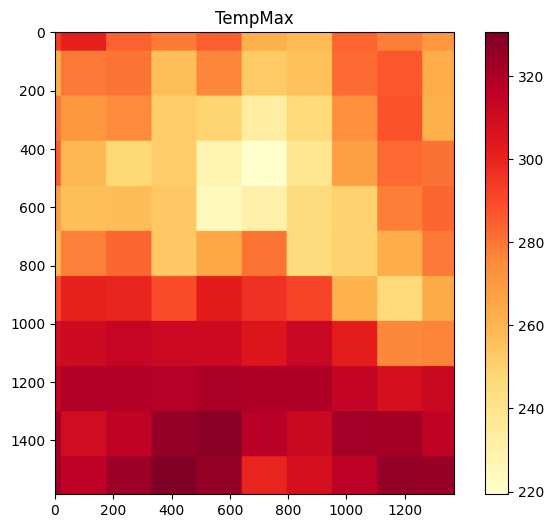

In [ ]:
def desplegar_imagen(ruta_imagen, cmap='viridis'):
    with rasterio.open(ruta_imagen) as src:
        img = src.read(1)  # Lee la primera banda de la imagen

        # Muestra la imagen con una escala de colores
        plt.figure(figsize=(8, 6))
        plt.imshow(img, cmap=cmap)  # Selecciona el mapa de colores
        plt.colorbar()
        plt.title('TempMax')
        plt.show()

# Llama a la función con la ruta de la imagen de índice de población
ruta_poblacion = '/content/drive/MyDrive/2018-2022 NDVI NBR/ambientales/2015.tif'
desplegar_imagen(ruta_poblacion, cmap='YlOrRd')

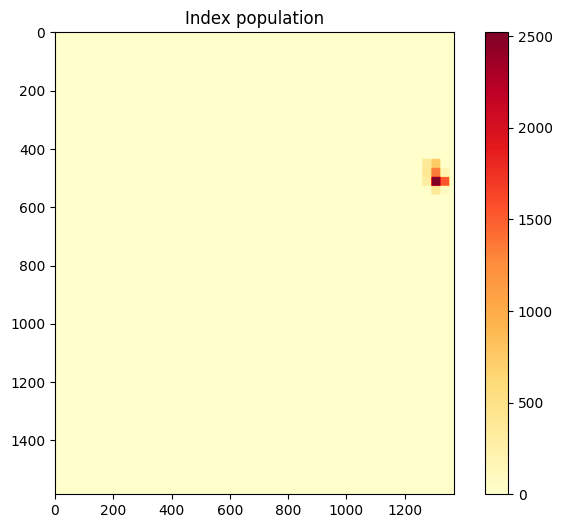

In [ ]:
def desplegar_imagen(ruta_imagen, cmap='viridis'):
    with rasterio.open(ruta_imagen) as src:
        img = src.read(1)  # Lee la primera banda de la imagen

        # Muestra la imagen con una escala de colores
        plt.figure(figsize=(8, 6))
        plt.imshow(img, cmap=cmap)  # Selecciona el mapa de colores
        plt.colorbar()
        plt.title('Index population')
        plt.show()

# Llama a la función con la ruta de la imagen de índice de población
ruta_poblacion = '/content/drive/MyDrive/2018-2022 NDVI NBR/poblacion/population-index-2020.tif'
desplegar_imagen(ruta_poblacion, cmap='YlOrRd')


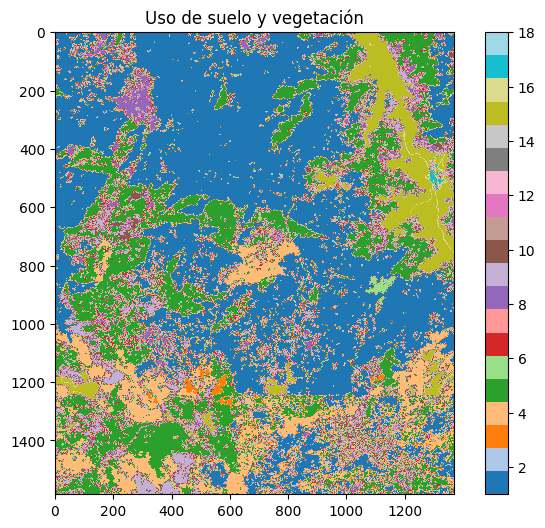

In [ ]:
def desplegar_imagen(ruta_imagen, cmap='viridis'):
    with rasterio.open(ruta_imagen) as src:
        img = src.read(1)  # Lee la primera banda de la imagen

        # Muestra la imagen con una escala de colores
        plt.figure(figsize=(8, 6))
        plt.imshow(img, cmap=cmap)  # Selecciona el mapa de colores
        plt.colorbar()
        plt.title('Uso de suelo y vegetación')
        plt.show()

# Llama a la función con la ruta de la imagen de uso de suelo
ruta_uso_suelo = '/content/drive/MyDrive/2018-2022 NDVI NBR/landcover/landcover.tif'
desplegar_imagen(ruta_uso_suelo, cmap='tab20')

Aqui veremos las imagenes

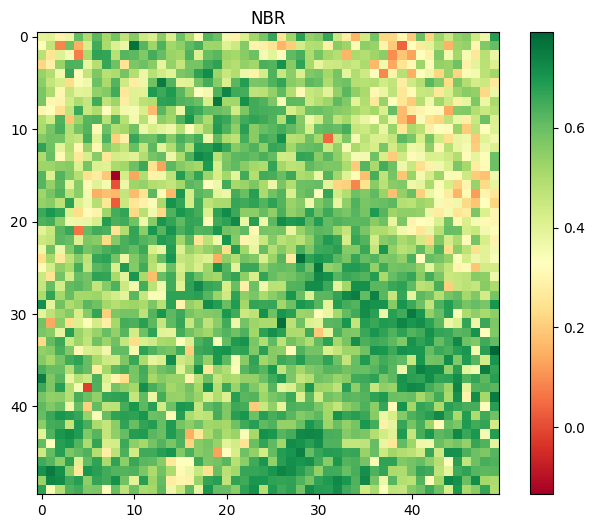

In [ ]:
def desplegar_imagen_NBR(ruta_imagen):
    with rasterio.open(ruta_imagen) as src:
        img = src.read(1)  # Lee la primera banda de la imagen

        # Muestra la imagen con una escala de colores
        plt.figure(figsize=(8, 6))
        plt.imshow(img, cmap='RdYlGn')  # Selecciona el mapa de colores
        plt.colorbar()
        plt.title('NBR')
        plt.show()

# Llama a la función con la ruta de la imagen
desplegar_imagen_NBR('/content/drive/MyDrive/2018-2022 NDVI NBR/preprocep/nbr/LC08_030046_20140127.tif')

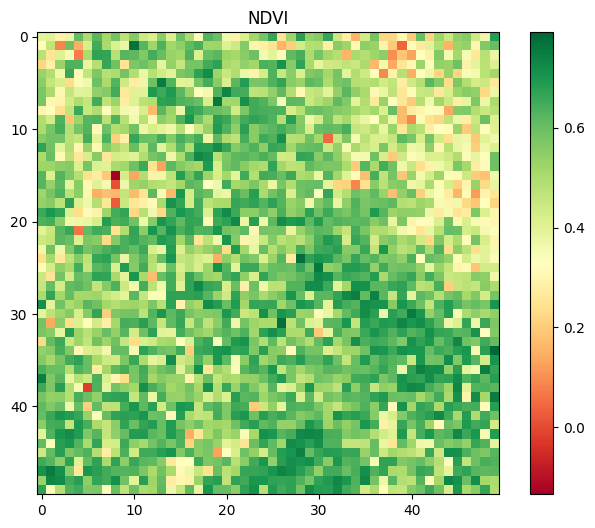

In [ ]:
def desplegar_imagen_NDVI(ruta_imagen):
    with rasterio.open(ruta_imagen) as src:
        img = src.read(1)  # Lee la primera banda de la imagen

        # Muestra la imagen con una escala de colores
        plt.figure(figsize=(8, 6))
        plt.imshow(img, cmap='RdYlGn')  # Selecciona el mapa de colores
        plt.colorbar()
        plt.title('NDVI')
        plt.show()

# Llama a la función con la ruta de la imagen
desplegar_imagen_NDVI('/content/drive/MyDrive/2018-2022 NDVI NBR/preprocep/ndvi2/LC08_030046_20140127.tif')

In [ ]:
#desplegando_imagen_NBR('/content/drive/MyDrive/2018-2022 NDVI NBR/preprocep/ndvi2/LC08_030046_20140228.tif')

In [ ]:
#desplegando_imagen_NBR('/content/drive/MyDrive/2018-2022 NDVI NBR/preprocep/ndvi2/Copia de LC08_030046_20140401.tif')

In [ ]:
# Ruta de la carpeta a limpiar
ruta_carpeta = '/content/drive/MyDrive/2018-2022 NDVI NBR/preprocep/multiband/'

# Verificar si la carpeta existe
if os.path.exists(ruta_carpeta):
    # Eliminar todo el contenido de la carpeta
    for filename in os.listdir(ruta_carpeta):
        file_path = os.path.join(ruta_carpeta, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print(f"No se pudo eliminar {file_path}. Motivo: {e}")
    print("Contenido de la carpeta eliminado exitosamente.")
else:
    print("La carpeta no existe.")

Contenido de la carpeta eliminado exitosamente.


In [ ]:
NBR_dic = '/content/drive/MyDrive/2018-2022 NDVI NBR/preprocep/nbr'
NDVI_dic = '/content/drive/MyDrive/2018-2022 NDVI NBR/preprocep/ndvi2'

In [ ]:

# Directorio de entrada para NBR
NDVI_dic = "/content/drive/MyDrive/2018-2022 NDVI NBR/preprocep/ndvi2"

# Directorio de salida para las imágenes de NBR en la carpeta "multiband"
output_directory = "/content/drive/MyDrive/2018-2022 NDVI NBR/preprocep/multiband"

# Obtener la lista de archivos en el directorio NBR
image_files = os.listdir(NDVI_dic)

for image in image_files:
    # Le damos el path completo de cada imagen NBR
    file_path_NBR = os.path.join(NBR_dic, image)

    # Crear el path de salida para la imagen en la carpeta "multiband"
    output_path = os.path.join(output_directory, image)

    # Copiar la imagen de NBR a la carpeta "multiband"
    shutil.copy(file_path_NBR, output_path)

# Nota: Asegúrate de que las imágenes tengan el mismo nombre en el directorio NBR y que deseas copiar todas las imágenes sin filtrar.


In [ ]:
with rasterio.open('/content/drive/MyDrive/2018-2022 NDVI NBR/preprocep/multiband/LC08_030046_20140111.tif') as src: #Abrimos con Rasterio
        image_array = src.read() #Leemos el array de la imagen

image_array.shape

(1, 50, 50)

In [ ]:
multiband_dic = '/content/drive/MyDrive/2018-2022 NDVI NBR/preprocep/multiband/'

In [ ]:
train_img = []

for image in image_files:
    #Le damos el path completo de cada TIF imagen
    file_path = os.path.join(multiband_dic, image)

    with rasterio.open(file_path) as src: #Abrimos con Rasterio
        image_array = src.read() #Leemos el array de la imagen

    train_img.append(image_array)

train_img_2 = np.stack([img for img in train_img], axis=0)
print(train_img_2.shape)

(10, 1, 50, 50)


In [ ]:
# Assuming you have a 2-channel TIF image with shape (2, 48, 40)
image = train_img_2

# Reshape the image to (48, 40, 2)
reshaped_image = np.transpose(image, (0, 2, 3, 1))

print(reshaped_image.shape)

(10, 50, 50, 1)


In [ ]:
# Ruta de la carpeta a limpiar
ruta_carpeta = '/content/drive/MyDrive/2018-2022 NDVI NBR/preprocep/target'

# Verificar si la carpeta existe
if os.path.exists(ruta_carpeta):
    # Eliminar todo el contenido de la carpeta
    for filename in os.listdir(ruta_carpeta):
        file_path = os.path.join(ruta_carpeta, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print(f"No se pudo eliminar {file_path}. Motivo: {e}")
    print("Contenido de la carpeta eliminado exitosamente.")
else:
    print("La carpeta no existe.")

Contenido de la carpeta eliminado exitosamente.


In [ ]:
# Ruta de la carpeta a limpiar
ruta_carpeta = '/content/drive/MyDrive/2018-2022 NDVI NBR/preprocep/target'

# Verificar si la carpeta existe
if os.path.exists(ruta_carpeta):
    # Eliminar todo el contenido de la carpeta
    for filename in os.listdir(ruta_carpeta):
        file_path = os.path.join(ruta_carpeta, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print(f"No se pudo eliminar {file_path}. Motivo: {e}")
    print("Contenido de la carpeta eliminado exitosamente.")
else:
    print("La carpeta no existe.")

Contenido de la carpeta eliminado exitosamente.


In [ ]:
# Ruta de la carpeta a limpiar
ruta_carpeta = '/content/drive/MyDrive/2018-2022 NDVI NBR/zonasegmentada'

# Verificar si la carpeta existe
if os.path.exists(ruta_carpeta):
    # Eliminar todo el contenido de la carpeta
    for filename in os.listdir(ruta_carpeta):
        file_path = os.path.join(ruta_carpeta, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print(f"No se pudo eliminar {file_path}. Motivo: {e}")
    print("Contenido de la carpeta eliminado exitosamente.")
else:
    print("La carpeta no existe.")

Contenido de la carpeta eliminado exitosamente.


In [ ]:
# Directorio de entrada para NBR
zona_uno = '/content/drive/MyDrive/2018-2022 NDVI NBR/zona-uno_v2'

# Directorio de salida para las imágenes de NBR en la carpeta "multiband"
output_directory = "/content/drive/MyDrive/2018-2022 NDVI NBR/preprocep/target"

# Directorio de salida para las imágenes segmentadas
carpeta_procesada = "/content/drive/MyDrive/2018-2022 NDVI NBR/preprocep/segmentadas"

In [ ]:
# Valor de nodata
nodata_value = -9999

# Obtener la lista de archivos en la carpeta de entrada
archivos_tiff = [archivo for archivo in os.listdir(zona_uno) if archivo.endswith('.tif')]

# Crear la carpeta de salida si no existe
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Crear la carpeta procesada si no existe
if not os.path.exists(carpeta_procesada):
    os.makedirs(carpeta_procesada)

# Recorrer cada archivo en la carpeta
for archivo_tiff in archivos_tiff:
    # Construir la ruta completa al archivo TIFF de entrada
    ruta_tiff_entrada = os.path.join(zona_uno, archivo_tiff)

    with rasterio.open(ruta_tiff_entrada) as src:
        # Leer los datos como una matriz numpy
        image_array = src.read(1, masked=True)
        mask = src.read_masks(1)

    # Excluir los valores de nodata
    image_array = np.ma.masked_where(image_array == nodata_value, image_array)

    # Aplicar la máscara al array de la imagen
    image_array = np.ma.masked_array(image_array, mask)

    # Resize de la imagen
    resized_image = cv2.resize(image_array, (50, 50))

    # Construir la ruta completa al archivo TIFF de salida
    ruta_tiff_salida = os.path.join(output_directory, f'resized_{archivo_tiff}')

    # Guardar la imagen redimensionada
    cv2.imwrite(ruta_tiff_salida, resized_image)

    # Abrir el archivo redimensionado con rasterio
    with rasterio.open(ruta_tiff_salida) as src:
        # Leer los datos como una matriz numpy
        datos_resized = src.read(1, masked=True)

        # Excluir los valores de nodata
        datos_sin_nodata_resized = np.ma.masked_where(datos_resized == nodata_value, datos_resized)

        # Segmentar la imagen según los valores dados (>0.6 y <0.6)
        segmentacion = np.where(datos_sin_nodata_resized > 0.6, 1, 0)

    # Construir la ruta completa al archivo TIFF segmentado de salida
    ruta_segmentada = os.path.join(carpeta_procesada, f'segmentada_{archivo_tiff}')

    # Guardar la imagen segmentada como un nuevo archivo TIFF
    with rasterio.open(
        ruta_segmentada,
        'w',
        driver='GTiff',
        height=segmentacion.shape[0],
        width=segmentacion.shape[1],
        count=1,
        dtype=str(segmentacion.dtype),
        crs=src.crs,
        transform=src.transform,
    ) as dst:
        dst.write(segmentacion, 1)

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


In [ ]:
with rasterio.open('/content/drive/MyDrive/2018-2022 NDVI NBR/preprocep/segmentadas/segmentada_LC08_030046_20140111.tif') as src: #Abrimos con Rasterio
        image_array = src.read() #Leemos el array de la imagen

image_array.shape

(1, 50, 50)

In [ ]:
target_dic = '/content/drive/MyDrive/2018-2022 NDVI NBR/preprocep/segmentadas'

In [ ]:
# Obtener la lista de archivos de imágenes
file_list = os.listdir(target_dic)
image_files = [file for file in file_list if file.endswith(('.tif'))] #Se crea una lista con los nombres de los archivos
print(f"La carpeta contiene " + str(len(image_files)) + " imágenes") #Imprimir el numero de imagenes leidas

La carpeta contiene 10 imágenes


In [ ]:
train_img2 = []

for image in image_files:
    #Le damos el path completo de cada TIF imagen
    file_path = os.path.join(target_dic, image)

    with rasterio.open(file_path) as src: #Abrimos con Rasterio
        image_array = src.read() #Leemos el array de la imagen

    train_img2.append(image_array)

train_img_3 = np.stack([img for img in train_img2], axis=0)
print(train_img_2.shape)

(10, 1, 50, 50)


In [ ]:
# Assuming you have a 2-channel TIF image with shape (2, 48, 40)
image = train_img_3

# Reshape the image to (48, 40, 2)
reshaped_image_2 = np.transpose(image, (0, 2, 3, 1))

print(reshaped_image_2.shape)

(10, 50, 50, 1)


# Modelos CNN

En esta seccion encontraremos los modelos para el algoritmo de un solo canal (NDVI) que prediga el NBR y de dos canales (NBR + NDVI) para predecir NBR

## Modelo 1

#### X Y

Definicion de Output e input del primer modelo

In [ ]:
y = reshaped_image_2

In [ ]:
X = reshaped_image

In [ ]:
# Assuming reshaped_image is your features and y is your labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)


In [ ]:
y_train.shape

(6, 50, 50, 1)

In [ ]:
y_val.shape

(2, 50, 50, 1)

In [ ]:
X_train.shape

(6, 50, 50, 1)

In [ ]:
X_val.shape

(2, 50, 50, 1)

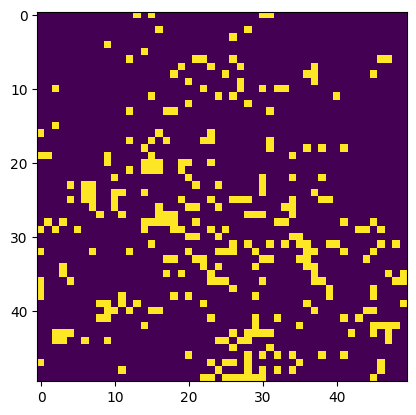

<Axes: >

In [ ]:
show(y_train[4, :, :, 0])


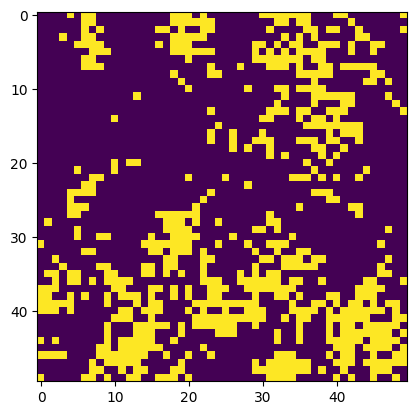

<Axes: >

In [ ]:
show(y_val[1, :, :, 0])


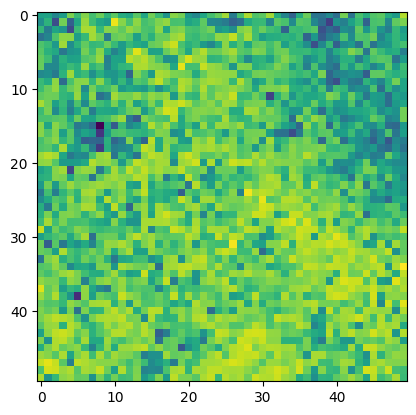

<Axes: >

In [ ]:
show(X_train[4, :, :, 0])


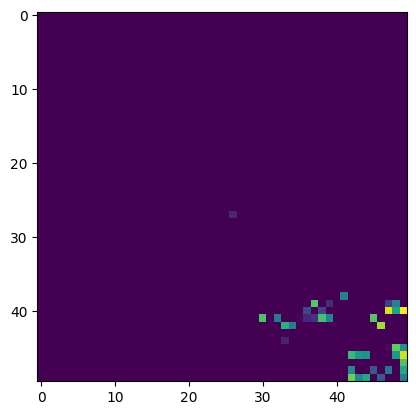

<Axes: >

In [ ]:
show(X_val[1, :, :, 0])

Con2D
MAx
Con2D
Max
Con2D
Max

Flatten
FC - Dense
FC - Dense}

Input Shape - 200 200 * 1
Output Shape 40000 neuronas - Activacion Sigmoide
1d transformar a 2D

Resize de 40,000 a 200 x 200

Cambiarle a 0 - despues cambiarle a -1

cambiar las imagenes de NBR a vectores de 40,000 y esta sera la Y de target --- Activacion sigomoide.

Para segunda version del modelo
Utilizar Dropout de 0.2

Utilizar Callbacks



**Meter los Callbacks y dropouts - **

**Intentar ver si combiene utilizar los segmentations**

**Descargar variables ambientales - antropogenicas **


In [ ]:
#import cv2
#import matplotlib.pyplot as plt
#path = "/content/drive/MyDrive/2018-2022 NDVI NBR/Captura de pantalla 2023-11-15 085354.png"
#img = cv2.imread(path)
#plt.imshow(img)

### Modelo convulcional

Aqui se intenta realizar un modelo con un canal de NDVI y me de el NBR

In [ ]:
# Define the neural network architecture
model = Sequential()

# Convolutional and max-pooling layers
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(50, 50, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten layer
model.add(Flatten())

# Fully connected layers
model.add(Dense(2500, activation='sigmoid'))

# Reshape to 2D
model.add(Reshape((50, 50, 1)))

# Compila el modelo
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 11, 11, 128)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 15488)             0         
                                                                 
 dense (Dense)               (None, 2500)              3

In [ ]:
%time historial = model.fit(X_train, X_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.6937 - accuracy: 0.0639 - val_loss: 0.6707 - val_accuracy: 0.7666
Epoch 2/100
1/1 [==============================] - 1s 1s/step - loss: 0.6725 - accuracy: 0.1193 - val_loss: 0.6337 - val_accuracy: 0.8100
Epoch 3/100
1/1 [==============================] - 1s 953ms/step - loss: 0.6468 - accuracy: 0.1195 - val_loss: 0.5878 - val_accuracy: 0.8168
Epoch 4/100
1/1 [==============================] - 1s 1s/step - loss: 0.6365 - accuracy: 0.1197 - val_loss: 0.5647 - val_accuracy: 0.8236
Epoch 5/100
1/1 [==============================] - 1s 957ms/step - loss: 0.6411 - accuracy: 0.1213 - val_loss: 0.5691 - val_accuracy: 0.8400
Epoch 6/100
1/1 [==============================] - 1s 983ms/step - loss: 0.6308 - accuracy: 0.1240 - val_loss: 0.5840 - val_accuracy: 0.8510
Epoch 7/100
1/1 [==============================] - 1s 926ms/step - loss: 0.6209 - accuracy: 0.1259 - val_loss: 0.5986 - val_accuracy: 0.8442
Epoch 8/100
1/1 [=====

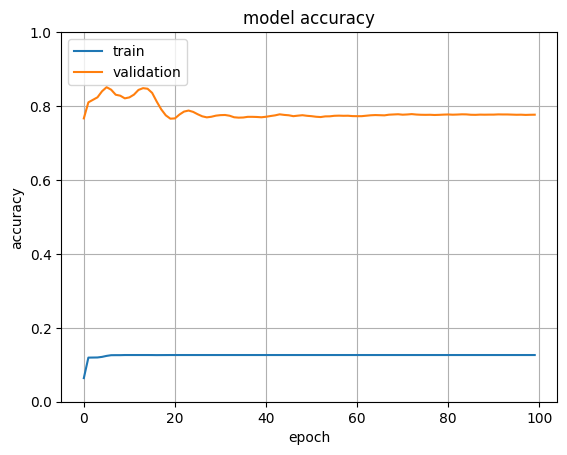

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.ylim((0,1))
    plt.grid()
    plt.show()


plot_hist(historial)

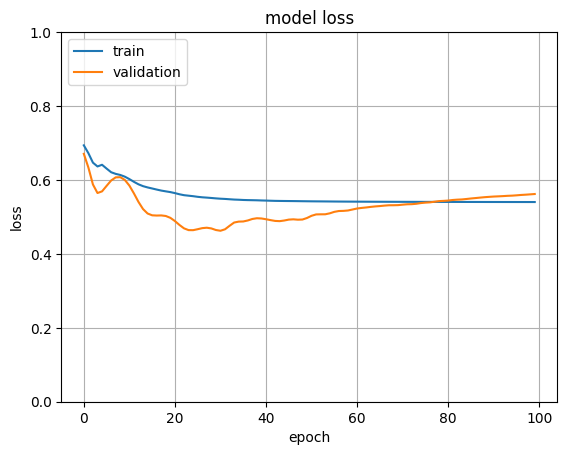

In [ ]:
def plot_hist_loss(hist):
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.ylim((0,1))
    plt.grid()
    plt.show()


plot_hist_loss(historial)

## Modelo 2


1/1 [==============================] - 0s 177ms/step


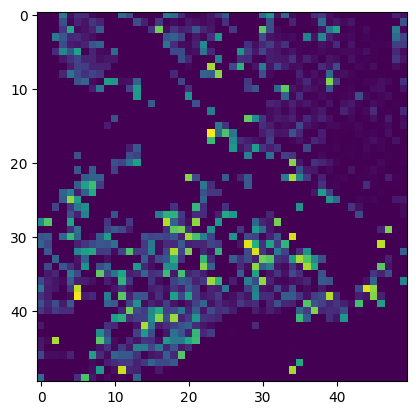

In [ ]:
salida = model.predict(y_train)
plt.imshow(salida[0, :, :, 0])

### Union canales

Procesamiento para unir los dos calaes para gener una imagen con dos canales (NBR + NDVI)

In [ ]:
# Ruta de la carpeta a limpiar
ruta_carpeta = '/content/drive/MyDrive/2018-2022 NDVI NBR/preprocep/doscanales/'

# Verificar si la carpeta existe
if os.path.exists(ruta_carpeta):
    # Eliminar todo el contenido de la carpeta
    for filename in os.listdir(ruta_carpeta):
        file_path = os.path.join(ruta_carpeta, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print(f"No se pudo eliminar {file_path}. Motivo: {e}")
    print("Contenido de la carpeta eliminado exitosamente.")
else:
    print("La carpeta no existe.")

Contenido de la carpeta eliminado exitosamente.


In [ ]:
NBR_dic = '/content/drive/MyDrive/2018-2022 NDVI NBR/preprocep/nbr'
NDVI_dic = '/content/drive/MyDrive/2018-2022 NDVI NBR/preprocep/ndvi2'

combined_dic = '/content/drive/MyDrive/2018-2022 NDVI NBR/preprocep/doscanales'

NBR_img = []
NDVI_img = []

# Check if the combined_dic directory exists, if not, create it
if not os.path.exists(combined_dic):
    os.makedirs(combined_dic)

# Obtener la lista de archivos en NBR_dic
image_files = [archivo for archivo in os.listdir(NBR_dic) if archivo.endswith('.tif')]

# Leer las imágenes en NBR_dic y NDVI_dic, y combinarlas en un nuevo archivo
for image in image_files:
    # Le damos el path completo de cada NBR imagen
    file_path_NBR = os.path.join(NBR_dic, image)
    # Le damos el path completo de cada NDVI imagen
    file_path_NDVI = os.path.join(NDVI_dic, image)

    # Abrir las imágenes con rasterio
    with rasterio.open(file_path_NBR) as src_NBR, rasterio.open(file_path_NDVI) as src_NDVI:
        # Leer las bandas de las imágenes
        NBR_array = src_NBR.read()
        NDVI_array = src_NDVI.read()

        # Crear el perfil del archivo combinado
        profile = src_NBR.profile
        profile.update(count=2)

        # Crear el path del archivo combinado
        combined_file_path = os.path.join(combined_dic, image)

        # Escribir las imágenes combinadas en el nuevo TIF file
        with rasterio.open(combined_file_path, 'w', **profile) as dst:
            # Escribir la primera imagen en el nuevo TIF file
            dst.write(NBR_array, indexes=[1])

            # Escribir la segunda imagen en el nuevo TIF file
            dst.write(NDVI_array, indexes=[2])

# Optional: Agregar las imágenes combinadas a las listas NBR_img y NDVI_img
    NBR_img.append(NBR_array)
    NDVI_img.append(NDVI_array)

In [ ]:
# NBR_img[0].shape
len(NBR_img)

10

In [ ]:
# NDVI_img[0].shape
len(NDVI_img)

10

In [ ]:
train_img = []

for i in range(10):
    train_img.append([NBR_img[i], NDVI_img[i]])

In [ ]:
train_img[0]

[array([[[0.37164322, 0.39615422, 0.27110216, ..., 0.42720503,
          0.3380786 , 0.62882763],
         [0.25568107, 0.42775828, 0.10543334, ..., 0.3327199 ,
          0.510688  , 0.59098685],
         [0.3685331 , 0.2587375 , 0.4417599 , ..., 0.24645391,
          0.4464884 , 0.27585918],
         ...,
         [0.64074546, 0.69504285, 0.6609988 , ..., 0.5627715 ,
          0.56692696, 0.57753426],
         [0.46146354, 0.66968894, 0.6682531 , ..., 0.68956697,
          0.45961523, 0.4355468 ],
         [0.61425835, 0.26824662, 0.39186296, ..., 0.48586673,
          0.6434826 , 0.45260432]]], dtype=float32),
 array([[[0.37164322, 0.39615422, 0.27110216, ..., 0.42720503,
          0.3380786 , 0.62882763],
         [0.25568107, 0.42775828, 0.10543334, ..., 0.3327199 ,
          0.510688  , 0.59098685],
         [0.3685331 , 0.2587375 , 0.4417599 , ..., 0.24645391,
          0.4464884 , 0.27585918],
         ...,
         [0.64074546, 0.69504285, 0.6609988 , ..., 0.5627715 ,
         

In [ ]:
input_shapes = set(np.array(image).shape for image in train_img)

print("Formas de las imágenes NBR de entrada:")
print(input_shapes)

Formas de las imágenes NBR de entrada:
{(2, 1, 50, 50)}


In [ ]:
for image in image_files:
    #Le damos el path completo de cada NBR imagen
    file_path_NBR = os.path.join(NBR_dic, image)
    #Le damos el path completo de cada NDVI imagen
    file_path_NDVI = os.path.join(NDVI_dic, image)

    NBR = rasterio.open(file_path_NBR)
    NDVI = rasterio.open(file_path_NDVI)

    profile = NBR.profile
    profile.update(count=2)

    with rasterio.open('/content/drive/MyDrive/2018-2022 NDVI NBR/preprocep/doscanales/' + image,
                       'w', **profile) as dst:
        # Write the first image to the new TIF file
        dst.write(NBR.read(), indexes=[1])

        # Write the second image to the new TIF file
        dst.write(NDVI.read(), indexes=[2])


In [ ]:
with rasterio.open('/content/drive/MyDrive/2018-2022 NDVI NBR/preprocep/doscanales/LC08_030046_20140316.tif') as src: #Abrimos con Rasterio
        image_array = src.read() #Leemos el array de la imagen

image_array.shape

(2, 50, 50)

In [ ]:
multiband_dic = '/content/drive/MyDrive/2018-2022 NDVI NBR/preprocep/doscanales/'

In [ ]:
train_img3 = []

for image in image_files:
    #Le damos el path completo de cada TIF imagen
    file_path = os.path.join(multiband_dic, image)

    with rasterio.open(file_path) as src: #Abrimos con Rasterio
        image_array = src.read() #Leemos el array de la imagen

    train_img3.append(image_array)

train_img_4 = np.stack([img for img in train_img3], axis=0)
print(train_img_2.shape)

(10, 1, 50, 50)


In [ ]:
# Assuming you have a 2-channel TIF image with shape (2, 48, 40)
image = train_img_4

# Reshape the image to (48, 40, 2)
reshaped_image2 = np.transpose(image, (0, 2, 3, 1))

print(reshaped_image2.shape)

(10, 50, 50, 2)


In [ ]:
reshaped_image2 = reshaped_image2

### X Y

Aqui se define la "X" (input) y "y" (output)

In [ ]:
ym2 = reshaped_image_2

In [ ]:
Xm2 = reshaped_image2

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Xm2, ym2, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

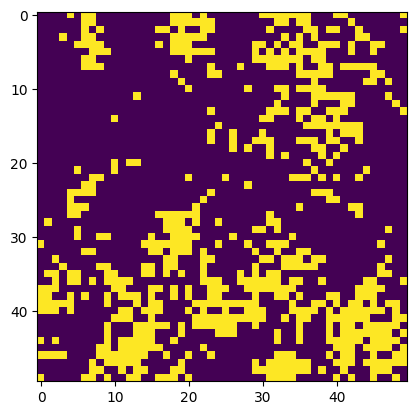

<Axes: >

In [ ]:
show(y_train[2, :, :, 0])

In [ ]:
X_train.shape

(6, 50, 50, 2)

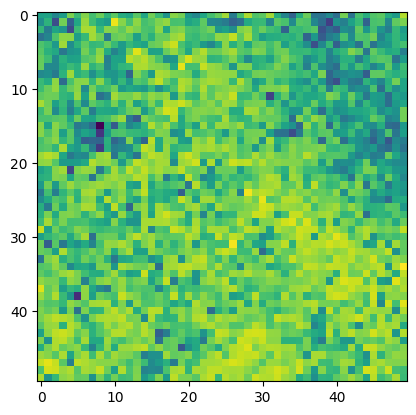

<Axes: >

In [ ]:
show(X_train[5, :, :, 0])

### Modelo convulcional

Aqui se intenta con imagenes de dos canales y que nomas le salga un canal

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Reshape

# Define the neural network architecture
model2 = Sequential()

# Convolutional and max-pooling layers
model2.add(Conv2D(64, (3, 3), activation='relu', input_shape=(50, 50, 2)))  # Change input shape to (50, 50, 2)
model2.add(MaxPooling2D((2, 2)))
model2.add(Conv2D(128, (3, 3), activation='relu'))
model2.add(MaxPooling2D((2, 2)))

# Flatten layer
model2.add(Flatten())

# Fully connected layers
model2.add(Dense(2500, activation='sigmoid'))

# Reshape to 2D
model2.add(Reshape((50, 50, 1)))

# Compile the model
model2.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])

# Print model summary
model2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        1216      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 22, 22, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 11, 11, 128)       0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 15488)             0         
                                                                 
 dense_1 (Dense)             (None, 2500)             

In [ ]:
%time historial2 = model2.fit(X_train, X_train, epochs=100, batch_size=32, validation_data=(X_val, X_val))

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.6936 - accuracy: 0.1003 - val_loss: 0.6737 - val_accuracy: 0.1402
Epoch 2/100
1/1 [==============================] - 1s 1s/step - loss: 0.6650 - accuracy: 0.1623 - val_loss: 0.6815 - val_accuracy: 0.1418
Epoch 3/100
1/1 [==============================] - 1s 972ms/step - loss: 0.6479 - accuracy: 0.1719 - val_loss: 0.7083 - val_accuracy: 0.1434
Epoch 4/100
1/1 [==============================] - 1s 1s/step - loss: 0.6518 - accuracy: 0.1807 - val_loss: 0.6878 - val_accuracy: 0.1536
Epoch 5/100
1/1 [==============================] - 1s 941ms/step - loss: 0.6388 - accuracy: 0.1914 - val_loss: 0.6692 - val_accuracy: 0.1652
Epoch 6/100
1/1 [==============================] - 1s 935ms/step - loss: 0.6316 - accuracy: 0.1982 - val_loss: 0.6602 - val_accuracy: 0.1792
Epoch 7/100
1/1 [==============================] - 1s 924ms/step - loss: 0.6287 - accuracy: 0.1999 - val_loss: 0.6558 - val_accuracy: 0.1894
Epoch 8/100
1/1 [=====

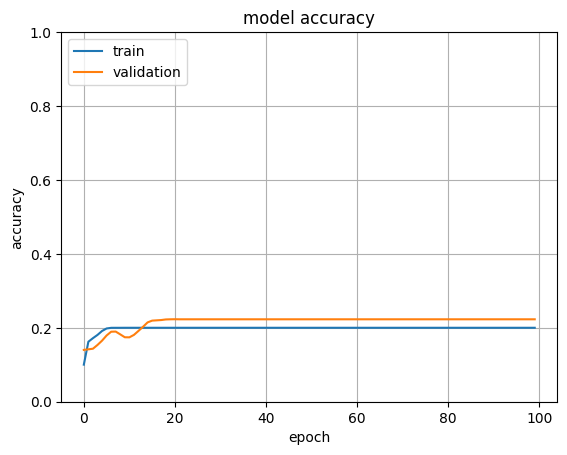

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.ylim((0,1))
    plt.grid()
    plt.show()


plot_hist(historial2)

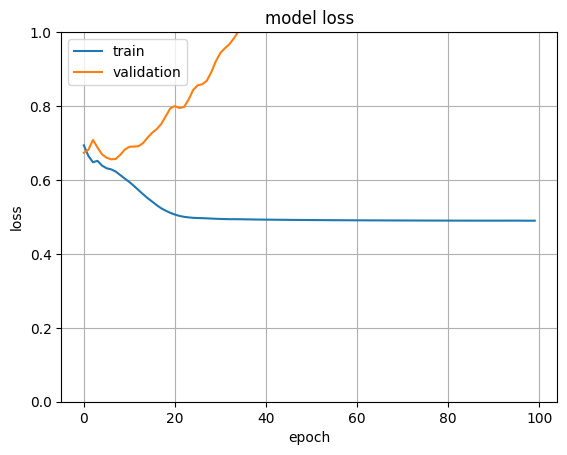

In [ ]:
def plot_hist_loss(hist):
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.ylim((0,1))
    plt.grid()
    plt.show()


plot_hist_loss(historial2)

1/1 [==============================] - 0s 116ms/step


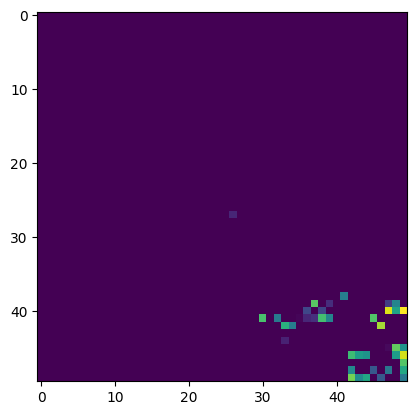

In [ ]:
salida = model2.predict(X_train)
plt.imshow(salida[0, :, :, 0])

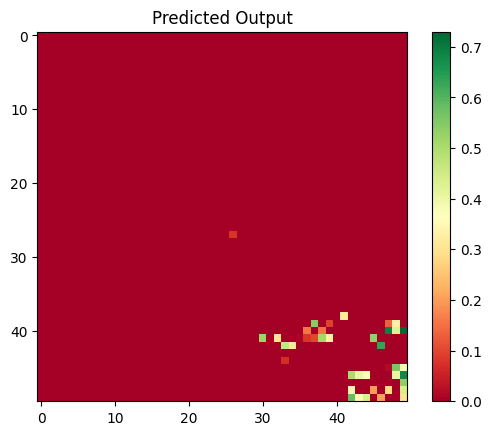

Predicted Image Range: 0.7514665722846985


In [ ]:
# Display the predicted output (1st sample) using matplotlib
plt.imshow(salida[0, :, :, 0], cmap='RdYlGn')  # Assuming it's a grayscale image
plt.colorbar()
plt.title('Predicted Output')
plt.show()

# Get the range of the predicted image
predicted_range = np.ptp(salida[3, :, :, 0])  # Peak-to-peak (max-min) value
print(f"Predicted Image Range: {predicted_range}")


## Comparación un canal vs dos canales

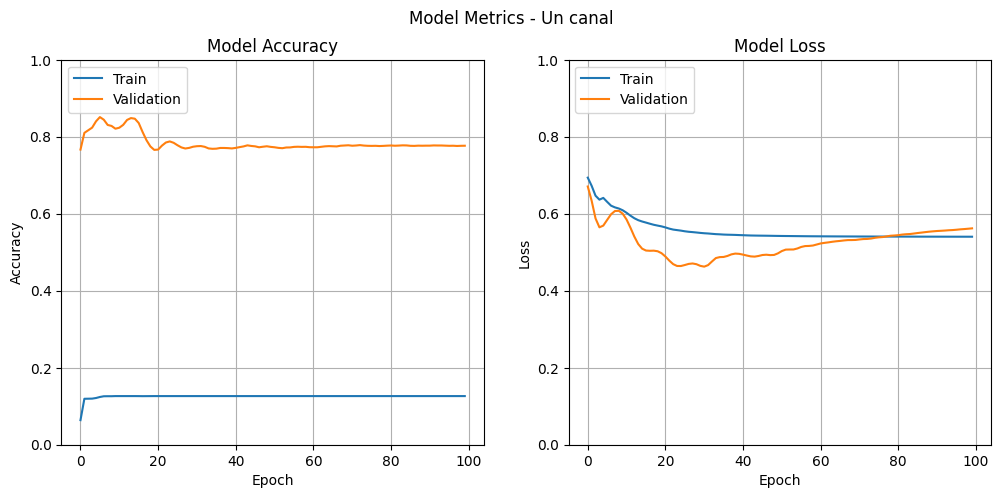

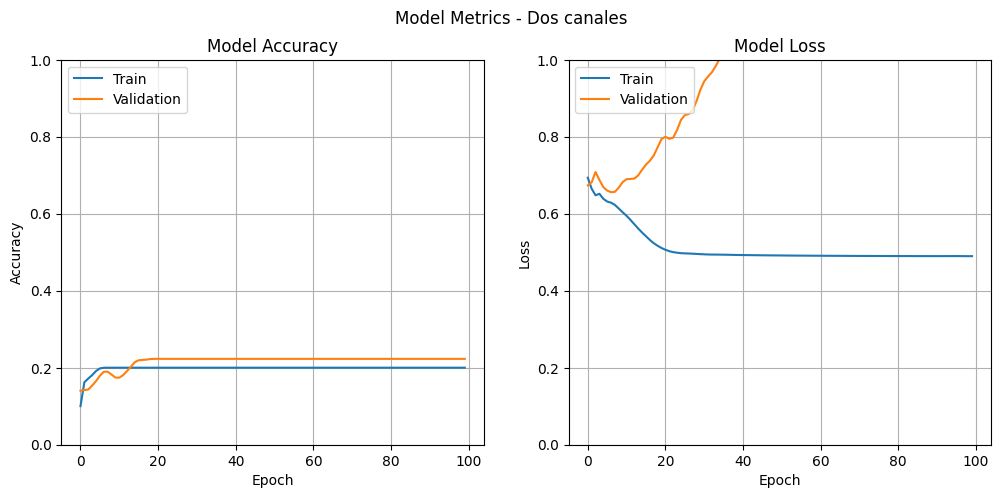

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(hist, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot accuracy
    ax1.plot(hist.history["accuracy"])
    ax1.plot(hist.history["val_accuracy"])
    ax1.set_title("Model Accuracy")
    ax1.set_ylabel("Accuracy")
    ax1.set_xlabel("Epoch")
    ax1.legend(["Train", "Validation"], loc="upper left")
    ax1.set_ylim((0, 1))
    ax1.grid()

    # Plot loss
    ax2.plot(hist.history["loss"])
    ax2.plot(hist.history["val_loss"])
    ax2.set_title("Model Loss")
    ax2.set_ylabel("Loss")
    ax2.set_xlabel("Epoch")
    ax2.legend(["Train", "Validation"], loc="upper left")
    ax2.set_ylim((0, 1))
    ax2.grid()

    plt.suptitle(title)
    plt.show()

# Example usage:
# Assuming you have historial and historial2
plot_metrics(historial, "Model Metrics - Un canal")
plot_metrics(historial2, "Model Metrics - Dos canales")


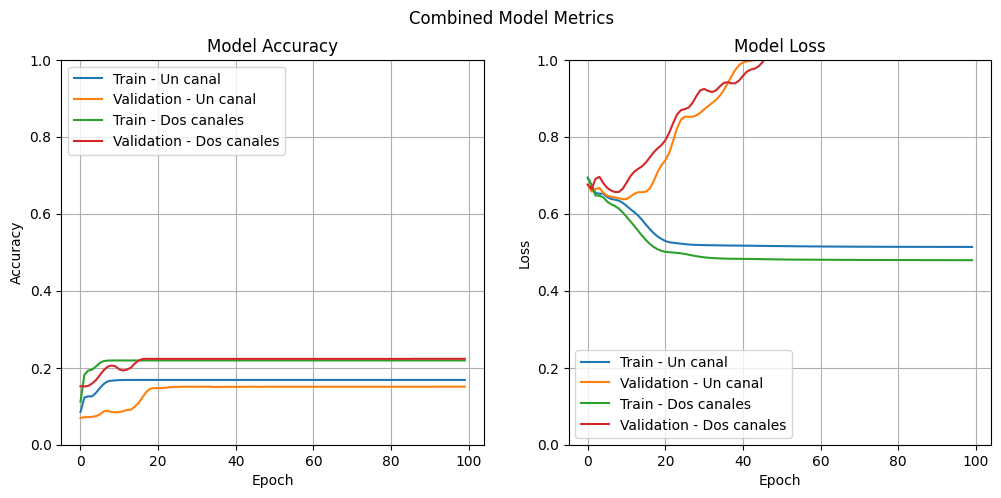

In [ ]:
import matplotlib.pyplot as plt

def plot_combined_metrics(hist1, hist2, title):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot accuracy
    axes[0].plot(hist1.history["accuracy"], label="Train - Un canal")
    axes[0].plot(hist1.history["val_accuracy"], label="Validation - Un canal")
    axes[0].plot(hist2.history["accuracy"], label="Train - Dos canales")
    axes[0].plot(hist2.history["val_accuracy"], label="Validation - Dos canales")
    axes[0].set_title("Model Accuracy")
    axes[0].set_ylabel("Accuracy")
    axes[0].set_xlabel("Epoch")
    axes[0].legend(loc="upper left")
    axes[0].set_ylim((0, 1))
    axes[0].grid()

    # Plot loss
    axes[1].plot(hist1.history["loss"], label="Train - Un canal")
    axes[1].plot(hist1.history["val_loss"], label="Validation - Un canal")
    axes[1].plot(hist2.history["loss"], label="Train - Dos canales")
    axes[1].plot(hist2.history["val_loss"], label="Validation - Dos canales")
    axes[1].set_title("Model Loss")
    axes[1].set_ylabel("Loss")
    axes[1].set_xlabel("Epoch")
    axes[1].legend(loc="lower left")
    axes[1].set_ylim((0, 1))
    axes[1].grid()

    plt.suptitle(title)
    plt.show()

# Example usage:
# Assuming you have historial and historial2
plot_combined_metrics(historial, historial2, "Combined Model Metrics")


# Callbacks

Aqui se desarrolla el modelo utilizando callbacks para eficientar el tiempo del algoritmo y el procesamiento.

In [ ]:
#Callbacks
early_stop = EarlyStopping(monitor='val_mse', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)

## Convulcional 3

Aqui utilizamos los callbacks con un solo canal

### X Y

In [ ]:
yc = reshaped_image_2

In [ ]:
Xc = reshaped_image

In [ ]:
# Assuming reshaped_image is your features and y is your labels
X_train, X_test, y_train, y_test = train_test_split(Xc, yc, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)


In [ ]:
y_train.shape

(6, 50, 50, 1)

In [ ]:
y_val.shape

(2, 50, 50, 1)

In [ ]:
X_train.shape

(6, 50, 50, 1)

In [ ]:
X_val.shape

(2, 50, 50, 1)

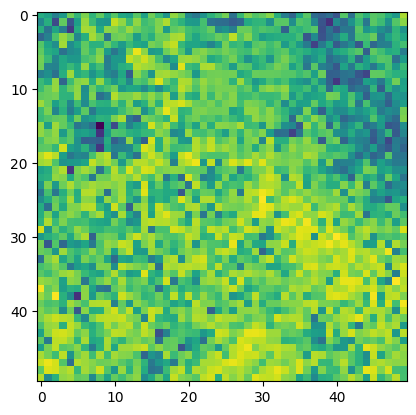

<Axes: >

In [ ]:
show(X_train[4, :, :, 0])

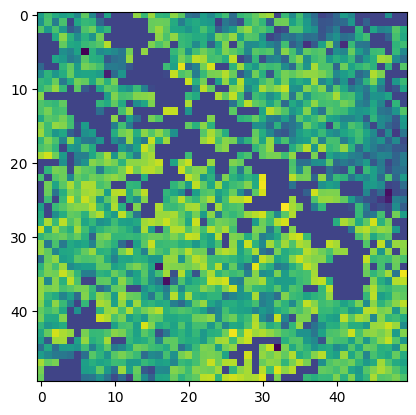

<Axes: >

In [ ]:
show(X_val[1, :, :, 0])

### Modelo

In [ ]:
# Define the neural network architecture
model3 = Sequential()

# Convolutional and max-pooling layers
model3.add(Conv2D(64, (3, 3), activation='relu', input_shape=(50, 50, 1)))
model3.add(MaxPooling2D((2, 2)))
model3.add(Conv2D(128, (3, 3), activation='relu'))
model3.add(MaxPooling2D((2, 2)))

# Flatten layer
model3.add(Flatten())

# Fully connected layers
model3.add(Dense(2500, activation='sigmoid'))

# Reshape to 2D
model3.add(Reshape((50, 50, 1)))

# Compila el modelo
model3.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])

# Print model summary
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 22, 22, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 11, 11, 128)       0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 15488)             0         
                                                                 
 dense_2 (Dense)             (None, 2500)             

In [ ]:
%time historial3 = model3.fit(X_train, X_train, epochs=100, batch_size=32, validation_data=(X_val, X_val), callbacks=[early_stop,reduce_lr])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.6934 - accuracy: 0.1160

1/1 [==============================] - 4s 4s/step - loss: 0.6934 - accuracy: 0.1160 - val_loss: 0.6744 - val_accuracy: 0.0722 - lr: 0.0010
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.6709 - accuracy: 0.1997

1/1 [==============================] - 2s 2s/step - loss: 0.6709 - accuracy: 0.1997 - val_loss: 0.6650 - val_accuracy: 0.0728 - lr: 0.0010
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.6499 - accuracy: 0.2118

1/1 [==============================] - 2s 2s/step - loss: 0.6499 - accuracy: 0.2118 - val_loss: 0.6905 - val_accuracy: 0.0748 - lr: 0.0010
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.6506 - accuracy: 0.2173

1/1 [==============================] - 2s 2s/step - loss: 0.6506 - accuracy: 0.2173 - val_loss: 0.6882 - val_accuracy: 0.0762 - lr: 0.0010
Epoch 5/100
1/1 [==============================] - ETA: 0s - loss: 0.6429 - accuracy: 0.2267

1/1 [==============================] - 2s 2s/step - loss: 0.6429 - accuracy: 0.2267 - val_loss: 0.6715 - val_accuracy: 0.0822 - lr: 0.0010
Epoch 6/100
1/1 [==============================] - ETA: 0s - loss: 0.6304 - accuracy: 0.2344

1/1 [==============================] - 2s 2s/step - loss: 0.6304 - accuracy: 0.2344 - val_loss: 0.6608 - val_accuracy: 0.0886 - lr: 0.0010
Epoch 7/100
1/1 [==============================] - ETA: 0s - loss: 0.6226 - accuracy: 0.2383

1/1 [==============================] - 1s 1s/step - loss: 0.6226 - accuracy: 0.2383 - val_loss: 0.6557 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 8/100
1/1 [==============================] - ETA: 0s - loss: 0.6164 - accuracy: 0.2391

1/1 [==============================] - 1s 1s/step - loss: 0.6164 - accuracy: 0.2391 - val_loss: 0.6529 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 9/100
1/1 [==============================] - ETA: 0s - loss: 0.6080 - accuracy: 0.2393

1/1 [==============================] - 1s 1s/step - loss: 0.6080 - accuracy: 0.2393 - val_loss: 0.6519 - val_accuracy: 0.0906 - lr: 0.0010
Epoch 10/100
1/1 [==============================] - ETA: 0s - loss: 0.5969 - accuracy: 0.2392

1/1 [==============================] - 1s 1s/step - loss: 0.5969 - accuracy: 0.2392 - val_loss: 0.6532 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 11/100
1/1 [==============================] - ETA: 0s - loss: 0.5839 - accuracy: 0.2392

1/1 [==============================] - 1s 1s/step - loss: 0.5839 - accuracy: 0.2392 - val_loss: 0.6570 - val_accuracy: 0.0900 - lr: 0.0010
Epoch 12/100
1/1 [==============================] - ETA: 0s - loss: 0.5708 - accuracy: 0.2392

1/1 [==============================] - 1s 1s/step - loss: 0.5708 - accuracy: 0.2392 - val_loss: 0.6631 - val_accuracy: 0.0900 - lr: 0.0010
Epoch 13/100
1/1 [==============================] - ETA: 0s - loss: 0.5585 - accuracy: 0.2393

1/1 [==============================] - 1s 1s/step - loss: 0.5585 - accuracy: 0.2393 - val_loss: 0.6709 - val_accuracy: 0.0906 - lr: 0.0010
Epoch 14/100
1/1 [==============================] - ETA: 0s - loss: 0.5469 - accuracy: 0.2393

1/1 [==============================] - 2s 2s/step - loss: 0.5469 - accuracy: 0.2393 - val_loss: 0.6816 - val_accuracy: 0.0912 - lr: 0.0010
Epoch 15/100
1/1 [==============================] - ETA: 0s - loss: 0.5352 - accuracy: 0.2391

1/1 [==============================] - 2s 2s/step - loss: 0.5352 - accuracy: 0.2391 - val_loss: 0.6971 - val_accuracy: 0.0926 - lr: 0.0010
Epoch 16/100
1/1 [==============================] - ETA: 0s - loss: 0.5242 - accuracy: 0.2391

1/1 [==============================] - 2s 2s/step - loss: 0.5242 - accuracy: 0.2391 - val_loss: 0.7158 - val_accuracy: 0.0940 - lr: 0.0010
Epoch 17/100
1/1 [==============================] - ETA: 0s - loss: 0.5151 - accuracy: 0.2391

1/1 [==============================] - 2s 2s/step - loss: 0.5151 - accuracy: 0.2391 - val_loss: 0.7334 - val_accuracy: 0.0940 - lr: 0.0010
Epoch 18/100
1/1 [==============================] - ETA: 0s - loss: 0.5077 - accuracy: 0.2391

1/1 [==============================] - 2s 2s/step - loss: 0.5077 - accuracy: 0.2391 - val_loss: 0.7505 - val_accuracy: 0.0938 - lr: 0.0010
Epoch 19/100
1/1 [==============================] - ETA: 0s - loss: 0.5014 - accuracy: 0.2391

1/1 [==============================] - 2s 2s/step - loss: 0.5014 - accuracy: 0.2391 - val_loss: 0.7725 - val_accuracy: 0.0932 - lr: 0.0010
Epoch 20/100
1/1 [==============================] - ETA: 0s - loss: 0.4959 - accuracy: 0.2391

1/1 [==============================] - 1s 1s/step - loss: 0.4959 - accuracy: 0.2391 - val_loss: 0.7989 - val_accuracy: 0.0906 - lr: 0.0010
Epoch 21/100
1/1 [==============================] - ETA: 0s - loss: 0.4915 - accuracy: 0.2390

1/1 [==============================] - 1s 1s/step - loss: 0.4915 - accuracy: 0.2390 - val_loss: 0.8198 - val_accuracy: 0.0904 - lr: 0.0010
Epoch 22/100
1/1 [==============================] - ETA: 0s - loss: 0.4884 - accuracy: 0.2393

1/1 [==============================] - 1s 1s/step - loss: 0.4884 - accuracy: 0.2393 - val_loss: 0.8294 - val_accuracy: 0.0906 - lr: 0.0010
Epoch 23/100
1/1 [==============================] - ETA: 0s - loss: 0.4858 - accuracy: 0.2393

1/1 [==============================] - 1s 1s/step - loss: 0.4858 - accuracy: 0.2393 - val_loss: 0.8325 - val_accuracy: 0.0912 - lr: 0.0010
Epoch 24/100
1/1 [==============================] - ETA: 0s - loss: 0.4839 - accuracy: 0.2393

1/1 [==============================] - 1s 1s/step - loss: 0.4839 - accuracy: 0.2393 - val_loss: 0.8352 - val_accuracy: 0.0922 - lr: 0.0010
Epoch 25/100
1/1 [==============================] - ETA: 0s - loss: 0.4826 - accuracy: 0.2393

1/1 [==============================] - 1s 1s/step - loss: 0.4826 - accuracy: 0.2393 - val_loss: 0.8372 - val_accuracy: 0.0924 - lr: 0.0010
Epoch 26/100
1/1 [==============================] - ETA: 0s - loss: 0.4819 - accuracy: 0.2393

1/1 [==============================] - 1s 1s/step - loss: 0.4819 - accuracy: 0.2393 - val_loss: 0.8344 - val_accuracy: 0.0922 - lr: 0.0010
Epoch 27/100
1/1 [==============================] - ETA: 0s - loss: 0.4813 - accuracy: 0.2393

1/1 [==============================] - 1s 1s/step - loss: 0.4813 - accuracy: 0.2393 - val_loss: 0.8266 - val_accuracy: 0.0906 - lr: 0.0010
Epoch 28/100
1/1 [==============================] - ETA: 0s - loss: 0.4806 - accuracy: 0.2393

1/1 [==============================] - 2s 2s/step - loss: 0.4806 - accuracy: 0.2393 - val_loss: 0.8165 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 29/100
1/1 [==============================] - ETA: 0s - loss: 0.4801 - accuracy: 0.2393

1/1 [==============================] - 2s 2s/step - loss: 0.4801 - accuracy: 0.2393 - val_loss: 0.8066 - val_accuracy: 0.0902 - lr: 0.0010
Epoch 30/100
1/1 [==============================] - ETA: 0s - loss: 0.4798 - accuracy: 0.2393

1/1 [==============================] - 2s 2s/step - loss: 0.4798 - accuracy: 0.2393 - val_loss: 0.7969 - val_accuracy: 0.0906 - lr: 0.0010
Epoch 31/100
1/1 [==============================] - ETA: 0s - loss: 0.4795 - accuracy: 0.2393

1/1 [==============================] - 2s 2s/step - loss: 0.4795 - accuracy: 0.2393 - val_loss: 0.7868 - val_accuracy: 0.0904 - lr: 0.0010
Epoch 32/100
1/1 [==============================] - ETA: 0s - loss: 0.4792 - accuracy: 0.2393

1/1 [==============================] - 2s 2s/step - loss: 0.4792 - accuracy: 0.2393 - val_loss: 0.7764 - val_accuracy: 0.0910 - lr: 0.0010
Epoch 33/100
1/1 [==============================] - ETA: 0s - loss: 0.4790 - accuracy: 0.2393

1/1 [==============================] - 2s 2s/step - loss: 0.4790 - accuracy: 0.2393 - val_loss: 0.7675 - val_accuracy: 0.0908 - lr: 0.0010
Epoch 34/100
1/1 [==============================] - ETA: 0s - loss: 0.4788 - accuracy: 0.2393

1/1 [==============================] - 1s 1s/step - loss: 0.4788 - accuracy: 0.2393 - val_loss: 0.7612 - val_accuracy: 0.0902 - lr: 0.0010
Epoch 35/100
1/1 [==============================] - ETA: 0s - loss: 0.4787 - accuracy: 0.2393

1/1 [==============================] - 1s 1s/step - loss: 0.4787 - accuracy: 0.2393 - val_loss: 0.7571 - val_accuracy: 0.0900 - lr: 0.0010
Epoch 36/100
1/1 [==============================] - ETA: 0s - loss: 0.4785 - accuracy: 0.2393

1/1 [==============================] - 1s 1s/step - loss: 0.4785 - accuracy: 0.2393 - val_loss: 0.7540 - val_accuracy: 0.0900 - lr: 0.0010
Epoch 37/100
1/1 [==============================] - ETA: 0s - loss: 0.4784 - accuracy: 0.2393

1/1 [==============================] - 1s 1s/step - loss: 0.4784 - accuracy: 0.2393 - val_loss: 0.7505 - val_accuracy: 0.0900 - lr: 0.0010
Epoch 38/100
1/1 [==============================] - ETA: 0s - loss: 0.4783 - accuracy: 0.2393

1/1 [==============================] - 1s 1s/step - loss: 0.4783 - accuracy: 0.2393 - val_loss: 0.7466 - val_accuracy: 0.0902 - lr: 0.0010
Epoch 39/100
1/1 [==============================] - ETA: 0s - loss: 0.4782 - accuracy: 0.2393

1/1 [==============================] - 1s 1s/step - loss: 0.4782 - accuracy: 0.2393 - val_loss: 0.7434 - val_accuracy: 0.0904 - lr: 0.0010
Epoch 40/100
1/1 [==============================] - ETA: 0s - loss: 0.4781 - accuracy: 0.2393

1/1 [==============================] - 1s 1s/step - loss: 0.4781 - accuracy: 0.2393 - val_loss: 0.7419 - val_accuracy: 0.0902 - lr: 0.0010
Epoch 41/100
1/1 [==============================] - ETA: 0s - loss: 0.4780 - accuracy: 0.2393

1/1 [==============================] - 1s 1s/step - loss: 0.4780 - accuracy: 0.2393 - val_loss: 0.7416 - val_accuracy: 0.0900 - lr: 0.0010
Epoch 42/100
1/1 [==============================] - ETA: 0s - loss: 0.4779 - accuracy: 0.2393

1/1 [==============================] - 2s 2s/step - loss: 0.4779 - accuracy: 0.2393 - val_loss: 0.7418 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 43/100
1/1 [==============================] - ETA: 0s - loss: 0.4778 - accuracy: 0.2393

1/1 [==============================] - 2s 2s/step - loss: 0.4778 - accuracy: 0.2393 - val_loss: 0.7422 - val_accuracy: 0.0900 - lr: 0.0010
Epoch 44/100
1/1 [==============================] - ETA: 0s - loss: 0.4777 - accuracy: 0.2393

1/1 [==============================] - 2s 2s/step - loss: 0.4777 - accuracy: 0.2393 - val_loss: 0.7433 - val_accuracy: 0.0900 - lr: 0.0010
Epoch 45/100
1/1 [==============================] - ETA: 0s - loss: 0.4776 - accuracy: 0.2393

1/1 [==============================] - 2s 2s/step - loss: 0.4776 - accuracy: 0.2393 - val_loss: 0.7456 - val_accuracy: 0.0900 - lr: 0.0010
Epoch 46/100
1/1 [==============================] - ETA: 0s - loss: 0.4776 - accuracy: 0.2393

1/1 [==============================] - 2s 2s/step - loss: 0.4776 - accuracy: 0.2393 - val_loss: 0.7485 - val_accuracy: 0.0900 - lr: 0.0010
Epoch 47/100
1/1 [==============================] - ETA: 0s - loss: 0.4775 - accuracy: 0.2393

1/1 [==============================] - 2s 2s/step - loss: 0.4775 - accuracy: 0.2393 - val_loss: 0.7512 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 48/100
1/1 [==============================] - ETA: 0s - loss: 0.4774 - accuracy: 0.2393

1/1 [==============================] - 1s 1s/step - loss: 0.4774 - accuracy: 0.2393 - val_loss: 0.7532 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 49/100
1/1 [==============================] - ETA: 0s - loss: 0.4774 - accuracy: 0.2393

1/1 [==============================] - 1s 1s/step - loss: 0.4774 - accuracy: 0.2393 - val_loss: 0.7550 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 50/100
1/1 [==============================] - ETA: 0s - loss: 0.4773 - accuracy: 0.2393

1/1 [==============================] - 1s 1s/step - loss: 0.4773 - accuracy: 0.2393 - val_loss: 0.7573 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 51/100
1/1 [==============================] - ETA: 0s - loss: 0.4773 - accuracy: 0.2393

1/1 [==============================] - 1s 1s/step - loss: 0.4773 - accuracy: 0.2393 - val_loss: 0.7599 - val_accuracy: 0.0902 - lr: 0.0010
Epoch 52/100
1/1 [==============================] - ETA: 0s - loss: 0.4772 - accuracy: 0.2393

1/1 [==============================] - 1s 1s/step - loss: 0.4772 - accuracy: 0.2393 - val_loss: 0.7619 - val_accuracy: 0.0904 - lr: 0.0010
Epoch 53/100
1/1 [==============================] - ETA: 0s - loss: 0.4772 - accuracy: 0.2393

1/1 [==============================] - 1s 1s/step - loss: 0.4772 - accuracy: 0.2393 - val_loss: 0.7634 - val_accuracy: 0.0900 - lr: 0.0010
Epoch 54/100
1/1 [==============================] - ETA: 0s - loss: 0.4772 - accuracy: 0.2393

1/1 [==============================] - 1s 1s/step - loss: 0.4772 - accuracy: 0.2393 - val_loss: 0.7649 - val_accuracy: 0.0900 - lr: 0.0010
Epoch 55/100
1/1 [==============================] - ETA: 0s - loss: 0.4771 - accuracy: 0.2393

1/1 [==============================] - 1s 1s/step - loss: 0.4771 - accuracy: 0.2393 - val_loss: 0.7669 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 56/100
1/1 [==============================] - ETA: 0s - loss: 0.4771 - accuracy: 0.2393

1/1 [==============================] - 2s 2s/step - loss: 0.4771 - accuracy: 0.2393 - val_loss: 0.7688 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 57/100
1/1 [==============================] - ETA: 0s - loss: 0.4771 - accuracy: 0.2393

1/1 [==============================] - 2s 2s/step - loss: 0.4771 - accuracy: 0.2393 - val_loss: 0.7700 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 58/100
1/1 [==============================] - ETA: 0s - loss: 0.4770 - accuracy: 0.2393

1/1 [==============================] - 2s 2s/step - loss: 0.4770 - accuracy: 0.2393 - val_loss: 0.7706 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 59/100
1/1 [==============================] - ETA: 0s - loss: 0.4770 - accuracy: 0.2393

1/1 [==============================] - 2s 2s/step - loss: 0.4770 - accuracy: 0.2393 - val_loss: 0.7713 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 60/100
1/1 [==============================] - ETA: 0s - loss: 0.4770 - accuracy: 0.2393

1/1 [==============================] - 2s 2s/step - loss: 0.4770 - accuracy: 0.2393 - val_loss: 0.7722 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 61/100
1/1 [==============================] - ETA: 0s - loss: 0.4769 - accuracy: 0.2393

1/1 [==============================] - 2s 2s/step - loss: 0.4769 - accuracy: 0.2393 - val_loss: 0.7727 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 62/100
1/1 [==============================] - ETA: 0s - loss: 0.4769 - accuracy: 0.2393

1/1 [==============================] - 1s 1s/step - loss: 0.4769 - accuracy: 0.2393 - val_loss: 0.7730 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 63/100
1/1 [==============================] - ETA: 0s - loss: 0.4769 - accuracy: 0.2393

1/1 [==============================] - 1s 1s/step - loss: 0.4769 - accuracy: 0.2393 - val_loss: 0.7736 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 64/100
1/1 [==============================] - ETA: 0s - loss: 0.4768 - accuracy: 0.2393

1/1 [==============================] - 1s 1s/step - loss: 0.4768 - accuracy: 0.2393 - val_loss: 0.7750 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 65/100
1/1 [==============================] - ETA: 0s - loss: 0.4768 - accuracy: 0.2393

1/1 [==============================] - 1s 1s/step - loss: 0.4768 - accuracy: 0.2393 - val_loss: 0.7767 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 66/100
1/1 [==============================] - ETA: 0s - loss: 0.4768 - accuracy: 0.2393

1/1 [==============================] - 1s 1s/step - loss: 0.4768 - accuracy: 0.2393 - val_loss: 0.7783 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 67/100
1/1 [==============================] - ETA: 0s - loss: 0.4768 - accuracy: 0.2393

1/1 [==============================] - 1s 1s/step - loss: 0.4768 - accuracy: 0.2393 - val_loss: 0.7799 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 68/100
1/1 [==============================] - ETA: 0s - loss: 0.4767 - accuracy: 0.2393

1/1 [==============================] - 1s 1s/step - loss: 0.4767 - accuracy: 0.2393 - val_loss: 0.7819 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 69/100
1/1 [==============================] - ETA: 0s - loss: 0.4767 - accuracy: 0.2393

1/1 [==============================] - 1s 1s/step - loss: 0.4767 - accuracy: 0.2393 - val_loss: 0.7842 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 70/100
1/1 [==============================] - ETA: 0s - loss: 0.4767 - accuracy: 0.2393

1/1 [==============================] - 2s 2s/step - loss: 0.4767 - accuracy: 0.2393 - val_loss: 0.7864 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 71/100
1/1 [==============================] - ETA: 0s - loss: 0.4767 - accuracy: 0.2393

1/1 [==============================] - 2s 2s/step - loss: 0.4767 - accuracy: 0.2393 - val_loss: 0.7886 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 72/100
1/1 [==============================] - ETA: 0s - loss: 0.4767 - accuracy: 0.2393

1/1 [==============================] - 2s 2s/step - loss: 0.4767 - accuracy: 0.2393 - val_loss: 0.7910 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 73/100
1/1 [==============================] - ETA: 0s - loss: 0.4766 - accuracy: 0.2393

1/1 [==============================] - 2s 2s/step - loss: 0.4766 - accuracy: 0.2393 - val_loss: 0.7937 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 74/100
1/1 [==============================] - ETA: 0s - loss: 0.4766 - accuracy: 0.2393

1/1 [==============================] - 2s 2s/step - loss: 0.4766 - accuracy: 0.2393 - val_loss: 0.7963 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 75/100
1/1 [==============================] - ETA: 0s - loss: 0.4766 - accuracy: 0.2393

1/1 [==============================] - 2s 2s/step - loss: 0.4766 - accuracy: 0.2393 - val_loss: 0.7987 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 76/100
1/1 [==============================] - ETA: 0s - loss: 0.4766 - accuracy: 0.2393

1/1 [==============================] - 1s 1s/step - loss: 0.4766 - accuracy: 0.2393 - val_loss: 0.8012 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 77/100
1/1 [==============================] - ETA: 0s - loss: 0.4766 - accuracy: 0.2393

1/1 [==============================] - 1s 1s/step - loss: 0.4766 - accuracy: 0.2393 - val_loss: 0.8037 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 78/100
1/1 [==============================] - ETA: 0s - loss: 0.4766 - accuracy: 0.2393

1/1 [==============================] - 1s 1s/step - loss: 0.4766 - accuracy: 0.2393 - val_loss: 0.8059 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 79/100
1/1 [==============================] - ETA: 0s - loss: 0.4765 - accuracy: 0.2393

1/1 [==============================] - 1s 1s/step - loss: 0.4765 - accuracy: 0.2393 - val_loss: 0.8076 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 80/100
1/1 [==============================] - ETA: 0s - loss: 0.4765 - accuracy: 0.2393

1/1 [==============================] - 1s 1s/step - loss: 0.4765 - accuracy: 0.2393 - val_loss: 0.8092 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 81/100
1/1 [==============================] - ETA: 0s - loss: 0.4765 - accuracy: 0.2393

1/1 [==============================] - 1s 1s/step - loss: 0.4765 - accuracy: 0.2393 - val_loss: 0.8109 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 82/100
1/1 [==============================] - ETA: 0s - loss: 0.4765 - accuracy: 0.2393

1/1 [==============================] - 1s 1s/step - loss: 0.4765 - accuracy: 0.2393 - val_loss: 0.8124 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 83/100
1/1 [==============================] - ETA: 0s - loss: 0.4765 - accuracy: 0.2393

1/1 [==============================] - 1s 1s/step - loss: 0.4765 - accuracy: 0.2393 - val_loss: 0.8135 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 84/100
1/1 [==============================] - ETA: 0s - loss: 0.4765 - accuracy: 0.2393

1/1 [==============================] - 2s 2s/step - loss: 0.4765 - accuracy: 0.2393 - val_loss: 0.8147 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 85/100
1/1 [==============================] - ETA: 0s - loss: 0.4765 - accuracy: 0.2393

1/1 [==============================] - 2s 2s/step - loss: 0.4765 - accuracy: 0.2393 - val_loss: 0.8158 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 86/100
1/1 [==============================] - ETA: 0s - loss: 0.4765 - accuracy: 0.2393

1/1 [==============================] - 2s 2s/step - loss: 0.4765 - accuracy: 0.2393 - val_loss: 0.8168 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 87/100
1/1 [==============================] - ETA: 0s - loss: 0.4764 - accuracy: 0.2393

1/1 [==============================] - 2s 2s/step - loss: 0.4764 - accuracy: 0.2393 - val_loss: 0.8175 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 88/100
1/1 [==============================] - ETA: 0s - loss: 0.4764 - accuracy: 0.2393

1/1 [==============================] - 2s 2s/step - loss: 0.4764 - accuracy: 0.2393 - val_loss: 0.8183 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 89/100
1/1 [==============================] - ETA: 0s - loss: 0.4764 - accuracy: 0.2393

1/1 [==============================] - 2s 2s/step - loss: 0.4764 - accuracy: 0.2393 - val_loss: 0.8193 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 90/100
1/1 [==============================] - ETA: 0s - loss: 0.4764 - accuracy: 0.2393

1/1 [==============================] - 1s 1s/step - loss: 0.4764 - accuracy: 0.2393 - val_loss: 0.8201 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 91/100
1/1 [==============================] - ETA: 0s - loss: 0.4764 - accuracy: 0.2393

1/1 [==============================] - 1s 1s/step - loss: 0.4764 - accuracy: 0.2393 - val_loss: 0.8209 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 92/100
1/1 [==============================] - ETA: 0s - loss: 0.4764 - accuracy: 0.2393

1/1 [==============================] - 1s 1s/step - loss: 0.4764 - accuracy: 0.2393 - val_loss: 0.8220 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 93/100
1/1 [==============================] - ETA: 0s - loss: 0.4764 - accuracy: 0.2393

1/1 [==============================] - 1s 1s/step - loss: 0.4764 - accuracy: 0.2393 - val_loss: 0.8231 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 94/100
1/1 [==============================] - ETA: 0s - loss: 0.4764 - accuracy: 0.2393

1/1 [==============================] - 1s 1s/step - loss: 0.4764 - accuracy: 0.2393 - val_loss: 0.8241 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 95/100
1/1 [==============================] - ETA: 0s - loss: 0.4764 - accuracy: 0.2393

1/1 [==============================] - 1s 1s/step - loss: 0.4764 - accuracy: 0.2393 - val_loss: 0.8252 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 96/100
1/1 [==============================] - ETA: 0s - loss: 0.4764 - accuracy: 0.2393

1/1 [==============================] - 1s 1s/step - loss: 0.4764 - accuracy: 0.2393 - val_loss: 0.8264 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 97/100
1/1 [==============================] - ETA: 0s - loss: 0.4763 - accuracy: 0.2393

1/1 [==============================] - 2s 2s/step - loss: 0.4763 - accuracy: 0.2393 - val_loss: 0.8275 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 98/100
1/1 [==============================] - ETA: 0s - loss: 0.4763 - accuracy: 0.2393

1/1 [==============================] - 2s 2s/step - loss: 0.4763 - accuracy: 0.2393 - val_loss: 0.8286 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 99/100
1/1 [==============================] - ETA: 0s - loss: 0.4763 - accuracy: 0.2393

1/1 [==============================] - 2s 2s/step - loss: 0.4763 - accuracy: 0.2393 - val_loss: 0.8297 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 100/100
1/1 [==============================] - ETA: 0s - loss: 0.4763 - accuracy: 0.2393

1/1 [==============================] - 2s 2s/step - loss: 0.4763 - accuracy: 0.2393 - val_loss: 0.8309 - val_accuracy: 0.0898 - lr: 0.0010
CPU times: user 2min 48s, sys: 45.5 s, total: 3min 34s
Wall time: 2min 31s


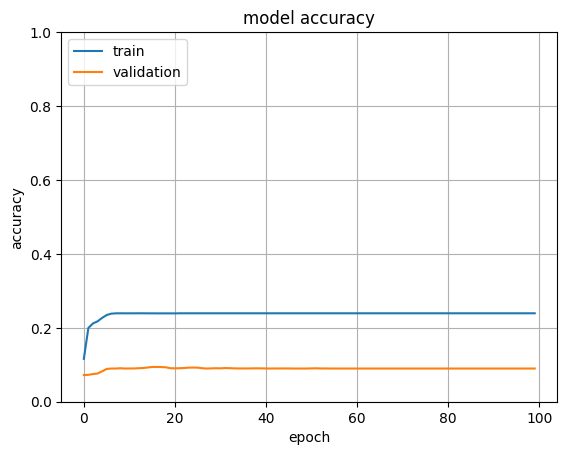

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.ylim((0,1))
    plt.grid()
    plt.show()


plot_hist(historial3)

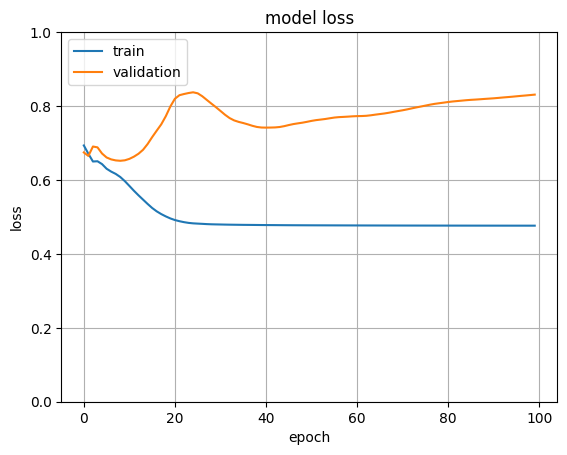

In [ ]:
def plot_hist_loss(hist):
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.ylim((0,1))
    plt.grid()
    plt.show()


plot_hist_loss(historial3)

1/1 [==============================] - 0s 255ms/step


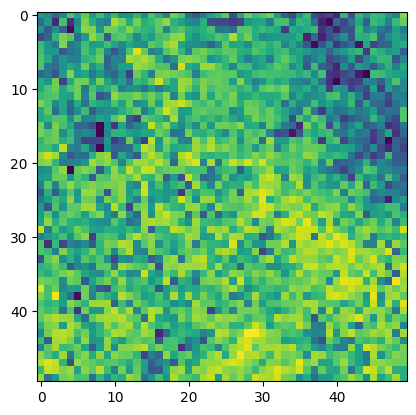

In [ ]:
salida = model3.predict(y_train)
plt.imshow(salida[2, :, :, 0])

## Convulcional 4

Aqui utilizamos callbacks con el modelo de dos canales

### X Y


In [ ]:
yc2 = reshaped_image_2

In [ ]:
Xc2 = reshaped_image2

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Xc2, yc2, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [ ]:
X_train.shape

(6, 50, 50, 2)

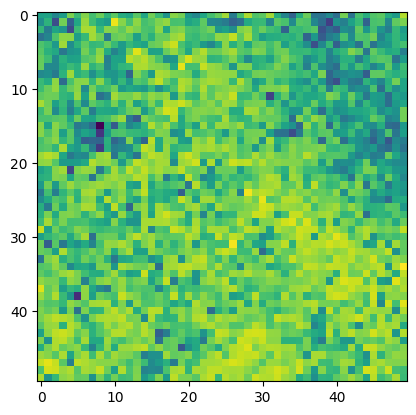

<Axes: >

In [ ]:
show(X_train[2, :, :, 0])

### Modelo

In [ ]:
# Define the neural network architecture
model4 = Sequential()

# Convolutional and max-pooling layers
model4.add(Conv2D(64, (3, 3), activation='relu', input_shape=(50, 50, 2)))  # Change input shape to (50, 50, 2)
model4.add(MaxPooling2D((2, 2)))
model4.add(Conv2D(128, (3, 3), activation='relu'))
model4.add(MaxPooling2D((2, 2)))

# Flatten layer
model4.add(Flatten())

# Fully connected layers
model4.add(Dense(2500, activation='sigmoid'))

# Reshape to 2D
model4.add(Reshape((50, 50, 1)))

# Compile the model
model4.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])

# Print model summary
model4.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 48, 48, 64)        1216      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 22, 22, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 11, 11, 128)       0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 15488)             0         
                                                                 
 dense_3 (Dense)             (None, 2500)             

In [ ]:
%time historial4 = model2.fit(X_train, X_train, epochs=100, batch_size=32, validation_data=(X_val, X_val), callbacks=[early_stop,reduce_lr])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.7188 - accuracy: 0.2892

1/1 [==============================] - 1s 1s/step - loss: 0.7188 - accuracy: 0.2892 - val_loss: 0.6836 - val_accuracy: 8.0000e-04 - lr: 0.0010
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.5653 - accuracy: 0.2894

1/1 [==============================] - 1s 1s/step - loss: 0.5653 - accuracy: 0.2894 - val_loss: 0.6923 - val_accuracy: 6.0000e-04 - lr: 0.0010
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.5595 - accuracy: 0.2894

1/1 [==============================] - 1s 1s/step - loss: 0.5595 - accuracy: 0.2894 - val_loss: 0.6683 - val_accuracy: 8.0000e-04 - lr: 0.0010
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.5200 - accuracy: 0.2895

1/1 [==============================] - 1s 1s/step - loss: 0.5200 - accuracy: 0.2895 - val_loss: 0.6764 - val_accuracy: 0.0012 - lr: 0.0010
Epoch 5/100
1/1 [==============================] - ETA: 0s - loss: 0.4967 - accuracy: 0.2876

1/1 [==============================] - 1s 1s/step - loss: 0.4967 - accuracy: 0.2876 - val_loss: 0.6834 - val_accuracy: 0.0014 - lr: 0.0010
Epoch 6/100
1/1 [==============================] - ETA: 0s - loss: 0.4953 - accuracy: 0.2864

1/1 [==============================] - 1s 1s/step - loss: 0.4953 - accuracy: 0.2864 - val_loss: 0.6752 - val_accuracy: 0.0014 - lr: 0.0010
Epoch 7/100
1/1 [==============================] - ETA: 0s - loss: 0.4965 - accuracy: 0.2868

1/1 [==============================] - 1s 1s/step - loss: 0.4965 - accuracy: 0.2868 - val_loss: 0.6650 - val_accuracy: 0.0014 - lr: 0.0010
Epoch 8/100
1/1 [==============================] - ETA: 0s - loss: 0.4947 - accuracy: 0.2879

1/1 [==============================] - 1s 1s/step - loss: 0.4947 - accuracy: 0.2879 - val_loss: 0.6593 - val_accuracy: 0.0014 - lr: 0.0010
Epoch 9/100
1/1 [==============================] - ETA: 0s - loss: 0.4901 - accuracy: 0.2890

1/1 [==============================] - 2s 2s/step - loss: 0.4901 - accuracy: 0.2890 - val_loss: 0.6565 - val_accuracy: 0.0014 - lr: 0.0010
Epoch 10/100
1/1 [==============================] - ETA: 0s - loss: 0.4845 - accuracy: 0.2896

1/1 [==============================] - 2s 2s/step - loss: 0.4845 - accuracy: 0.2896 - val_loss: 0.6553 - val_accuracy: 0.0014 - lr: 0.0010
Epoch 11/100
1/1 [==============================] - ETA: 0s - loss: 0.4797 - accuracy: 0.2896

1/1 [==============================] - 2s 2s/step - loss: 0.4797 - accuracy: 0.2896 - val_loss: 0.6545 - val_accuracy: 0.0012 - lr: 0.0010
Epoch 12/100
1/1 [==============================] - ETA: 0s - loss: 0.4760 - accuracy: 0.2896

1/1 [==============================] - 2s 2s/step - loss: 0.4760 - accuracy: 0.2896 - val_loss: 0.6539 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 13/100
1/1 [==============================] - ETA: 0s - loss: 0.4732 - accuracy: 0.2898

1/1 [==============================] - 2s 2s/step - loss: 0.4732 - accuracy: 0.2898 - val_loss: 0.6532 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 14/100
1/1 [==============================] - ETA: 0s - loss: 0.4711 - accuracy: 0.2898

1/1 [==============================] - 1s 1s/step - loss: 0.4711 - accuracy: 0.2898 - val_loss: 0.6525 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 15/100
1/1 [==============================] - ETA: 0s - loss: 0.4691 - accuracy: 0.2897

1/1 [==============================] - 1s 1s/step - loss: 0.4691 - accuracy: 0.2897 - val_loss: 0.6526 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 16/100
1/1 [==============================] - ETA: 0s - loss: 0.4673 - accuracy: 0.2897

1/1 [==============================] - 1s 1s/step - loss: 0.4673 - accuracy: 0.2897 - val_loss: 0.6535 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 17/100
1/1 [==============================] - ETA: 0s - loss: 0.4656 - accuracy: 0.2897

1/1 [==============================] - 1s 1s/step - loss: 0.4656 - accuracy: 0.2897 - val_loss: 0.6543 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 18/100
1/1 [==============================] - ETA: 0s - loss: 0.4638 - accuracy: 0.2897

1/1 [==============================] - 1s 1s/step - loss: 0.4638 - accuracy: 0.2897 - val_loss: 0.6539 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 19/100
1/1 [==============================] - ETA: 0s - loss: 0.4618 - accuracy: 0.2898

1/1 [==============================] - 1s 1s/step - loss: 0.4618 - accuracy: 0.2898 - val_loss: 0.6527 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 20/100
1/1 [==============================] - ETA: 0s - loss: 0.4600 - accuracy: 0.2898

1/1 [==============================] - 1s 1s/step - loss: 0.4600 - accuracy: 0.2898 - val_loss: 0.6518 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 21/100
1/1 [==============================] - ETA: 0s - loss: 0.4590 - accuracy: 0.2898

1/1 [==============================] - 1s 1s/step - loss: 0.4590 - accuracy: 0.2898 - val_loss: 0.6516 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 22/100
1/1 [==============================] - ETA: 0s - loss: 0.4587 - accuracy: 0.2898

1/1 [==============================] - 1s 1s/step - loss: 0.4587 - accuracy: 0.2898 - val_loss: 0.6517 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 23/100
1/1 [==============================] - ETA: 0s - loss: 0.4583 - accuracy: 0.2898

1/1 [==============================] - 2s 2s/step - loss: 0.4583 - accuracy: 0.2898 - val_loss: 0.6520 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 24/100
1/1 [==============================] - ETA: 0s - loss: 0.4576 - accuracy: 0.2898

1/1 [==============================] - 2s 2s/step - loss: 0.4576 - accuracy: 0.2898 - val_loss: 0.6523 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 25/100
1/1 [==============================] - ETA: 0s - loss: 0.4569 - accuracy: 0.2898

1/1 [==============================] - 2s 2s/step - loss: 0.4569 - accuracy: 0.2898 - val_loss: 0.6530 - val_accuracy: 8.0000e-04 - lr: 0.0010
Epoch 26/100
1/1 [==============================] - ETA: 0s - loss: 0.4564 - accuracy: 0.2898

1/1 [==============================] - 2s 2s/step - loss: 0.4564 - accuracy: 0.2898 - val_loss: 0.6536 - val_accuracy: 8.0000e-04 - lr: 0.0010
Epoch 27/100
1/1 [==============================] - ETA: 0s - loss: 0.4562 - accuracy: 0.2898

1/1 [==============================] - 2s 2s/step - loss: 0.4562 - accuracy: 0.2898 - val_loss: 0.6539 - val_accuracy: 8.0000e-04 - lr: 0.0010
Epoch 28/100
1/1 [==============================] - ETA: 0s - loss: 0.4562 - accuracy: 0.2898

1/1 [==============================] - 1s 1s/step - loss: 0.4562 - accuracy: 0.2898 - val_loss: 0.6536 - val_accuracy: 8.0000e-04 - lr: 0.0010
Epoch 29/100
1/1 [==============================] - ETA: 0s - loss: 0.4559 - accuracy: 0.2898

1/1 [==============================] - 1s 1s/step - loss: 0.4559 - accuracy: 0.2898 - val_loss: 0.6530 - val_accuracy: 8.0000e-04 - lr: 0.0010
Epoch 30/100
1/1 [==============================] - ETA: 0s - loss: 0.4556 - accuracy: 0.2898

1/1 [==============================] - 1s 1s/step - loss: 0.4556 - accuracy: 0.2898 - val_loss: 0.6523 - val_accuracy: 8.0000e-04 - lr: 0.0010
Epoch 31/100
1/1 [==============================] - ETA: 0s - loss: 0.4554 - accuracy: 0.2898

1/1 [==============================] - 1s 1s/step - loss: 0.4554 - accuracy: 0.2898 - val_loss: 0.6520 - val_accuracy: 8.0000e-04 - lr: 0.0010
Epoch 32/100
1/1 [==============================] - ETA: 0s - loss: 0.4553 - accuracy: 0.2898

1/1 [==============================] - 1s 1s/step - loss: 0.4553 - accuracy: 0.2898 - val_loss: 0.6518 - val_accuracy: 8.0000e-04 - lr: 0.0010
Epoch 33/100
1/1 [==============================] - ETA: 0s - loss: 0.4552 - accuracy: 0.2898

1/1 [==============================] - 1s 1s/step - loss: 0.4552 - accuracy: 0.2898 - val_loss: 0.6516 - val_accuracy: 8.0000e-04 - lr: 0.0010
Epoch 34/100
1/1 [==============================] - ETA: 0s - loss: 0.4550 - accuracy: 0.2898

1/1 [==============================] - 1s 1s/step - loss: 0.4550 - accuracy: 0.2898 - val_loss: 0.6515 - val_accuracy: 8.0000e-04 - lr: 0.0010
Epoch 35/100
1/1 [==============================] - ETA: 0s - loss: 0.4547 - accuracy: 0.2898

1/1 [==============================] - 1s 1s/step - loss: 0.4547 - accuracy: 0.2898 - val_loss: 0.6517 - val_accuracy: 8.0000e-04 - lr: 0.0010
Epoch 36/100
1/1 [==============================] - ETA: 0s - loss: 0.4545 - accuracy: 0.2898

1/1 [==============================] - 2s 2s/step - loss: 0.4545 - accuracy: 0.2898 - val_loss: 0.6520 - val_accuracy: 8.0000e-04 - lr: 0.0010
Epoch 37/100
1/1 [==============================] - ETA: 0s - loss: 0.4544 - accuracy: 0.2898

1/1 [==============================] - 2s 2s/step - loss: 0.4544 - accuracy: 0.2898 - val_loss: 0.6520 - val_accuracy: 8.0000e-04 - lr: 0.0010
Epoch 38/100
1/1 [==============================] - ETA: 0s - loss: 0.4543 - accuracy: 0.2898

1/1 [==============================] - 2s 2s/step - loss: 0.4543 - accuracy: 0.2898 - val_loss: 0.6517 - val_accuracy: 8.0000e-04 - lr: 0.0010
Epoch 39/100
1/1 [==============================] - ETA: 0s - loss: 0.4542 - accuracy: 0.2898

1/1 [==============================] - 2s 2s/step - loss: 0.4542 - accuracy: 0.2898 - val_loss: 0.6511 - val_accuracy: 8.0000e-04 - lr: 0.0010
Epoch 40/100
1/1 [==============================] - ETA: 0s - loss: 0.4540 - accuracy: 0.2898

1/1 [==============================] - 2s 2s/step - loss: 0.4540 - accuracy: 0.2898 - val_loss: 0.6505 - val_accuracy: 8.0000e-04 - lr: 0.0010
Epoch 41/100
1/1 [==============================] - ETA: 0s - loss: 0.4539 - accuracy: 0.2898

1/1 [==============================] - 2s 2s/step - loss: 0.4539 - accuracy: 0.2898 - val_loss: 0.6501 - val_accuracy: 8.0000e-04 - lr: 0.0010
Epoch 42/100
1/1 [==============================] - ETA: 0s - loss: 0.4538 - accuracy: 0.2898

1/1 [==============================] - 1s 1s/step - loss: 0.4538 - accuracy: 0.2898 - val_loss: 0.6499 - val_accuracy: 8.0000e-04 - lr: 0.0010
Epoch 43/100
1/1 [==============================] - ETA: 0s - loss: 0.4538 - accuracy: 0.2898

1/1 [==============================] - 1s 1s/step - loss: 0.4538 - accuracy: 0.2898 - val_loss: 0.6498 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 44/100
1/1 [==============================] - ETA: 0s - loss: 0.4536 - accuracy: 0.2898

1/1 [==============================] - 1s 1s/step - loss: 0.4536 - accuracy: 0.2898 - val_loss: 0.6497 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 45/100
1/1 [==============================] - ETA: 0s - loss: 0.4535 - accuracy: 0.2898

1/1 [==============================] - 1s 1s/step - loss: 0.4535 - accuracy: 0.2898 - val_loss: 0.6495 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 46/100
1/1 [==============================] - ETA: 0s - loss: 0.4535 - accuracy: 0.2898

1/1 [==============================] - 1s 1s/step - loss: 0.4535 - accuracy: 0.2898 - val_loss: 0.6492 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 47/100
1/1 [==============================] - ETA: 0s - loss: 0.4534 - accuracy: 0.2898

1/1 [==============================] - 1s 1s/step - loss: 0.4534 - accuracy: 0.2898 - val_loss: 0.6487 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 48/100
1/1 [==============================] - ETA: 0s - loss: 0.4534 - accuracy: 0.2898

1/1 [==============================] - 1s 1s/step - loss: 0.4534 - accuracy: 0.2898 - val_loss: 0.6482 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 49/100
1/1 [==============================] - ETA: 0s - loss: 0.4533 - accuracy: 0.2898

1/1 [==============================] - 1s 1s/step - loss: 0.4533 - accuracy: 0.2898 - val_loss: 0.6479 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 50/100
1/1 [==============================] - ETA: 0s - loss: 0.4532 - accuracy: 0.2898

1/1 [==============================] - 1s 1s/step - loss: 0.4532 - accuracy: 0.2898 - val_loss: 0.6477 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 51/100
1/1 [==============================] - ETA: 0s - loss: 0.4532 - accuracy: 0.2898

1/1 [==============================] - 2s 2s/step - loss: 0.4532 - accuracy: 0.2898 - val_loss: 0.6476 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 52/100
1/1 [==============================] - ETA: 0s - loss: 0.4531 - accuracy: 0.2898

1/1 [==============================] - 2s 2s/step - loss: 0.4531 - accuracy: 0.2898 - val_loss: 0.6477 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 53/100
1/1 [==============================] - ETA: 0s - loss: 0.4531 - accuracy: 0.2898

1/1 [==============================] - 2s 2s/step - loss: 0.4531 - accuracy: 0.2898 - val_loss: 0.6477 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 54/100
1/1 [==============================] - ETA: 0s - loss: 0.4531 - accuracy: 0.2898

1/1 [==============================] - 2s 2s/step - loss: 0.4531 - accuracy: 0.2898 - val_loss: 0.6477 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 55/100
1/1 [==============================] - ETA: 0s - loss: 0.4530 - accuracy: 0.2898

1/1 [==============================] - 2s 2s/step - loss: 0.4530 - accuracy: 0.2898 - val_loss: 0.6475 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 56/100
1/1 [==============================] - ETA: 0s - loss: 0.4530 - accuracy: 0.2898

1/1 [==============================] - 2s 2s/step - loss: 0.4530 - accuracy: 0.2898 - val_loss: 0.6472 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 57/100
1/1 [==============================] - ETA: 0s - loss: 0.4529 - accuracy: 0.2898

1/1 [==============================] - 2s 2s/step - loss: 0.4529 - accuracy: 0.2898 - val_loss: 0.6470 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 58/100
1/1 [==============================] - ETA: 0s - loss: 0.4529 - accuracy: 0.2898

1/1 [==============================] - 2s 2s/step - loss: 0.4529 - accuracy: 0.2898 - val_loss: 0.6469 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 59/100
1/1 [==============================] - ETA: 0s - loss: 0.4529 - accuracy: 0.2898

1/1 [==============================] - 2s 2s/step - loss: 0.4529 - accuracy: 0.2898 - val_loss: 0.6470 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 60/100
1/1 [==============================] - ETA: 0s - loss: 0.4528 - accuracy: 0.2898

1/1 [==============================] - 2s 2s/step - loss: 0.4528 - accuracy: 0.2898 - val_loss: 0.6471 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 61/100
1/1 [==============================] - ETA: 0s - loss: 0.4528 - accuracy: 0.2898

1/1 [==============================] - 2s 2s/step - loss: 0.4528 - accuracy: 0.2898 - val_loss: 0.6471 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 62/100
1/1 [==============================] - ETA: 0s - loss: 0.4528 - accuracy: 0.2898

1/1 [==============================] - 3s 3s/step - loss: 0.4528 - accuracy: 0.2898 - val_loss: 0.6470 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 63/100
1/1 [==============================] - ETA: 0s - loss: 0.4527 - accuracy: 0.2898

1/1 [==============================] - 3s 3s/step - loss: 0.4527 - accuracy: 0.2898 - val_loss: 0.6469 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 64/100
1/1 [==============================] - ETA: 0s - loss: 0.4527 - accuracy: 0.2898

1/1 [==============================] - 3s 3s/step - loss: 0.4527 - accuracy: 0.2898 - val_loss: 0.6467 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 65/100
1/1 [==============================] - ETA: 0s - loss: 0.4527 - accuracy: 0.2898

1/1 [==============================] - 2s 2s/step - loss: 0.4527 - accuracy: 0.2898 - val_loss: 0.6467 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 66/100
1/1 [==============================] - ETA: 0s - loss: 0.4526 - accuracy: 0.2898

1/1 [==============================] - 2s 2s/step - loss: 0.4526 - accuracy: 0.2898 - val_loss: 0.6467 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 67/100
1/1 [==============================] - ETA: 0s - loss: 0.4526 - accuracy: 0.2898

1/1 [==============================] - 2s 2s/step - loss: 0.4526 - accuracy: 0.2898 - val_loss: 0.6467 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 68/100
1/1 [==============================] - ETA: 0s - loss: 0.4526 - accuracy: 0.2898

1/1 [==============================] - 2s 2s/step - loss: 0.4526 - accuracy: 0.2898 - val_loss: 0.6466 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 69/100
1/1 [==============================] - ETA: 0s - loss: 0.4526 - accuracy: 0.2898

1/1 [==============================] - 2s 2s/step - loss: 0.4526 - accuracy: 0.2898 - val_loss: 0.6464 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 70/100
1/1 [==============================] - ETA: 0s - loss: 0.4525 - accuracy: 0.2898

1/1 [==============================] - 3s 3s/step - loss: 0.4525 - accuracy: 0.2898 - val_loss: 0.6463 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 71/100
1/1 [==============================] - ETA: 0s - loss: 0.4525 - accuracy: 0.2898

1/1 [==============================] - 3s 3s/step - loss: 0.4525 - accuracy: 0.2898 - val_loss: 0.6462 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 72/100
1/1 [==============================] - ETA: 0s - loss: 0.4525 - accuracy: 0.2898

1/1 [==============================] - 2s 2s/step - loss: 0.4525 - accuracy: 0.2898 - val_loss: 0.6462 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 73/100
1/1 [==============================] - ETA: 0s - loss: 0.4524 - accuracy: 0.2898

1/1 [==============================] - 2s 2s/step - loss: 0.4524 - accuracy: 0.2898 - val_loss: 0.6462 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 74/100
1/1 [==============================] - ETA: 0s - loss: 0.4524 - accuracy: 0.2898

1/1 [==============================] - 2s 2s/step - loss: 0.4524 - accuracy: 0.2898 - val_loss: 0.6461 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 75/100
1/1 [==============================] - ETA: 0s - loss: 0.4524 - accuracy: 0.2898

1/1 [==============================] - 1s 1s/step - loss: 0.4524 - accuracy: 0.2898 - val_loss: 0.6459 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 76/100
1/1 [==============================] - ETA: 0s - loss: 0.4524 - accuracy: 0.2898

1/1 [==============================] - 1s 1s/step - loss: 0.4524 - accuracy: 0.2898 - val_loss: 0.6458 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 77/100
1/1 [==============================] - ETA: 0s - loss: 0.4523 - accuracy: 0.2898

1/1 [==============================] - 1s 1s/step - loss: 0.4523 - accuracy: 0.2898 - val_loss: 0.6457 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 78/100
1/1 [==============================] - ETA: 0s - loss: 0.4523 - accuracy: 0.2898

1/1 [==============================] - 1s 1s/step - loss: 0.4523 - accuracy: 0.2898 - val_loss: 0.6456 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 79/100
1/1 [==============================] - ETA: 0s - loss: 0.4523 - accuracy: 0.2898

1/1 [==============================] - 1s 1s/step - loss: 0.4523 - accuracy: 0.2898 - val_loss: 0.6455 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 80/100
1/1 [==============================] - ETA: 0s - loss: 0.4522 - accuracy: 0.2898

1/1 [==============================] - 1s 1s/step - loss: 0.4522 - accuracy: 0.2898 - val_loss: 0.6455 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 81/100
1/1 [==============================] - ETA: 0s - loss: 0.4522 - accuracy: 0.2898

1/1 [==============================] - 1s 1s/step - loss: 0.4522 - accuracy: 0.2898 - val_loss: 0.6453 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 82/100
1/1 [==============================] - ETA: 0s - loss: 0.4522 - accuracy: 0.2898

1/1 [==============================] - 1s 1s/step - loss: 0.4522 - accuracy: 0.2898 - val_loss: 0.6452 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 83/100
1/1 [==============================] - ETA: 0s - loss: 0.4522 - accuracy: 0.2898

1/1 [==============================] - 2s 2s/step - loss: 0.4522 - accuracy: 0.2898 - val_loss: 0.6451 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 84/100
1/1 [==============================] - ETA: 0s - loss: 0.4521 - accuracy: 0.2898

1/1 [==============================] - 2s 2s/step - loss: 0.4521 - accuracy: 0.2898 - val_loss: 0.6450 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 85/100
1/1 [==============================] - ETA: 0s - loss: 0.4521 - accuracy: 0.2898

1/1 [==============================] - 2s 2s/step - loss: 0.4521 - accuracy: 0.2898 - val_loss: 0.6449 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 86/100
1/1 [==============================] - ETA: 0s - loss: 0.4521 - accuracy: 0.2898

1/1 [==============================] - 2s 2s/step - loss: 0.4521 - accuracy: 0.2898 - val_loss: 0.6449 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 87/100
1/1 [==============================] - ETA: 0s - loss: 0.4521 - accuracy: 0.2898

1/1 [==============================] - 2s 2s/step - loss: 0.4521 - accuracy: 0.2898 - val_loss: 0.6448 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 88/100
1/1 [==============================] - ETA: 0s - loss: 0.4520 - accuracy: 0.2898

1/1 [==============================] - 1s 1s/step - loss: 0.4520 - accuracy: 0.2898 - val_loss: 0.6447 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 89/100
1/1 [==============================] - ETA: 0s - loss: 0.4520 - accuracy: 0.2898

1/1 [==============================] - 1s 1s/step - loss: 0.4520 - accuracy: 0.2898 - val_loss: 0.6446 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 90/100
1/1 [==============================] - ETA: 0s - loss: 0.4520 - accuracy: 0.2898

1/1 [==============================] - 1s 1s/step - loss: 0.4520 - accuracy: 0.2898 - val_loss: 0.6446 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 91/100
1/1 [==============================] - ETA: 0s - loss: 0.4520 - accuracy: 0.2898

1/1 [==============================] - 1s 1s/step - loss: 0.4520 - accuracy: 0.2898 - val_loss: 0.6445 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 92/100
1/1 [==============================] - ETA: 0s - loss: 0.4519 - accuracy: 0.2898

1/1 [==============================] - 1s 1s/step - loss: 0.4519 - accuracy: 0.2898 - val_loss: 0.6444 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 93/100
1/1 [==============================] - ETA: 0s - loss: 0.4519 - accuracy: 0.2898

1/1 [==============================] - 1s 1s/step - loss: 0.4519 - accuracy: 0.2898 - val_loss: 0.6443 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 94/100
1/1 [==============================] - ETA: 0s - loss: 0.4519 - accuracy: 0.2898

1/1 [==============================] - 1s 1s/step - loss: 0.4519 - accuracy: 0.2898 - val_loss: 0.6443 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 95/100
1/1 [==============================] - ETA: 0s - loss: 0.4519 - accuracy: 0.2898

1/1 [==============================] - 1s 1s/step - loss: 0.4519 - accuracy: 0.2898 - val_loss: 0.6442 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 96/100
1/1 [==============================] - ETA: 0s - loss: 0.4518 - accuracy: 0.2898

1/1 [==============================] - 1s 1s/step - loss: 0.4518 - accuracy: 0.2898 - val_loss: 0.6442 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 97/100
1/1 [==============================] - ETA: 0s - loss: 0.4518 - accuracy: 0.2898

1/1 [==============================] - 2s 2s/step - loss: 0.4518 - accuracy: 0.2898 - val_loss: 0.6441 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 98/100
1/1 [==============================] - ETA: 0s - loss: 0.4518 - accuracy: 0.2898

1/1 [==============================] - 2s 2s/step - loss: 0.4518 - accuracy: 0.2898 - val_loss: 0.6440 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 99/100
1/1 [==============================] - ETA: 0s - loss: 0.4518 - accuracy: 0.2898

1/1 [==============================] - 2s 2s/step - loss: 0.4518 - accuracy: 0.2898 - val_loss: 0.6440 - val_accuracy: 0.0010 - lr: 0.0010
Epoch 100/100
1/1 [==============================] - ETA: 0s - loss: 0.4518 - accuracy: 0.2898

1/1 [==============================] - 2s 2s/step - loss: 0.4518 - accuracy: 0.2898 - val_loss: 0.6439 - val_accuracy: 0.0010 - lr: 0.0010
CPU times: user 2min 42s, sys: 44.9 s, total: 3min 27s
Wall time: 3min 22s


In [ ]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.ylim((0,1))
    plt.grid()
    plt.show()


plot_hist(historial4)

NameError: ignored

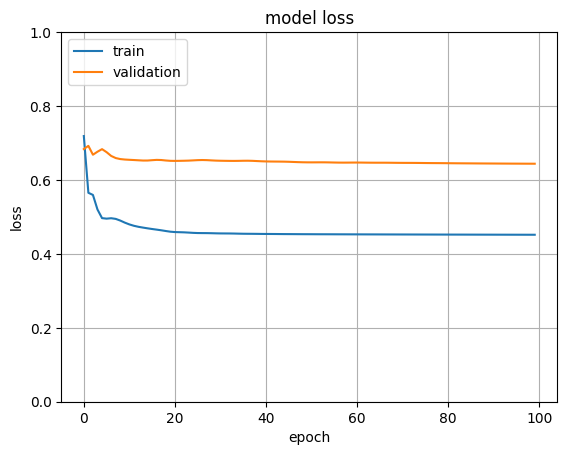

In [ ]:
def plot_hist_loss(hist):
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.ylim((0,1))
    plt.grid()
    plt.show()


plot_hist_loss(historial4)

1/1 [==============================] - 0s 179ms/step


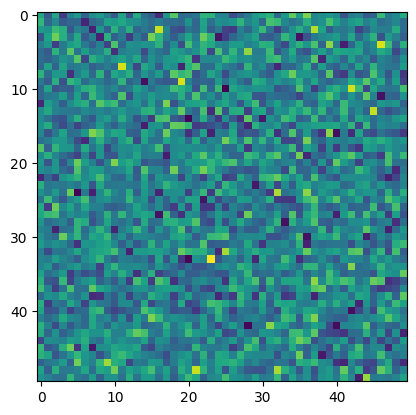

In [ ]:
salida = model4.predict(X_train)
plt.imshow(salida[0, :, :, 0])

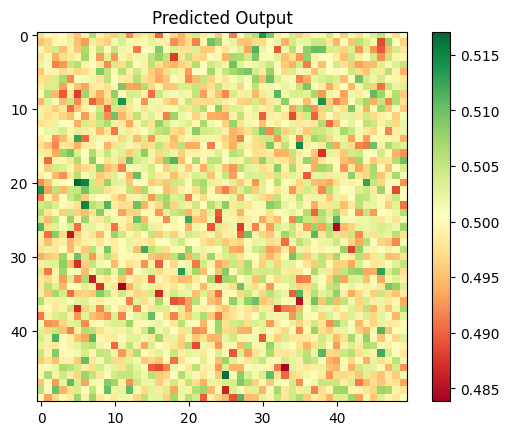

Predicted Image Range: 0.033230990171432495


In [ ]:
# Display the predicted output (1st sample) using matplotlib
plt.imshow(salida[5, :, :, 0], cmap='RdYlGn')  # Assuming it's a grayscale image
plt.colorbar()
plt.title('Predicted Output')
plt.show()

# Get the range of the predicted image
predicted_range = np.ptp(salida[5, :, :, 0])  # Peak-to-peak (max-min) value
print(f"Predicted Image Range: {predicted_range}")

## Comparación un canal vs dos canales

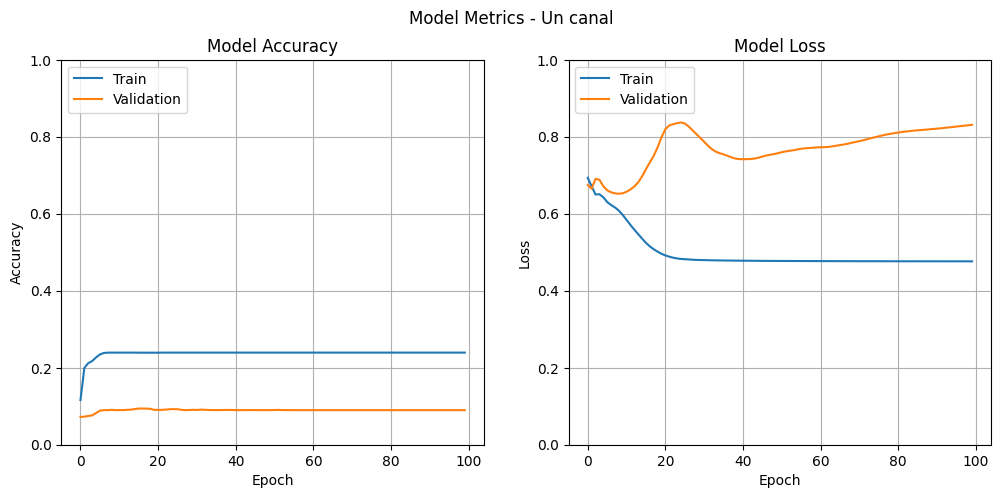

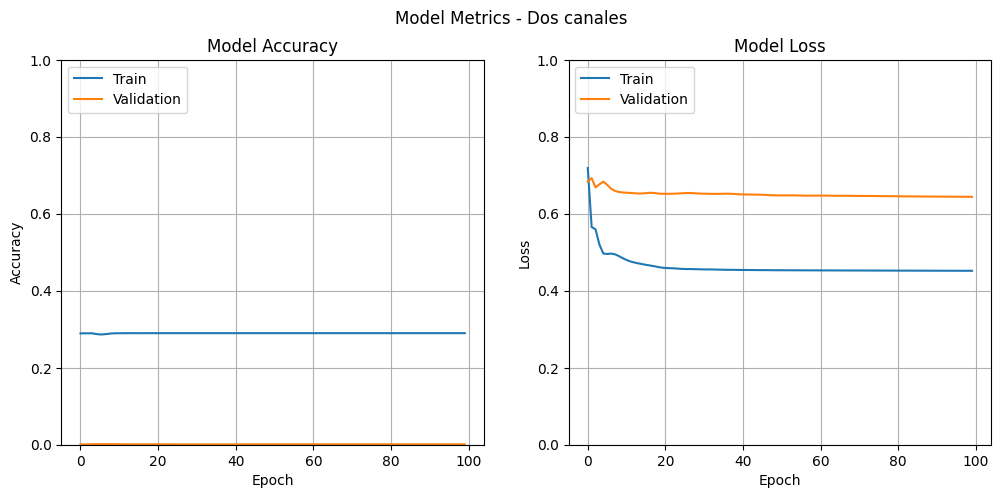

In [ ]:
def plot_metrics(hist, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot accuracy
    ax1.plot(hist.history["accuracy"])
    ax1.plot(hist.history["val_accuracy"])
    ax1.set_title("Model Accuracy")
    ax1.set_ylabel("Accuracy")
    ax1.set_xlabel("Epoch")
    ax1.legend(["Train", "Validation"], loc="upper left")
    ax1.set_ylim((0, 1))
    ax1.grid()

    # Plot loss
    ax2.plot(hist.history["loss"])
    ax2.plot(hist.history["val_loss"])
    ax2.set_title("Model Loss")
    ax2.set_ylabel("Loss")
    ax2.set_xlabel("Epoch")
    ax2.legend(["Train", "Validation"], loc="upper left")
    ax2.set_ylim((0, 1))
    ax2.grid()

    plt.suptitle(title)
    plt.show()

# Example usage:
# Assuming you have historial and historial2
plot_metrics(historial3, "Model Metrics - Un canal")
plot_metrics(historial4, "Model Metrics - Dos canales")


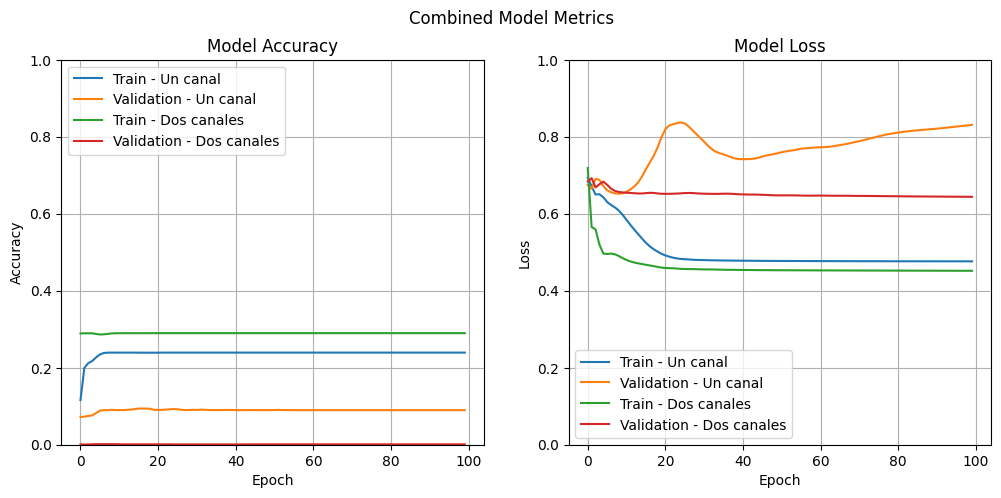

In [ ]:
def plot_combined_metrics(hist1, hist2, title):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot accuracy
    axes[0].plot(hist1.history["accuracy"], label="Train - Un canal")
    axes[0].plot(hist1.history["val_accuracy"], label="Validation - Un canal")
    axes[0].plot(hist2.history["accuracy"], label="Train - Dos canales")
    axes[0].plot(hist2.history["val_accuracy"], label="Validation - Dos canales")
    axes[0].set_title("Model Accuracy")
    axes[0].set_ylabel("Accuracy")
    axes[0].set_xlabel("Epoch")
    axes[0].legend(loc="upper left")
    axes[0].set_ylim((0, 1))
    axes[0].grid()

    # Plot loss
    axes[1].plot(hist1.history["loss"], label="Train - Un canal")
    axes[1].plot(hist1.history["val_loss"], label="Validation - Un canal")
    axes[1].plot(hist2.history["loss"], label="Train - Dos canales")
    axes[1].plot(hist2.history["val_loss"], label="Validation - Dos canales")
    axes[1].set_title("Model Loss")
    axes[1].set_ylabel("Loss")
    axes[1].set_xlabel("Epoch")
    axes[1].legend(loc="lower left")
    axes[1].set_ylim((0, 1))
    axes[1].grid()

    plt.suptitle(title)
    plt.show()

# Example usage:
# Assuming you have historial and historial2
plot_combined_metrics(historial3, historial4, "Combined Model Metrics")

# Distintos LR y optimizadores

Aqui el modelo trabajara con distintos LR y optimizadores

## Convulcional 5

Aqui utilizamos los callbacks con un solo canal

### X Y

In [ ]:
ylr = reshaped_image_2

In [ ]:
Xlr = reshaped_image

In [ ]:
# Assuming reshaped_image is your features and y is your labels
X_train, X_test, y_train, y_test = train_test_split(Xc, yc, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)


In [ ]:
y_train.shape

(6, 50, 50, 1)

In [ ]:
y_val.shape

(2, 50, 50, 1)

In [ ]:
X_train.shape

(6, 50, 50, 1)

In [ ]:
X_val.shape

(2, 50, 50, 1)

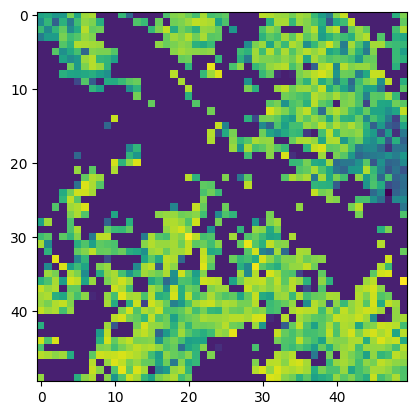

<Axes: >

In [ ]:
show(X_train[4, :, :, 0])

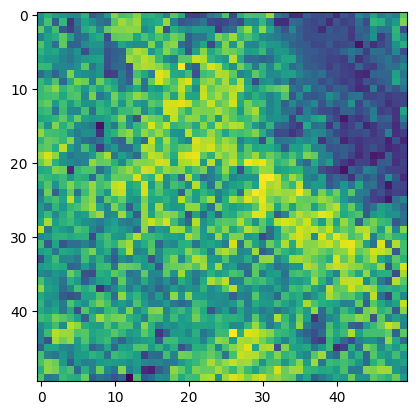

<Axes: >

In [ ]:
show(X_val[1, :, :, 0])

### Modelo

In [ ]:
# Define the neural network architecture
model5 = Sequential()
model5.add(Conv2D(64, (3, 3), activation='relu', input_shape=(50, 50, 1)))
model5.add(MaxPooling2D((2, 2)))
model5.add(Conv2D(128, (3, 3), activation='relu'))
model5.add(MaxPooling2D((2, 2)))
model5.add(Flatten())
model5.add(Dense(2500, activation='sigmoid'))
model5.add(Reshape((50, 50, 1)))

model5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 22, 22, 128)       73856     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 11, 11, 128)       0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 15488)             0         
                                                                 
 dense_4 (Dense)             (None, 2500)             

In [ ]:
# Configura el modelo inicial
config_inicial = model5.get_config()
weights_inicial = model5.get_weights()

In [ ]:
# Parámetros para la búsqueda de hiperparámetros
learning_rates = [0.0001, 0.001, 0.01, 0.1,]
batch_sizes = [16, 32, 64]
optimizers = [
    tf.keras.optimizers.legacy.Adam()
]
#    keras.optimizers.SGD(),     keras.optimizers.SGD(momentum=0.9),    keras.optimizers.Nadam()

In [ ]:
# Mejores parámetros y resultados iniciales
mejores_parametros_val = {
    'loss': float('inf'),
    'lr': None,
    'opt': None,
    'batch_size': None
}

t = time.time()
contador = 0
ind = 1

total_combinations = len(learning_rates) * len(batch_sizes) * len(optimizers)

for lr in learning_rates:
    for batch_s in batch_sizes:
        for opt in optimizers:
            contador += 1

            # Crea un nuevo modelo en cada iteración y configura pesos
            model = Sequential.from_config(config_inicial)
            model.set_weights(weights_inicial)

            model.compile(optimizer=opt, loss='mse', metrics="accuracy")

            pbar = tqdm(total=100, desc=f'Combinación {contador}/{total_combinations}', unit='epoch', position=0, leave=True)
            for epoch in range(100):
                historial5 = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1, verbose=0, batch_size=batch_s)
                pbar.update(1)
                pbar.set_postfix(loss=historial5.history['loss'][0], val_loss=historial5.history['val_loss'][0])
            pbar.close()

            pred = model.evaluate(X_val, y_val, verbose=0)

            if pred[0] < mejores_parametros_val['loss']:
                        mejores_parametros_val['loss'] = pred[0]
                        mejores_parametros_val['lr'] = lr
                        mejores_parametros_val['opt'] = opt
                        mejores_parametros_val['batch_size'] = batch_s
    print(contador, ') VAL  lr=', lr, ', opt=', opt, 'batch_size=', batch_s, 'loss=', pred[0])
    if pred[0] == 0.0:
        print("Entrenamiento completo :) ")
        ind = 0
        break


        if ind == 0:
            break

    if ind == 0:
        break

print(f'Tiempo de entrenamiento {(time.time() - t)/60:.5f} mins')


Combinación 3/12: 100%|██████████| 100/100 [02:33<00:00,  1.54s/epoch, loss=0.00134, val_loss=0.0761]


3 ) VAL  lr= 0.0001 , opt= <keras.src.optimizers.legacy.adam.Adam object at 0x7ab81653efe0> batch_size= 64 loss= 0.07610582560300827


Combinación 6/12: 100%|██████████| 100/100 [02:35<00:00,  1.55s/epoch, loss=0.00114, val_loss=0.0725]


6 ) VAL  lr= 0.001 , opt= <keras.src.optimizers.legacy.adam.Adam object at 0x7ab81653efe0> batch_size= 64 loss= 0.07247704267501831


Combinación 9/12: 100%|██████████| 100/100 [02:34<00:00,  1.55s/epoch, loss=0.00151, val_loss=0.0829]


9 ) VAL  lr= 0.01 , opt= <keras.src.optimizers.legacy.adam.Adam object at 0x7ab81653efe0> batch_size= 64 loss= 0.08288625627756119


Combinación 12/12: 100%|██████████| 100/100 [02:35<00:00,  1.55s/epoch, loss=0.00175, val_loss=0.0683]

12 ) VAL  lr= 0.1 , opt= <keras.src.optimizers.legacy.adam.Adam object at 0x7ab81653efe0> batch_size= 64 loss= 0.06834541261196136
Tiempo de entrenamiento 30.69112 mins


In [ ]:
# Mejores parámetros y resultados iniciales
mejores_parametros_val = {
    'loss': float('inf'),
    'lr': None,
    'opt': None,
    'batch_size': None
}

In [ ]:
mejores_parametros_val

{'loss': inf, 'lr': None, 'opt': None, 'batch_size': None}

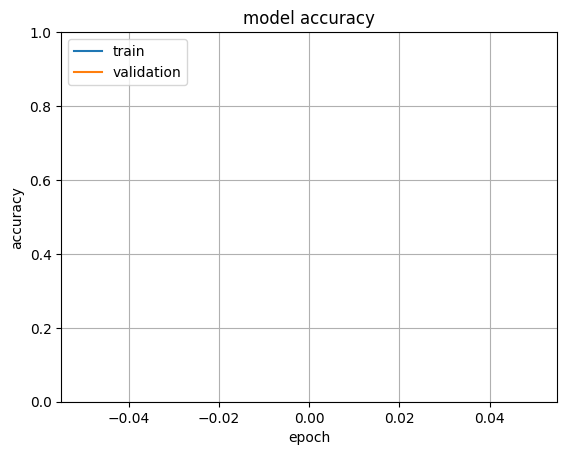

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.ylim((0,1))
    plt.grid()
    plt.show()


plot_hist(historial5)

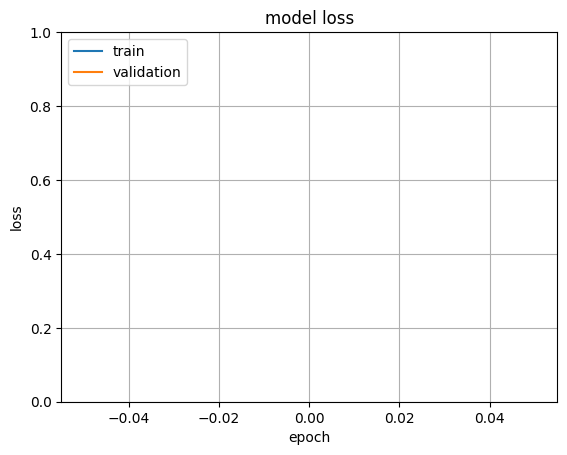

In [ ]:
def plot_hist_loss(hist):
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.ylim((0,1))
    plt.grid()
    plt.show()


plot_hist_loss(historial5)

1/1 [==============================] - 0s 167ms/step


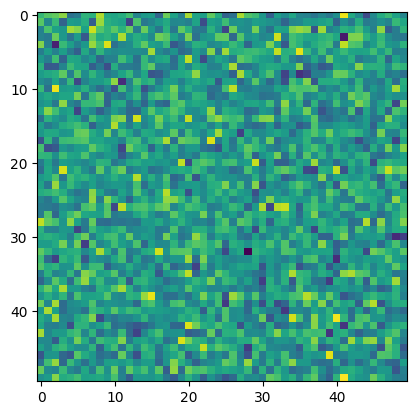

In [ ]:
salida = model5.predict(y_train)
plt.imshow(salida[2, :, :, 0])

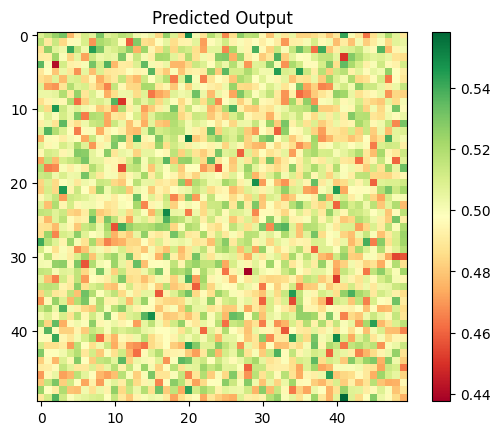

Predicted Image Range: 0.12083372473716736


In [ ]:
# Display the predicted output (1st sample) using matplotlib
plt.imshow(salida[4, :, :, 0], cmap='RdYlGn')  # Assuming it's a grayscale image
plt.colorbar()
plt.title('Predicted Output')
plt.show()

# Get the range of the predicted image
predicted_range = np.ptp(salida[4, :, :, 0])  # Peak-to-peak (max-min) value
print(f"Predicted Image Range: {predicted_range}")

## Convulcional 6

Aqui utilizamos callbacks con el modelo de dos canales

### X Y


In [ ]:
ylr2 = reshaped_image_2

In [ ]:
Xlr2 = reshaped_image2

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Xlr2, ylr2, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [ ]:
 X_val.shape

(2, 50, 50, 2)

In [ ]:
X_test.shape

(2, 50, 50, 2)

In [ ]:
X_train.shape

(6, 50, 50, 2)

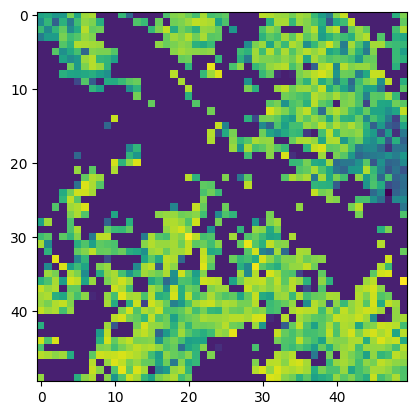

<Axes: >

In [ ]:
show(X_train[2, :, :, 0])

### Modelo

In [ ]:
# Define the neural network architecture
model6 = Sequential()
model6.add(Conv2D(64, (3, 3), activation='relu', input_shape=(50, 50, 2)))
model6.add(MaxPooling2D((2, 2)))
model6.add(Conv2D(128, (3, 3), activation='relu'))
model6.add(MaxPooling2D((2, 2)))
model6.add(Flatten())
model6.add(Dense(2500, activation='sigmoid'))
model6.add(Reshape((50, 50, 1)))

model6.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 64)        1216      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 22, 22, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 11, 11, 128)       0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 15488)             0         
                                                                 
 dense_2 (Dense)             (None, 2500)             

In [ ]:
# Configura el modelo inicial
config_inicial = model6.get_config()
weights_inicial = model6.get_weights()

In [ ]:
# Parámetros para la búsqueda de hiperparámetros
learning_rates = [0.0001, 0.001, 0.01, 0.1,]
batch_sizes = [16, 32, 64]
optimizers = [
    tf.keras.optimizers.legacy.Adam()
]

In [ ]:
# Mejores parámetros y resultados iniciales
mejores_parametros_val = {
    'loss': float('inf'),
    'lr': None,
    'opt': None,
    'batch_size': None
}

In [ ]:
# Mejores parámetros y resultados iniciales
mejores_parametros_val = {
    'loss': float('inf'),
    'lr': None,
    'opt': None,
    'batch_size': None
}

t = time.time()
contador = 0
ind = 1

total_combinations = len(learning_rates) * len(batch_sizes) * len(optimizers)

for lr in learning_rates:
    for batch_s in batch_sizes:
        for opt in optimizers:
            contador += 1

            # Crea un nuevo modelo en cada iteración y configura pesos
            model = Sequential.from_config(config_inicial)
            model.set_weights(weights_inicial)

            model.compile(optimizer=opt, loss='mse', metrics="accuracy")

            pbar = tqdm(total=100, desc=f'Combinación {contador}/{total_combinations}', unit='epoch', position=0, leave=True)
            for epoch in range(100):
                %time historial5 = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1, verbose=0, batch_size=batch_s)
                pbar.update(1)
                pbar.set_postfix(loss=historial5.history['loss'][0], val_loss=historial5.history['val_loss'][0])
            pbar.close()

            pred = model.evaluate(X_val, y_val, verbose=0)

            if pred[0] < mejores_parametros_val['loss']:
                mejores_parametros_val['loss'] = pred[0]
                mejores_parametros_val['lr'] = lr
                mejores_parametros_val['opt'] = opt
                mejores_parametros_val['batch_size'] = batch_s

            print(contador, ') VAL  lr=', lr, ', opt=', opt, 'batch_size=', batch_s, 'loss=', pred[0])
            if pred[0] == 0.0:
                print("Entrenamiento completo :) ")
                ind = 0
                break

        if ind == 0:
            break

    if ind == 0:
        break

print(f'Tiempo de entrenamiento {(time.time() - t)/60:.5f} mins')


Combinación 1/12:   1%|          | 1/100 [00:01<03:10,  1.92s/epoch, loss=0.0888, val_loss=0.0378]

CPU times: user 2.16 s, sys: 516 ms, total: 2.68 s
Wall time: 1.92 s


Combinación 1/12:   2%|▏         | 2/100 [00:03<02:35,  1.58s/epoch, loss=0.076, val_loss=0.0344] 

CPU times: user 1.28 s, sys: 247 ms, total: 1.53 s
Wall time: 1.33 s


Combinación 1/12:   3%|▎         | 3/100 [00:04<02:20,  1.45s/epoch, loss=0.0653, val_loss=0.0465]

CPU times: user 1.12 s, sys: 250 ms, total: 1.37 s
Wall time: 1.28 s


Combinación 1/12:   4%|▍         | 4/100 [00:05<02:15,  1.41s/epoch, loss=0.065, val_loss=0.0477] 

CPU times: user 1.1 s, sys: 246 ms, total: 1.34 s
Wall time: 1.36 s


Combinación 1/12:   5%|▌         | 5/100 [00:07<02:14,  1.41s/epoch, loss=0.0621, val_loss=0.0414]

CPU times: user 1.17 s, sys: 251 ms, total: 1.42 s
Wall time: 1.4 s


Combinación 1/12:   6%|▌         | 6/100 [00:08<02:10,  1.39s/epoch, loss=0.056, val_loss=0.0355] 

CPU times: user 1.11 s, sys: 226 ms, total: 1.34 s
Wall time: 1.33 s


Combinación 1/12:   7%|▋         | 7/100 [00:10<02:10,  1.40s/epoch, loss=0.0507, val_loss=0.0315]

CPU times: user 1.24 s, sys: 284 ms, total: 1.52 s
Wall time: 1.43 s


Combinación 1/12:   8%|▊         | 8/100 [00:11<02:08,  1.40s/epoch, loss=0.0462, val_loss=0.0291]

CPU times: user 1.41 s, sys: 297 ms, total: 1.71 s
Wall time: 1.38 s


Combinación 1/12:   9%|▉         | 9/100 [00:12<02:05,  1.38s/epoch, loss=0.0417, val_loss=0.0283]

CPU times: user 1.31 s, sys: 232 ms, total: 1.54 s
Wall time: 1.34 s


Combinación 1/12:  10%|█         | 10/100 [00:14<02:03,  1.37s/epoch, loss=0.0367, val_loss=0.0287]

CPU times: user 1.43 s, sys: 294 ms, total: 1.72 s
Wall time: 1.33 s


Combinación 1/12:  11%|█         | 11/100 [00:15<01:52,  1.26s/epoch, loss=0.0312, val_loss=0.03]  

CPU times: user 1.42 s, sys: 325 ms, total: 1.75 s
Wall time: 1.01 s


Combinación 1/12:  12%|█▏        | 12/100 [00:16<01:40,  1.15s/epoch, loss=0.0257, val_loss=0.0325]

CPU times: user 1.28 s, sys: 242 ms, total: 1.52 s
Wall time: 870 ms


Combinación 1/12:  13%|█▎        | 13/100 [00:17<01:44,  1.20s/epoch, loss=0.0209, val_loss=0.036] 

CPU times: user 1.16 s, sys: 256 ms, total: 1.42 s
Wall time: 1.33 s


Combinación 1/12:  14%|█▍        | 14/100 [00:18<01:46,  1.24s/epoch, loss=0.0172, val_loss=0.0394]

CPU times: user 1.18 s, sys: 223 ms, total: 1.4 s
Wall time: 1.33 s


Combinación 1/12:  15%|█▌        | 15/100 [00:20<01:47,  1.27s/epoch, loss=0.0142, val_loss=0.0417]

CPU times: user 1.26 s, sys: 229 ms, total: 1.48 s
Wall time: 1.33 s


Combinación 1/12:  16%|█▌        | 16/100 [00:21<01:41,  1.21s/epoch, loss=0.0115, val_loss=0.0431]

CPU times: user 1.25 s, sys: 241 ms, total: 1.5 s
Wall time: 1.06 s


Combinación 1/12:  17%|█▋        | 17/100 [00:22<01:44,  1.26s/epoch, loss=0.00956, val_loss=0.0443]

CPU times: user 1.03 s, sys: 202 ms, total: 1.23 s
Wall time: 1.36 s


Combinación 1/12:  18%|█▊        | 18/100 [00:25<02:17,  1.68s/epoch, loss=0.00847, val_loss=0.045] 

CPU times: user 1.22 s, sys: 264 ms, total: 1.48 s
Wall time: 2.65 s


Combinación 1/12:  19%|█▉        | 19/100 [00:27<02:40,  1.98s/epoch, loss=0.00783, val_loss=0.045]

CPU times: user 1.24 s, sys: 279 ms, total: 1.52 s
Wall time: 2.67 s


Combinación 1/12:  20%|██        | 20/100 [00:29<02:23,  1.79s/epoch, loss=0.00729, val_loss=0.0447]

CPU times: user 1.45 s, sys: 324 ms, total: 1.77 s
Wall time: 1.35 s


Combinación 1/12:  21%|██        | 21/100 [00:30<02:03,  1.56s/epoch, loss=0.00702, val_loss=0.0445]

CPU times: user 1.43 s, sys: 300 ms, total: 1.73 s
Wall time: 1.01 s


Combinación 1/12:  22%|██▏       | 22/100 [00:31<01:48,  1.39s/epoch, loss=0.00681, val_loss=0.0443]

CPU times: user 1.43 s, sys: 286 ms, total: 1.72 s
Wall time: 982 ms


Combinación 1/12:  23%|██▎       | 23/100 [00:32<01:38,  1.28s/epoch, loss=0.00632, val_loss=0.044] 

CPU times: user 1.47 s, sys: 297 ms, total: 1.77 s
Wall time: 1.02 s


Combinación 1/12:  24%|██▍       | 24/100 [00:33<01:30,  1.20s/epoch, loss=0.00575, val_loss=0.0439]

CPU times: user 1.4 s, sys: 303 ms, total: 1.7 s
Wall time: 984 ms


Combinación 1/12:  25%|██▌       | 25/100 [00:34<01:33,  1.24s/epoch, loss=0.00519, val_loss=0.0439]

CPU times: user 1.44 s, sys: 327 ms, total: 1.76 s
Wall time: 1.34 s


Combinación 1/12:  26%|██▌       | 26/100 [00:35<01:27,  1.18s/epoch, loss=0.00465, val_loss=0.0439]

CPU times: user 1.49 s, sys: 292 ms, total: 1.79 s
Wall time: 1.04 s


Combinación 1/12:  27%|██▋       | 27/100 [00:36<01:29,  1.23s/epoch, loss=0.00409, val_loss=0.0438]

CPU times: user 1.31 s, sys: 239 ms, total: 1.55 s
Wall time: 1.33 s


Combinación 1/12:  28%|██▊       | 28/100 [00:38<01:27,  1.22s/epoch, loss=0.00363, val_loss=0.0434]

CPU times: user 1.11 s, sys: 210 ms, total: 1.32 s
Wall time: 1.18 s


Combinación 1/12:  29%|██▉       | 29/100 [00:40<01:57,  1.66s/epoch, loss=0.0032, val_loss=0.0431] 

CPU times: user 1.18 s, sys: 287 ms, total: 1.47 s
Wall time: 2.67 s


Combinación 1/12:  30%|███       | 30/100 [00:42<01:49,  1.57s/epoch, loss=0.00283, val_loss=0.0428]

CPU times: user 1.08 s, sys: 218 ms, total: 1.3 s
Wall time: 1.35 s


Combinación 1/12:  31%|███       | 31/100 [00:43<01:44,  1.52s/epoch, loss=0.00257, val_loss=0.0425]

CPU times: user 1.29 s, sys: 296 ms, total: 1.58 s
Wall time: 1.39 s


Combinación 1/12:  32%|███▏      | 32/100 [00:44<01:32,  1.36s/epoch, loss=0.00236, val_loss=0.0425]

CPU times: user 1.42 s, sys: 310 ms, total: 1.73 s
Wall time: 981 ms


Combinación 1/12:  33%|███▎      | 33/100 [00:45<01:23,  1.25s/epoch, loss=0.00219, val_loss=0.0427]

CPU times: user 1.41 s, sys: 298 ms, total: 1.71 s
Wall time: 994 ms


Combinación 1/12:  34%|███▍      | 34/100 [00:46<01:24,  1.28s/epoch, loss=0.00204, val_loss=0.0425]

CPU times: user 1.44 s, sys: 295 ms, total: 1.74 s
Wall time: 1.34 s


Combinación 1/12:  35%|███▌      | 35/100 [00:48<01:24,  1.30s/epoch, loss=0.00192, val_loss=0.0423]

CPU times: user 1.32 s, sys: 236 ms, total: 1.55 s
Wall time: 1.33 s


Combinación 1/12:  36%|███▌      | 36/100 [00:49<01:23,  1.31s/epoch, loss=0.00184, val_loss=0.0425]

CPU times: user 1.21 s, sys: 236 ms, total: 1.45 s
Wall time: 1.33 s


Combinación 1/12:  37%|███▋      | 37/100 [00:50<01:22,  1.32s/epoch, loss=0.00176, val_loss=0.0422]

CPU times: user 1.45 s, sys: 240 ms, total: 1.69 s
Wall time: 1.33 s


Combinación 1/12:  38%|███▊      | 38/100 [00:52<01:22,  1.32s/epoch, loss=0.00167, val_loss=0.0423]

CPU times: user 1.45 s, sys: 320 ms, total: 1.77 s
Wall time: 1.34 s


Combinación 1/12:  39%|███▉      | 39/100 [00:53<01:15,  1.24s/epoch, loss=0.00161, val_loss=0.0425]

CPU times: user 1.43 s, sys: 325 ms, total: 1.75 s
Wall time: 1.02 s


Combinación 1/12:  40%|████      | 40/100 [00:54<01:15,  1.27s/epoch, loss=0.00157, val_loss=0.0423]

CPU times: user 1.08 s, sys: 220 ms, total: 1.3 s
Wall time: 1.32 s


Combinación 1/12:  41%|████      | 41/100 [00:56<01:16,  1.30s/epoch, loss=0.00152, val_loss=0.0427]

CPU times: user 1.11 s, sys: 263 ms, total: 1.38 s
Wall time: 1.39 s


Combinación 1/12:  42%|████▏     | 42/100 [00:58<01:39,  1.72s/epoch, loss=0.00148, val_loss=0.0422]

CPU times: user 1.23 s, sys: 283 ms, total: 1.52 s
Wall time: 2.67 s


Combinación 1/12:  43%|████▎     | 43/100 [01:01<01:53,  2.00s/epoch, loss=0.00143, val_loss=0.0427]

CPU times: user 1.27 s, sys: 260 ms, total: 1.54 s
Wall time: 2.64 s


Combinación 1/12:  44%|████▍     | 44/100 [01:02<01:35,  1.70s/epoch, loss=0.00136, val_loss=0.0425]

CPU times: user 1.45 s, sys: 289 ms, total: 1.74 s
Wall time: 993 ms


Combinación 1/12:  45%|████▌     | 45/100 [01:03<01:27,  1.59s/epoch, loss=0.00128, val_loss=0.0426]

CPU times: user 1.49 s, sys: 298 ms, total: 1.79 s
Wall time: 1.33 s


Combinación 1/12:  46%|████▌     | 46/100 [01:04<01:16,  1.41s/epoch, loss=0.00122, val_loss=0.0429]

CPU times: user 1.4 s, sys: 290 ms, total: 1.69 s
Wall time: 996 ms


Combinación 1/12:  47%|████▋     | 47/100 [01:06<01:13,  1.39s/epoch, loss=0.00118, val_loss=0.0426]

CPU times: user 1.45 s, sys: 290 ms, total: 1.74 s
Wall time: 1.33 s


Combinación 1/12:  48%|████▊     | 48/100 [01:07<01:06,  1.28s/epoch, loss=0.00112, val_loss=0.043] 

CPU times: user 1.42 s, sys: 301 ms, total: 1.72 s
Wall time: 995 ms


Combinación 1/12:  49%|████▉     | 49/100 [01:07<00:59,  1.16s/epoch, loss=0.00105, val_loss=0.043]

CPU times: user 1.24 s, sys: 267 ms, total: 1.5 s
Wall time: 884 ms


Combinación 1/12:  50%|█████     | 50/100 [01:09<01:00,  1.21s/epoch, loss=0.000989, val_loss=0.0428]

CPU times: user 1.18 s, sys: 235 ms, total: 1.42 s
Wall time: 1.33 s


Combinación 1/12:  51%|█████     | 51/100 [01:10<01:01,  1.25s/epoch, loss=0.000945, val_loss=0.0432]

CPU times: user 1.19 s, sys: 244 ms, total: 1.43 s
Wall time: 1.34 s


Combinación 1/12:  52%|█████▏    | 52/100 [01:11<01:01,  1.27s/epoch, loss=0.000891, val_loss=0.0431]

CPU times: user 1.08 s, sys: 211 ms, total: 1.29 s
Wall time: 1.31 s


Combinación 1/12:  53%|█████▎    | 53/100 [01:14<01:19,  1.69s/epoch, loss=0.00084, val_loss=0.043]  

CPU times: user 1.21 s, sys: 274 ms, total: 1.48 s
Wall time: 2.65 s


Combinación 1/12:  54%|█████▍    | 54/100 [01:16<01:13,  1.59s/epoch, loss=0.000789, val_loss=0.0433]

CPU times: user 1.16 s, sys: 208 ms, total: 1.36 s
Wall time: 1.36 s


Combinación 1/12:  55%|█████▌    | 55/100 [01:17<01:05,  1.46s/epoch, loss=0.000747, val_loss=0.0432]

CPU times: user 1.46 s, sys: 313 ms, total: 1.77 s
Wall time: 1.15 s


Combinación 1/12:  56%|█████▌    | 56/100 [01:18<00:58,  1.32s/epoch, loss=0.000727, val_loss=0.0432]

CPU times: user 1.41 s, sys: 297 ms, total: 1.71 s
Wall time: 990 ms


Combinación 1/12:  57%|█████▋    | 57/100 [01:19<00:57,  1.33s/epoch, loss=0.000705, val_loss=0.0434]

CPU times: user 1.46 s, sys: 307 ms, total: 1.77 s
Wall time: 1.34 s


Combinación 1/12:  58%|█████▊    | 58/100 [01:20<00:52,  1.25s/epoch, loss=0.00067, val_loss=0.0433] 

CPU times: user 1.49 s, sys: 309 ms, total: 1.79 s
Wall time: 1.05 s


Combinación 1/12:  59%|█████▉    | 59/100 [01:21<00:48,  1.18s/epoch, loss=0.000634, val_loss=0.0433]

CPU times: user 1.48 s, sys: 277 ms, total: 1.75 s
Wall time: 1.02 s


Combinación 1/12:  60%|██████    | 60/100 [01:22<00:49,  1.23s/epoch, loss=0.000623, val_loss=0.0436]

CPU times: user 1.3 s, sys: 243 ms, total: 1.54 s
Wall time: 1.33 s


Combinación 1/12:  61%|██████    | 61/100 [01:23<00:45,  1.16s/epoch, loss=0.000611, val_loss=0.0435]

CPU times: user 1.41 s, sys: 322 ms, total: 1.73 s
Wall time: 1 s


Combinación 1/12:  62%|██████▏   | 62/100 [01:25<00:46,  1.21s/epoch, loss=0.000595, val_loss=0.0435]

CPU times: user 1.24 s, sys: 203 ms, total: 1.45 s
Wall time: 1.32 s


Combinación 1/12:  63%|██████▎   | 63/100 [01:26<00:41,  1.11s/epoch, loss=0.000571, val_loss=0.0437]

CPU times: user 1.32 s, sys: 212 ms, total: 1.53 s
Wall time: 874 ms


Combinación 1/12:  64%|██████▍   | 64/100 [01:27<00:42,  1.17s/epoch, loss=0.000561, val_loss=0.0436]

CPU times: user 1.33 s, sys: 304 ms, total: 1.63 s
Wall time: 1.28 s


Combinación 1/12:  65%|██████▌   | 65/100 [01:30<00:56,  1.62s/epoch, loss=0.000558, val_loss=0.0438]

CPU times: user 1.27 s, sys: 282 ms, total: 1.55 s
Wall time: 2.67 s


Combinación 1/12:  66%|██████▌   | 66/100 [01:32<01:05,  1.94s/epoch, loss=0.000543, val_loss=0.0439]

CPU times: user 1.14 s, sys: 256 ms, total: 1.39 s
Wall time: 2.67 s


Combinación 1/12:  67%|██████▋   | 67/100 [01:33<00:53,  1.63s/epoch, loss=0.000526, val_loss=0.0438]

CPU times: user 1.29 s, sys: 240 ms, total: 1.53 s
Wall time: 896 ms


Combinación 1/12:  68%|██████▊   | 68/100 [01:35<00:49,  1.54s/epoch, loss=0.000519, val_loss=0.044] 

CPU times: user 1.36 s, sys: 281 ms, total: 1.64 s
Wall time: 1.33 s


Combinación 1/12:  69%|██████▉   | 69/100 [01:36<00:42,  1.39s/epoch, loss=0.00051, val_loss=0.0439]

CPU times: user 1.44 s, sys: 303 ms, total: 1.74 s
Wall time: 1.01 s


Combinación 1/12:  70%|███████   | 70/100 [01:37<00:38,  1.27s/epoch, loss=0.000499, val_loss=0.0439]

CPU times: user 1.44 s, sys: 311 ms, total: 1.75 s
Wall time: 1 s


Combinación 1/12:  71%|███████   | 71/100 [01:38<00:37,  1.29s/epoch, loss=0.000486, val_loss=0.0441]

CPU times: user 1.4 s, sys: 301 ms, total: 1.7 s
Wall time: 1.33 s


Combinación 1/12:  72%|███████▏  | 72/100 [01:39<00:33,  1.21s/epoch, loss=0.00048, val_loss=0.044]  

CPU times: user 1.44 s, sys: 297 ms, total: 1.73 s
Wall time: 995 ms


Combinación 1/12:  73%|███████▎  | 73/100 [01:40<00:35,  1.30s/epoch, loss=0.000476, val_loss=0.0441]

CPU times: user 1.95 s, sys: 315 ms, total: 2.27 s
Wall time: 1.52 s


Combinación 1/12:  74%|███████▍  | 74/100 [01:42<00:31,  1.23s/epoch, loss=0.000467, val_loss=0.0442]

CPU times: user 1.48 s, sys: 302 ms, total: 1.78 s
Wall time: 1.04 s


Combinación 1/12:  75%|███████▌  | 75/100 [01:43<00:31,  1.27s/epoch, loss=0.000456, val_loss=0.0441]

CPU times: user 1.26 s, sys: 265 ms, total: 1.53 s
Wall time: 1.34 s


Combinación 1/12:  76%|███████▌  | 76/100 [01:44<00:30,  1.28s/epoch, loss=0.000454, val_loss=0.0443]

CPU times: user 1.04 s, sys: 203 ms, total: 1.25 s
Wall time: 1.31 s


Combinación 1/12:  77%|███████▋  | 77/100 [01:47<00:38,  1.70s/epoch, loss=0.000447, val_loss=0.0442]

CPU times: user 1.29 s, sys: 268 ms, total: 1.56 s
Wall time: 2.65 s


Combinación 1/12:  78%|███████▊  | 78/100 [01:50<00:43,  1.99s/epoch, loss=0.000437, val_loss=0.0443]

CPU times: user 1.35 s, sys: 263 ms, total: 1.61 s
Wall time: 2.66 s


Combinación 1/12:  79%|███████▉  | 79/100 [01:51<00:37,  1.79s/epoch, loss=0.000435, val_loss=0.0442]

CPU times: user 1.32 s, sys: 225 ms, total: 1.55 s
Wall time: 1.33 s


Combinación 1/12:  80%|████████  | 80/100 [01:52<00:33,  1.66s/epoch, loss=0.000427, val_loss=0.0443]

CPU times: user 1.21 s, sys: 208 ms, total: 1.42 s
Wall time: 1.33 s


Combinación 1/12:  81%|████████  | 81/100 [01:54<00:29,  1.56s/epoch, loss=0.000422, val_loss=0.0443]

CPU times: user 1.21 s, sys: 236 ms, total: 1.44 s
Wall time: 1.33 s


Combinación 1/12:  82%|████████▏ | 82/100 [01:55<00:27,  1.50s/epoch, loss=0.000414, val_loss=0.0443]

CPU times: user 1.47 s, sys: 295 ms, total: 1.77 s
Wall time: 1.37 s


Combinación 1/12:  83%|████████▎ | 83/100 [01:56<00:24,  1.46s/epoch, loss=0.000413, val_loss=0.0444]

CPU times: user 1.47 s, sys: 298 ms, total: 1.77 s
Wall time: 1.35 s


Combinación 1/12:  84%|████████▍ | 84/100 [01:58<00:22,  1.43s/epoch, loss=0.000408, val_loss=0.0442]

CPU times: user 1.46 s, sys: 292 ms, total: 1.75 s
Wall time: 1.34 s


Combinación 1/12:  85%|████████▌ | 85/100 [01:59<00:19,  1.32s/epoch, loss=0.000401, val_loss=0.0444]

CPU times: user 1.46 s, sys: 314 ms, total: 1.78 s
Wall time: 1.07 s


Combinación 1/12:  86%|████████▌ | 86/100 [02:00<00:18,  1.35s/epoch, loss=0.000401, val_loss=0.0442]

CPU times: user 1.16 s, sys: 225 ms, total: 1.39 s
Wall time: 1.41 s


Combinación 1/12:  87%|████████▋ | 87/100 [02:03<00:22,  1.74s/epoch, loss=0.000398, val_loss=0.0444]

CPU times: user 1.18 s, sys: 257 ms, total: 1.44 s
Wall time: 2.65 s


Combinación 1/12:  88%|████████▊ | 88/100 [02:04<00:19,  1.64s/epoch, loss=0.000394, val_loss=0.0442]

CPU times: user 1.25 s, sys: 274 ms, total: 1.52 s
Wall time: 1.4 s


Combinación 1/12:  89%|████████▉ | 89/100 [02:05<00:16,  1.54s/epoch, loss=0.00039, val_loss=0.0444] 

CPU times: user 1.27 s, sys: 292 ms, total: 1.56 s
Wall time: 1.29 s


Combinación 1/12:  90%|█████████ | 90/100 [02:07<00:14,  1.40s/epoch, loss=0.000389, val_loss=0.0442]

CPU times: user 1.53 s, sys: 294 ms, total: 1.83 s
Wall time: 1.07 s


Combinación 1/12:  91%|█████████ | 91/100 [02:08<00:11,  1.28s/epoch, loss=0.000387, val_loss=0.0445]

CPU times: user 1.42 s, sys: 288 ms, total: 1.71 s
Wall time: 988 ms


Combinación 1/12:  92%|█████████▏| 92/100 [02:09<00:10,  1.30s/epoch, loss=0.000384, val_loss=0.0442]

CPU times: user 1.49 s, sys: 289 ms, total: 1.78 s
Wall time: 1.33 s


Combinación 1/12:  93%|█████████▎| 93/100 [02:10<00:09,  1.31s/epoch, loss=0.000384, val_loss=0.0445]

CPU times: user 1.33 s, sys: 290 ms, total: 1.62 s
Wall time: 1.34 s


Combinación 1/12:  94%|█████████▍| 94/100 [02:12<00:07,  1.32s/epoch, loss=0.000384, val_loss=0.0442]

CPU times: user 1.4 s, sys: 283 ms, total: 1.69 s
Wall time: 1.33 s


Combinación 1/12:  95%|█████████▌| 95/100 [02:13<00:06,  1.33s/epoch, loss=0.000386, val_loss=0.0447]

CPU times: user 1.46 s, sys: 291 ms, total: 1.75 s
Wall time: 1.34 s


Combinación 1/12:  96%|█████████▌| 96/100 [02:14<00:04,  1.23s/epoch, loss=0.000389, val_loss=0.0441]

CPU times: user 1.44 s, sys: 318 ms, total: 1.76 s
Wall time: 999 ms


Combinación 1/12:  97%|█████████▋| 97/100 [02:15<00:03,  1.27s/epoch, loss=0.000399, val_loss=0.0448]

CPU times: user 1.36 s, sys: 291 ms, total: 1.65 s
Wall time: 1.33 s


Combinación 1/12:  98%|█████████▊| 98/100 [02:18<00:03,  1.68s/epoch, loss=0.000404, val_loss=0.044] 

CPU times: user 1.2 s, sys: 257 ms, total: 1.46 s
Wall time: 2.64 s


Combinación 1/12:  99%|█████████▉| 99/100 [02:19<00:01,  1.62s/epoch, loss=0.000416, val_loss=0.0449]

CPU times: user 1.26 s, sys: 254 ms, total: 1.51 s
Wall time: 1.48 s


Combinación 1/12: 100%|██████████| 100/100 [02:21<00:00,  1.41s/epoch, loss=0.000406, val_loss=0.0441]

CPU times: user 1.23 s, sys: 291 ms, total: 1.52 s
Wall time: 1.5 s
1 ) VAL  lr= 0.0001 , opt= <keras.src.optimizers.legacy.adam.Adam object at 0x7f37a7485fc0> batch_size= 16 loss= 0.04411708936095238



Combinación 2/12:   1%|          | 1/100 [00:01<03:12,  1.95s/epoch, loss=0.0888, val_loss=0.0379]

CPU times: user 2.13 s, sys: 562 ms, total: 2.69 s
Wall time: 1.94 s


Combinación 2/12:   2%|▏         | 2/100 [00:02<02:08,  1.31s/epoch, loss=0.0762, val_loss=0.037] 

CPU times: user 1.2 s, sys: 263 ms, total: 1.46 s
Wall time: 855 ms


Combinación 2/12:   3%|▎         | 3/100 [00:04<02:08,  1.32s/epoch, loss=0.0642, val_loss=0.0555]

CPU times: user 1.37 s, sys: 297 ms, total: 1.67 s
Wall time: 1.33 s


Combinación 2/12:   4%|▍         | 4/100 [00:05<01:51,  1.16s/epoch, loss=0.0671, val_loss=0.0457]

CPU times: user 1.35 s, sys: 280 ms, total: 1.63 s
Wall time: 909 ms


Combinación 2/12:   5%|▌         | 5/100 [00:06<01:56,  1.23s/epoch, loss=0.057, val_loss=0.0351] 

CPU times: user 1.5 s, sys: 298 ms, total: 1.8 s
Wall time: 1.34 s


Combinación 2/12:   6%|▌         | 6/100 [00:07<01:48,  1.16s/epoch, loss=0.0478, val_loss=0.0294]

CPU times: user 1.42 s, sys: 306 ms, total: 1.73 s
Wall time: 1.01 s


Combinación 2/12:   7%|▋         | 7/100 [00:08<01:53,  1.22s/epoch, loss=0.0405, val_loss=0.029] 

CPU times: user 1.44 s, sys: 281 ms, total: 1.72 s
Wall time: 1.33 s


Combinación 2/12:   8%|▊         | 8/100 [00:10<01:55,  1.25s/epoch, loss=0.0328, val_loss=0.0324]

CPU times: user 1.3 s, sys: 238 ms, total: 1.54 s
Wall time: 1.32 s


Combinación 2/12:   9%|▉         | 9/100 [00:11<01:54,  1.26s/epoch, loss=0.0233, val_loss=0.0373]

CPU times: user 1.09 s, sys: 231 ms, total: 1.33 s
Wall time: 1.27 s


Combinación 2/12:  10%|█         | 10/100 [00:12<01:56,  1.30s/epoch, loss=0.0159, val_loss=0.0426]

CPU times: user 1.15 s, sys: 237 ms, total: 1.38 s
Wall time: 1.37 s


Combinación 2/12:  11%|█         | 11/100 [00:15<02:33,  1.72s/epoch, loss=0.0126, val_loss=0.0448]

CPU times: user 1.16 s, sys: 267 ms, total: 1.43 s
Wall time: 2.66 s


Combinación 2/12:  12%|█▏        | 12/100 [00:16<02:22,  1.62s/epoch, loss=0.00999, val_loss=0.0466]

CPU times: user 1.44 s, sys: 282 ms, total: 1.73 s
Wall time: 1.37 s


Combinación 2/12:  13%|█▎        | 13/100 [00:17<02:02,  1.40s/epoch, loss=0.00913, val_loss=0.0472]

CPU times: user 1.28 s, sys: 231 ms, total: 1.51 s
Wall time: 904 ms


Combinación 2/12:  14%|█▍        | 14/100 [00:19<01:59,  1.39s/epoch, loss=0.00917, val_loss=0.046] 

CPU times: user 1.38 s, sys: 308 ms, total: 1.69 s
Wall time: 1.34 s


Combinación 2/12:  15%|█▌        | 15/100 [00:20<01:56,  1.37s/epoch, loss=0.00853, val_loss=0.0457]

CPU times: user 1.22 s, sys: 237 ms, total: 1.46 s
Wall time: 1.33 s


Combinación 2/12:  16%|█▌        | 16/100 [00:21<01:54,  1.36s/epoch, loss=0.00832, val_loss=0.0449]

CPU times: user 1.45 s, sys: 293 ms, total: 1.74 s
Wall time: 1.33 s


Combinación 2/12:  17%|█▋        | 17/100 [00:23<01:52,  1.36s/epoch, loss=0.00719, val_loss=0.0441]

CPU times: user 1.4 s, sys: 300 ms, total: 1.7 s
Wall time: 1.34 s


Combinación 2/12:  18%|█▊        | 18/100 [00:24<01:43,  1.26s/epoch, loss=0.00607, val_loss=0.0438]

CPU times: user 1.41 s, sys: 339 ms, total: 1.75 s
Wall time: 1.04 s


Combinación 2/12:  19%|█▉        | 19/100 [00:25<01:44,  1.29s/epoch, loss=0.00506, val_loss=0.0441]

CPU times: user 1.23 s, sys: 242 ms, total: 1.47 s
Wall time: 1.33 s


Combinación 2/12:  20%|██        | 20/100 [00:26<01:44,  1.31s/epoch, loss=0.00444, val_loss=0.0427]

CPU times: user 1.22 s, sys: 225 ms, total: 1.44 s
Wall time: 1.34 s


Combinación 2/12:  21%|██        | 21/100 [00:28<01:44,  1.32s/epoch, loss=0.00377, val_loss=0.0416]

CPU times: user 990 ms, sys: 216 ms, total: 1.21 s
Wall time: 1.36 s


Combinación 2/12:  22%|██▏       | 22/100 [00:29<01:44,  1.34s/epoch, loss=0.00353, val_loss=0.0419]

CPU times: user 1.1 s, sys: 225 ms, total: 1.32 s
Wall time: 1.37 s


Combinación 2/12:  23%|██▎       | 23/100 [00:30<01:44,  1.36s/epoch, loss=0.00319, val_loss=0.0429]

CPU times: user 1.01 s, sys: 220 ms, total: 1.23 s
Wall time: 1.38 s


Combinación 2/12:  24%|██▍       | 24/100 [00:32<01:45,  1.38s/epoch, loss=0.00306, val_loss=0.0414]

CPU times: user 1.12 s, sys: 276 ms, total: 1.39 s
Wall time: 1.44 s


Combinación 2/12:  25%|██▌       | 25/100 [00:33<01:43,  1.38s/epoch, loss=0.00283, val_loss=0.0406]

CPU times: user 1.39 s, sys: 295 ms, total: 1.69 s
Wall time: 1.38 s


Combinación 2/12:  26%|██▌       | 26/100 [00:35<01:41,  1.37s/epoch, loss=0.00276, val_loss=0.0416]

CPU times: user 1.36 s, sys: 258 ms, total: 1.62 s
Wall time: 1.33 s


Combinación 2/12:  27%|██▋       | 27/100 [00:36<01:31,  1.25s/epoch, loss=0.00251, val_loss=0.0418]

CPU times: user 1.39 s, sys: 305 ms, total: 1.7 s
Wall time: 976 ms


Combinación 2/12:  28%|██▊       | 28/100 [00:37<01:32,  1.28s/epoch, loss=0.00238, val_loss=0.0406]

CPU times: user 1.41 s, sys: 287 ms, total: 1.7 s
Wall time: 1.33 s


Combinación 2/12:  29%|██▉       | 29/100 [00:38<01:24,  1.20s/epoch, loss=0.0023, val_loss=0.0412] 

CPU times: user 1.48 s, sys: 303 ms, total: 1.78 s
Wall time: 992 ms


Combinación 2/12:  30%|███       | 30/100 [00:39<01:27,  1.25s/epoch, loss=0.00215, val_loss=0.0422]

CPU times: user 1.46 s, sys: 295 ms, total: 1.76 s
Wall time: 1.34 s


Combinación 2/12:  31%|███       | 31/100 [00:41<01:27,  1.27s/epoch, loss=0.00207, val_loss=0.041] 

CPU times: user 1.32 s, sys: 241 ms, total: 1.56 s
Wall time: 1.33 s


Combinación 2/12:  32%|███▏      | 32/100 [00:42<01:27,  1.29s/epoch, loss=0.00191, val_loss=0.0414]

CPU times: user 1.39 s, sys: 295 ms, total: 1.69 s
Wall time: 1.33 s


Combinación 2/12:  33%|███▎      | 33/100 [00:43<01:24,  1.27s/epoch, loss=0.0018, val_loss=0.0424] 

CPU times: user 1.42 s, sys: 289 ms, total: 1.71 s
Wall time: 1.2 s


Combinación 2/12:  34%|███▍      | 34/100 [00:46<01:51,  1.69s/epoch, loss=0.00177, val_loss=0.0414]

CPU times: user 1.11 s, sys: 263 ms, total: 1.38 s
Wall time: 2.66 s


Combinación 2/12:  35%|███▌      | 35/100 [00:47<01:43,  1.59s/epoch, loss=0.00165, val_loss=0.0419]

CPU times: user 1.12 s, sys: 262 ms, total: 1.38 s
Wall time: 1.35 s


Combinación 2/12:  36%|███▌      | 36/100 [00:49<01:38,  1.54s/epoch, loss=0.00153, val_loss=0.0428]

CPU times: user 1.26 s, sys: 287 ms, total: 1.55 s
Wall time: 1.41 s


Combinación 2/12:  37%|███▋      | 37/100 [00:50<01:31,  1.45s/epoch, loss=0.00154, val_loss=0.0416]

CPU times: user 1.34 s, sys: 281 ms, total: 1.62 s
Wall time: 1.23 s


Combinación 2/12:  38%|███▊      | 38/100 [00:51<01:27,  1.42s/epoch, loss=0.00141, val_loss=0.0417]

CPU times: user 1.42 s, sys: 293 ms, total: 1.71 s
Wall time: 1.34 s


Combinación 2/12:  39%|███▉      | 39/100 [00:52<01:16,  1.26s/epoch, loss=0.00132, val_loss=0.0426]

CPU times: user 1.25 s, sys: 241 ms, total: 1.49 s
Wall time: 872 ms


Combinación 2/12:  40%|████      | 40/100 [00:53<01:16,  1.28s/epoch, loss=0.00132, val_loss=0.0417]

CPU times: user 1.2 s, sys: 230 ms, total: 1.43 s
Wall time: 1.33 s


Combinación 2/12:  41%|████      | 41/100 [00:54<01:10,  1.20s/epoch, loss=0.00119, val_loss=0.0417]

CPU times: user 1.37 s, sys: 325 ms, total: 1.7 s
Wall time: 995 ms


Combinación 2/12:  42%|████▏     | 42/100 [00:55<01:03,  1.09s/epoch, loss=0.00116, val_loss=0.0426]

CPU times: user 1.16 s, sys: 223 ms, total: 1.39 s
Wall time: 841 ms


Combinación 2/12:  43%|████▎     | 43/100 [00:57<01:06,  1.17s/epoch, loss=0.0011, val_loss=0.0421] 

CPU times: user 1.23 s, sys: 212 ms, total: 1.44 s
Wall time: 1.34 s


Combinación 2/12:  44%|████▍     | 44/100 [00:58<01:08,  1.22s/epoch, loss=0.00101, val_loss=0.0415]

CPU times: user 1.2 s, sys: 249 ms, total: 1.45 s
Wall time: 1.33 s


Combinación 2/12:  45%|████▌     | 45/100 [00:59<01:08,  1.25s/epoch, loss=0.001, val_loss=0.042]   

CPU times: user 1.35 s, sys: 265 ms, total: 1.61 s
Wall time: 1.33 s


Combinación 2/12:  46%|████▌     | 46/100 [01:01<01:09,  1.28s/epoch, loss=0.000931, val_loss=0.0423]

CPU times: user 1.15 s, sys: 238 ms, total: 1.39 s
Wall time: 1.35 s


Combinación 2/12:  47%|████▋     | 47/100 [01:03<01:29,  1.70s/epoch, loss=0.00091, val_loss=0.0416] 

CPU times: user 1.19 s, sys: 285 ms, total: 1.47 s
Wall time: 2.65 s


Combinación 2/12:  48%|████▊     | 48/100 [01:05<01:23,  1.60s/epoch, loss=0.000871, val_loss=0.0416]

CPU times: user 1.07 s, sys: 215 ms, total: 1.29 s
Wall time: 1.37 s


Combinación 2/12:  49%|████▉     | 49/100 [01:06<01:15,  1.49s/epoch, loss=0.000855, val_loss=0.0422]

CPU times: user 1.16 s, sys: 209 ms, total: 1.37 s
Wall time: 1.22 s


Combinación 2/12:  50%|█████     | 50/100 [01:07<01:08,  1.37s/epoch, loss=0.000841, val_loss=0.0419]

CPU times: user 1.56 s, sys: 302 ms, total: 1.86 s
Wall time: 1.09 s


Combinación 2/12:  51%|█████     | 51/100 [01:08<01:06,  1.36s/epoch, loss=0.000802, val_loss=0.0414]

CPU times: user 1.48 s, sys: 299 ms, total: 1.78 s
Wall time: 1.33 s


Combinación 2/12:  52%|█████▏    | 52/100 [01:09<01:00,  1.26s/epoch, loss=0.000801, val_loss=0.0418]

CPU times: user 1.45 s, sys: 292 ms, total: 1.75 s
Wall time: 1 s


Combinación 2/12:  53%|█████▎    | 53/100 [01:10<00:54,  1.15s/epoch, loss=0.000782, val_loss=0.0421]

CPU times: user 1.33 s, sys: 262 ms, total: 1.6 s
Wall time: 912 ms


Combinación 2/12:  54%|█████▍    | 54/100 [01:11<00:50,  1.09s/epoch, loss=0.000774, val_loss=0.0417]

CPU times: user 1.36 s, sys: 282 ms, total: 1.64 s
Wall time: 945 ms


Combinación 2/12:  55%|█████▌    | 55/100 [01:12<00:48,  1.07s/epoch, loss=0.000748, val_loss=0.0417]

CPU times: user 1.46 s, sys: 287 ms, total: 1.75 s
Wall time: 1.01 s


Combinación 2/12:  56%|█████▌    | 56/100 [01:13<00:45,  1.04s/epoch, loss=0.000743, val_loss=0.0421]

CPU times: user 1.37 s, sys: 241 ms, total: 1.61 s
Wall time: 957 ms


Combinación 2/12:  57%|█████▋    | 57/100 [01:14<00:43,  1.01s/epoch, loss=0.000731, val_loss=0.042] 

CPU times: user 1.36 s, sys: 238 ms, total: 1.6 s
Wall time: 929 ms


Combinación 2/12:  58%|█████▊    | 58/100 [01:15<00:42,  1.01s/epoch, loss=0.000718, val_loss=0.0418]

CPU times: user 1.46 s, sys: 313 ms, total: 1.77 s
Wall time: 1.01 s


Combinación 2/12:  59%|█████▉    | 59/100 [01:17<00:45,  1.11s/epoch, loss=0.000712, val_loss=0.042] 

CPU times: user 1.26 s, sys: 296 ms, total: 1.56 s
Wall time: 1.34 s


Combinación 2/12:  60%|██████    | 60/100 [01:19<01:03,  1.59s/epoch, loss=0.000692, val_loss=0.0423]

CPU times: user 1.2 s, sys: 301 ms, total: 1.5 s
Wall time: 2.69 s


Combinación 2/12:  61%|██████    | 61/100 [01:21<00:59,  1.54s/epoch, loss=0.000688, val_loss=0.042] 

CPU times: user 1.15 s, sys: 286 ms, total: 1.44 s
Wall time: 1.41 s


Combinación 2/12:  62%|██████▏   | 62/100 [01:23<01:11,  1.87s/epoch, loss=0.00068, val_loss=0.0421]

CPU times: user 1.25 s, sys: 280 ms, total: 1.53 s
Wall time: 2.65 s


Combinación 2/12:  63%|██████▎   | 63/100 [01:25<01:03,  1.71s/epoch, loss=0.000671, val_loss=0.0424]

CPU times: user 1.32 s, sys: 233 ms, total: 1.55 s
Wall time: 1.33 s


Combinación 2/12:  64%|██████▍   | 64/100 [01:26<00:57,  1.61s/epoch, loss=0.00066, val_loss=0.0423] 

CPU times: user 1.33 s, sys: 266 ms, total: 1.6 s
Wall time: 1.35 s


Combinación 2/12:  65%|██████▌   | 65/100 [01:27<00:50,  1.43s/epoch, loss=0.000647, val_loss=0.0421]

CPU times: user 1.48 s, sys: 274 ms, total: 1.76 s
Wall time: 1.02 s


Combinación 2/12:  66%|██████▌   | 66/100 [01:28<00:47,  1.41s/epoch, loss=0.000639, val_loss=0.0424]

CPU times: user 1.45 s, sys: 290 ms, total: 1.74 s
Wall time: 1.34 s


Combinación 2/12:  67%|██████▋   | 67/100 [01:29<00:42,  1.29s/epoch, loss=0.000635, val_loss=0.0424]

CPU times: user 1.43 s, sys: 296 ms, total: 1.72 s
Wall time: 1.01 s


Combinación 2/12:  68%|██████▊   | 68/100 [01:30<00:38,  1.21s/epoch, loss=0.000632, val_loss=0.0422]

CPU times: user 1.47 s, sys: 290 ms, total: 1.76 s
Wall time: 1.01 s


Combinación 2/12:  69%|██████▉   | 69/100 [01:32<00:35,  1.15s/epoch, loss=0.000628, val_loss=0.0424]

CPU times: user 1.43 s, sys: 323 ms, total: 1.75 s
Wall time: 1 s


Combinación 2/12:  70%|███████   | 70/100 [01:33<00:36,  1.21s/epoch, loss=0.000615, val_loss=0.0426]

CPU times: user 1.49 s, sys: 315 ms, total: 1.8 s
Wall time: 1.34 s


Combinación 2/12:  71%|███████   | 71/100 [01:34<00:36,  1.27s/epoch, loss=0.000602, val_loss=0.0424]

CPU times: user 1.19 s, sys: 274 ms, total: 1.47 s
Wall time: 1.41 s


Combinación 2/12:  72%|███████▏  | 72/100 [01:36<00:36,  1.32s/epoch, loss=0.000588, val_loss=0.0424]

CPU times: user 1.26 s, sys: 275 ms, total: 1.54 s
Wall time: 1.43 s


Combinación 2/12:  73%|███████▎  | 73/100 [01:37<00:36,  1.35s/epoch, loss=0.000584, val_loss=0.0426]

CPU times: user 1.21 s, sys: 259 ms, total: 1.47 s
Wall time: 1.41 s


Combinación 2/12:  74%|███████▍  | 74/100 [01:40<00:45,  1.74s/epoch, loss=0.000584, val_loss=0.0425]

CPU times: user 1.22 s, sys: 257 ms, total: 1.47 s
Wall time: 2.65 s


Combinación 2/12:  75%|███████▌  | 75/100 [01:41<00:38,  1.53s/epoch, loss=0.000579, val_loss=0.0424]

CPU times: user 1.48 s, sys: 314 ms, total: 1.79 s
Wall time: 1.01 s


Combinación 2/12:  76%|███████▌  | 76/100 [01:42<00:33,  1.38s/epoch, loss=0.000566, val_loss=0.0426]

CPU times: user 1.47 s, sys: 294 ms, total: 1.77 s
Wall time: 1.01 s


Combinación 2/12:  77%|███████▋  | 77/100 [01:43<00:29,  1.28s/epoch, loss=0.000562, val_loss=0.0425]

CPU times: user 1.49 s, sys: 324 ms, total: 1.82 s
Wall time: 1.05 s


Combinación 2/12:  78%|███████▊  | 78/100 [01:44<00:28,  1.30s/epoch, loss=0.000559, val_loss=0.0425]

CPU times: user 1.5 s, sys: 309 ms, total: 1.81 s
Wall time: 1.35 s


Combinación 2/12:  79%|███████▉  | 79/100 [01:45<00:25,  1.23s/epoch, loss=0.000558, val_loss=0.0426]

CPU times: user 1.48 s, sys: 300 ms, total: 1.78 s
Wall time: 1.05 s


Combinación 2/12:  80%|████████  | 80/100 [01:46<00:22,  1.13s/epoch, loss=0.000547, val_loss=0.0426]

CPU times: user 1.3 s, sys: 228 ms, total: 1.53 s
Wall time: 887 ms


Combinación 2/12:  81%|████████  | 81/100 [01:48<00:22,  1.19s/epoch, loss=0.00053, val_loss=0.0425] 

CPU times: user 1.39 s, sys: 273 ms, total: 1.67 s
Wall time: 1.34 s


Combinación 2/12:  82%|████████▏ | 82/100 [01:49<00:22,  1.24s/epoch, loss=0.000534, val_loss=0.0426]

CPU times: user 1.25 s, sys: 238 ms, total: 1.49 s
Wall time: 1.33 s


Combinación 2/12:  83%|████████▎ | 83/100 [01:50<00:21,  1.24s/epoch, loss=0.000538, val_loss=0.0426]

CPU times: user 1.35 s, sys: 295 ms, total: 1.65 s
Wall time: 1.24 s


Combinación 2/12:  84%|████████▍ | 84/100 [01:51<00:19,  1.25s/epoch, loss=0.000536, val_loss=0.0425]

CPU times: user 1.11 s, sys: 248 ms, total: 1.36 s
Wall time: 1.26 s


Combinación 2/12:  85%|████████▌ | 85/100 [01:53<00:19,  1.30s/epoch, loss=0.000528, val_loss=0.0426]

CPU times: user 1.03 s, sys: 199 ms, total: 1.23 s
Wall time: 1.39 s


Combinación 2/12:  86%|████████▌ | 86/100 [01:54<00:17,  1.27s/epoch, loss=0.000519, val_loss=0.0427]

CPU times: user 1 s, sys: 197 ms, total: 1.2 s
Wall time: 1.2 s


Combinación 2/12:  87%|████████▋ | 87/100 [01:55<00:16,  1.30s/epoch, loss=0.00052, val_loss=0.0426] 

CPU times: user 1.01 s, sys: 203 ms, total: 1.21 s
Wall time: 1.36 s


Combinación 2/12:  88%|████████▊ | 88/100 [01:57<00:15,  1.32s/epoch, loss=0.000523, val_loss=0.0426]

CPU times: user 1.23 s, sys: 254 ms, total: 1.48 s
Wall time: 1.36 s


Combinación 2/12:  89%|████████▉ | 89/100 [01:58<00:14,  1.33s/epoch, loss=0.000517, val_loss=0.0427]

CPU times: user 1.26 s, sys: 221 ms, total: 1.49 s
Wall time: 1.34 s


Combinación 2/12:  90%|█████████ | 90/100 [01:59<00:11,  1.18s/epoch, loss=0.000512, val_loss=0.0426]

CPU times: user 1.22 s, sys: 228 ms, total: 1.44 s
Wall time: 838 ms


Combinación 2/12:  91%|█████████ | 91/100 [02:00<00:11,  1.23s/epoch, loss=0.000511, val_loss=0.0427]

CPU times: user 1.38 s, sys: 308 ms, total: 1.68 s
Wall time: 1.34 s


Combinación 2/12:  92%|█████████▏| 92/100 [02:01<00:08,  1.12s/epoch, loss=0.000511, val_loss=0.0427]

CPU times: user 1.23 s, sys: 236 ms, total: 1.47 s
Wall time: 838 ms


Combinación 2/12:  93%|█████████▎| 93/100 [02:02<00:08,  1.18s/epoch, loss=0.000509, val_loss=0.0427]

CPU times: user 1.22 s, sys: 230 ms, total: 1.45 s
Wall time: 1.32 s


Combinación 2/12:  94%|█████████▍| 94/100 [02:04<00:07,  1.23s/epoch, loss=0.000505, val_loss=0.0427]

CPU times: user 1.32 s, sys: 233 ms, total: 1.56 s
Wall time: 1.33 s


Combinación 2/12:  95%|█████████▌| 95/100 [02:05<00:06,  1.26s/epoch, loss=0.000503, val_loss=0.0428]

CPU times: user 1.38 s, sys: 225 ms, total: 1.6 s
Wall time: 1.34 s


Combinación 2/12:  96%|█████████▌| 96/100 [02:07<00:05,  1.29s/epoch, loss=0.000504, val_loss=0.0427]

CPU times: user 1.45 s, sys: 307 ms, total: 1.75 s
Wall time: 1.34 s


Combinación 2/12:  97%|█████████▋| 97/100 [02:08<00:03,  1.31s/epoch, loss=0.000502, val_loss=0.0428]

CPU times: user 1.27 s, sys: 282 ms, total: 1.56 s
Wall time: 1.34 s


Combinación 2/12:  98%|█████████▊| 98/100 [02:09<00:02,  1.34s/epoch, loss=0.000499, val_loss=0.0428]

CPU times: user 1.21 s, sys: 269 ms, total: 1.48 s
Wall time: 1.4 s


Combinación 2/12:  99%|█████████▉| 99/100 [02:11<00:01,  1.39s/epoch, loss=0.000498, val_loss=0.0428]

CPU times: user 1.28 s, sys: 268 ms, total: 1.55 s
Wall time: 1.48 s


Combinación 2/12: 100%|██████████| 100/100 [02:13<00:00,  1.34s/epoch, loss=0.000497, val_loss=0.0428]

CPU times: user 1.24 s, sys: 282 ms, total: 1.52 s
Wall time: 2.65 s


2 ) VAL  lr= 0.0001 , opt= <keras.src.optimizers.legacy.adam.Adam object at 0x7f37a7485fc0> batch_size= 32 loss= 0.04281381145119667


Combinación 3/12:   1%|          | 1/100 [00:01<02:56,  1.79s/epoch, loss=0.0888, val_loss=0.0364]

CPU times: user 2.17 s, sys: 565 ms, total: 2.74 s
Wall time: 1.78 s


Combinación 3/12:   2%|▏         | 2/100 [00:02<02:10,  1.34s/epoch, loss=0.0737, val_loss=0.0469]

CPU times: user 1.46 s, sys: 315 ms, total: 1.78 s
Wall time: 1.01 s


Combinación 3/12:   3%|▎         | 3/100 [00:04<02:10,  1.35s/epoch, loss=0.0661, val_loss=0.0476]

CPU times: user 1.24 s, sys: 240 ms, total: 1.48 s
Wall time: 1.34 s


Combinación 3/12:   4%|▍         | 4/100 [00:05<02:09,  1.35s/epoch, loss=0.0605, val_loss=0.0348]

CPU times: user 1.36 s, sys: 291 ms, total: 1.66 s
Wall time: 1.34 s


Combinación 3/12:   5%|▌         | 5/100 [00:06<01:51,  1.17s/epoch, loss=0.0491, val_loss=0.0285]

CPU times: user 1.23 s, sys: 232 ms, total: 1.46 s
Wall time: 851 ms


Combinación 3/12:   6%|▌         | 6/100 [00:07<01:55,  1.23s/epoch, loss=0.0404, val_loss=0.0305]

CPU times: user 1.35 s, sys: 259 ms, total: 1.61 s
Wall time: 1.32 s


Combinación 3/12:   7%|▋         | 7/100 [00:08<01:44,  1.12s/epoch, loss=0.0301, val_loss=0.0373]

CPU times: user 1.28 s, sys: 226 ms, total: 1.51 s
Wall time: 899 ms


Combinación 3/12:   8%|▊         | 8/100 [00:09<01:38,  1.07s/epoch, loss=0.0195, val_loss=0.0415]

CPU times: user 1.21 s, sys: 229 ms, total: 1.44 s
Wall time: 937 ms


Combinación 3/12:   9%|▉         | 9/100 [00:10<01:45,  1.16s/epoch, loss=0.0133, val_loss=0.044] 

CPU times: user 1.03 s, sys: 198 ms, total: 1.23 s
Wall time: 1.35 s


Combinación 3/12:  10%|█         | 10/100 [00:13<02:25,  1.62s/epoch, loss=0.0101, val_loss=0.0463]

CPU times: user 1.26 s, sys: 301 ms, total: 1.56 s
Wall time: 2.65 s


Combinación 3/12:  11%|█         | 11/100 [00:14<02:17,  1.54s/epoch, loss=0.00951, val_loss=0.0461]

CPU times: user 1.08 s, sys: 215 ms, total: 1.29 s
Wall time: 1.37 s


Combinación 3/12:  12%|█▏        | 12/100 [00:16<02:04,  1.41s/epoch, loss=0.00938, val_loss=0.0454]

CPU times: user 1.08 s, sys: 229 ms, total: 1.31 s
Wall time: 1.1 s


Combinación 3/12:  13%|█▎        | 13/100 [00:16<01:48,  1.25s/epoch, loss=0.00918, val_loss=0.0447]

CPU times: user 1.22 s, sys: 232 ms, total: 1.45 s
Wall time: 858 ms


Combinación 3/12:  14%|█▍        | 14/100 [00:17<01:37,  1.13s/epoch, loss=0.00807, val_loss=0.0443]

CPU times: user 1.22 s, sys: 224 ms, total: 1.44 s
Wall time: 848 ms


Combinación 3/12:  15%|█▌        | 15/100 [00:18<01:30,  1.07s/epoch, loss=0.00681, val_loss=0.0446]

CPU times: user 1.31 s, sys: 279 ms, total: 1.59 s
Wall time: 919 ms


Combinación 3/12:  16%|█▌        | 16/100 [00:19<01:28,  1.06s/epoch, loss=0.00577, val_loss=0.042] 

CPU times: user 1.49 s, sys: 284 ms, total: 1.77 s
Wall time: 1.02 s


Combinación 3/12:  17%|█▋        | 17/100 [00:21<01:35,  1.15s/epoch, loss=0.00466, val_loss=0.0396]

CPU times: user 1.45 s, sys: 328 ms, total: 1.78 s
Wall time: 1.33 s


Combinación 3/12:  18%|█▊        | 18/100 [00:22<01:28,  1.08s/epoch, loss=0.0042, val_loss=0.039]  

CPU times: user 1.25 s, sys: 260 ms, total: 1.51 s
Wall time: 910 ms


Combinación 3/12:  19%|█▉        | 19/100 [00:23<01:33,  1.16s/epoch, loss=0.00376, val_loss=0.0388]

CPU times: user 1.38 s, sys: 278 ms, total: 1.66 s
Wall time: 1.33 s


Combinación 3/12:  20%|██        | 20/100 [00:24<01:37,  1.21s/epoch, loss=0.00354, val_loss=0.0368]

CPU times: user 1.45 s, sys: 293 ms, total: 1.74 s
Wall time: 1.34 s


Combinación 3/12:  21%|██        | 21/100 [00:25<01:30,  1.14s/epoch, loss=0.00333, val_loss=0.0368]

CPU times: user 1.37 s, sys: 284 ms, total: 1.65 s
Wall time: 963 ms


Combinación 3/12:  22%|██▏       | 22/100 [00:26<01:30,  1.16s/epoch, loss=0.00302, val_loss=0.0382]

CPU times: user 1.1 s, sys: 254 ms, total: 1.36 s
Wall time: 1.17 s


Combinación 3/12:  23%|██▎       | 23/100 [00:28<01:35,  1.23s/epoch, loss=0.00288, val_loss=0.0353]

CPU times: user 1.24 s, sys: 278 ms, total: 1.52 s
Wall time: 1.41 s


Combinación 3/12:  24%|██▍       | 24/100 [00:29<01:37,  1.28s/epoch, loss=0.00282, val_loss=0.0373]

CPU times: user 1.19 s, sys: 219 ms, total: 1.41 s
Wall time: 1.37 s


Combinación 3/12:  25%|██▌       | 25/100 [00:32<02:07,  1.70s/epoch, loss=0.00253, val_loss=0.0377]

CPU times: user 1.16 s, sys: 262 ms, total: 1.42 s
Wall time: 2.66 s


Combinación 3/12:  26%|██▌       | 26/100 [00:33<01:58,  1.60s/epoch, loss=0.00237, val_loss=0.0353]

CPU times: user 1.52 s, sys: 295 ms, total: 1.81 s
Wall time: 1.38 s


Combinación 3/12:  27%|██▋       | 27/100 [00:34<01:43,  1.42s/epoch, loss=0.0024, val_loss=0.0378] 

CPU times: user 1.38 s, sys: 310 ms, total: 1.69 s
Wall time: 989 ms


Combinación 3/12:  28%|██▊       | 28/100 [00:35<01:33,  1.30s/epoch, loss=0.00213, val_loss=0.0372]

CPU times: user 1.38 s, sys: 301 ms, total: 1.69 s
Wall time: 993 ms


Combinación 3/12:  29%|██▉       | 29/100 [00:37<01:32,  1.31s/epoch, loss=0.00195, val_loss=0.036] 

CPU times: user 1.43 s, sys: 340 ms, total: 1.77 s
Wall time: 1.33 s


Combinación 3/12:  30%|███       | 30/100 [00:38<01:32,  1.32s/epoch, loss=0.00195, val_loss=0.0379]

CPU times: user 1.46 s, sys: 300 ms, total: 1.76 s
Wall time: 1.35 s


Combinación 3/12:  31%|███       | 31/100 [00:39<01:32,  1.33s/epoch, loss=0.00178, val_loss=0.0375]

CPU times: user 1.5 s, sys: 315 ms, total: 1.81 s
Wall time: 1.35 s


Combinación 3/12:  32%|███▏      | 32/100 [00:40<01:24,  1.24s/epoch, loss=0.00164, val_loss=0.0365]

CPU times: user 1.42 s, sys: 316 ms, total: 1.74 s
Wall time: 1.02 s


Combinación 3/12:  33%|███▎      | 33/100 [00:41<01:18,  1.18s/epoch, loss=0.00161, val_loss=0.038] 

CPU times: user 1.44 s, sys: 311 ms, total: 1.75 s
Wall time: 1.02 s


Combinación 3/12:  34%|███▍      | 34/100 [00:43<01:21,  1.23s/epoch, loss=0.00151, val_loss=0.0375]

CPU times: user 1.43 s, sys: 321 ms, total: 1.75 s
Wall time: 1.34 s


Combinación 3/12:  35%|███▌      | 35/100 [00:45<01:48,  1.66s/epoch, loss=0.00138, val_loss=0.0369]

CPU times: user 1.25 s, sys: 300 ms, total: 1.55 s
Wall time: 2.67 s


Combinación 3/12:  36%|███▌      | 36/100 [00:47<01:41,  1.58s/epoch, loss=0.00132, val_loss=0.0381]

CPU times: user 1.14 s, sys: 220 ms, total: 1.36 s
Wall time: 1.37 s


Combinación 3/12:  37%|███▋      | 37/100 [00:49<02:00,  1.91s/epoch, loss=0.00127, val_loss=0.0373]

CPU times: user 1.26 s, sys: 284 ms, total: 1.55 s
Wall time: 2.67 s


Combinación 3/12:  38%|███▊      | 38/100 [00:50<01:42,  1.65s/epoch, loss=0.00118, val_loss=0.0368]

CPU times: user 1.47 s, sys: 305 ms, total: 1.78 s
Wall time: 1.05 s


Combinación 3/12:  39%|███▉      | 39/100 [00:52<01:35,  1.56s/epoch, loss=0.00111, val_loss=0.0373]

CPU times: user 1.25 s, sys: 259 ms, total: 1.51 s
Wall time: 1.34 s


Combinación 3/12:  40%|████      | 40/100 [00:53<01:22,  1.37s/epoch, loss=0.00106, val_loss=0.0367]

CPU times: user 1.31 s, sys: 235 ms, total: 1.55 s
Wall time: 916 ms


Combinación 3/12:  41%|████      | 41/100 [00:54<01:20,  1.36s/epoch, loss=0.00103, val_loss=0.0362]

CPU times: user 1.42 s, sys: 316 ms, total: 1.74 s
Wall time: 1.33 s


Combinación 3/12:  42%|████▏     | 42/100 [00:55<01:13,  1.27s/epoch, loss=0.00101, val_loss=0.0367]

CPU times: user 1.47 s, sys: 320 ms, total: 1.79 s
Wall time: 1.05 s


Combinación 3/12:  43%|████▎     | 43/100 [00:56<01:13,  1.29s/epoch, loss=0.000983, val_loss=0.0365]

CPU times: user 1.26 s, sys: 263 ms, total: 1.52 s
Wall time: 1.34 s


Combinación 3/12:  44%|████▍     | 44/100 [00:58<01:13,  1.31s/epoch, loss=0.000931, val_loss=0.0362]

CPU times: user 1.42 s, sys: 310 ms, total: 1.73 s
Wall time: 1.34 s


Combinación 3/12:  45%|████▌     | 45/100 [00:59<01:07,  1.22s/epoch, loss=0.000899, val_loss=0.0366]

CPU times: user 1.29 s, sys: 244 ms, total: 1.54 s
Wall time: 1 s


Combinación 3/12:  46%|████▌     | 46/100 [01:00<01:10,  1.30s/epoch, loss=0.000894, val_loss=0.0364]

CPU times: user 1.15 s, sys: 274 ms, total: 1.42 s
Wall time: 1.48 s


Combinación 3/12:  47%|████▋     | 47/100 [01:02<01:10,  1.33s/epoch, loss=0.000879, val_loss=0.0361]

CPU times: user 1.14 s, sys: 230 ms, total: 1.37 s
Wall time: 1.4 s


Combinación 3/12:  48%|████▊     | 48/100 [01:03<01:09,  1.34s/epoch, loss=0.000857, val_loss=0.0363]

CPU times: user 1.07 s, sys: 217 ms, total: 1.28 s
Wall time: 1.36 s


Combinación 3/12:  49%|████▉     | 49/100 [01:04<01:09,  1.36s/epoch, loss=0.000822, val_loss=0.0361]

CPU times: user 1.15 s, sys: 256 ms, total: 1.41 s
Wall time: 1.39 s


Combinación 3/12:  50%|█████     | 50/100 [01:06<01:08,  1.37s/epoch, loss=0.000798, val_loss=0.0358]

CPU times: user 1.26 s, sys: 294 ms, total: 1.56 s
Wall time: 1.37 s


Combinación 3/12:  51%|█████     | 51/100 [01:07<01:07,  1.37s/epoch, loss=0.000787, val_loss=0.0361]

CPU times: user 1.47 s, sys: 305 ms, total: 1.77 s
Wall time: 1.36 s


Combinación 3/12:  52%|█████▏    | 52/100 [01:09<01:05,  1.36s/epoch, loss=0.000775, val_loss=0.0359]

CPU times: user 1.41 s, sys: 289 ms, total: 1.7 s
Wall time: 1.34 s


Combinación 3/12:  53%|█████▎    | 53/100 [01:10<00:57,  1.23s/epoch, loss=0.000755, val_loss=0.0357]

CPU times: user 1.26 s, sys: 229 ms, total: 1.49 s
Wall time: 916 ms


Combinación 3/12:  54%|█████▍    | 54/100 [01:11<00:58,  1.26s/epoch, loss=0.00074, val_loss=0.036]  

CPU times: user 1.41 s, sys: 277 ms, total: 1.69 s
Wall time: 1.33 s


Combinación 3/12:  55%|█████▌    | 55/100 [01:12<00:52,  1.16s/epoch, loss=0.00073, val_loss=0.0361]

CPU times: user 1.27 s, sys: 254 ms, total: 1.52 s
Wall time: 909 ms


Combinación 3/12:  56%|█████▌    | 56/100 [01:13<00:53,  1.21s/epoch, loss=0.000724, val_loss=0.0359]

CPU times: user 1.18 s, sys: 228 ms, total: 1.41 s
Wall time: 1.33 s


Combinación 3/12:  57%|█████▋    | 57/100 [01:14<00:49,  1.16s/epoch, loss=0.000708, val_loss=0.0361]

CPU times: user 1.4 s, sys: 304 ms, total: 1.71 s
Wall time: 1.01 s


Combinación 3/12:  58%|█████▊    | 58/100 [01:16<00:51,  1.22s/epoch, loss=0.000689, val_loss=0.0362]

CPU times: user 1.46 s, sys: 294 ms, total: 1.75 s
Wall time: 1.34 s


Combinación 3/12:  59%|█████▉    | 59/100 [01:17<00:51,  1.26s/epoch, loss=0.000686, val_loss=0.036] 

CPU times: user 1.31 s, sys: 240 ms, total: 1.55 s
Wall time: 1.34 s


Combinación 3/12:  60%|██████    | 60/100 [01:20<01:07,  1.68s/epoch, loss=0.000682, val_loss=0.0361]

CPU times: user 1.24 s, sys: 267 ms, total: 1.51 s
Wall time: 2.65 s


Combinación 3/12:  61%|██████    | 61/100 [01:21<01:03,  1.62s/epoch, loss=0.000673, val_loss=0.0361]

CPU times: user 1.21 s, sys: 264 ms, total: 1.48 s
Wall time: 1.49 s


Combinación 3/12:  62%|██████▏   | 62/100 [01:24<01:13,  1.94s/epoch, loss=0.000662, val_loss=0.036] 

CPU times: user 1.33 s, sys: 291 ms, total: 1.62 s
Wall time: 2.66 s


Combinación 3/12:  63%|██████▎   | 63/100 [01:25<01:05,  1.76s/epoch, loss=0.000644, val_loss=0.0361]

CPU times: user 1.35 s, sys: 248 ms, total: 1.6 s
Wall time: 1.34 s


Combinación 3/12:  64%|██████▍   | 64/100 [01:26<00:54,  1.53s/epoch, loss=0.000639, val_loss=0.0361]

CPU times: user 1.41 s, sys: 290 ms, total: 1.7 s
Wall time: 974 ms


Combinación 3/12:  65%|██████▌   | 65/100 [01:27<00:51,  1.47s/epoch, loss=0.000643, val_loss=0.036] 

CPU times: user 1.51 s, sys: 282 ms, total: 1.79 s
Wall time: 1.33 s


Combinación 3/12:  66%|██████▌   | 66/100 [01:28<00:44,  1.30s/epoch, loss=0.000635, val_loss=0.0361]

CPU times: user 1.27 s, sys: 230 ms, total: 1.5 s
Wall time: 899 ms


Combinación 3/12:  67%|██████▋   | 67/100 [01:29<00:40,  1.22s/epoch, loss=0.000625, val_loss=0.0361]

CPU times: user 1.49 s, sys: 297 ms, total: 1.78 s
Wall time: 1.04 s


Combinación 3/12:  68%|██████▊   | 68/100 [01:31<00:40,  1.26s/epoch, loss=0.000619, val_loss=0.0361]

CPU times: user 1.43 s, sys: 308 ms, total: 1.73 s
Wall time: 1.33 s


Combinación 3/12:  69%|██████▉   | 69/100 [01:32<00:38,  1.25s/epoch, loss=0.000616, val_loss=0.0362]

CPU times: user 1.25 s, sys: 219 ms, total: 1.47 s
Wall time: 1.21 s


Combinación 3/12:  70%|███████   | 70/100 [01:34<00:42,  1.43s/epoch, loss=0.000612, val_loss=0.036] 

CPU times: user 1.27 s, sys: 252 ms, total: 1.52 s
Wall time: 1.83 s


Combinación 3/12:  71%|███████   | 71/100 [01:36<00:50,  1.74s/epoch, loss=0.000602, val_loss=0.036]

CPU times: user 1.16 s, sys: 258 ms, total: 1.42 s
Wall time: 2.46 s


Combinación 3/12:  72%|███████▏  | 72/100 [01:38<00:51,  1.85s/epoch, loss=0.000586, val_loss=0.0361]

CPU times: user 1.04 s, sys: 199 ms, total: 1.24 s
Wall time: 2.1 s


Combinación 3/12:  73%|███████▎  | 73/100 [01:40<00:52,  1.94s/epoch, loss=0.000579, val_loss=0.036] 

CPU times: user 1.08 s, sys: 209 ms, total: 1.29 s
Wall time: 2.13 s


Combinación 3/12:  74%|███████▍  | 74/100 [01:43<00:57,  2.20s/epoch, loss=0.000577, val_loss=0.036]

CPU times: user 1.27 s, sys: 207 ms, total: 1.48 s
Wall time: 2.81 s


Combinación 3/12:  75%|███████▌  | 75/100 [01:45<00:50,  2.03s/epoch, loss=0.000564, val_loss=0.0361]

CPU times: user 1.35 s, sys: 281 ms, total: 1.63 s
Wall time: 1.6 s


Combinación 3/12:  76%|███████▌  | 76/100 [01:47<00:47,  1.97s/epoch, loss=0.000561, val_loss=0.036] 

CPU times: user 1.45 s, sys: 295 ms, total: 1.75 s
Wall time: 1.84 s


Combinación 3/12:  77%|███████▋  | 77/100 [01:49<00:50,  2.18s/epoch, loss=0.000561, val_loss=0.0359]

CPU times: user 1.4 s, sys: 305 ms, total: 1.7 s
Wall time: 2.66 s


Combinación 3/12:  78%|███████▊  | 78/100 [01:52<00:51,  2.36s/epoch, loss=0.000545, val_loss=0.036] 

CPU times: user 1.44 s, sys: 285 ms, total: 1.73 s
Wall time: 2.77 s


Combinación 3/12:  79%|███████▉  | 79/100 [01:55<00:52,  2.52s/epoch, loss=0.00054, val_loss=0.036] 

CPU times: user 1.25 s, sys: 270 ms, total: 1.52 s
Wall time: 2.89 s


Combinación 3/12:  80%|████████  | 80/100 [01:58<00:52,  2.62s/epoch, loss=0.000545, val_loss=0.0359]

CPU times: user 1.27 s, sys: 266 ms, total: 1.54 s
Wall time: 2.83 s


Combinación 3/12:  81%|████████  | 81/100 [02:00<00:44,  2.33s/epoch, loss=0.000542, val_loss=0.036] 

CPU times: user 1.51 s, sys: 284 ms, total: 1.79 s
Wall time: 1.64 s


Combinación 3/12:  82%|████████▏ | 82/100 [02:01<00:36,  2.04s/epoch, loss=0.000536, val_loss=0.036]

CPU times: user 1.5 s, sys: 305 ms, total: 1.8 s
Wall time: 1.35 s


Combinación 3/12:  83%|████████▎ | 83/100 [02:02<00:28,  1.70s/epoch, loss=0.000532, val_loss=0.036]

CPU times: user 1.32 s, sys: 238 ms, total: 1.56 s
Wall time: 916 ms


Combinación 3/12:  84%|████████▍ | 84/100 [02:03<00:23,  1.49s/epoch, loss=0.000527, val_loss=0.036]

CPU times: user 1.44 s, sys: 291 ms, total: 1.73 s
Wall time: 983 ms


Combinación 3/12:  85%|████████▌ | 85/100 [02:04<00:20,  1.36s/epoch, loss=0.000527, val_loss=0.036]

CPU times: user 1.48 s, sys: 290 ms, total: 1.77 s
Wall time: 1.03 s


Combinación 3/12:  86%|████████▌ | 86/100 [02:05<00:17,  1.27s/epoch, loss=0.000523, val_loss=0.036]

CPU times: user 1.54 s, sys: 294 ms, total: 1.83 s
Wall time: 1.05 s


Combinación 3/12:  87%|████████▋ | 87/100 [02:06<00:16,  1.29s/epoch, loss=0.00051, val_loss=0.036] 

CPU times: user 1.52 s, sys: 287 ms, total: 1.81 s
Wall time: 1.34 s


Combinación 3/12:  88%|████████▊ | 88/100 [02:08<00:15,  1.31s/epoch, loss=0.000502, val_loss=0.0361]

CPU times: user 1.49 s, sys: 287 ms, total: 1.78 s
Wall time: 1.34 s


Combinación 3/12:  89%|████████▉ | 89/100 [02:09<00:13,  1.23s/epoch, loss=0.00051, val_loss=0.0361] 

CPU times: user 1.48 s, sys: 305 ms, total: 1.79 s
Wall time: 1.03 s


Combinación 3/12:  90%|█████████ | 90/100 [02:10<00:12,  1.26s/epoch, loss=0.000511, val_loss=0.0361]

CPU times: user 1.36 s, sys: 287 ms, total: 1.64 s
Wall time: 1.34 s


Combinación 3/12:  91%|█████████ | 91/100 [02:13<00:15,  1.69s/epoch, loss=0.000506, val_loss=0.0361]

CPU times: user 1.23 s, sys: 258 ms, total: 1.49 s
Wall time: 2.67 s


Combinación 3/12:  92%|█████████▏| 92/100 [02:15<00:15,  1.98s/epoch, loss=0.000499, val_loss=0.0361]

CPU times: user 1.24 s, sys: 282 ms, total: 1.52 s
Wall time: 2.66 s


Combinación 3/12:  93%|█████████▎| 93/100 [02:17<00:12,  1.79s/epoch, loss=0.000495, val_loss=0.0361]

CPU times: user 1.52 s, sys: 301 ms, total: 1.82 s
Wall time: 1.34 s


Combinación 3/12:  94%|█████████▍| 94/100 [02:18<00:09,  1.56s/epoch, loss=0.000498, val_loss=0.0361]

CPU times: user 1.46 s, sys: 279 ms, total: 1.73 s
Wall time: 997 ms


Combinación 3/12:  95%|█████████▌| 95/100 [02:19<00:07,  1.49s/epoch, loss=0.000497, val_loss=0.0361]

CPU times: user 1.23 s, sys: 216 ms, total: 1.44 s
Wall time: 1.33 s


Combinación 3/12:  96%|█████████▌| 96/100 [02:20<00:05,  1.36s/epoch, loss=0.000493, val_loss=0.0361]

CPU times: user 1.54 s, sys: 298 ms, total: 1.84 s
Wall time: 1.06 s


Combinación 3/12:  97%|█████████▋| 97/100 [02:21<00:04,  1.36s/epoch, loss=0.000489, val_loss=0.0362]

CPU times: user 1.53 s, sys: 297 ms, total: 1.83 s
Wall time: 1.34 s


Combinación 3/12:  98%|█████████▊| 98/100 [02:23<00:02,  1.26s/epoch, loss=0.000487, val_loss=0.0362]

CPU times: user 1.45 s, sys: 305 ms, total: 1.75 s
Wall time: 1.02 s


Combinación 3/12:  99%|█████████▉| 99/100 [02:24<00:01,  1.29s/epoch, loss=0.000484, val_loss=0.0362]

CPU times: user 1.5 s, sys: 318 ms, total: 1.81 s
Wall time: 1.35 s


Combinación 3/12: 100%|██████████| 100/100 [02:25<00:00,  1.46s/epoch, loss=0.000473, val_loss=0.0362]

CPU times: user 1.37 s, sys: 233 ms, total: 1.6 s
Wall time: 1.33 s
3 ) VAL  lr= 0.0001 , opt= <keras.src.optimizers.legacy.adam.Adam object at 0x7f37a7485fc0> batch_size= 64 loss= 0.03622611612081528



Combinación 4/12:   1%|          | 1/100 [00:02<04:02,  2.45s/epoch, loss=0.0888, val_loss=0.0357]

CPU times: user 2.15 s, sys: 460 ms, total: 2.61 s
Wall time: 2.44 s


Combinación 4/12:   2%|▏         | 2/100 [00:03<02:51,  1.75s/epoch, loss=0.0724, val_loss=0.0565]

CPU times: user 1.06 s, sys: 213 ms, total: 1.27 s
Wall time: 1.26 s


Combinación 4/12:   3%|▎         | 3/100 [00:06<03:31,  2.18s/epoch, loss=0.07, val_loss=0.0456]  

CPU times: user 1.19 s, sys: 257 ms, total: 1.45 s
Wall time: 2.66 s


Combinación 4/12:   4%|▍         | 4/100 [00:07<02:40,  1.67s/epoch, loss=0.0583, val_loss=0.032]

CPU times: user 1.24 s, sys: 242 ms, total: 1.48 s
Wall time: 886 ms


Combinación 4/12:   5%|▌         | 5/100 [00:08<02:27,  1.55s/epoch, loss=0.0468, val_loss=0.0287]

CPU times: user 1.44 s, sys: 311 ms, total: 1.75 s
Wall time: 1.33 s


Combinación 4/12:   6%|▌         | 6/100 [00:09<02:05,  1.33s/epoch, loss=0.0377, val_loss=0.0338]

CPU times: user 1.29 s, sys: 238 ms, total: 1.52 s
Wall time: 895 ms


Combinación 4/12:   7%|▋         | 7/100 [00:10<02:04,  1.33s/epoch, loss=0.0251, val_loss=0.0401]

CPU times: user 1.23 s, sys: 225 ms, total: 1.45 s
Wall time: 1.33 s


Combinación 4/12:   8%|▊         | 8/100 [00:12<02:02,  1.34s/epoch, loss=0.0153, val_loss=0.0441]

CPU times: user 1.21 s, sys: 218 ms, total: 1.43 s
Wall time: 1.33 s


Combinación 4/12:   9%|▉         | 9/100 [00:13<02:01,  1.34s/epoch, loss=0.0111, val_loss=0.0462]

CPU times: user 1.18 s, sys: 225 ms, total: 1.41 s
Wall time: 1.34 s


Combinación 4/12:  10%|█         | 10/100 [00:14<02:00,  1.34s/epoch, loss=0.00965, val_loss=0.0462]

CPU times: user 1.45 s, sys: 299 ms, total: 1.75 s
Wall time: 1.34 s


Combinación 4/12:  11%|█         | 11/100 [00:15<01:49,  1.23s/epoch, loss=0.00964, val_loss=0.0449]

CPU times: user 1.33 s, sys: 241 ms, total: 1.57 s
Wall time: 966 ms


Combinación 4/12:  12%|█▏        | 12/100 [00:18<02:27,  1.67s/epoch, loss=0.00948, val_loss=0.0434]

CPU times: user 1.21 s, sys: 290 ms, total: 1.5 s
Wall time: 2.67 s


Combinación 4/12:  13%|█▎        | 13/100 [00:21<02:52,  1.98s/epoch, loss=0.00829, val_loss=0.0422]

CPU times: user 1.26 s, sys: 283 ms, total: 1.54 s
Wall time: 2.68 s


Combinación 4/12:  14%|█▍        | 14/100 [00:22<02:27,  1.71s/epoch, loss=0.00712, val_loss=0.042] 

CPU times: user 1.54 s, sys: 278 ms, total: 1.82 s
Wall time: 1.08 s


Combinación 4/12:  15%|█▌        | 15/100 [00:23<02:08,  1.51s/epoch, loss=0.00575, val_loss=0.0406]

CPU times: user 1.49 s, sys: 325 ms, total: 1.81 s
Wall time: 1.03 s


Combinación 4/12:  16%|█▌        | 16/100 [00:24<01:54,  1.36s/epoch, loss=0.00498, val_loss=0.0374]

CPU times: user 1.44 s, sys: 299 ms, total: 1.74 s
Wall time: 999 ms


Combinación 4/12:  17%|█▋        | 17/100 [00:25<01:52,  1.36s/epoch, loss=0.00456, val_loss=0.036] 

CPU times: user 1.51 s, sys: 292 ms, total: 1.81 s
Wall time: 1.35 s


Combinación 4/12:  18%|█▊        | 18/100 [00:26<01:44,  1.28s/epoch, loss=0.00404, val_loss=0.0365]

CPU times: user 1.56 s, sys: 301 ms, total: 1.86 s
Wall time: 1.08 s


Combinación 4/12:  19%|█▉        | 19/100 [00:28<01:45,  1.30s/epoch, loss=0.00391, val_loss=0.0342]

CPU times: user 1.28 s, sys: 231 ms, total: 1.51 s
Wall time: 1.34 s


Combinación 4/12:  20%|██        | 20/100 [00:29<01:33,  1.17s/epoch, loss=0.00358, val_loss=0.0326]

CPU times: user 1.21 s, sys: 239 ms, total: 1.45 s
Wall time: 841 ms


Combinación 4/12:  21%|██        | 21/100 [00:30<01:36,  1.22s/epoch, loss=0.00346, val_loss=0.0338]

CPU times: user 1.14 s, sys: 243 ms, total: 1.38 s
Wall time: 1.33 s


Combinación 4/12:  22%|██▏       | 22/100 [00:31<01:30,  1.16s/epoch, loss=0.00312, val_loss=0.0347]

CPU times: user 1.49 s, sys: 284 ms, total: 1.77 s
Wall time: 1.03 s


Combinación 4/12:  23%|██▎       | 23/100 [00:34<02:05,  1.63s/epoch, loss=0.00305, val_loss=0.0324]

CPU times: user 1.26 s, sys: 285 ms, total: 1.54 s
Wall time: 2.7 s


Combinación 4/12:  24%|██▍       | 24/100 [00:35<01:55,  1.52s/epoch, loss=0.00287, val_loss=0.0335]

CPU times: user 1.12 s, sys: 206 ms, total: 1.33 s
Wall time: 1.28 s


Combinación 4/12:  25%|██▌       | 25/100 [00:38<02:19,  1.86s/epoch, loss=0.0026, val_loss=0.0356] 

CPU times: user 1.1 s, sys: 238 ms, total: 1.34 s
Wall time: 2.64 s


Combinación 4/12:  26%|██▌       | 26/100 [00:38<01:57,  1.58s/epoch, loss=0.00262, val_loss=0.0321]

CPU times: user 1.34 s, sys: 220 ms, total: 1.56 s
Wall time: 924 ms


Combinación 4/12:  27%|██▋       | 27/100 [00:40<01:50,  1.51s/epoch, loss=0.00234, val_loss=0.0321]

CPU times: user 1.2 s, sys: 239 ms, total: 1.44 s
Wall time: 1.33 s


Combinación 4/12:  28%|██▊       | 28/100 [00:41<01:35,  1.32s/epoch, loss=0.0022, val_loss=0.0349] 

CPU times: user 1.23 s, sys: 242 ms, total: 1.47 s
Wall time: 879 ms


Combinación 4/12:  29%|██▉       | 29/100 [00:42<01:34,  1.33s/epoch, loss=0.00214, val_loss=0.0341]

CPU times: user 1.46 s, sys: 289 ms, total: 1.75 s
Wall time: 1.33 s


Combinación 4/12:  30%|███       | 30/100 [00:43<01:23,  1.19s/epoch, loss=0.00184, val_loss=0.0332]

CPU times: user 1.2 s, sys: 233 ms, total: 1.44 s
Wall time: 838 ms


Combinación 4/12:  31%|███       | 31/100 [00:44<01:15,  1.09s/epoch, loss=0.00182, val_loss=0.0348]

CPU times: user 1.21 s, sys: 228 ms, total: 1.44 s
Wall time: 850 ms


Combinación 4/12:  32%|███▏      | 32/100 [00:45<01:19,  1.16s/epoch, loss=0.00161, val_loss=0.0358]

CPU times: user 1.2 s, sys: 234 ms, total: 1.43 s
Wall time: 1.33 s


Combinación 4/12:  33%|███▎      | 33/100 [00:46<01:12,  1.09s/epoch, loss=0.00159, val_loss=0.0336]

CPU times: user 1.26 s, sys: 247 ms, total: 1.51 s
Wall time: 900 ms


Combinación 4/12:  34%|███▍      | 34/100 [00:47<01:10,  1.07s/epoch, loss=0.00145, val_loss=0.0336]

CPU times: user 1.37 s, sys: 300 ms, total: 1.67 s
Wall time: 1.01 s


Combinación 4/12:  35%|███▌      | 35/100 [00:48<01:15,  1.16s/epoch, loss=0.00134, val_loss=0.0354]

CPU times: user 1.12 s, sys: 204 ms, total: 1.33 s
Wall time: 1.37 s


Combinación 4/12:  36%|███▌      | 36/100 [00:50<01:18,  1.23s/epoch, loss=0.00131, val_loss=0.0342]

CPU times: user 1.01 s, sys: 212 ms, total: 1.22 s
Wall time: 1.37 s


Combinación 4/12:  37%|███▋      | 37/100 [00:51<01:20,  1.27s/epoch, loss=0.00113, val_loss=0.0337]

CPU times: user 1.06 s, sys: 202 ms, total: 1.26 s
Wall time: 1.37 s


Combinación 4/12:  38%|███▊      | 38/100 [00:53<01:21,  1.31s/epoch, loss=0.00115, val_loss=0.0351]

CPU times: user 1.09 s, sys: 216 ms, total: 1.31 s
Wall time: 1.39 s


Combinación 4/12:  39%|███▉      | 39/100 [00:55<01:44,  1.72s/epoch, loss=0.00107, val_loss=0.035] 

CPU times: user 1.33 s, sys: 273 ms, total: 1.6 s
Wall time: 2.67 s


Combinación 4/12:  40%|████      | 40/100 [00:56<01:28,  1.47s/epoch, loss=0.001, val_loss=0.0336] 

CPU times: user 1.25 s, sys: 248 ms, total: 1.5 s
Wall time: 885 ms


Combinación 4/12:  41%|████      | 41/100 [00:57<01:15,  1.28s/epoch, loss=0.000974, val_loss=0.0342]

CPU times: user 1.25 s, sys: 227 ms, total: 1.47 s
Wall time: 835 ms


Combinación 4/12:  42%|████▏     | 42/100 [00:58<01:15,  1.30s/epoch, loss=0.000901, val_loss=0.0349]

CPU times: user 1.2 s, sys: 222 ms, total: 1.42 s
Wall time: 1.34 s


Combinación 4/12:  43%|████▎     | 43/100 [01:00<01:14,  1.31s/epoch, loss=0.000925, val_loss=0.0335]

CPU times: user 1.24 s, sys: 263 ms, total: 1.5 s
Wall time: 1.34 s


Combinación 4/12:  44%|████▍     | 44/100 [01:01<01:14,  1.32s/epoch, loss=0.000867, val_loss=0.0334]

CPU times: user 1.38 s, sys: 305 ms, total: 1.68 s
Wall time: 1.34 s


Combinación 4/12:  45%|████▌     | 45/100 [01:03<01:16,  1.39s/epoch, loss=0.00083, val_loss=0.0342] 

CPU times: user 1.44 s, sys: 342 ms, total: 1.79 s
Wall time: 1.53 s


Combinación 4/12:  46%|████▌     | 46/100 [01:03<01:07,  1.25s/epoch, loss=0.00083, val_loss=0.0332]

CPU times: user 1.28 s, sys: 235 ms, total: 1.52 s
Wall time: 918 ms


Combinación 4/12:  47%|████▋     | 47/100 [01:05<01:06,  1.25s/epoch, loss=0.000783, val_loss=0.0325]

CPU times: user 1.48 s, sys: 335 ms, total: 1.81 s
Wall time: 1.24 s


Combinación 4/12:  48%|████▊     | 48/100 [01:07<01:27,  1.68s/epoch, loss=0.000777, val_loss=0.0331]

CPU times: user 1.24 s, sys: 270 ms, total: 1.51 s
Wall time: 2.65 s


Combinación 4/12:  49%|████▉     | 49/100 [01:09<01:21,  1.59s/epoch, loss=0.000745, val_loss=0.0331]

CPU times: user 1.11 s, sys: 229 ms, total: 1.34 s
Wall time: 1.4 s


Combinación 4/12:  50%|█████     | 50/100 [01:10<01:14,  1.49s/epoch, loss=0.000726, val_loss=0.0325]

CPU times: user 1.04 s, sys: 213 ms, total: 1.26 s
Wall time: 1.23 s


Combinación 4/12:  51%|█████     | 51/100 [01:11<01:11,  1.45s/epoch, loss=0.000727, val_loss=0.0327]

CPU times: user 1.14 s, sys: 207 ms, total: 1.34 s
Wall time: 1.37 s


Combinación 4/12:  52%|█████▏    | 52/100 [01:12<01:01,  1.28s/epoch, loss=0.0007, val_loss=0.033]   

CPU times: user 1.26 s, sys: 210 ms, total: 1.47 s
Wall time: 871 ms


Combinación 4/12:  53%|█████▎    | 53/100 [01:13<00:56,  1.21s/epoch, loss=0.000704, val_loss=0.0324]

CPU times: user 1.47 s, sys: 327 ms, total: 1.79 s
Wall time: 1.03 s


Combinación 4/12:  54%|█████▍    | 54/100 [01:14<00:53,  1.16s/epoch, loss=0.000682, val_loss=0.0323]

CPU times: user 1.54 s, sys: 297 ms, total: 1.84 s
Wall time: 1.05 s


Combinación 4/12:  55%|█████▌    | 55/100 [01:16<00:54,  1.22s/epoch, loss=0.000671, val_loss=0.0328]

CPU times: user 1.54 s, sys: 282 ms, total: 1.83 s
Wall time: 1.35 s


Combinación 4/12:  56%|█████▌    | 56/100 [01:17<00:49,  1.13s/epoch, loss=0.000656, val_loss=0.0326]

CPU times: user 1.28 s, sys: 237 ms, total: 1.52 s
Wall time: 914 ms


Combinación 4/12:  57%|█████▋    | 57/100 [01:18<00:45,  1.05s/epoch, loss=0.000646, val_loss=0.0323]

CPU times: user 1.24 s, sys: 227 ms, total: 1.47 s
Wall time: 860 ms


Combinación 4/12:  58%|█████▊    | 58/100 [01:19<00:48,  1.16s/epoch, loss=0.000646, val_loss=0.0327]

CPU times: user 1.23 s, sys: 241 ms, total: 1.47 s
Wall time: 1.41 s


Combinación 4/12:  59%|█████▉    | 59/100 [01:22<01:05,  1.61s/epoch, loss=0.000625, val_loss=0.0329]

CPU times: user 1.4 s, sys: 285 ms, total: 1.69 s
Wall time: 2.64 s


Combinación 4/12:  60%|██████    | 60/100 [01:23<01:01,  1.54s/epoch, loss=0.000609, val_loss=0.0324]

CPU times: user 1.17 s, sys: 229 ms, total: 1.4 s
Wall time: 1.38 s


Combinación 4/12:  61%|██████    | 61/100 [01:24<00:58,  1.50s/epoch, loss=0.000602, val_loss=0.0325]

CPU times: user 1.17 s, sys: 238 ms, total: 1.41 s
Wall time: 1.41 s


Combinación 4/12:  62%|██████▏   | 62/100 [01:26<00:55,  1.46s/epoch, loss=0.000598, val_loss=0.0329]

CPU times: user 1.03 s, sys: 211 ms, total: 1.25 s
Wall time: 1.36 s


Combinación 4/12:  63%|██████▎   | 63/100 [01:27<00:53,  1.45s/epoch, loss=0.000592, val_loss=0.0327]

CPU times: user 1.16 s, sys: 278 ms, total: 1.44 s
Wall time: 1.39 s


Combinación 4/12:  64%|██████▍   | 64/100 [01:29<00:51,  1.43s/epoch, loss=0.000575, val_loss=0.0326]

CPU times: user 1.19 s, sys: 270 ms, total: 1.46 s
Wall time: 1.38 s


Combinación 4/12:  65%|██████▌   | 65/100 [01:30<00:46,  1.31s/epoch, loss=0.000558, val_loss=0.0328]

CPU times: user 1.48 s, sys: 328 ms, total: 1.81 s
Wall time: 1.05 s


Combinación 4/12:  66%|██████▌   | 66/100 [01:31<00:45,  1.32s/epoch, loss=0.000539, val_loss=0.0329]

CPU times: user 1.52 s, sys: 311 ms, total: 1.83 s
Wall time: 1.34 s


Combinación 4/12:  67%|██████▋   | 67/100 [01:32<00:41,  1.24s/epoch, loss=0.000543, val_loss=0.0326]

CPU times: user 1.51 s, sys: 312 ms, total: 1.82 s
Wall time: 1.05 s


Combinación 4/12:  68%|██████▊   | 68/100 [01:33<00:37,  1.18s/epoch, loss=0.000544, val_loss=0.0327]

CPU times: user 1.47 s, sys: 290 ms, total: 1.76 s
Wall time: 1.02 s


Combinación 4/12:  69%|██████▉   | 69/100 [01:34<00:35,  1.14s/epoch, loss=0.000535, val_loss=0.0328]

CPU times: user 1.44 s, sys: 336 ms, total: 1.77 s
Wall time: 1.04 s


Combinación 4/12:  70%|███████   | 70/100 [01:35<00:36,  1.20s/epoch, loss=0.000532, val_loss=0.0326]

CPU times: user 1.32 s, sys: 234 ms, total: 1.56 s
Wall time: 1.33 s


Combinación 4/12:  71%|███████   | 71/100 [01:37<00:34,  1.19s/epoch, loss=0.000524, val_loss=0.0325]

CPU times: user 1.5 s, sys: 309 ms, total: 1.81 s
Wall time: 1.15 s


Combinación 4/12:  72%|███████▏  | 72/100 [01:38<00:32,  1.16s/epoch, loss=0.000518, val_loss=0.0326]

CPU times: user 1.51 s, sys: 322 ms, total: 1.84 s
Wall time: 1.07 s


Combinación 4/12:  73%|███████▎  | 73/100 [01:39<00:31,  1.18s/epoch, loss=0.00051, val_loss=0.0325] 

CPU times: user 1.51 s, sys: 292 ms, total: 1.8 s
Wall time: 1.24 s


Combinación 4/12:  74%|███████▍  | 74/100 [01:42<00:42,  1.63s/epoch, loss=0.000502, val_loss=0.0323]

CPU times: user 1.22 s, sys: 271 ms, total: 1.49 s
Wall time: 2.65 s


Combinación 4/12:  75%|███████▌  | 75/100 [01:43<00:40,  1.62s/epoch, loss=0.000504, val_loss=0.0324]

CPU times: user 1.25 s, sys: 287 ms, total: 1.54 s
Wall time: 1.58 s


Combinación 4/12:  76%|███████▌  | 76/100 [01:45<00:38,  1.58s/epoch, loss=0.000501, val_loss=0.0325]

CPU times: user 1.36 s, sys: 246 ms, total: 1.6 s
Wall time: 1.5 s


Combinación 4/12:  77%|███████▋  | 77/100 [01:46<00:34,  1.48s/epoch, loss=0.000492, val_loss=0.0323]

CPU times: user 1.51 s, sys: 291 ms, total: 1.8 s
Wall time: 1.23 s


Combinación 4/12:  78%|███████▊  | 78/100 [01:47<00:31,  1.44s/epoch, loss=0.000482, val_loss=0.0323]

CPU times: user 1.47 s, sys: 327 ms, total: 1.79 s
Wall time: 1.34 s


Combinación 4/12:  79%|███████▉  | 79/100 [01:48<00:28,  1.33s/epoch, loss=0.000472, val_loss=0.0325]

CPU times: user 1.49 s, sys: 302 ms, total: 1.79 s
Wall time: 1.07 s


Combinación 4/12:  80%|████████  | 80/100 [01:50<00:28,  1.42s/epoch, loss=0.00047, val_loss=0.0323] 

CPU times: user 2.03 s, sys: 293 ms, total: 2.33 s
Wall time: 1.6 s


Combinación 4/12:  81%|████████  | 81/100 [01:51<00:25,  1.33s/epoch, loss=0.000472, val_loss=0.0323]

CPU times: user 1.6 s, sys: 297 ms, total: 1.9 s
Wall time: 1.11 s


Combinación 4/12:  82%|████████▏ | 82/100 [01:52<00:22,  1.26s/epoch, loss=0.000462, val_loss=0.0324]

CPU times: user 1.55 s, sys: 308 ms, total: 1.86 s
Wall time: 1.09 s


Combinación 4/12:  83%|████████▎ | 83/100 [01:54<00:22,  1.30s/epoch, loss=0.000449, val_loss=0.0324]

CPU times: user 1.59 s, sys: 311 ms, total: 1.9 s
Wall time: 1.37 s


Combinación 4/12:  84%|████████▍ | 84/100 [01:55<00:21,  1.32s/epoch, loss=0.000449, val_loss=0.0323]

CPU times: user 1.38 s, sys: 225 ms, total: 1.6 s
Wall time: 1.37 s


Combinación 4/12:  85%|████████▌ | 85/100 [01:56<00:19,  1.29s/epoch, loss=0.00045, val_loss=0.0323] 

CPU times: user 1.26 s, sys: 267 ms, total: 1.52 s
Wall time: 1.2 s


Combinación 4/12:  86%|████████▌ | 86/100 [01:57<00:17,  1.29s/epoch, loss=0.000448, val_loss=0.0324]

CPU times: user 1.12 s, sys: 208 ms, total: 1.33 s
Wall time: 1.26 s


Combinación 4/12:  87%|████████▋ | 87/100 [02:00<00:22,  1.71s/epoch, loss=0.000444, val_loss=0.0324]

CPU times: user 1.37 s, sys: 279 ms, total: 1.65 s
Wall time: 2.69 s


Combinación 4/12:  88%|████████▊ | 88/100 [02:02<00:19,  1.65s/epoch, loss=0.000437, val_loss=0.0324]

CPU times: user 1.37 s, sys: 274 ms, total: 1.64 s
Wall time: 1.51 s


Combinación 4/12:  89%|████████▉ | 89/100 [02:03<00:17,  1.58s/epoch, loss=0.000435, val_loss=0.0325]

CPU times: user 1.38 s, sys: 229 ms, total: 1.61 s
Wall time: 1.39 s


Combinación 4/12:  90%|█████████ | 90/100 [02:04<00:14,  1.44s/epoch, loss=0.000437, val_loss=0.0324]

CPU times: user 1.61 s, sys: 311 ms, total: 1.92 s
Wall time: 1.11 s


Combinación 4/12:  91%|█████████ | 91/100 [02:06<00:12,  1.42s/epoch, loss=0.000432, val_loss=0.0324]

CPU times: user 1.58 s, sys: 298 ms, total: 1.88 s
Wall time: 1.36 s


Combinación 4/12:  92%|█████████▏| 92/100 [02:07<00:10,  1.33s/epoch, loss=0.000424, val_loss=0.0325]

CPU times: user 1.57 s, sys: 294 ms, total: 1.87 s
Wall time: 1.09 s


Combinación 4/12:  93%|█████████▎| 93/100 [02:08<00:09,  1.34s/epoch, loss=0.000416, val_loss=0.0325]

CPU times: user 1.32 s, sys: 245 ms, total: 1.56 s
Wall time: 1.36 s


Combinación 4/12:  94%|█████████▍| 94/100 [02:09<00:08,  1.34s/epoch, loss=0.000419, val_loss=0.0324]

CPU times: user 1.27 s, sys: 244 ms, total: 1.51 s
Wall time: 1.35 s


Combinación 4/12:  95%|█████████▌| 95/100 [02:11<00:06,  1.35s/epoch, loss=0.000421, val_loss=0.0325]

CPU times: user 1.37 s, sys: 245 ms, total: 1.61 s
Wall time: 1.36 s


Combinación 4/12:  96%|█████████▌| 96/100 [02:12<00:05,  1.35s/epoch, loss=0.000416, val_loss=0.0325]

CPU times: user 1.48 s, sys: 321 ms, total: 1.81 s
Wall time: 1.35 s


Combinación 4/12:  97%|█████████▋| 97/100 [02:14<00:04,  1.36s/epoch, loss=0.000409, val_loss=0.0324]

CPU times: user 1.34 s, sys: 245 ms, total: 1.59 s
Wall time: 1.36 s


Combinación 4/12:  98%|█████████▊| 98/100 [02:15<00:02,  1.37s/epoch, loss=0.000408, val_loss=0.0324]

CPU times: user 1.21 s, sys: 249 ms, total: 1.46 s
Wall time: 1.4 s


Combinación 4/12:  99%|█████████▉| 99/100 [02:18<00:01,  1.77s/epoch, loss=0.000409, val_loss=0.0325]

CPU times: user 1.34 s, sys: 266 ms, total: 1.61 s
Wall time: 2.67 s


Combinación 4/12: 100%|██████████| 100/100 [02:19<00:00,  1.40s/epoch, loss=0.000407, val_loss=0.0324]

CPU times: user 1.2 s, sys: 207 ms, total: 1.4 s
Wall time: 1.39 s
4 ) VAL  lr= 0.001 , opt= <keras.src.optimizers.legacy.adam.Adam object at 0x7f37a7485fc0> batch_size= 16 loss= 0.03244560956954956



Combinación 5/12:   1%|          | 1/100 [00:02<04:12,  2.55s/epoch, loss=0.0888, val_loss=0.0353]

CPU times: user 2.55 s, sys: 1.01 s, total: 3.56 s
Wall time: 2.55 s


Combinación 5/12:   2%|▏         | 2/100 [00:04<03:35,  2.20s/epoch, loss=0.0716, val_loss=0.0648]

CPU times: user 2.05 s, sys: 902 ms, total: 2.96 s
Wall time: 1.95 s


Combinación 5/12:   3%|▎         | 3/100 [00:07<03:53,  2.41s/epoch, loss=0.074, val_loss=0.0459] 

CPU times: user 2.04 s, sys: 841 ms, total: 2.88 s
Wall time: 2.64 s


Combinación 5/12:   4%|▍         | 4/100 [00:09<04:05,  2.56s/epoch, loss=0.0576, val_loss=0.0314]

CPU times: user 1.42 s, sys: 541 ms, total: 1.97 s
Wall time: 2.77 s


Combinación 5/12:   5%|▌         | 5/100 [00:12<04:06,  2.59s/epoch, loss=0.046, val_loss=0.0291] 

CPU times: user 1.31 s, sys: 489 ms, total: 1.8 s
Wall time: 2.65 s


Combinación 5/12:   6%|▌         | 6/100 [00:15<04:05,  2.62s/epoch, loss=0.0359, val_loss=0.0372]

CPU times: user 1.56 s, sys: 366 ms, total: 1.93 s
Wall time: 2.65 s


Combinación 5/12:   7%|▋         | 7/100 [00:17<04:05,  2.64s/epoch, loss=0.0228, val_loss=0.0415]

CPU times: user 1.8 s, sys: 316 ms, total: 2.12 s
Wall time: 2.68 s


Combinación 5/12:   8%|▊         | 8/100 [00:20<04:03,  2.64s/epoch, loss=0.0138, val_loss=0.044] 

CPU times: user 2.15 s, sys: 315 ms, total: 2.47 s
Wall time: 2.65 s


Combinación 5/12:   9%|▉         | 9/100 [00:23<04:00,  2.64s/epoch, loss=0.0101, val_loss=0.0471]

CPU times: user 1.96 s, sys: 328 ms, total: 2.28 s
Wall time: 2.63 s


Combinación 5/12:  10%|█         | 10/100 [00:24<03:20,  2.23s/epoch, loss=0.0102, val_loss=0.0453]

CPU times: user 1.85 s, sys: 344 ms, total: 2.2 s
Wall time: 1.3 s


Combinación 5/12:  11%|█         | 11/100 [00:25<02:49,  1.90s/epoch, loss=0.00962, val_loss=0.0433]

CPU times: user 1.69 s, sys: 252 ms, total: 1.94 s
Wall time: 1.15 s


Combinación 5/12:  12%|█▏        | 12/100 [00:28<03:07,  2.13s/epoch, loss=0.00925, val_loss=0.0404]

CPU times: user 1.8 s, sys: 242 ms, total: 2.04 s
Wall time: 2.63 s


Combinación 5/12:  13%|█▎        | 13/100 [00:31<03:19,  2.29s/epoch, loss=0.00779, val_loss=0.0377]

CPU times: user 1.52 s, sys: 233 ms, total: 1.75 s
Wall time: 2.66 s


Combinación 5/12:  14%|█▍        | 14/100 [00:32<03:00,  2.10s/epoch, loss=0.00689, val_loss=0.035] 

CPU times: user 1.67 s, sys: 255 ms, total: 1.92 s
Wall time: 1.65 s


Combinación 5/12:  15%|█▌        | 15/100 [00:34<02:39,  1.87s/epoch, loss=0.00549, val_loss=0.0336]

CPU times: user 1.86 s, sys: 336 ms, total: 2.19 s
Wall time: 1.34 s


Combinación 5/12:  16%|█▌        | 16/100 [00:35<02:24,  1.72s/epoch, loss=0.00516, val_loss=0.0308]

CPU times: user 2.09 s, sys: 324 ms, total: 2.41 s
Wall time: 1.37 s


Combinación 5/12:  17%|█▋        | 17/100 [00:36<02:14,  1.62s/epoch, loss=0.00454, val_loss=0.0286]

CPU times: user 2.12 s, sys: 307 ms, total: 2.42 s
Wall time: 1.39 s


Combinación 5/12:  18%|█▊        | 18/100 [00:38<02:06,  1.54s/epoch, loss=0.00436, val_loss=0.028] 

CPU times: user 2 s, sys: 332 ms, total: 2.33 s
Wall time: 1.33 s


Combinación 5/12:  19%|█▉        | 19/100 [00:39<02:00,  1.49s/epoch, loss=0.00406, val_loss=0.0287]

CPU times: user 2.06 s, sys: 325 ms, total: 2.39 s
Wall time: 1.35 s


Combinación 5/12:  20%|██        | 20/100 [00:40<01:56,  1.46s/epoch, loss=0.004, val_loss=0.028]   

CPU times: user 2.05 s, sys: 331 ms, total: 2.38 s
Wall time: 1.37 s


Combinación 5/12:  21%|██        | 21/100 [00:42<01:52,  1.43s/epoch, loss=0.00377, val_loss=0.0268]

CPU times: user 2.05 s, sys: 313 ms, total: 2.36 s
Wall time: 1.34 s


Combinación 5/12:  22%|██▏       | 22/100 [00:44<02:19,  1.79s/epoch, loss=0.00367, val_loss=0.0266]

CPU times: user 1.76 s, sys: 328 ms, total: 2.09 s
Wall time: 2.62 s


Combinación 5/12:  23%|██▎       | 23/100 [00:47<02:37,  2.05s/epoch, loss=0.00351, val_loss=0.0274]

CPU times: user 1.58 s, sys: 252 ms, total: 1.84 s
Wall time: 2.65 s


Combinación 5/12:  24%|██▍       | 24/100 [00:50<02:49,  2.24s/epoch, loss=0.00333, val_loss=0.0276]

CPU times: user 1.7 s, sys: 285 ms, total: 1.99 s
Wall time: 2.66 s


Combinación 5/12:  25%|██▌       | 25/100 [00:52<02:56,  2.36s/epoch, loss=0.00321, val_loss=0.0265]

CPU times: user 2.06 s, sys: 328 ms, total: 2.39 s
Wall time: 2.63 s


Combinación 5/12:  26%|██▌       | 26/100 [00:54<02:31,  2.05s/epoch, loss=0.00297, val_loss=0.0264]

CPU times: user 2.02 s, sys: 302 ms, total: 2.32 s
Wall time: 1.34 s


Combinación 5/12:  27%|██▋       | 27/100 [00:55<02:11,  1.80s/epoch, loss=0.00286, val_loss=0.0276]

CPU times: user 1.85 s, sys: 260 ms, total: 2.11 s
Wall time: 1.22 s


Combinación 5/12:  28%|██▊       | 28/100 [00:56<01:59,  1.67s/epoch, loss=0.00276, val_loss=0.0269]

CPU times: user 1.77 s, sys: 236 ms, total: 2.01 s
Wall time: 1.33 s


Combinación 5/12:  29%|██▉       | 29/100 [00:57<01:49,  1.54s/epoch, loss=0.00259, val_loss=0.0258]

CPU times: user 1.86 s, sys: 251 ms, total: 2.11 s
Wall time: 1.23 s


Combinación 5/12:  30%|███       | 30/100 [00:59<01:42,  1.46s/epoch, loss=0.00251, val_loss=0.0261]

CPU times: user 1.96 s, sys: 251 ms, total: 2.22 s
Wall time: 1.28 s


Combinación 5/12:  31%|███       | 31/100 [01:01<02:06,  1.83s/epoch, loss=0.00233, val_loss=0.0269]

CPU times: user 1.7 s, sys: 313 ms, total: 2.01 s
Wall time: 2.67 s


Combinación 5/12:  32%|███▏      | 32/100 [01:04<02:21,  2.08s/epoch, loss=0.0022, val_loss=0.0263] 

CPU times: user 1.69 s, sys: 307 ms, total: 1.99 s
Wall time: 2.67 s


Combinación 5/12:  33%|███▎      | 33/100 [01:07<02:31,  2.26s/epoch, loss=0.00207, val_loss=0.0258]

CPU times: user 1.88 s, sys: 299 ms, total: 2.18 s
Wall time: 2.67 s


Combinación 5/12:  34%|███▍      | 34/100 [01:08<02:11,  1.99s/epoch, loss=0.00194, val_loss=0.0266]

CPU times: user 2.05 s, sys: 314 ms, total: 2.36 s
Wall time: 1.34 s


Combinación 5/12:  35%|███▌      | 35/100 [01:09<01:56,  1.79s/epoch, loss=0.00183, val_loss=0.0263]

CPU times: user 2.04 s, sys: 320 ms, total: 2.36 s
Wall time: 1.34 s


Combinación 5/12:  36%|███▌      | 36/100 [01:11<01:45,  1.65s/epoch, loss=0.0017, val_loss=0.0259] 

CPU times: user 1.97 s, sys: 323 ms, total: 2.29 s
Wall time: 1.29 s


Combinación 5/12:  37%|███▋      | 37/100 [01:12<01:38,  1.56s/epoch, loss=0.00163, val_loss=0.0265]

CPU times: user 1.91 s, sys: 266 ms, total: 2.18 s
Wall time: 1.34 s


Combinación 5/12:  38%|███▊      | 38/100 [01:13<01:32,  1.49s/epoch, loss=0.00152, val_loss=0.0262]

CPU times: user 1.97 s, sys: 340 ms, total: 2.31 s
Wall time: 1.34 s


Combinación 5/12:  39%|███▉      | 39/100 [01:15<01:26,  1.42s/epoch, loss=0.00141, val_loss=0.026] 

CPU times: user 1.86 s, sys: 276 ms, total: 2.14 s
Wall time: 1.24 s


Combinación 5/12:  40%|████      | 40/100 [01:16<01:24,  1.41s/epoch, loss=0.0013, val_loss=0.0267]

CPU times: user 1.87 s, sys: 321 ms, total: 2.19 s
Wall time: 1.38 s


Combinación 5/12:  41%|████      | 41/100 [01:19<01:45,  1.80s/epoch, loss=0.00123, val_loss=0.0258]

CPU times: user 1.62 s, sys: 291 ms, total: 1.91 s
Wall time: 2.68 s


Combinación 5/12:  42%|████▏     | 42/100 [01:22<01:59,  2.06s/epoch, loss=0.00114, val_loss=0.0272]

CPU times: user 1.65 s, sys: 280 ms, total: 1.93 s
Wall time: 2.68 s


Combinación 5/12:  43%|████▎     | 43/100 [01:24<02:07,  2.24s/epoch, loss=0.00108, val_loss=0.0261]

CPU times: user 2.05 s, sys: 325 ms, total: 2.38 s
Wall time: 2.66 s


Combinación 5/12:  44%|████▍     | 44/100 [01:26<01:50,  1.97s/epoch, loss=0.00099, val_loss=0.0275]

CPU times: user 2.05 s, sys: 295 ms, total: 2.35 s
Wall time: 1.34 s


Combinación 5/12:  45%|████▌     | 45/100 [01:28<01:59,  2.17s/epoch, loss=0.000915, val_loss=0.0264]

CPU times: user 2.04 s, sys: 344 ms, total: 2.39 s
Wall time: 2.62 s


Combinación 5/12:  46%|████▌     | 46/100 [01:30<01:44,  1.93s/epoch, loss=0.000849, val_loss=0.0279]

CPU times: user 1.99 s, sys: 305 ms, total: 2.3 s
Wall time: 1.35 s


Combinación 5/12:  47%|████▋     | 47/100 [01:31<01:32,  1.74s/epoch, loss=0.000816, val_loss=0.0267]

CPU times: user 1.94 s, sys: 320 ms, total: 2.26 s
Wall time: 1.29 s


Combinación 5/12:  48%|████▊     | 48/100 [01:32<01:23,  1.60s/epoch, loss=0.000765, val_loss=0.0282]

CPU times: user 1.9 s, sys: 276 ms, total: 2.17 s
Wall time: 1.27 s


Combinación 5/12:  49%|████▉     | 49/100 [01:34<01:23,  1.65s/epoch, loss=0.000713, val_loss=0.0272]

CPU times: user 1.67 s, sys: 290 ms, total: 1.96 s
Wall time: 1.74 s


Combinación 5/12:  50%|█████     | 50/100 [01:37<01:38,  1.96s/epoch, loss=0.000662, val_loss=0.0285]

CPU times: user 1.69 s, sys: 302 ms, total: 1.99 s
Wall time: 2.68 s


Combinación 5/12:  51%|█████     | 51/100 [01:39<01:46,  2.17s/epoch, loss=0.00063, val_loss=0.0277] 

CPU times: user 1.65 s, sys: 291 ms, total: 1.94 s
Wall time: 2.64 s


Combinación 5/12:  52%|█████▏    | 52/100 [01:41<01:32,  1.93s/epoch, loss=0.00058, val_loss=0.0282]

CPU times: user 2.04 s, sys: 321 ms, total: 2.36 s
Wall time: 1.37 s


Combinación 5/12:  53%|█████▎    | 53/100 [01:42<01:22,  1.75s/epoch, loss=0.00055, val_loss=0.0282]

CPU times: user 1.9 s, sys: 281 ms, total: 2.18 s
Wall time: 1.34 s


Combinación 5/12:  54%|█████▍    | 54/100 [01:43<01:13,  1.60s/epoch, loss=0.000513, val_loss=0.0281]

CPU times: user 1.83 s, sys: 259 ms, total: 2.08 s
Wall time: 1.21 s


Combinación 5/12:  55%|█████▌    | 55/100 [01:44<01:06,  1.49s/epoch, loss=0.000513, val_loss=0.0286]

CPU times: user 1.81 s, sys: 270 ms, total: 2.08 s
Wall time: 1.22 s


Combinación 5/12:  56%|█████▌    | 56/100 [01:46<01:03,  1.44s/epoch, loss=0.000505, val_loss=0.0279]

CPU times: user 2.02 s, sys: 327 ms, total: 2.34 s
Wall time: 1.33 s


Combinación 5/12:  57%|█████▋    | 57/100 [01:47<00:59,  1.39s/epoch, loss=0.000509, val_loss=0.0288]

CPU times: user 1.93 s, sys: 274 ms, total: 2.2 s
Wall time: 1.25 s


Combinación 5/12:  58%|█████▊    | 58/100 [01:48<00:57,  1.38s/epoch, loss=0.000494, val_loss=0.028] 

CPU times: user 2 s, sys: 341 ms, total: 2.34 s
Wall time: 1.34 s


Combinación 5/12:  59%|█████▉    | 59/100 [01:50<00:59,  1.44s/epoch, loss=0.000488, val_loss=0.0287]

CPU times: user 1.88 s, sys: 320 ms, total: 2.2 s
Wall time: 1.58 s


Combinación 5/12:  60%|██████    | 60/100 [01:52<00:59,  1.50s/epoch, loss=0.000462, val_loss=0.0282]

CPU times: user 1.43 s, sys: 232 ms, total: 1.66 s
Wall time: 1.63 s


Combinación 5/12:  61%|██████    | 61/100 [01:53<01:03,  1.62s/epoch, loss=0.00045, val_loss=0.0284] 

CPU times: user 1.75 s, sys: 317 ms, total: 2.07 s
Wall time: 1.89 s


Combinación 5/12:  62%|██████▏   | 62/100 [01:56<01:13,  1.93s/epoch, loss=0.000439, val_loss=0.0287]

CPU times: user 1.56 s, sys: 257 ms, total: 1.81 s
Wall time: 2.66 s


Combinación 5/12:  63%|██████▎   | 63/100 [01:57<01:05,  1.77s/epoch, loss=0.00044, val_loss=0.0282] 

CPU times: user 1.84 s, sys: 281 ms, total: 2.12 s
Wall time: 1.36 s


Combinación 5/12:  64%|██████▍   | 64/100 [01:59<00:57,  1.58s/epoch, loss=0.000435, val_loss=0.0286]

CPU times: user 1.75 s, sys: 248 ms, total: 1.99 s
Wall time: 1.15 s


Combinación 5/12:  65%|██████▌   | 65/100 [02:00<00:52,  1.51s/epoch, loss=0.000425, val_loss=0.0282]

CPU times: user 1.98 s, sys: 249 ms, total: 2.23 s
Wall time: 1.33 s


Combinación 5/12:  66%|██████▌   | 66/100 [02:01<00:49,  1.46s/epoch, loss=0.000413, val_loss=0.0283]

CPU times: user 1.99 s, sys: 340 ms, total: 2.33 s
Wall time: 1.33 s


Combinación 5/12:  67%|██████▋   | 67/100 [02:04<00:59,  1.81s/epoch, loss=0.000408, val_loss=0.0285]

CPU times: user 2.08 s, sys: 334 ms, total: 2.41 s
Wall time: 2.62 s


Combinación 5/12:  68%|██████▊   | 68/100 [02:05<00:53,  1.66s/epoch, loss=0.000407, val_loss=0.0281]

CPU times: user 1.88 s, sys: 312 ms, total: 2.19 s
Wall time: 1.3 s


Combinación 5/12:  69%|██████▉   | 69/100 [02:07<00:47,  1.54s/epoch, loss=0.000401, val_loss=0.0284]

CPU times: user 1.84 s, sys: 242 ms, total: 2.08 s
Wall time: 1.27 s


Combinación 5/12:  70%|███████   | 70/100 [02:08<00:49,  1.64s/epoch, loss=0.000393, val_loss=0.0283]

CPU times: user 1.68 s, sys: 314 ms, total: 1.99 s
Wall time: 1.85 s


Combinación 5/12:  71%|███████   | 71/100 [02:11<00:56,  1.96s/epoch, loss=0.000385, val_loss=0.0282]

CPU times: user 1.63 s, sys: 262 ms, total: 1.89 s
Wall time: 2.69 s


Combinación 5/12:  72%|███████▏  | 72/100 [02:13<00:51,  1.85s/epoch, loss=0.000383, val_loss=0.0284]

CPU times: user 1.52 s, sys: 230 ms, total: 1.75 s
Wall time: 1.6 s


Combinación 5/12:  73%|███████▎  | 73/100 [02:15<00:56,  2.10s/epoch, loss=0.00038, val_loss=0.0281] 

CPU times: user 1.98 s, sys: 322 ms, total: 2.3 s
Wall time: 2.67 s


Combinación 5/12:  74%|███████▍  | 74/100 [02:17<00:48,  1.88s/epoch, loss=0.000375, val_loss=0.0282]

CPU times: user 1.84 s, sys: 255 ms, total: 2.09 s
Wall time: 1.34 s


Combinación 5/12:  75%|███████▌  | 75/100 [02:18<00:43,  1.72s/epoch, loss=0.000366, val_loss=0.0283]

CPU times: user 1.97 s, sys: 333 ms, total: 2.31 s
Wall time: 1.36 s


Combinación 5/12:  76%|███████▌  | 76/100 [02:19<00:38,  1.61s/epoch, loss=0.000363, val_loss=0.0281]

CPU times: user 1.9 s, sys: 327 ms, total: 2.23 s
Wall time: 1.34 s


Combinación 5/12:  77%|███████▋  | 77/100 [02:21<00:35,  1.53s/epoch, loss=0.000358, val_loss=0.0283]

CPU times: user 2.07 s, sys: 270 ms, total: 2.34 s
Wall time: 1.33 s


Combinación 5/12:  78%|███████▊  | 78/100 [02:22<00:32,  1.48s/epoch, loss=0.00035, val_loss=0.0282] 

CPU times: user 2.01 s, sys: 333 ms, total: 2.34 s
Wall time: 1.35 s


Combinación 5/12:  79%|███████▉  | 79/100 [02:24<00:30,  1.44s/epoch, loss=0.000343, val_loss=0.0281]

CPU times: user 1.99 s, sys: 346 ms, total: 2.33 s
Wall time: 1.35 s


Combinación 5/12:  80%|████████  | 80/100 [02:25<00:30,  1.53s/epoch, loss=0.000337, val_loss=0.0283]

CPU times: user 1.53 s, sys: 275 ms, total: 1.81 s
Wall time: 1.71 s


Combinación 5/12:  81%|████████  | 81/100 [02:27<00:31,  1.65s/epoch, loss=0.000331, val_loss=0.0281]

CPU times: user 1.73 s, sys: 302 ms, total: 2.03 s
Wall time: 1.93 s


Combinación 5/12:  82%|████████▏ | 82/100 [02:30<00:35,  1.96s/epoch, loss=0.00033, val_loss=0.0282] 

CPU times: user 1.49 s, sys: 249 ms, total: 1.74 s
Wall time: 2.66 s


Combinación 5/12:  83%|████████▎ | 83/100 [02:32<00:36,  2.17s/epoch, loss=0.000327, val_loss=0.0282]

CPU times: user 2.2 s, sys: 294 ms, total: 2.49 s
Wall time: 2.66 s


Combinación 5/12:  84%|████████▍ | 84/100 [02:34<00:30,  1.92s/epoch, loss=0.000322, val_loss=0.0281]

CPU times: user 1.99 s, sys: 334 ms, total: 2.32 s
Wall time: 1.35 s


Combinación 5/12:  85%|████████▌ | 85/100 [02:35<00:26,  1.76s/epoch, loss=0.000318, val_loss=0.0283]

CPU times: user 2.08 s, sys: 321 ms, total: 2.4 s
Wall time: 1.38 s


Combinación 5/12:  86%|████████▌ | 86/100 [02:36<00:22,  1.61s/epoch, loss=0.000316, val_loss=0.0282]

CPU times: user 1.96 s, sys: 265 ms, total: 2.22 s
Wall time: 1.25 s


Combinación 5/12:  87%|████████▋ | 87/100 [02:38<00:19,  1.54s/epoch, loss=0.000313, val_loss=0.0282]

CPU times: user 1.96 s, sys: 321 ms, total: 2.28 s
Wall time: 1.34 s


Combinación 5/12:  88%|████████▊ | 88/100 [02:39<00:17,  1.48s/epoch, loss=0.000309, val_loss=0.0283]

CPU times: user 1.74 s, sys: 250 ms, total: 1.99 s
Wall time: 1.33 s


Combinación 5/12:  89%|████████▉ | 89/100 [02:40<00:15,  1.39s/epoch, loss=0.000305, val_loss=0.0282]

CPU times: user 1.83 s, sys: 245 ms, total: 2.08 s
Wall time: 1.18 s


Combinación 5/12:  90%|█████████ | 90/100 [02:43<00:17,  1.76s/epoch, loss=0.000304, val_loss=0.0283]

CPU times: user 1.55 s, sys: 253 ms, total: 1.8 s
Wall time: 2.61 s


Combinación 5/12:  91%|█████████ | 91/100 [02:45<00:16,  1.79s/epoch, loss=0.000303, val_loss=0.0283]

CPU times: user 1.69 s, sys: 307 ms, total: 1.99 s
Wall time: 1.87 s


Combinación 5/12:  92%|█████████▏| 92/100 [02:48<00:16,  2.06s/epoch, loss=0.0003, val_loss=0.0283]  

CPU times: user 1.53 s, sys: 246 ms, total: 1.77 s
Wall time: 2.67 s


Combinación 5/12:  93%|█████████▎| 93/100 [02:49<00:12,  1.85s/epoch, loss=0.000297, val_loss=0.0284]

CPU times: user 2.04 s, sys: 369 ms, total: 2.41 s
Wall time: 1.35 s


Combinación 5/12:  94%|█████████▍| 94/100 [02:50<00:10,  1.70s/epoch, loss=0.000296, val_loss=0.0283]

CPU times: user 1.99 s, sys: 318 ms, total: 2.31 s
Wall time: 1.34 s


Combinación 5/12:  95%|█████████▌| 95/100 [02:52<00:07,  1.60s/epoch, loss=0.000294, val_loss=0.0283]

CPU times: user 1.93 s, sys: 298 ms, total: 2.23 s
Wall time: 1.34 s


Combinación 5/12:  96%|█████████▌| 96/100 [02:53<00:06,  1.52s/epoch, loss=0.000292, val_loss=0.0283]

CPU times: user 2 s, sys: 339 ms, total: 2.33 s
Wall time: 1.33 s


Combinación 5/12:  97%|█████████▋| 97/100 [02:56<00:05,  1.86s/epoch, loss=0.000291, val_loss=0.0283]

CPU times: user 2.15 s, sys: 315 ms, total: 2.46 s
Wall time: 2.62 s


Combinación 5/12:  98%|█████████▊| 98/100 [02:57<00:03,  1.70s/epoch, loss=0.00029, val_loss=0.0284] 

CPU times: user 2 s, sys: 336 ms, total: 2.34 s
Wall time: 1.34 s


Combinación 5/12:  99%|█████████▉| 99/100 [03:00<00:01,  1.98s/epoch, loss=0.000288, val_loss=0.0283]

CPU times: user 1.57 s, sys: 311 ms, total: 1.88 s
Wall time: 2.63 s


Combinación 5/12: 100%|██████████| 100/100 [03:02<00:00,  1.83s/epoch, loss=0.000286, val_loss=0.0284]

CPU times: user 1.63 s, sys: 301 ms, total: 1.93 s
Wall time: 2.7 s


5 ) VAL  lr= 0.001 , opt= <keras.src.optimizers.legacy.adam.Adam object at 0x7f37a7485fc0> batch_size= 32 loss= 0.028357574716210365


Combinación 6/12:   1%|          | 1/100 [00:02<03:52,  2.34s/epoch, loss=0.0888, val_loss=0.035]

CPU times: user 2.72 s, sys: 1.02 s, total: 3.74 s
Wall time: 2.34 s


Combinación 6/12:   2%|▏         | 2/100 [00:03<02:52,  1.76s/epoch, loss=0.071, val_loss=0.0716]

CPU times: user 1.71 s, sys: 362 ms, total: 2.07 s
Wall time: 1.34 s


Combinación 6/12:   3%|▎         | 3/100 [00:04<02:24,  1.49s/epoch, loss=0.0775, val_loss=0.047]

CPU times: user 1.73 s, sys: 320 ms, total: 2.05 s
Wall time: 1.16 s


Combinación 6/12:   4%|▍         | 4/100 [00:06<02:11,  1.37s/epoch, loss=0.0575, val_loss=0.0316]

CPU times: user 1.67 s, sys: 355 ms, total: 2.03 s
Wall time: 1.17 s


Combinación 6/12:   5%|▌         | 5/100 [00:07<02:09,  1.36s/epoch, loss=0.0455, val_loss=0.0293]

CPU times: user 1.7 s, sys: 315 ms, total: 2.02 s
Wall time: 1.34 s


Combinación 6/12:   6%|▌         | 6/100 [00:08<02:07,  1.36s/epoch, loss=0.0341, val_loss=0.0409]

CPU times: user 1.66 s, sys: 307 ms, total: 1.97 s
Wall time: 1.34 s


Combinación 6/12:   7%|▋         | 7/100 [00:10<02:06,  1.36s/epoch, loss=0.0218, val_loss=0.0429]

CPU times: user 1.72 s, sys: 320 ms, total: 2.04 s
Wall time: 1.35 s


Combinación 6/12:   8%|▊         | 8/100 [00:12<02:43,  1.78s/epoch, loss=0.013, val_loss=0.0443] 

CPU times: user 1.43 s, sys: 297 ms, total: 1.73 s
Wall time: 2.66 s


Combinación 6/12:   9%|▉         | 9/100 [00:15<03:07,  2.07s/epoch, loss=0.00968, val_loss=0.0454]

CPU times: user 1.48 s, sys: 318 ms, total: 1.8 s
Wall time: 2.7 s


KeyboardInterrupt: ignored

Combinación 6/12:  11%|█         | 11/100 [00:18<02:27,  1.66s/epoch, loss=0.00971, val_loss=0.0405]

CPU times: user 1.55 s, sys: 265 ms, total: 1.81 s
Wall time: 1.34 s


Combinación 6/12:  12%|█▏        | 12/100 [00:19<02:21,  1.61s/epoch, loss=0.00859, val_loss=0.0376]

CPU times: user 1.51 s, sys: 262 ms, total: 1.77 s
Wall time: 1.48 s


Combinación 6/12:  13%|█▎        | 13/100 [00:22<02:50,  1.96s/epoch, loss=0.00756, val_loss=0.0345]

CPU times: user 1.57 s, sys: 345 ms, total: 1.92 s
Wall time: 2.74 s


Combinación 6/12:  14%|█▍        | 14/100 [00:23<02:36,  1.81s/epoch, loss=0.00621, val_loss=0.033] 

CPU times: user 1.67 s, sys: 301 ms, total: 1.97 s
Wall time: 1.48 s


Combinación 6/12:  15%|█▌        | 15/100 [00:24<02:14,  1.58s/epoch, loss=0.00547, val_loss=0.0313]

CPU times: user 1.44 s, sys: 282 ms, total: 1.72 s
Wall time: 1.02 s


Combinación 6/12:  16%|█▌        | 16/100 [00:25<02:01,  1.45s/epoch, loss=0.00501, val_loss=0.0291]

CPU times: user 1.68 s, sys: 312 ms, total: 1.99 s
Wall time: 1.14 s


Combinación 6/12:  17%|█▋        | 17/100 [00:28<02:31,  1.83s/epoch, loss=0.00466, val_loss=0.0283]

CPU times: user 1.43 s, sys: 291 ms, total: 1.72 s
Wall time: 2.69 s


Combinación 6/12:  18%|█▊        | 18/100 [00:30<02:24,  1.76s/epoch, loss=0.00434, val_loss=0.0283]

CPU times: user 1.31 s, sys: 252 ms, total: 1.56 s
Wall time: 1.59 s


Combinación 6/12:  19%|█▉        | 19/100 [00:32<02:45,  2.04s/epoch, loss=0.00415, val_loss=0.0265]

CPU times: user 1.36 s, sys: 291 ms, total: 1.65 s
Wall time: 2.68 s


Combinación 6/12:  20%|██        | 20/100 [00:34<02:26,  1.83s/epoch, loss=0.00386, val_loss=0.026] 

CPU times: user 1.72 s, sys: 309 ms, total: 2.03 s
Wall time: 1.34 s


Combinación 6/12:  21%|██        | 21/100 [00:35<02:08,  1.63s/epoch, loss=0.00376, val_loss=0.027]

CPU times: user 1.69 s, sys: 310 ms, total: 2 s
Wall time: 1.15 s


Combinación 6/12:  22%|██▏       | 22/100 [00:36<01:56,  1.49s/epoch, loss=0.00363, val_loss=0.0267]

CPU times: user 1.73 s, sys: 302 ms, total: 2.04 s
Wall time: 1.15 s


Combinación 6/12:  23%|██▎       | 23/100 [00:37<01:52,  1.45s/epoch, loss=0.00349, val_loss=0.0257]

CPU times: user 1.72 s, sys: 313 ms, total: 2.03 s
Wall time: 1.36 s


Combinación 6/12:  24%|██▍       | 24/100 [00:39<01:48,  1.42s/epoch, loss=0.00338, val_loss=0.0263]

CPU times: user 1.76 s, sys: 304 ms, total: 2.06 s
Wall time: 1.34 s


Combinación 6/12:  25%|██▌       | 25/100 [00:40<01:40,  1.34s/epoch, loss=0.00321, val_loss=0.0272]

CPU times: user 1.71 s, sys: 314 ms, total: 2.02 s
Wall time: 1.14 s


Combinación 6/12:  26%|██▌       | 26/100 [00:41<01:39,  1.34s/epoch, loss=0.00307, val_loss=0.0266]

CPU times: user 1.71 s, sys: 320 ms, total: 2.03 s
Wall time: 1.35 s


Combinación 6/12:  27%|██▋       | 27/100 [00:43<01:37,  1.34s/epoch, loss=0.0029, val_loss=0.0261] 

CPU times: user 1.61 s, sys: 312 ms, total: 1.92 s
Wall time: 1.33 s


Combinación 6/12:  28%|██▊       | 28/100 [00:44<01:41,  1.41s/epoch, loss=0.00281, val_loss=0.0268]

CPU times: user 1.41 s, sys: 298 ms, total: 1.7 s
Wall time: 1.57 s


Combinación 6/12:  29%|██▉       | 29/100 [00:46<01:44,  1.47s/epoch, loss=0.00266, val_loss=0.0271]

CPU times: user 1.5 s, sys: 298 ms, total: 1.8 s
Wall time: 1.58 s


Combinación 6/12:  30%|███       | 30/100 [00:49<02:08,  1.83s/epoch, loss=0.00257, val_loss=0.0261]

CPU times: user 1.39 s, sys: 315 ms, total: 1.7 s
Wall time: 2.66 s


Combinación 6/12:  31%|███       | 31/100 [00:50<01:57,  1.70s/epoch, loss=0.00244, val_loss=0.0258]

CPU times: user 1.64 s, sys: 291 ms, total: 1.93 s
Wall time: 1.38 s


Combinación 6/12:  32%|███▏      | 32/100 [00:51<01:48,  1.59s/epoch, loss=0.00233, val_loss=0.0263]

CPU times: user 1.72 s, sys: 280 ms, total: 2 s
Wall time: 1.34 s


Combinación 6/12:  33%|███▎      | 33/100 [00:53<01:41,  1.52s/epoch, loss=0.00218, val_loss=0.0262]

CPU times: user 1.68 s, sys: 322 ms, total: 2 s
Wall time: 1.34 s


Combinación 6/12:  34%|███▍      | 34/100 [00:54<01:37,  1.47s/epoch, loss=0.00205, val_loss=0.0257]

CPU times: user 1.69 s, sys: 310 ms, total: 2 s
Wall time: 1.36 s


Combinación 6/12:  35%|███▌      | 35/100 [00:55<01:33,  1.44s/epoch, loss=0.00196, val_loss=0.0263]

CPU times: user 1.49 s, sys: 245 ms, total: 1.73 s
Wall time: 1.34 s


Combinación 6/12:  36%|███▌      | 36/100 [00:57<01:30,  1.41s/epoch, loss=0.00188, val_loss=0.0265]

CPU times: user 1.68 s, sys: 332 ms, total: 2.02 s
Wall time: 1.34 s


Combinación 6/12:  37%|███▋      | 37/100 [00:58<01:22,  1.30s/epoch, loss=0.0018, val_loss=0.0256] 

CPU times: user 1.56 s, sys: 258 ms, total: 1.81 s
Wall time: 1.04 s


Combinación 6/12:  38%|███▊      | 38/100 [00:59<01:21,  1.31s/epoch, loss=0.00172, val_loss=0.0263]

CPU times: user 1.66 s, sys: 289 ms, total: 1.95 s
Wall time: 1.33 s


Combinación 6/12:  39%|███▉      | 39/100 [01:01<01:23,  1.37s/epoch, loss=0.00158, val_loss=0.0263]

CPU times: user 1.43 s, sys: 282 ms, total: 1.71 s
Wall time: 1.48 s


Combinación 6/12:  40%|████      | 40/100 [01:02<01:24,  1.41s/epoch, loss=0.00146, val_loss=0.0254]

CPU times: user 1.29 s, sys: 263 ms, total: 1.55 s
Wall time: 1.51 s


Combinación 6/12:  41%|████      | 41/100 [01:04<01:25,  1.45s/epoch, loss=0.00142, val_loss=0.027] 

CPU times: user 1.37 s, sys: 268 ms, total: 1.64 s
Wall time: 1.51 s


Combinación 6/12:  42%|████▏     | 42/100 [01:05<01:24,  1.45s/epoch, loss=0.00138, val_loss=0.0252]

CPU times: user 1.21 s, sys: 222 ms, total: 1.43 s
Wall time: 1.45 s


Combinación 6/12:  43%|████▎     | 43/100 [01:06<01:21,  1.44s/epoch, loss=0.00134, val_loss=0.0266]

CPU times: user 1.36 s, sys: 321 ms, total: 1.68 s
Wall time: 1.4 s


Combinación 6/12:  44%|████▍     | 44/100 [01:08<01:19,  1.42s/epoch, loss=0.00114, val_loss=0.0266]

CPU times: user 1.46 s, sys: 229 ms, total: 1.69 s
Wall time: 1.37 s


Combinación 6/12:  45%|████▌     | 45/100 [01:09<01:16,  1.40s/epoch, loss=0.00105, val_loss=0.0254]

CPU times: user 1.47 s, sys: 249 ms, total: 1.72 s
Wall time: 1.33 s


Combinación 6/12:  46%|████▌     | 46/100 [01:10<01:09,  1.29s/epoch, loss=0.00106, val_loss=0.0276]

CPU times: user 1.5 s, sys: 252 ms, total: 1.75 s
Wall time: 1.04 s


Combinación 6/12:  47%|████▋     | 47/100 [01:12<01:09,  1.31s/epoch, loss=0.000999, val_loss=0.0261]

CPU times: user 1.69 s, sys: 301 ms, total: 1.99 s
Wall time: 1.34 s


Combinación 6/12:  48%|████▊     | 48/100 [01:13<01:08,  1.32s/epoch, loss=0.000856, val_loss=0.0264]

CPU times: user 1.71 s, sys: 311 ms, total: 2.02 s
Wall time: 1.34 s


Combinación 6/12:  49%|████▉     | 49/100 [01:14<01:05,  1.28s/epoch, loss=0.000782, val_loss=0.0276]

CPU times: user 1.73 s, sys: 327 ms, total: 2.06 s
Wall time: 1.18 s


Combinación 6/12:  50%|█████     | 50/100 [01:15<01:02,  1.26s/epoch, loss=0.00078, val_loss=0.0262] 

CPU times: user 1.7 s, sys: 328 ms, total: 2.03 s
Wall time: 1.19 s


Combinación 6/12:  51%|█████     | 51/100 [01:16<01:00,  1.23s/epoch, loss=0.000828, val_loss=0.0278]

CPU times: user 1.68 s, sys: 348 ms, total: 2.03 s
Wall time: 1.16 s


Combinación 6/12:  52%|█████▏    | 52/100 [01:18<00:57,  1.19s/epoch, loss=0.000649, val_loss=0.0275]

CPU times: user 1.5 s, sys: 227 ms, total: 1.72 s
Wall time: 1.08 s


Combinación 6/12:  53%|█████▎    | 53/100 [01:20<01:16,  1.63s/epoch, loss=0.000611, val_loss=0.0266]

CPU times: user 1.32 s, sys: 209 ms, total: 1.53 s
Wall time: 2.67 s


Combinación 6/12:  54%|█████▍    | 54/100 [01:23<01:29,  1.95s/epoch, loss=0.000665, val_loss=0.0285]

CPU times: user 1.44 s, sys: 286 ms, total: 1.73 s
Wall time: 2.67 s


Combinación 6/12:  55%|█████▌    | 55/100 [01:24<01:17,  1.73s/epoch, loss=0.00064, val_loss=0.0274] 

CPU times: user 1.73 s, sys: 289 ms, total: 2.02 s
Wall time: 1.22 s


Combinación 6/12:  56%|█████▌    | 56/100 [01:25<01:08,  1.55s/epoch, loss=0.000533, val_loss=0.0273]

CPU times: user 1.65 s, sys: 338 ms, total: 1.99 s
Wall time: 1.12 s


Combinación 6/12:  57%|█████▋    | 57/100 [01:27<01:04,  1.49s/epoch, loss=0.000526, val_loss=0.0284]

CPU times: user 1.54 s, sys: 253 ms, total: 1.8 s
Wall time: 1.34 s


Combinación 6/12:  58%|█████▊    | 58/100 [01:28<01:00,  1.45s/epoch, loss=0.000532, val_loss=0.0275]

CPU times: user 1.67 s, sys: 304 ms, total: 1.98 s
Wall time: 1.34 s


Combinación 6/12:  59%|█████▉    | 59/100 [01:29<00:58,  1.42s/epoch, loss=0.000532, val_loss=0.0281]

CPU times: user 1.49 s, sys: 250 ms, total: 1.74 s
Wall time: 1.33 s


Combinación 6/12:  60%|██████    | 60/100 [01:31<00:55,  1.40s/epoch, loss=0.000465, val_loss=0.0284]

CPU times: user 1.51 s, sys: 261 ms, total: 1.78 s
Wall time: 1.34 s


Combinación 6/12:  61%|██████    | 61/100 [01:32<00:54,  1.39s/epoch, loss=0.000495, val_loss=0.0275]

CPU times: user 1.4 s, sys: 266 ms, total: 1.66 s
Wall time: 1.34 s


Combinación 6/12:  62%|██████▏   | 62/100 [01:33<00:52,  1.37s/epoch, loss=0.000496, val_loss=0.0286]

CPU times: user 1.42 s, sys: 243 ms, total: 1.66 s
Wall time: 1.33 s


Combinación 6/12:  63%|██████▎   | 63/100 [01:35<00:50,  1.36s/epoch, loss=0.000439, val_loss=0.0287]

CPU times: user 1.18 s, sys: 213 ms, total: 1.39 s
Wall time: 1.32 s


Combinación 6/12:  64%|██████▍   | 64/100 [01:36<00:50,  1.40s/epoch, loss=0.000433, val_loss=0.0277]

CPU times: user 1.23 s, sys: 202 ms, total: 1.43 s
Wall time: 1.49 s


Combinación 6/12:  65%|██████▌   | 65/100 [01:38<00:49,  1.40s/epoch, loss=0.000458, val_loss=0.0285]

CPU times: user 1.27 s, sys: 231 ms, total: 1.5 s
Wall time: 1.4 s


Combinación 6/12:  66%|██████▌   | 66/100 [01:40<01:00,  1.78s/epoch, loss=0.000409, val_loss=0.0288]

CPU times: user 1.31 s, sys: 271 ms, total: 1.58 s
Wall time: 2.65 s


Combinación 6/12:  67%|██████▋   | 67/100 [01:42<00:54,  1.65s/epoch, loss=0.000415, val_loss=0.0279]

CPU times: user 1.53 s, sys: 243 ms, total: 1.77 s
Wall time: 1.34 s


Combinación 6/12:  68%|██████▊   | 68/100 [01:43<00:49,  1.56s/epoch, loss=0.000419, val_loss=0.0284]

CPU times: user 1.61 s, sys: 321 ms, total: 1.93 s
Wall time: 1.34 s


Combinación 6/12:  69%|██████▉   | 69/100 [01:44<00:43,  1.41s/epoch, loss=0.000376, val_loss=0.0286]

CPU times: user 1.51 s, sys: 333 ms, total: 1.84 s
Wall time: 1.06 s


Combinación 6/12:  70%|███████   | 70/100 [01:45<00:41,  1.39s/epoch, loss=0.00039, val_loss=0.0279] 

CPU times: user 1.78 s, sys: 329 ms, total: 2.11 s
Wall time: 1.33 s


Combinación 6/12:  71%|███████   | 71/100 [01:47<00:39,  1.37s/epoch, loss=0.000389, val_loss=0.0283]

CPU times: user 1.73 s, sys: 271 ms, total: 2 s
Wall time: 1.33 s


Combinación 6/12:  72%|███████▏  | 72/100 [01:48<00:38,  1.36s/epoch, loss=0.000368, val_loss=0.0287]

CPU times: user 2 s, sys: 318 ms, total: 2.32 s
Wall time: 1.33 s


Combinación 6/12:  73%|███████▎  | 73/100 [01:49<00:36,  1.36s/epoch, loss=0.000376, val_loss=0.0279]

CPU times: user 1.7 s, sys: 256 ms, total: 1.95 s
Wall time: 1.33 s


Combinación 6/12:  74%|███████▍  | 74/100 [01:52<00:45,  1.74s/epoch, loss=0.000361, val_loss=0.028] 

CPU times: user 1.66 s, sys: 243 ms, total: 1.9 s
Wall time: 2.62 s


Combinación 6/12:  75%|███████▌  | 75/100 [01:54<00:43,  1.72s/epoch, loss=0.000343, val_loss=0.0287]

CPU times: user 1.5 s, sys: 305 ms, total: 1.81 s
Wall time: 1.67 s


Combinación 6/12:  76%|███████▌  | 76/100 [01:55<00:41,  1.73s/epoch, loss=0.000356, val_loss=0.0281]

CPU times: user 1.78 s, sys: 303 ms, total: 2.08 s
Wall time: 1.75 s


Combinación 6/12:  77%|███████▋  | 77/100 [01:57<00:37,  1.62s/epoch, loss=0.000339, val_loss=0.0279]

CPU times: user 1.78 s, sys: 304 ms, total: 2.09 s
Wall time: 1.34 s


Combinación 6/12:  78%|███████▊  | 78/100 [01:58<00:33,  1.53s/epoch, loss=0.000343, val_loss=0.0284]

CPU times: user 1.98 s, sys: 279 ms, total: 2.26 s
Wall time: 1.33 s


Combinación 6/12:  79%|███████▉  | 79/100 [01:59<00:29,  1.41s/epoch, loss=0.000337, val_loss=0.0282]

CPU times: user 1.58 s, sys: 249 ms, total: 1.83 s
Wall time: 1.1 s


Combinación 6/12:  80%|████████  | 80/100 [02:01<00:27,  1.38s/epoch, loss=0.000319, val_loss=0.0279]

CPU times: user 1.76 s, sys: 248 ms, total: 2 s
Wall time: 1.33 s


Combinación 6/12:  81%|████████  | 81/100 [02:02<00:26,  1.37s/epoch, loss=0.000325, val_loss=0.0282]

CPU times: user 1.59 s, sys: 243 ms, total: 1.83 s
Wall time: 1.33 s


Combinación 6/12:  82%|████████▏ | 82/100 [02:03<00:24,  1.35s/epoch, loss=0.000315, val_loss=0.0282]

CPU times: user 2.01 s, sys: 320 ms, total: 2.33 s
Wall time: 1.3 s


Combinación 6/12:  83%|████████▎ | 83/100 [02:05<00:22,  1.33s/epoch, loss=0.000316, val_loss=0.0278]

CPU times: user 1.96 s, sys: 302 ms, total: 2.26 s
Wall time: 1.26 s


Combinación 6/12:  84%|████████▍ | 84/100 [02:06<00:21,  1.33s/epoch, loss=0.000313, val_loss=0.028] 

CPU times: user 1.69 s, sys: 245 ms, total: 1.93 s
Wall time: 1.33 s


Combinación 6/12:  85%|████████▌ | 85/100 [02:09<00:25,  1.73s/epoch, loss=0.000305, val_loss=0.0282]

CPU times: user 1.44 s, sys: 211 ms, total: 1.65 s
Wall time: 2.66 s


Combinación 6/12:  86%|████████▌ | 86/100 [02:10<00:23,  1.68s/epoch, loss=0.000304, val_loss=0.0278]

CPU times: user 1.53 s, sys: 211 ms, total: 1.74 s
Wall time: 1.56 s


Combinación 6/12:  87%|████████▋ | 87/100 [02:13<00:25,  1.98s/epoch, loss=0.000295, val_loss=0.0278]

CPU times: user 1.98 s, sys: 319 ms, total: 2.3 s
Wall time: 2.65 s


Combinación 6/12:  88%|████████▊ | 88/100 [02:14<00:20,  1.74s/epoch, loss=0.000292, val_loss=0.0281]

CPU times: user 1.76 s, sys: 287 ms, total: 2.05 s
Wall time: 1.18 s


Combinación 6/12:  89%|████████▉ | 89/100 [02:15<00:17,  1.62s/epoch, loss=0.000292, val_loss=0.028] 

CPU times: user 1.61 s, sys: 266 ms, total: 1.87 s
Wall time: 1.33 s


Combinación 6/12:  90%|█████████ | 90/100 [02:17<00:15,  1.53s/epoch, loss=0.00029, val_loss=0.0278]

CPU times: user 1.71 s, sys: 243 ms, total: 1.96 s
Wall time: 1.33 s


Combinación 6/12:  91%|█████████ | 91/100 [02:18<00:12,  1.43s/epoch, loss=0.000289, val_loss=0.028]

CPU times: user 1.82 s, sys: 329 ms, total: 2.15 s
Wall time: 1.2 s


Combinación 6/12:  92%|█████████▏| 92/100 [02:19<00:11,  1.41s/epoch, loss=0.000281, val_loss=0.028]

CPU times: user 1.98 s, sys: 330 ms, total: 2.31 s
Wall time: 1.34 s


Combinación 6/12:  93%|█████████▎| 93/100 [02:20<00:09,  1.34s/epoch, loss=0.000277, val_loss=0.0278]

CPU times: user 1.7 s, sys: 341 ms, total: 2.04 s
Wall time: 1.18 s


Combinación 6/12:  94%|█████████▍| 94/100 [02:23<00:10,  1.73s/epoch, loss=0.000278, val_loss=0.0279]

CPU times: user 1.49 s, sys: 255 ms, total: 1.74 s
Wall time: 2.61 s


Combinación 6/12:  95%|█████████▌| 95/100 [02:26<00:10,  2.01s/epoch, loss=0.000276, val_loss=0.028] 

CPU times: user 1.54 s, sys: 290 ms, total: 1.83 s
Wall time: 2.65 s


Combinación 6/12:  96%|█████████▌| 96/100 [02:27<00:06,  1.74s/epoch, loss=0.000277, val_loss=0.0278]

CPU times: user 1.72 s, sys: 289 ms, total: 2.01 s
Wall time: 1.13 s


Combinación 6/12:  97%|█████████▋| 97/100 [02:28<00:04,  1.62s/epoch, loss=0.000272, val_loss=0.0279]

CPU times: user 1.68 s, sys: 245 ms, total: 1.92 s
Wall time: 1.33 s


Combinación 6/12:  98%|█████████▊| 98/100 [02:29<00:03,  1.54s/epoch, loss=0.000266, val_loss=0.028] 

CPU times: user 1.88 s, sys: 306 ms, total: 2.18 s
Wall time: 1.35 s


Combinación 6/12:  99%|█████████▉| 99/100 [02:31<00:01,  1.48s/epoch, loss=0.000264, val_loss=0.0279]

CPU times: user 1.78 s, sys: 257 ms, total: 2.04 s
Wall time: 1.33 s


Combinación 6/12: 100%|██████████| 100/100 [02:32<00:00,  1.53s/epoch, loss=0.00026, val_loss=0.0278]

CPU times: user 1.97 s, sys: 346 ms, total: 2.32 s
Wall time: 1.31 s
6 ) VAL  lr= 0.001 , opt= <keras.src.optimizers.legacy.adam.Adam object at 0x7f37a7485fc0> batch_size= 64 loss= 0.0278414785861969



Combinación 7/12:   1%|          | 1/100 [00:01<03:13,  1.96s/epoch, loss=0.0888, val_loss=0.0348]

CPU times: user 2.59 s, sys: 471 ms, total: 3.06 s
Wall time: 1.95 s


Combinación 7/12:   2%|▏         | 2/100 [00:03<02:36,  1.59s/epoch, loss=0.0705, val_loss=0.0776]

CPU times: user 1.48 s, sys: 308 ms, total: 1.78 s
Wall time: 1.33 s


Combinación 7/12:   3%|▎         | 3/100 [00:05<03:22,  2.08s/epoch, loss=0.0806, val_loss=0.0485]

CPU times: user 1.37 s, sys: 233 ms, total: 1.6 s
Wall time: 2.66 s


Combinación 7/12:   4%|▍         | 4/100 [00:07<02:53,  1.81s/epoch, loss=0.0578, val_loss=0.0318]

CPU times: user 1.28 s, sys: 212 ms, total: 1.49 s
Wall time: 1.37 s


Combinación 7/12:   5%|▌         | 5/100 [00:08<02:26,  1.54s/epoch, loss=0.0449, val_loss=0.03]  

CPU times: user 1.44 s, sys: 250 ms, total: 1.7 s
Wall time: 1.05 s


Combinación 7/12:   6%|▌         | 6/100 [00:09<02:12,  1.41s/epoch, loss=0.0328, val_loss=0.0424]

CPU times: user 1.71 s, sys: 313 ms, total: 2.03 s
Wall time: 1.15 s


Combinación 7/12:   7%|▋         | 7/100 [00:10<02:09,  1.39s/epoch, loss=0.0207, val_loss=0.0431]

CPU times: user 1.5 s, sys: 287 ms, total: 1.79 s
Wall time: 1.34 s


Combinación 7/12:   8%|▊         | 8/100 [00:12<02:06,  1.38s/epoch, loss=0.0121, val_loss=0.0451]

CPU times: user 1.53 s, sys: 290 ms, total: 1.82 s
Wall time: 1.34 s


Combinación 7/12:   9%|▉         | 9/100 [00:13<02:04,  1.37s/epoch, loss=0.00999, val_loss=0.0442]

CPU times: user 1.76 s, sys: 299 ms, total: 2.06 s
Wall time: 1.33 s


Combinación 7/12:  10%|█         | 10/100 [00:14<01:56,  1.29s/epoch, loss=0.0095, val_loss=0.0424] 

CPU times: user 1.66 s, sys: 311 ms, total: 1.97 s
Wall time: 1.12 s


Combinación 7/12:  11%|█         | 11/100 [00:15<01:47,  1.21s/epoch, loss=0.01, val_loss=0.039]   

CPU times: user 1.52 s, sys: 249 ms, total: 1.77 s
Wall time: 1.01 s


Combinación 7/12:  12%|█▏        | 12/100 [00:16<01:44,  1.19s/epoch, loss=0.00827, val_loss=0.0354]

CPU times: user 1.66 s, sys: 318 ms, total: 1.97 s
Wall time: 1.13 s


Combinación 7/12:  13%|█▎        | 13/100 [00:18<01:47,  1.24s/epoch, loss=0.00735, val_loss=0.0317]

CPU times: user 1.65 s, sys: 335 ms, total: 1.98 s
Wall time: 1.35 s


Combinación 7/12:  14%|█▍        | 14/100 [00:20<02:23,  1.67s/epoch, loss=0.00603, val_loss=0.0298]

CPU times: user 1.36 s, sys: 257 ms, total: 1.61 s
Wall time: 2.65 s


Combinación 7/12:  15%|█▌        | 15/100 [00:23<02:47,  1.97s/epoch, loss=0.0055, val_loss=0.0287] 

CPU times: user 1.39 s, sys: 231 ms, total: 1.62 s
Wall time: 2.68 s


Combinación 7/12:  16%|█▌        | 16/100 [00:24<02:25,  1.73s/epoch, loss=0.00491, val_loss=0.0284]

CPU times: user 1.69 s, sys: 342 ms, total: 2.03 s
Wall time: 1.15 s


Combinación 7/12:  17%|█▋        | 17/100 [00:26<02:13,  1.61s/epoch, loss=0.00458, val_loss=0.0278]

CPU times: user 1.45 s, sys: 259 ms, total: 1.71 s
Wall time: 1.33 s


Combinación 7/12:  18%|█▊        | 18/100 [00:27<01:56,  1.42s/epoch, loss=0.00433, val_loss=0.0271]

CPU times: user 1.44 s, sys: 232 ms, total: 1.68 s
Wall time: 963 ms


Combinación 7/12:  19%|█▉        | 19/100 [00:28<01:53,  1.40s/epoch, loss=0.00405, val_loss=0.027] 

CPU times: user 1.55 s, sys: 257 ms, total: 1.81 s
Wall time: 1.34 s


Combinación 7/12:  20%|██        | 20/100 [00:29<01:50,  1.38s/epoch, loss=0.00387, val_loss=0.0277]

CPU times: user 1.51 s, sys: 285 ms, total: 1.79 s
Wall time: 1.34 s


Combinación 7/12:  21%|██        | 21/100 [00:30<01:39,  1.26s/epoch, loss=0.00373, val_loss=0.0277]

CPU times: user 1.43 s, sys: 250 ms, total: 1.68 s
Wall time: 981 ms


Combinación 7/12:  22%|██▏       | 22/100 [00:31<01:31,  1.17s/epoch, loss=0.00358, val_loss=0.0265]

CPU times: user 1.43 s, sys: 243 ms, total: 1.68 s
Wall time: 939 ms


Combinación 7/12:  23%|██▎       | 23/100 [00:33<01:34,  1.22s/epoch, loss=0.00346, val_loss=0.0273]

CPU times: user 1.51 s, sys: 245 ms, total: 1.75 s
Wall time: 1.34 s


Combinación 7/12:  24%|██▍       | 24/100 [00:35<02:06,  1.66s/epoch, loss=0.00334, val_loss=0.027] 

CPU times: user 1.21 s, sys: 236 ms, total: 1.45 s
Wall time: 2.67 s


Combinación 7/12:  25%|██▌       | 25/100 [00:38<02:27,  1.97s/epoch, loss=0.00319, val_loss=0.0266]

CPU times: user 1.45 s, sys: 296 ms, total: 1.75 s
Wall time: 2.68 s


Combinación 7/12:  26%|██▌       | 26/100 [00:39<02:05,  1.70s/epoch, loss=0.00305, val_loss=0.0273]

CPU times: user 1.61 s, sys: 255 ms, total: 1.86 s
Wall time: 1.07 s


Combinación 7/12:  27%|██▋       | 27/100 [00:40<01:56,  1.60s/epoch, loss=0.00289, val_loss=0.0268]

CPU times: user 1.69 s, sys: 305 ms, total: 2 s
Wall time: 1.35 s


Combinación 7/12:  28%|██▊       | 28/100 [00:42<01:49,  1.53s/epoch, loss=0.00275, val_loss=0.0264]

CPU times: user 1.71 s, sys: 325 ms, total: 2.04 s
Wall time: 1.36 s


Combinación 7/12:  29%|██▉       | 29/100 [00:43<01:44,  1.48s/epoch, loss=0.00259, val_loss=0.0273]

CPU times: user 1.72 s, sys: 320 ms, total: 2.04 s
Wall time: 1.34 s


Combinación 7/12:  30%|███       | 30/100 [00:44<01:35,  1.37s/epoch, loss=0.00248, val_loss=0.0262]

CPU times: user 1.67 s, sys: 303 ms, total: 1.97 s
Wall time: 1.11 s


Combinación 7/12:  31%|███       | 31/100 [00:45<01:30,  1.31s/epoch, loss=0.00237, val_loss=0.0264]

CPU times: user 1.72 s, sys: 302 ms, total: 2.02 s
Wall time: 1.15 s


Combinación 7/12:  32%|███▏      | 32/100 [00:47<01:29,  1.32s/epoch, loss=0.00225, val_loss=0.0269]

CPU times: user 1.68 s, sys: 317 ms, total: 1.99 s
Wall time: 1.34 s


Combinación 7/12:  33%|███▎      | 33/100 [00:48<01:28,  1.33s/epoch, loss=0.00216, val_loss=0.0261]

CPU times: user 1.34 s, sys: 228 ms, total: 1.57 s
Wall time: 1.34 s


Combinación 7/12:  34%|███▍      | 34/100 [00:49<01:28,  1.34s/epoch, loss=0.00205, val_loss=0.0267]

CPU times: user 1.14 s, sys: 212 ms, total: 1.35 s
Wall time: 1.36 s


Combinación 7/12:  35%|███▌      | 35/100 [00:52<01:53,  1.74s/epoch, loss=0.00192, val_loss=0.0268]

CPU times: user 1.32 s, sys: 211 ms, total: 1.53 s
Wall time: 2.67 s


Combinación 7/12:  36%|███▌      | 36/100 [00:53<01:38,  1.55s/epoch, loss=0.00184, val_loss=0.026] 

CPU times: user 1.63 s, sys: 312 ms, total: 1.94 s
Wall time: 1.09 s


Combinación 7/12:  37%|███▋      | 37/100 [00:54<01:27,  1.38s/epoch, loss=0.00177, val_loss=0.0269]

CPU times: user 1.52 s, sys: 254 ms, total: 1.77 s
Wall time: 997 ms


Combinación 7/12:  38%|███▊      | 38/100 [00:56<01:25,  1.37s/epoch, loss=0.00167, val_loss=0.0261]

CPU times: user 1.65 s, sys: 308 ms, total: 1.96 s
Wall time: 1.33 s


Combinación 7/12:  39%|███▉      | 39/100 [00:57<01:18,  1.28s/epoch, loss=0.00155, val_loss=0.0266]

CPU times: user 1.59 s, sys: 282 ms, total: 1.87 s
Wall time: 1.06 s


Combinación 7/12:  40%|████      | 40/100 [00:58<01:17,  1.30s/epoch, loss=0.00144, val_loss=0.0267]

CPU times: user 1.5 s, sys: 248 ms, total: 1.75 s
Wall time: 1.33 s


Combinación 7/12:  41%|████      | 41/100 [00:59<01:10,  1.19s/epoch, loss=0.00136, val_loss=0.026] 

CPU times: user 1.41 s, sys: 233 ms, total: 1.65 s
Wall time: 927 ms


Combinación 7/12:  42%|████▏     | 42/100 [01:00<01:11,  1.24s/epoch, loss=0.00127, val_loss=0.0269]

CPU times: user 1.58 s, sys: 325 ms, total: 1.91 s
Wall time: 1.32 s


Combinación 7/12:  43%|████▎     | 43/100 [01:01<01:08,  1.21s/epoch, loss=0.00119, val_loss=0.0256]

CPU times: user 1.67 s, sys: 338 ms, total: 2.01 s
Wall time: 1.14 s


Combinación 7/12:  44%|████▍     | 44/100 [01:03<01:10,  1.25s/epoch, loss=0.0011, val_loss=0.027]  

CPU times: user 1.63 s, sys: 297 ms, total: 1.92 s
Wall time: 1.34 s


Combinación 7/12:  45%|████▌     | 45/100 [01:04<01:14,  1.36s/epoch, loss=0.00101, val_loss=0.0256]

CPU times: user 1.4 s, sys: 289 ms, total: 1.69 s
Wall time: 1.6 s


Combinación 7/12:  46%|████▌     | 46/100 [01:06<01:12,  1.34s/epoch, loss=0.000943, val_loss=0.0269]

CPU times: user 1.23 s, sys: 208 ms, total: 1.44 s
Wall time: 1.27 s


Combinación 7/12:  47%|████▋     | 47/100 [01:07<01:11,  1.34s/epoch, loss=0.00085, val_loss=0.0262] 

CPU times: user 1.12 s, sys: 207 ms, total: 1.33 s
Wall time: 1.35 s


Combinación 7/12:  48%|████▊     | 48/100 [01:08<01:10,  1.36s/epoch, loss=0.000773, val_loss=0.0268]

CPU times: user 1.27 s, sys: 239 ms, total: 1.51 s
Wall time: 1.38 s


Combinación 7/12:  49%|████▉     | 49/100 [01:09<01:05,  1.29s/epoch, loss=0.0007, val_loss=0.0269]  

CPU times: user 1.7 s, sys: 317 ms, total: 2.01 s
Wall time: 1.12 s


Combinación 7/12:  50%|█████     | 50/100 [01:11<01:05,  1.30s/epoch, loss=0.000652, val_loss=0.0266]

CPU times: user 1.45 s, sys: 274 ms, total: 1.72 s
Wall time: 1.33 s


Combinación 7/12:  51%|█████     | 51/100 [01:12<01:01,  1.26s/epoch, loss=0.000626, val_loss=0.0275]

CPU times: user 1.63 s, sys: 334 ms, total: 1.96 s
Wall time: 1.14 s


Combinación 7/12:  52%|█████▏    | 52/100 [01:13<00:58,  1.21s/epoch, loss=0.000628, val_loss=0.0261]

CPU times: user 1.67 s, sys: 311 ms, total: 1.98 s
Wall time: 1.1 s


Combinación 7/12:  53%|█████▎    | 53/100 [01:14<00:58,  1.25s/epoch, loss=0.000712, val_loss=0.0281]

CPU times: user 1.7 s, sys: 299 ms, total: 2 s
Wall time: 1.33 s


Combinación 7/12:  54%|█████▍    | 54/100 [01:16<00:58,  1.28s/epoch, loss=0.000673, val_loss=0.0262]

CPU times: user 1.67 s, sys: 317 ms, total: 1.99 s
Wall time: 1.34 s


Combinación 7/12:  55%|█████▌    | 55/100 [01:17<00:58,  1.30s/epoch, loss=0.000594, val_loss=0.027] 

CPU times: user 1.49 s, sys: 235 ms, total: 1.73 s
Wall time: 1.34 s


Combinación 7/12:  56%|█████▌    | 56/100 [01:18<00:57,  1.31s/epoch, loss=0.000483, val_loss=0.0278]

CPU times: user 1.44 s, sys: 240 ms, total: 1.68 s
Wall time: 1.33 s


Combinación 7/12:  57%|█████▋    | 57/100 [01:20<00:56,  1.31s/epoch, loss=0.000553, val_loss=0.0261]

CPU times: user 1.14 s, sys: 208 ms, total: 1.35 s
Wall time: 1.31 s


Combinación 7/12:  58%|█████▊    | 58/100 [01:21<00:56,  1.34s/epoch, loss=0.000603, val_loss=0.0271]

CPU times: user 1.21 s, sys: 224 ms, total: 1.43 s
Wall time: 1.39 s


Combinación 7/12:  59%|█████▉    | 59/100 [01:23<00:57,  1.39s/epoch, loss=0.00045, val_loss=0.0279] 

CPU times: user 1.26 s, sys: 249 ms, total: 1.51 s
Wall time: 1.52 s


Combinación 7/12:  60%|██████    | 60/100 [01:24<00:55,  1.40s/epoch, loss=0.000508, val_loss=0.0263]

CPU times: user 1.43 s, sys: 301 ms, total: 1.73 s
Wall time: 1.4 s


Combinación 7/12:  61%|██████    | 61/100 [01:25<00:54,  1.38s/epoch, loss=0.000541, val_loss=0.0271]

CPU times: user 1.71 s, sys: 287 ms, total: 2 s
Wall time: 1.34 s


Combinación 7/12:  62%|██████▏   | 62/100 [01:27<00:52,  1.37s/epoch, loss=0.0004, val_loss=0.028]   

CPU times: user 1.63 s, sys: 316 ms, total: 1.95 s
Wall time: 1.35 s


Combinación 7/12:  63%|██████▎   | 63/100 [01:28<00:50,  1.37s/epoch, loss=0.000515, val_loss=0.0265]

CPU times: user 1.7 s, sys: 312 ms, total: 2.02 s
Wall time: 1.34 s


Combinación 7/12:  64%|██████▍   | 64/100 [01:30<00:49,  1.36s/epoch, loss=0.000456, val_loss=0.0268]

CPU times: user 1.65 s, sys: 313 ms, total: 1.96 s
Wall time: 1.34 s


Combinación 7/12:  65%|██████▌   | 65/100 [01:31<00:47,  1.36s/epoch, loss=0.000406, val_loss=0.028] 

CPU times: user 1.68 s, sys: 300 ms, total: 1.98 s
Wall time: 1.35 s


Combinación 7/12:  66%|██████▌   | 66/100 [01:32<00:43,  1.29s/epoch, loss=0.000461, val_loss=0.0269]

CPU times: user 1.63 s, sys: 304 ms, total: 1.93 s
Wall time: 1.12 s


Combinación 7/12:  67%|██████▋   | 67/100 [01:33<00:39,  1.20s/epoch, loss=0.000363, val_loss=0.0263]

CPU times: user 1.42 s, sys: 237 ms, total: 1.66 s
Wall time: 974 ms


Combinación 7/12:  68%|██████▊   | 68/100 [01:34<00:39,  1.24s/epoch, loss=0.000415, val_loss=0.0273]

CPU times: user 1.37 s, sys: 237 ms, total: 1.61 s
Wall time: 1.34 s


Combinación 7/12:  69%|██████▉   | 69/100 [01:36<00:39,  1.28s/epoch, loss=0.000355, val_loss=0.0276]

CPU times: user 1.22 s, sys: 275 ms, total: 1.49 s
Wall time: 1.37 s


Combinación 7/12:  70%|███████   | 70/100 [01:37<00:39,  1.33s/epoch, loss=0.000377, val_loss=0.0264]

CPU times: user 1.35 s, sys: 288 ms, total: 1.63 s
Wall time: 1.43 s


Combinación 7/12:  71%|███████   | 71/100 [01:39<00:41,  1.44s/epoch, loss=0.000356, val_loss=0.0265]

CPU times: user 1.38 s, sys: 294 ms, total: 1.67 s
Wall time: 1.69 s


Combinación 7/12:  72%|███████▏  | 72/100 [01:40<00:40,  1.44s/epoch, loss=0.000343, val_loss=0.0274]

CPU times: user 1.47 s, sys: 288 ms, total: 1.76 s
Wall time: 1.41 s


Combinación 7/12:  73%|███████▎  | 73/100 [01:41<00:35,  1.30s/epoch, loss=0.000343, val_loss=0.0272]

CPU times: user 1.42 s, sys: 269 ms, total: 1.69 s
Wall time: 988 ms


Combinación 7/12:  74%|███████▍  | 74/100 [01:42<00:32,  1.26s/epoch, loss=0.000324, val_loss=0.0264]

CPU times: user 1.69 s, sys: 312 ms, total: 2 s
Wall time: 1.15 s


Combinación 7/12:  75%|███████▌  | 75/100 [01:44<00:32,  1.29s/epoch, loss=0.000339, val_loss=0.0267]

CPU times: user 1.63 s, sys: 310 ms, total: 1.94 s
Wall time: 1.35 s


Combinación 7/12:  76%|███████▌  | 76/100 [01:45<00:29,  1.24s/epoch, loss=0.000307, val_loss=0.0274]

CPU times: user 1.67 s, sys: 323 ms, total: 1.99 s
Wall time: 1.11 s


Combinación 7/12:  77%|███████▋  | 77/100 [01:46<00:27,  1.20s/epoch, loss=0.000319, val_loss=0.0269]

CPU times: user 1.62 s, sys: 343 ms, total: 1.97 s
Wall time: 1.12 s


Combinación 7/12:  78%|███████▊  | 78/100 [01:47<00:27,  1.25s/epoch, loss=0.00029, val_loss=0.0264] 

CPU times: user 1.68 s, sys: 330 ms, total: 2.01 s
Wall time: 1.34 s


Combinación 7/12:  79%|███████▉  | 79/100 [01:49<00:26,  1.28s/epoch, loss=0.000307, val_loss=0.0268]

CPU times: user 1.64 s, sys: 307 ms, total: 1.95 s
Wall time: 1.34 s


Combinación 7/12:  80%|████████  | 80/100 [01:50<00:25,  1.30s/epoch, loss=0.000283, val_loss=0.0272]

CPU times: user 1.58 s, sys: 264 ms, total: 1.84 s
Wall time: 1.33 s


Combinación 7/12:  81%|████████  | 81/100 [01:53<00:32,  1.71s/epoch, loss=0.000295, val_loss=0.0267]

CPU times: user 1.38 s, sys: 279 ms, total: 1.66 s
Wall time: 2.66 s


Combinación 7/12:  82%|████████▏ | 82/100 [01:54<00:30,  1.68s/epoch, loss=0.000273, val_loss=0.0264]

CPU times: user 1.4 s, sys: 293 ms, total: 1.69 s
Wall time: 1.61 s


Combinación 7/12:  83%|████████▎ | 83/100 [01:56<00:27,  1.61s/epoch, loss=0.000278, val_loss=0.0268]

CPU times: user 1.65 s, sys: 307 ms, total: 1.95 s
Wall time: 1.43 s


Combinación 7/12:  84%|████████▍ | 84/100 [01:57<00:23,  1.47s/epoch, loss=0.000263, val_loss=0.027] 

CPU times: user 1.72 s, sys: 322 ms, total: 2.04 s
Wall time: 1.14 s


Combinación 7/12:  85%|████████▌ | 85/100 [01:58<00:20,  1.37s/epoch, loss=0.00027, val_loss=0.0266]

CPU times: user 1.69 s, sys: 315 ms, total: 2 s
Wall time: 1.12 s


Combinación 7/12:  86%|████████▌ | 86/100 [01:59<00:19,  1.37s/epoch, loss=0.000262, val_loss=0.0265]

CPU times: user 1.67 s, sys: 323 ms, total: 1.99 s
Wall time: 1.34 s


Combinación 7/12:  87%|████████▋ | 87/100 [02:01<00:20,  1.54s/epoch, loss=0.000262, val_loss=0.0269]

CPU times: user 2.48 s, sys: 325 ms, total: 2.81 s
Wall time: 1.95 s


Combinación 7/12:  88%|████████▊ | 88/100 [02:03<00:17,  1.49s/epoch, loss=0.000254, val_loss=0.0269]

CPU times: user 1.63 s, sys: 314 ms, total: 1.94 s
Wall time: 1.35 s


Combinación 7/12:  89%|████████▉ | 89/100 [02:04<00:14,  1.36s/epoch, loss=0.00025, val_loss=0.0266] 

CPU times: user 1.53 s, sys: 253 ms, total: 1.78 s
Wall time: 1.05 s


Combinación 7/12:  90%|█████████ | 90/100 [02:05<00:12,  1.26s/epoch, loss=0.000248, val_loss=0.0267]

CPU times: user 1.51 s, sys: 245 ms, total: 1.75 s
Wall time: 1.01 s


Combinación 7/12:  91%|█████████ | 91/100 [02:06<00:11,  1.32s/epoch, loss=0.000245, val_loss=0.027] 

CPU times: user 1.51 s, sys: 343 ms, total: 1.85 s
Wall time: 1.46 s


Combinación 7/12:  92%|█████████▏| 92/100 [02:08<00:10,  1.37s/epoch, loss=0.000247, val_loss=0.0268]

CPU times: user 1.34 s, sys: 284 ms, total: 1.62 s
Wall time: 1.46 s


Combinación 7/12:  93%|█████████▎| 93/100 [02:09<00:09,  1.39s/epoch, loss=0.000238, val_loss=0.0266]

CPU times: user 1.32 s, sys: 215 ms, total: 1.54 s
Wall time: 1.42 s


Combinación 7/12:  94%|█████████▍| 94/100 [02:11<00:08,  1.40s/epoch, loss=0.000239, val_loss=0.0267]

CPU times: user 1.24 s, sys: 201 ms, total: 1.44 s
Wall time: 1.42 s


Combinación 7/12:  95%|█████████▌| 95/100 [02:12<00:06,  1.37s/epoch, loss=0.000231, val_loss=0.0269]

CPU times: user 1.43 s, sys: 212 ms, total: 1.64 s
Wall time: 1.29 s


Combinación 7/12:  96%|█████████▌| 96/100 [02:13<00:05,  1.37s/epoch, loss=0.000232, val_loss=0.0267]

CPU times: user 1.48 s, sys: 237 ms, total: 1.72 s
Wall time: 1.35 s


Combinación 7/12:  97%|█████████▋| 97/100 [02:14<00:03,  1.31s/epoch, loss=0.000225, val_loss=0.0266]

CPU times: user 1.71 s, sys: 317 ms, total: 2.03 s
Wall time: 1.16 s


Combinación 7/12:  98%|█████████▊| 98/100 [02:16<00:02,  1.34s/epoch, loss=0.000226, val_loss=0.0268]

CPU times: user 1.72 s, sys: 315 ms, total: 2.04 s
Wall time: 1.39 s


Combinación 7/12:  99%|█████████▉| 99/100 [02:17<00:01,  1.30s/epoch, loss=0.000221, val_loss=0.0269]

CPU times: user 1.74 s, sys: 299 ms, total: 2.04 s
Wall time: 1.2 s


Combinación 7/12: 100%|██████████| 100/100 [02:18<00:00,  1.39s/epoch, loss=0.000218, val_loss=0.0267]

CPU times: user 1.74 s, sys: 339 ms, total: 2.07 s
Wall time: 1.37 s
7 ) VAL  lr= 0.01 , opt= <keras.src.optimizers.legacy.adam.Adam object at 0x7f37a7485fc0> batch_size= 16 loss= 0.0266523826867342



Combinación 8/12:   1%|          | 1/100 [00:03<05:32,  3.36s/epoch, loss=0.0888, val_loss=0.0347]

CPU times: user 2.75 s, sys: 772 ms, total: 3.52 s
Wall time: 3.36 s


Combinación 8/12:   2%|▏         | 2/100 [00:06<04:50,  2.96s/epoch, loss=0.0702, val_loss=0.0824]

CPU times: user 1.26 s, sys: 219 ms, total: 1.48 s
Wall time: 2.68 s


Combinación 8/12:   3%|▎         | 3/100 [00:07<03:30,  2.17s/epoch, loss=0.0833, val_loss=0.0502]

CPU times: user 1.74 s, sys: 316 ms, total: 2.05 s
Wall time: 1.21 s


Combinación 8/12:   4%|▍         | 4/100 [00:08<02:57,  1.85s/epoch, loss=0.0582, val_loss=0.0321]

CPU times: user 1.52 s, sys: 291 ms, total: 1.81 s
Wall time: 1.35 s


Combinación 8/12:   5%|▌         | 5/100 [00:09<02:25,  1.54s/epoch, loss=0.0443, val_loss=0.0303]

CPU times: user 1.41 s, sys: 230 ms, total: 1.64 s
Wall time: 978 ms


Combinación 8/12:   6%|▌         | 6/100 [00:10<02:05,  1.33s/epoch, loss=0.0315, val_loss=0.0443]

CPU times: user 1.43 s, sys: 251 ms, total: 1.68 s
Wall time: 932 ms


Combinación 8/12:   7%|▋         | 7/100 [00:11<02:05,  1.34s/epoch, loss=0.0203, val_loss=0.0438]

CPU times: user 1.59 s, sys: 323 ms, total: 1.92 s
Wall time: 1.36 s


Combinación 8/12:   8%|▊         | 8/100 [00:13<02:04,  1.35s/epoch, loss=0.0116, val_loss=0.0461]

CPU times: user 1.64 s, sys: 276 ms, total: 1.91 s
Wall time: 1.35 s


Combinación 8/12:   9%|▉         | 9/100 [00:14<01:58,  1.30s/epoch, loss=0.0103, val_loss=0.0438]

CPU times: user 1.73 s, sys: 327 ms, total: 2.05 s
Wall time: 1.18 s


Combinación 8/12:  10%|█         | 10/100 [00:15<01:51,  1.24s/epoch, loss=0.00944, val_loss=0.0416]

CPU times: user 1.67 s, sys: 286 ms, total: 1.96 s
Wall time: 1.1 s


Combinación 8/12:  11%|█         | 11/100 [00:16<01:54,  1.29s/epoch, loss=0.00976, val_loss=0.0383]

CPU times: user 1.56 s, sys: 318 ms, total: 1.88 s
Wall time: 1.38 s


Combinación 8/12:  12%|█▏        | 12/100 [00:18<02:01,  1.38s/epoch, loss=0.00825, val_loss=0.0345]

CPU times: user 1.28 s, sys: 262 ms, total: 1.55 s
Wall time: 1.57 s


Combinación 8/12:  13%|█▎        | 13/100 [00:19<02:00,  1.38s/epoch, loss=0.00714, val_loss=0.0313]

CPU times: user 1.32 s, sys: 214 ms, total: 1.53 s
Wall time: 1.38 s


Combinación 8/12:  14%|█▍        | 14/100 [00:22<02:33,  1.78s/epoch, loss=0.00612, val_loss=0.0294]

CPU times: user 1.36 s, sys: 272 ms, total: 1.63 s
Wall time: 2.7 s


Combinación 8/12:  15%|█▌        | 15/100 [00:23<02:12,  1.56s/epoch, loss=0.00564, val_loss=0.0282]

CPU times: user 1.48 s, sys: 268 ms, total: 1.75 s
Wall time: 1.05 s


Combinación 8/12:  16%|█▌        | 16/100 [00:24<01:56,  1.39s/epoch, loss=0.00508, val_loss=0.028] 

CPU times: user 1.43 s, sys: 244 ms, total: 1.68 s
Wall time: 969 ms


Combinación 8/12:  17%|█▋        | 17/100 [00:25<01:44,  1.25s/epoch, loss=0.00478, val_loss=0.0285]

CPU times: user 1.38 s, sys: 225 ms, total: 1.61 s
Wall time: 933 ms


Combinación 8/12:  18%|█▊        | 18/100 [00:26<01:45,  1.28s/epoch, loss=0.00454, val_loss=0.0279]

CPU times: user 1.53 s, sys: 279 ms, total: 1.8 s
Wall time: 1.33 s


Combinación 8/12:  19%|█▉        | 19/100 [00:28<01:46,  1.31s/epoch, loss=0.00415, val_loss=0.027] 

CPU times: user 1.71 s, sys: 288 ms, total: 2 s
Wall time: 1.37 s


Combinación 8/12:  20%|██        | 20/100 [00:29<01:40,  1.25s/epoch, loss=0.00392, val_loss=0.0268]

CPU times: user 1.64 s, sys: 325 ms, total: 1.97 s
Wall time: 1.11 s


Combinación 8/12:  21%|██        | 21/100 [00:30<01:35,  1.20s/epoch, loss=0.00386, val_loss=0.0274]

CPU times: user 1.6 s, sys: 310 ms, total: 1.91 s
Wall time: 1.08 s


Combinación 8/12:  22%|██▏       | 22/100 [00:31<01:32,  1.19s/epoch, loss=0.00372, val_loss=0.0281]

CPU times: user 1.63 s, sys: 323 ms, total: 1.95 s
Wall time: 1.14 s


Combinación 8/12:  23%|██▎       | 23/100 [00:34<02:05,  1.63s/epoch, loss=0.00362, val_loss=0.0278]

CPU times: user 1.41 s, sys: 310 ms, total: 1.72 s
Wall time: 2.64 s


Combinación 8/12:  24%|██▍       | 24/100 [00:37<02:27,  1.94s/epoch, loss=0.00348, val_loss=0.0269]

CPU times: user 1.33 s, sys: 206 ms, total: 1.53 s
Wall time: 2.65 s


Combinación 8/12:  25%|██▌       | 25/100 [00:38<02:11,  1.76s/epoch, loss=0.00335, val_loss=0.0268]

CPU times: user 1.46 s, sys: 252 ms, total: 1.71 s
Wall time: 1.34 s


Combinación 8/12:  26%|██▌       | 26/100 [00:39<02:01,  1.64s/epoch, loss=0.00317, val_loss=0.0277]

CPU times: user 1.62 s, sys: 339 ms, total: 1.96 s
Wall time: 1.34 s


Combinación 8/12:  27%|██▋       | 27/100 [00:41<01:53,  1.56s/epoch, loss=0.00301, val_loss=0.0276]

CPU times: user 1.67 s, sys: 298 ms, total: 1.97 s
Wall time: 1.36 s


Combinación 8/12:  28%|██▊       | 28/100 [00:42<01:47,  1.49s/epoch, loss=0.00287, val_loss=0.0266]

CPU times: user 1.49 s, sys: 268 ms, total: 1.76 s
Wall time: 1.34 s


Combinación 8/12:  29%|██▉       | 29/100 [00:43<01:42,  1.45s/epoch, loss=0.00277, val_loss=0.0268]

CPU times: user 1.58 s, sys: 320 ms, total: 1.9 s
Wall time: 1.34 s


Combinación 8/12:  30%|███       | 30/100 [00:44<01:33,  1.34s/epoch, loss=0.00264, val_loss=0.0276]

CPU times: user 1.6 s, sys: 307 ms, total: 1.91 s
Wall time: 1.07 s


Combinación 8/12:  31%|███       | 31/100 [00:46<01:33,  1.35s/epoch, loss=0.00262, val_loss=0.0262]

CPU times: user 1.61 s, sys: 290 ms, total: 1.9 s
Wall time: 1.36 s


Combinación 8/12:  32%|███▏      | 32/100 [00:47<01:31,  1.35s/epoch, loss=0.00248, val_loss=0.026] 

CPU times: user 1.28 s, sys: 231 ms, total: 1.51 s
Wall time: 1.34 s


Combinación 8/12:  33%|███▎      | 33/100 [00:50<01:56,  1.74s/epoch, loss=0.00238, val_loss=0.0271]

CPU times: user 1.18 s, sys: 204 ms, total: 1.38 s
Wall time: 2.65 s


Combinación 8/12:  34%|███▍      | 34/100 [00:52<02:13,  2.02s/epoch, loss=0.00229, val_loss=0.0264]

CPU times: user 1.46 s, sys: 254 ms, total: 1.71 s
Wall time: 2.66 s


Combinación 8/12:  35%|███▌      | 35/100 [00:54<01:58,  1.82s/epoch, loss=0.00217, val_loss=0.0261]

CPU times: user 1.63 s, sys: 312 ms, total: 1.94 s
Wall time: 1.35 s


Combinación 8/12:  36%|███▌      | 36/100 [00:55<01:47,  1.68s/epoch, loss=0.00212, val_loss=0.0268]

CPU times: user 1.62 s, sys: 306 ms, total: 1.92 s
Wall time: 1.35 s


Combinación 8/12:  37%|███▋      | 37/100 [00:56<01:34,  1.51s/epoch, loss=0.00206, val_loss=0.0265]

CPU times: user 1.61 s, sys: 309 ms, total: 1.92 s
Wall time: 1.09 s


Combinación 8/12:  38%|███▊      | 38/100 [00:57<01:23,  1.35s/epoch, loss=0.00196, val_loss=0.026] 

CPU times: user 1.43 s, sys: 242 ms, total: 1.67 s
Wall time: 962 ms


Combinación 8/12:  39%|███▉      | 39/100 [00:59<01:22,  1.35s/epoch, loss=0.00189, val_loss=0.0266]

CPU times: user 1.61 s, sys: 309 ms, total: 1.92 s
Wall time: 1.34 s


Combinación 8/12:  40%|████      | 40/100 [01:00<01:15,  1.25s/epoch, loss=0.00179, val_loss=0.0267]

CPU times: user 1.55 s, sys: 230 ms, total: 1.78 s
Wall time: 1.03 s


Combinación 8/12:  41%|████      | 41/100 [01:01<01:15,  1.28s/epoch, loss=0.0017, val_loss=0.0259] 

CPU times: user 1.66 s, sys: 335 ms, total: 1.99 s
Wall time: 1.34 s


Combinación 8/12:  42%|████▏     | 42/100 [01:03<01:19,  1.37s/epoch, loss=0.00161, val_loss=0.0264]

CPU times: user 1.45 s, sys: 307 ms, total: 1.75 s
Wall time: 1.55 s


Combinación 8/12:  43%|████▎     | 43/100 [01:05<01:40,  1.76s/epoch, loss=0.00151, val_loss=0.0265]

CPU times: user 1.33 s, sys: 238 ms, total: 1.57 s
Wall time: 2.66 s


Combinación 8/12:  44%|████▍     | 44/100 [01:07<01:34,  1.68s/epoch, loss=0.00141, val_loss=0.0262]

CPU times: user 1.48 s, sys: 302 ms, total: 1.78 s
Wall time: 1.5 s


Combinación 8/12:  45%|████▌     | 45/100 [01:08<01:23,  1.52s/epoch, loss=0.00134, val_loss=0.0268]

CPU times: user 1.71 s, sys: 317 ms, total: 2.03 s
Wall time: 1.13 s


Combinación 8/12:  46%|████▌     | 46/100 [01:09<01:19,  1.47s/epoch, loss=0.00127, val_loss=0.0264]

CPU times: user 1.68 s, sys: 306 ms, total: 1.98 s
Wall time: 1.34 s


Combinación 8/12:  47%|████▋     | 47/100 [01:10<01:11,  1.36s/epoch, loss=0.00119, val_loss=0.0263]

CPU times: user 1.62 s, sys: 305 ms, total: 1.93 s
Wall time: 1.09 s


Combinación 8/12:  48%|████▊     | 48/100 [01:12<01:10,  1.36s/epoch, loss=0.00112, val_loss=0.0267]

CPU times: user 1.61 s, sys: 322 ms, total: 1.94 s
Wall time: 1.34 s


Combinación 8/12:  49%|████▉     | 49/100 [01:13<01:03,  1.25s/epoch, loss=0.00105, val_loss=0.0262]

CPU times: user 1.43 s, sys: 247 ms, total: 1.68 s
Wall time: 984 ms


Combinación 8/12:  50%|█████     | 50/100 [01:14<01:00,  1.20s/epoch, loss=0.000969, val_loss=0.0268]

CPU times: user 1.61 s, sys: 318 ms, total: 1.93 s
Wall time: 1.1 s


Combinación 8/12:  51%|█████     | 51/100 [01:15<01:01,  1.25s/epoch, loss=0.000894, val_loss=0.0264]

CPU times: user 1.46 s, sys: 248 ms, total: 1.7 s
Wall time: 1.35 s


Combinación 8/12:  52%|█████▏    | 52/100 [01:16<01:01,  1.28s/epoch, loss=0.000819, val_loss=0.0262]

CPU times: user 1.37 s, sys: 249 ms, total: 1.62 s
Wall time: 1.34 s


Combinación 8/12:  53%|█████▎    | 53/100 [01:18<00:58,  1.25s/epoch, loss=0.000762, val_loss=0.0267]

CPU times: user 1.29 s, sys: 218 ms, total: 1.5 s
Wall time: 1.19 s


Combinación 8/12:  54%|█████▍    | 54/100 [01:19<00:59,  1.30s/epoch, loss=0.000717, val_loss=0.0259]

CPU times: user 1.22 s, sys: 205 ms, total: 1.42 s
Wall time: 1.39 s


Combinación 8/12:  55%|█████▌    | 55/100 [01:22<01:17,  1.72s/epoch, loss=0.000684, val_loss=0.0272]

CPU times: user 1.38 s, sys: 271 ms, total: 1.65 s
Wall time: 2.7 s


Combinación 8/12:  56%|█████▌    | 56/100 [01:23<01:06,  1.52s/epoch, loss=0.000652, val_loss=0.0257]

CPU times: user 1.52 s, sys: 243 ms, total: 1.76 s
Wall time: 1.04 s


Combinación 8/12:  57%|█████▋    | 57/100 [01:24<00:58,  1.36s/epoch, loss=0.000628, val_loss=0.027] 

CPU times: user 1.35 s, sys: 241 ms, total: 1.59 s
Wall time: 962 ms


Combinación 8/12:  58%|█████▊    | 58/100 [01:25<00:51,  1.23s/epoch, loss=0.000553, val_loss=0.0264]

CPU times: user 1.41 s, sys: 248 ms, total: 1.66 s
Wall time: 929 ms


Combinación 8/12:  59%|█████▉    | 59/100 [01:26<00:51,  1.27s/epoch, loss=0.000493, val_loss=0.0264]

CPU times: user 1.39 s, sys: 241 ms, total: 1.64 s
Wall time: 1.34 s


Combinación 8/12:  60%|██████    | 60/100 [01:27<00:51,  1.29s/epoch, loss=0.000479, val_loss=0.0273]

CPU times: user 1.59 s, sys: 314 ms, total: 1.9 s
Wall time: 1.34 s


Combinación 8/12:  61%|██████    | 61/100 [01:29<00:51,  1.31s/epoch, loss=0.000487, val_loss=0.0262]

CPU times: user 1.48 s, sys: 260 ms, total: 1.74 s
Wall time: 1.34 s


Combinación 8/12:  62%|██████▏   | 62/100 [01:30<00:47,  1.25s/epoch, loss=0.000489, val_loss=0.0273]

CPU times: user 1.65 s, sys: 318 ms, total: 1.97 s
Wall time: 1.12 s


Combinación 8/12:  63%|██████▎   | 63/100 [01:31<00:45,  1.22s/epoch, loss=0.000439, val_loss=0.027] 

CPU times: user 1.62 s, sys: 314 ms, total: 1.94 s
Wall time: 1.13 s


Combinación 8/12:  64%|██████▍   | 64/100 [01:32<00:45,  1.26s/epoch, loss=0.00041, val_loss=0.0268]

CPU times: user 1.61 s, sys: 310 ms, total: 1.92 s
Wall time: 1.34 s


Combinación 8/12:  65%|██████▌   | 65/100 [01:34<00:46,  1.34s/epoch, loss=0.000407, val_loss=0.0275]

CPU times: user 1.31 s, sys: 297 ms, total: 1.61 s
Wall time: 1.5 s


Combinación 8/12:  66%|██████▌   | 66/100 [01:37<00:59,  1.74s/epoch, loss=0.000412, val_loss=0.0268]

CPU times: user 1.46 s, sys: 288 ms, total: 1.75 s
Wall time: 2.66 s


Combinación 8/12:  67%|██████▋   | 67/100 [01:38<00:53,  1.64s/epoch, loss=0.00041, val_loss=0.0276] 

CPU times: user 1.53 s, sys: 252 ms, total: 1.78 s
Wall time: 1.39 s


Combinación 8/12:  68%|██████▊   | 68/100 [01:39<00:49,  1.55s/epoch, loss=0.000376, val_loss=0.0273]

CPU times: user 1.65 s, sys: 311 ms, total: 1.96 s
Wall time: 1.35 s


Combinación 8/12:  69%|██████▉   | 69/100 [01:41<00:46,  1.49s/epoch, loss=0.000361, val_loss=0.0271]

CPU times: user 1.63 s, sys: 311 ms, total: 1.94 s
Wall time: 1.34 s


Combinación 8/12:  70%|███████   | 70/100 [01:42<00:41,  1.38s/epoch, loss=0.000362, val_loss=0.0278]

CPU times: user 1.67 s, sys: 320 ms, total: 1.99 s
Wall time: 1.12 s


Combinación 8/12:  71%|███████   | 71/100 [01:43<00:37,  1.30s/epoch, loss=0.000363, val_loss=0.0271]

CPU times: user 1.59 s, sys: 285 ms, total: 1.88 s
Wall time: 1.09 s


Combinación 8/12:  72%|███████▏  | 72/100 [01:44<00:34,  1.22s/epoch, loss=0.000344, val_loss=0.0274]

CPU times: user 1.55 s, sys: 263 ms, total: 1.82 s
Wall time: 1.03 s


Combinación 8/12:  73%|███████▎  | 73/100 [01:45<00:33,  1.26s/epoch, loss=0.000322, val_loss=0.0277]

CPU times: user 1.62 s, sys: 313 ms, total: 1.94 s
Wall time: 1.34 s


Combinación 8/12:  74%|███████▍  | 74/100 [01:47<00:33,  1.28s/epoch, loss=0.000321, val_loss=0.0272]

CPU times: user 1.44 s, sys: 256 ms, total: 1.7 s
Wall time: 1.34 s


Combinación 8/12:  75%|███████▌  | 75/100 [01:48<00:32,  1.31s/epoch, loss=0.000322, val_loss=0.0276]

CPU times: user 1.46 s, sys: 333 ms, total: 1.79 s
Wall time: 1.35 s


Combinación 8/12:  76%|███████▌  | 76/100 [01:49<00:32,  1.35s/epoch, loss=0.000305, val_loss=0.0275]

CPU times: user 1.3 s, sys: 260 ms, total: 1.56 s
Wall time: 1.45 s


Combinación 8/12:  77%|███████▋  | 77/100 [01:51<00:31,  1.38s/epoch, loss=0.000296, val_loss=0.0272]

CPU times: user 1.37 s, sys: 274 ms, total: 1.64 s
Wall time: 1.44 s


Combinación 8/12:  78%|███████▊  | 78/100 [01:52<00:30,  1.39s/epoch, loss=0.000298, val_loss=0.0277]

CPU times: user 1.09 s, sys: 213 ms, total: 1.31 s
Wall time: 1.38 s


Combinación 8/12:  79%|███████▉  | 79/100 [01:54<00:29,  1.39s/epoch, loss=0.00029, val_loss=0.0274] 

CPU times: user 1.42 s, sys: 269 ms, total: 1.69 s
Wall time: 1.4 s


Combinación 8/12:  80%|████████  | 80/100 [01:55<00:26,  1.32s/epoch, loss=0.000279, val_loss=0.0272]

CPU times: user 1.73 s, sys: 294 ms, total: 2.03 s
Wall time: 1.13 s


Combinación 8/12:  81%|████████  | 81/100 [01:56<00:25,  1.33s/epoch, loss=0.000278, val_loss=0.0276]

CPU times: user 1.66 s, sys: 299 ms, total: 1.96 s
Wall time: 1.34 s


Combinación 8/12:  82%|████████▏ | 82/100 [01:58<00:24,  1.34s/epoch, loss=0.000275, val_loss=0.0273]

CPU times: user 1.54 s, sys: 279 ms, total: 1.82 s
Wall time: 1.34 s


Combinación 8/12:  83%|████████▎ | 83/100 [01:59<00:22,  1.34s/epoch, loss=0.000269, val_loss=0.0273]

CPU times: user 1.43 s, sys: 255 ms, total: 1.68 s
Wall time: 1.35 s


Combinación 8/12:  84%|████████▍ | 84/100 [02:00<00:21,  1.35s/epoch, loss=0.000267, val_loss=0.0275]

CPU times: user 1.69 s, sys: 314 ms, total: 2 s
Wall time: 1.35 s


Combinación 8/12:  85%|████████▌ | 85/100 [02:01<00:19,  1.28s/epoch, loss=0.000265, val_loss=0.0273]

CPU times: user 1.67 s, sys: 315 ms, total: 1.98 s
Wall time: 1.13 s


Combinación 8/12:  86%|████████▌ | 86/100 [02:03<00:18,  1.30s/epoch, loss=0.000258, val_loss=0.0273]

CPU times: user 1.65 s, sys: 299 ms, total: 1.95 s
Wall time: 1.34 s


Combinación 8/12:  87%|████████▋ | 87/100 [02:04<00:17,  1.32s/epoch, loss=0.000254, val_loss=0.0274]

CPU times: user 1.63 s, sys: 310 ms, total: 1.94 s
Wall time: 1.35 s


Combinación 8/12:  88%|████████▊ | 88/100 [02:06<00:16,  1.40s/epoch, loss=0.000253, val_loss=0.0272]

CPU times: user 1.36 s, sys: 271 ms, total: 1.63 s
Wall time: 1.59 s


Combinación 8/12:  89%|████████▉ | 89/100 [02:08<00:19,  1.79s/epoch, loss=0.000248, val_loss=0.0272]

CPU times: user 1.39 s, sys: 282 ms, total: 1.67 s
Wall time: 2.68 s


Combinación 8/12:  90%|█████████ | 90/100 [02:10<00:16,  1.67s/epoch, loss=0.000244, val_loss=0.0274]

CPU times: user 1.65 s, sys: 261 ms, total: 1.91 s
Wall time: 1.37 s


Combinación 8/12:  91%|█████████ | 91/100 [02:11<00:14,  1.58s/epoch, loss=0.000243, val_loss=0.0271]

CPU times: user 1.42 s, sys: 272 ms, total: 1.7 s
Wall time: 1.36 s


Combinación 8/12:  92%|█████████▏| 92/100 [02:12<00:11,  1.43s/epoch, loss=0.000237, val_loss=0.0272]

CPU times: user 1.54 s, sys: 317 ms, total: 1.86 s
Wall time: 1.08 s


Combinación 8/12:  93%|█████████▎| 93/100 [02:14<00:11,  1.65s/epoch, loss=0.000232, val_loss=0.0273]

CPU times: user 2.8 s, sys: 617 ms, total: 3.42 s
Wall time: 2.14 s


Combinación 8/12:  94%|█████████▍| 94/100 [02:16<00:10,  1.70s/epoch, loss=0.000229, val_loss=0.0271]

CPU times: user 1.92 s, sys: 942 ms, total: 2.86 s
Wall time: 1.83 s


Combinación 8/12:  95%|█████████▌| 95/100 [02:18<00:08,  1.70s/epoch, loss=0.000226, val_loss=0.0272]

CPU times: user 1.78 s, sys: 870 ms, total: 2.65 s
Wall time: 1.67 s


Combinación 8/12:  96%|█████████▌| 96/100 [02:20<00:07,  1.80s/epoch, loss=0.000223, val_loss=0.0272]

CPU times: user 1.48 s, sys: 617 ms, total: 2.1 s
Wall time: 2.01 s


Combinación 8/12:  97%|█████████▋| 97/100 [02:23<00:06,  2.07s/epoch, loss=0.000223, val_loss=0.0271]

CPU times: user 1.39 s, sys: 628 ms, total: 2.01 s
Wall time: 2.7 s


Combinación 8/12:  98%|█████████▊| 98/100 [02:25<00:04,  2.04s/epoch, loss=0.000217, val_loss=0.0272]

CPU times: user 1.74 s, sys: 455 ms, total: 2.19 s
Wall time: 1.95 s


Combinación 8/12:  99%|█████████▉| 99/100 [02:26<00:01,  1.84s/epoch, loss=0.000209, val_loss=0.0272]

CPU times: user 1.74 s, sys: 319 ms, total: 2.06 s
Wall time: 1.36 s


Combinación 8/12: 100%|██████████| 100/100 [02:27<00:00,  1.48s/epoch, loss=0.000205, val_loss=0.0271]

CPU times: user 1.96 s, sys: 328 ms, total: 2.28 s
Wall time: 1.32 s
8 ) VAL  lr= 0.01 , opt= <keras.src.optimizers.legacy.adam.Adam object at 0x7f37a7485fc0> batch_size= 32 loss= 0.02706090733408928



Combinación 9/12:   1%|          | 1/100 [00:02<03:40,  2.22s/epoch, loss=0.0888, val_loss=0.0346]

CPU times: user 2.7 s, sys: 827 ms, total: 3.53 s
Wall time: 2.22 s


Combinación 9/12:   2%|▏         | 2/100 [00:03<02:47,  1.71s/epoch, loss=0.0699, val_loss=0.0864]

CPU times: user 1.48 s, sys: 257 ms, total: 1.74 s
Wall time: 1.33 s


Combinación 9/12:   3%|▎         | 3/100 [00:04<02:29,  1.54s/epoch, loss=0.0856, val_loss=0.052] 

CPU times: user 1.72 s, sys: 315 ms, total: 2.03 s
Wall time: 1.34 s


Combinación 9/12:   4%|▍         | 4/100 [00:06<02:20,  1.47s/epoch, loss=0.0588, val_loss=0.0324]

CPU times: user 1.62 s, sys: 305 ms, total: 1.92 s
Wall time: 1.34 s


Combinación 9/12:   5%|▌         | 5/100 [00:07<02:14,  1.41s/epoch, loss=0.0438, val_loss=0.0308]

CPU times: user 1.55 s, sys: 287 ms, total: 1.84 s
Wall time: 1.31 s


Combinación 9/12:   6%|▌         | 6/100 [00:09<02:17,  1.46s/epoch, loss=0.0308, val_loss=0.0456]

CPU times: user 1.41 s, sys: 245 ms, total: 1.65 s
Wall time: 1.55 s


Combinación 9/12:   7%|▋         | 7/100 [00:11<02:53,  1.87s/epoch, loss=0.0201, val_loss=0.0444]

CPU times: user 1.43 s, sys: 286 ms, total: 1.71 s
Wall time: 2.68 s


Combinación 9/12:   8%|▊         | 8/100 [00:13<02:37,  1.72s/epoch, loss=0.0114, val_loss=0.0463]

CPU times: user 1.78 s, sys: 309 ms, total: 2.09 s
Wall time: 1.39 s


Combinación 9/12:   9%|▉         | 9/100 [00:14<02:19,  1.54s/epoch, loss=0.0106, val_loss=0.0432]

CPU times: user 1.66 s, sys: 306 ms, total: 1.97 s
Wall time: 1.13 s


Combinación 9/12:  10%|█         | 10/100 [00:15<02:03,  1.38s/epoch, loss=0.0095, val_loss=0.0405]

CPU times: user 1.51 s, sys: 251 ms, total: 1.76 s
Wall time: 1 s


Combinación 9/12:  11%|█         | 11/100 [00:16<02:01,  1.37s/epoch, loss=0.00951, val_loss=0.0367]

CPU times: user 1.63 s, sys: 323 ms, total: 1.95 s
Wall time: 1.34 s


Combinación 9/12:  12%|█▏        | 12/100 [00:17<01:51,  1.27s/epoch, loss=0.00807, val_loss=0.0327]

CPU times: user 1.51 s, sys: 250 ms, total: 1.76 s
Wall time: 1.03 s


Combinación 9/12:  13%|█▎        | 13/100 [00:19<01:52,  1.30s/epoch, loss=0.00692, val_loss=0.0299]

CPU times: user 1.71 s, sys: 327 ms, total: 2.03 s
Wall time: 1.35 s


Combinación 9/12:  14%|█▍        | 14/100 [00:20<01:47,  1.25s/epoch, loss=0.00606, val_loss=0.0283]

CPU times: user 1.71 s, sys: 300 ms, total: 2.01 s
Wall time: 1.14 s


Combinación 9/12:  15%|█▌        | 15/100 [00:21<01:48,  1.28s/epoch, loss=0.00564, val_loss=0.0273]

CPU times: user 1.73 s, sys: 300 ms, total: 2.04 s
Wall time: 1.34 s


Combinación 9/12:  16%|█▌        | 16/100 [00:22<01:48,  1.29s/epoch, loss=0.0052, val_loss=0.0276] 

CPU times: user 1.46 s, sys: 277 ms, total: 1.74 s
Wall time: 1.31 s


Combinación 9/12:  17%|█▋        | 17/100 [00:25<02:23,  1.72s/epoch, loss=0.00488, val_loss=0.0281]

CPU times: user 1.41 s, sys: 287 ms, total: 1.7 s
Wall time: 2.72 s


Combinación 9/12:  18%|█▊        | 18/100 [00:28<02:45,  2.01s/epoch, loss=0.00459, val_loss=0.0275]

CPU times: user 1.61 s, sys: 315 ms, total: 1.92 s
Wall time: 2.69 s


Combinación 9/12:  19%|█▉        | 19/100 [00:29<02:27,  1.82s/epoch, loss=0.00416, val_loss=0.0271]

CPU times: user 1.57 s, sys: 271 ms, total: 1.85 s
Wall time: 1.35 s


Combinación 9/12:  20%|██        | 20/100 [00:30<02:09,  1.61s/epoch, loss=0.00395, val_loss=0.0279]

CPU times: user 1.65 s, sys: 305 ms, total: 1.96 s
Wall time: 1.13 s


Combinación 9/12:  21%|██        | 21/100 [00:31<01:52,  1.42s/epoch, loss=0.00381, val_loss=0.029] 

CPU times: user 1.44 s, sys: 243 ms, total: 1.68 s
Wall time: 973 ms


Combinación 9/12:  22%|██▏       | 22/100 [00:33<01:49,  1.40s/epoch, loss=0.00373, val_loss=0.029]

CPU times: user 1.74 s, sys: 306 ms, total: 2.04 s
Wall time: 1.34 s


Combinación 9/12:  23%|██▎       | 23/100 [00:34<01:47,  1.39s/epoch, loss=0.00361, val_loss=0.0278]

CPU times: user 1.76 s, sys: 290 ms, total: 2.05 s
Wall time: 1.36 s


Combinación 9/12:  24%|██▍       | 24/100 [00:35<01:44,  1.38s/epoch, loss=0.00347, val_loss=0.0275]

CPU times: user 1.69 s, sys: 319 ms, total: 2.01 s
Wall time: 1.34 s


Combinación 9/12:  25%|██▌       | 25/100 [00:37<01:42,  1.37s/epoch, loss=0.00335, val_loss=0.0284]

CPU times: user 1.68 s, sys: 331 ms, total: 2.01 s
Wall time: 1.34 s


Combinación 9/12:  26%|██▌       | 26/100 [00:39<02:09,  1.75s/epoch, loss=0.00321, val_loss=0.0285]

CPU times: user 1.52 s, sys: 285 ms, total: 1.81 s
Wall time: 2.62 s


Combinación 9/12:  27%|██▋       | 27/100 [00:42<02:27,  2.02s/epoch, loss=0.00308, val_loss=0.0277]

CPU times: user 1.49 s, sys: 290 ms, total: 1.78 s
Wall time: 2.65 s


Combinación 9/12:  28%|██▊       | 28/100 [00:43<02:05,  1.74s/epoch, loss=0.00296, val_loss=0.028] 

CPU times: user 1.61 s, sys: 244 ms, total: 1.85 s
Wall time: 1.06 s


Combinación 9/12:  29%|██▉       | 29/100 [00:44<01:51,  1.57s/epoch, loss=0.00282, val_loss=0.0283]

CPU times: user 1.74 s, sys: 322 ms, total: 2.07 s
Wall time: 1.17 s


Combinación 9/12:  30%|███       | 30/100 [00:46<01:45,  1.50s/epoch, loss=0.00273, val_loss=0.0272]

CPU times: user 1.72 s, sys: 316 ms, total: 2.04 s
Wall time: 1.34 s


Combinación 9/12:  31%|███       | 31/100 [00:47<01:33,  1.36s/epoch, loss=0.00263, val_loss=0.0273]

CPU times: user 1.52 s, sys: 241 ms, total: 1.76 s
Wall time: 1.02 s


Combinación 9/12:  32%|███▏      | 32/100 [00:48<01:24,  1.24s/epoch, loss=0.00252, val_loss=0.0278]

CPU times: user 1.43 s, sys: 240 ms, total: 1.67 s
Wall time: 950 ms


Combinación 9/12:  33%|███▎      | 33/100 [00:49<01:25,  1.27s/epoch, loss=0.00245, val_loss=0.0272]

CPU times: user 1.62 s, sys: 308 ms, total: 1.93 s
Wall time: 1.34 s


Combinación 9/12:  34%|███▍      | 34/100 [00:50<01:25,  1.29s/epoch, loss=0.00234, val_loss=0.0278]

CPU times: user 1.49 s, sys: 249 ms, total: 1.74 s
Wall time: 1.33 s


Combinación 9/12:  35%|███▌      | 35/100 [00:51<01:21,  1.25s/epoch, loss=0.00225, val_loss=0.0282]

CPU times: user 1.62 s, sys: 324 ms, total: 1.95 s
Wall time: 1.13 s


Combinación 9/12:  36%|███▌      | 36/100 [00:53<01:25,  1.33s/epoch, loss=0.0022, val_loss=0.0276] 

CPU times: user 1.47 s, sys: 276 ms, total: 1.75 s
Wall time: 1.52 s


Combinación 9/12:  37%|███▋      | 37/100 [00:56<01:49,  1.73s/epoch, loss=0.00211, val_loss=0.0278]

CPU times: user 1.39 s, sys: 322 ms, total: 1.71 s
Wall time: 2.66 s


Combinación 9/12:  38%|███▊      | 38/100 [00:58<02:04,  2.01s/epoch, loss=0.00202, val_loss=0.0281]

CPU times: user 1.45 s, sys: 284 ms, total: 1.74 s
Wall time: 2.66 s


Combinación 9/12:  39%|███▉      | 39/100 [01:00<01:47,  1.76s/epoch, loss=0.00196, val_loss=0.0273]

CPU times: user 1.76 s, sys: 328 ms, total: 2.09 s
Wall time: 1.17 s


Combinación 9/12:  40%|████      | 40/100 [01:01<01:38,  1.64s/epoch, loss=0.00188, val_loss=0.0279]

CPU times: user 1.69 s, sys: 306 ms, total: 2 s
Wall time: 1.35 s


Combinación 9/12:  41%|████      | 41/100 [01:02<01:31,  1.55s/epoch, loss=0.00177, val_loss=0.0278]

CPU times: user 1.56 s, sys: 241 ms, total: 1.8 s
Wall time: 1.34 s


Combinación 9/12:  42%|████▏     | 42/100 [01:04<01:26,  1.49s/epoch, loss=0.00168, val_loss=0.0273]

CPU times: user 1.68 s, sys: 320 ms, total: 2 s
Wall time: 1.34 s


Combinación 9/12:  43%|████▎     | 43/100 [01:05<01:19,  1.39s/epoch, loss=0.00162, val_loss=0.028] 

CPU times: user 1.67 s, sys: 338 ms, total: 2 s
Wall time: 1.13 s


Combinación 9/12:  44%|████▍     | 44/100 [01:06<01:13,  1.32s/epoch, loss=0.00159, val_loss=0.0269]

CPU times: user 1.71 s, sys: 296 ms, total: 2.01 s
Wall time: 1.14 s


Combinación 9/12:  45%|████▌     | 45/100 [01:07<01:13,  1.33s/epoch, loss=0.00154, val_loss=0.0278]

CPU times: user 1.67 s, sys: 315 ms, total: 1.99 s
Wall time: 1.34 s


Combinación 9/12:  46%|████▌     | 46/100 [01:10<01:32,  1.72s/epoch, loss=0.00143, val_loss=0.0274]

CPU times: user 1.34 s, sys: 222 ms, total: 1.56 s
Wall time: 2.64 s


Combinación 9/12:  47%|████▋     | 47/100 [01:13<01:46,  2.01s/epoch, loss=0.00133, val_loss=0.0268]

CPU times: user 1.43 s, sys: 296 ms, total: 1.73 s
Wall time: 2.66 s


Combinación 9/12:  48%|████▊     | 48/100 [01:14<01:34,  1.81s/epoch, loss=0.00127, val_loss=0.0274]

CPU times: user 1.58 s, sys: 259 ms, total: 1.84 s
Wall time: 1.34 s


Combinación 9/12:  49%|████▉     | 49/100 [01:15<01:25,  1.67s/epoch, loss=0.0012, val_loss=0.0266] 

CPU times: user 1.69 s, sys: 309 ms, total: 1.99 s
Wall time: 1.34 s


Combinación 9/12:  50%|█████     | 50/100 [01:17<01:18,  1.58s/epoch, loss=0.00112, val_loss=0.0266]

CPU times: user 1.5 s, sys: 280 ms, total: 1.78 s
Wall time: 1.34 s


Combinación 9/12:  51%|█████     | 51/100 [01:18<01:08,  1.41s/epoch, loss=0.00105, val_loss=0.027] 

CPU times: user 1.49 s, sys: 245 ms, total: 1.73 s
Wall time: 999 ms


Combinación 9/12:  52%|█████▏    | 52/100 [01:19<01:03,  1.32s/epoch, loss=0.000994, val_loss=0.0261]

CPU times: user 1.69 s, sys: 310 ms, total: 2 s
Wall time: 1.11 s


Combinación 9/12:  53%|█████▎    | 53/100 [01:20<00:59,  1.27s/epoch, loss=0.000924, val_loss=0.0264]

CPU times: user 1.71 s, sys: 311 ms, total: 2.02 s
Wall time: 1.13 s


Combinación 9/12:  54%|█████▍    | 54/100 [01:21<00:59,  1.30s/epoch, loss=0.000833, val_loss=0.0263]

CPU times: user 1.67 s, sys: 320 ms, total: 1.99 s
Wall time: 1.35 s


Combinación 9/12:  55%|█████▌    | 55/100 [01:23<00:58,  1.31s/epoch, loss=0.000768, val_loss=0.0256]

CPU times: user 1.62 s, sys: 322 ms, total: 1.94 s
Wall time: 1.34 s


Combinación 9/12:  56%|█████▌    | 56/100 [01:25<01:15,  1.72s/epoch, loss=0.000726, val_loss=0.0262]

CPU times: user 1.31 s, sys: 271 ms, total: 1.58 s
Wall time: 2.67 s


Combinación 9/12:  57%|█████▋    | 57/100 [01:28<01:26,  2.00s/epoch, loss=0.000668, val_loss=0.0257]

CPU times: user 1.3 s, sys: 261 ms, total: 1.56 s
Wall time: 2.64 s


Combinación 9/12:  58%|█████▊    | 58/100 [01:29<01:15,  1.81s/epoch, loss=0.000609, val_loss=0.0256]

CPU times: user 1.69 s, sys: 309 ms, total: 2 s
Wall time: 1.35 s


Combinación 9/12:  59%|█████▉    | 59/100 [01:31<01:08,  1.67s/epoch, loss=0.000565, val_loss=0.0259]

CPU times: user 1.75 s, sys: 336 ms, total: 2.08 s
Wall time: 1.35 s


Combinación 9/12:  60%|██████    | 60/100 [01:32<01:03,  1.58s/epoch, loss=0.00053, val_loss=0.0253] 

CPU times: user 1.63 s, sys: 318 ms, total: 1.95 s
Wall time: 1.34 s


Combinación 9/12:  61%|██████    | 61/100 [01:33<00:58,  1.51s/epoch, loss=0.000494, val_loss=0.0258]

CPU times: user 1.55 s, sys: 239 ms, total: 1.79 s
Wall time: 1.33 s


Combinación 9/12:  62%|██████▏   | 62/100 [01:35<00:55,  1.46s/epoch, loss=0.000454, val_loss=0.0256]

CPU times: user 1.7 s, sys: 322 ms, total: 2.03 s
Wall time: 1.35 s


Combinación 9/12:  63%|██████▎   | 63/100 [01:36<00:52,  1.43s/epoch, loss=0.000425, val_loss=0.0255]

CPU times: user 1.51 s, sys: 261 ms, total: 1.77 s
Wall time: 1.34 s


Combinación 9/12:  64%|██████▍   | 64/100 [01:37<00:50,  1.40s/epoch, loss=0.000409, val_loss=0.026] 

CPU times: user 1.48 s, sys: 244 ms, total: 1.72 s
Wall time: 1.33 s


Combinación 9/12:  65%|██████▌   | 65/100 [01:39<00:51,  1.47s/epoch, loss=0.000398, val_loss=0.0255]

CPU times: user 1.36 s, sys: 256 ms, total: 1.62 s
Wall time: 1.64 s


Combinación 9/12:  66%|██████▌   | 66/100 [01:41<00:51,  1.53s/epoch, loss=0.000401, val_loss=0.0262]

CPU times: user 1.42 s, sys: 318 ms, total: 1.73 s
Wall time: 1.64 s


Combinación 9/12:  67%|██████▋   | 67/100 [01:42<00:51,  1.56s/epoch, loss=0.000405, val_loss=0.0254]

CPU times: user 1.42 s, sys: 282 ms, total: 1.7 s
Wall time: 1.64 s


Combinación 9/12:  68%|██████▊   | 68/100 [01:44<00:48,  1.51s/epoch, loss=0.000412, val_loss=0.0265]

CPU times: user 1.62 s, sys: 297 ms, total: 1.92 s
Wall time: 1.37 s


Combinación 9/12:  69%|██████▉   | 69/100 [01:45<00:45,  1.46s/epoch, loss=0.000374, val_loss=0.0257]

CPU times: user 1.75 s, sys: 310 ms, total: 2.06 s
Wall time: 1.35 s


Combinación 9/12:  70%|███████   | 70/100 [01:46<00:42,  1.43s/epoch, loss=0.000337, val_loss=0.0259]

CPU times: user 1.75 s, sys: 295 ms, total: 2.04 s
Wall time: 1.35 s


Combinación 9/12:  71%|███████   | 71/100 [01:48<00:38,  1.34s/epoch, loss=0.000321, val_loss=0.0265]

CPU times: user 1.67 s, sys: 310 ms, total: 1.98 s
Wall time: 1.12 s


Combinación 9/12:  72%|███████▏  | 72/100 [01:49<00:37,  1.34s/epoch, loss=0.00033, val_loss=0.0257] 

CPU times: user 1.71 s, sys: 308 ms, total: 2.02 s
Wall time: 1.34 s


Combinación 9/12:  73%|███████▎  | 73/100 [01:50<00:34,  1.29s/epoch, loss=0.000329, val_loss=0.0263]

CPU times: user 1.7 s, sys: 313 ms, total: 2.01 s
Wall time: 1.14 s


Combinación 9/12:  74%|███████▍  | 74/100 [01:51<00:32,  1.25s/epoch, loss=0.000297, val_loss=0.0261]

CPU times: user 1.67 s, sys: 312 ms, total: 1.98 s
Wall time: 1.14 s


Combinación 9/12:  75%|███████▌  | 75/100 [01:52<00:30,  1.23s/epoch, loss=0.000271, val_loss=0.0261]

CPU times: user 1.65 s, sys: 309 ms, total: 1.96 s
Wall time: 1.19 s


Combinación 9/12:  76%|███████▌  | 76/100 [01:54<00:31,  1.29s/epoch, loss=0.000279, val_loss=0.0265]

CPU times: user 1.61 s, sys: 306 ms, total: 1.91 s
Wall time: 1.41 s


Combinación 9/12:  77%|███████▋  | 77/100 [01:57<00:39,  1.71s/epoch, loss=0.000282, val_loss=0.0259]

CPU times: user 1.41 s, sys: 286 ms, total: 1.69 s
Wall time: 2.67 s


Combinación 9/12:  78%|███████▊  | 78/100 [01:59<00:43,  1.99s/epoch, loss=0.000269, val_loss=0.0263]

CPU times: user 1.49 s, sys: 220 ms, total: 1.71 s
Wall time: 2.65 s


Combinación 9/12:  79%|███████▉  | 79/100 [02:01<00:37,  1.80s/epoch, loss=0.000247, val_loss=0.0265]

CPU times: user 1.68 s, sys: 335 ms, total: 2.01 s
Wall time: 1.34 s


Combinación 9/12:  80%|████████  | 80/100 [02:02<00:33,  1.66s/epoch, loss=0.000246, val_loss=0.0259]

CPU times: user 1.47 s, sys: 248 ms, total: 1.72 s
Wall time: 1.33 s


Combinación 9/12:  81%|████████  | 81/100 [02:03<00:28,  1.52s/epoch, loss=0.000245, val_loss=0.0263]

CPU times: user 1.68 s, sys: 320 ms, total: 2 s
Wall time: 1.16 s


Combinación 9/12:  82%|████████▏ | 82/100 [02:04<00:25,  1.41s/epoch, loss=0.000229, val_loss=0.0263]

CPU times: user 1.68 s, sys: 312 ms, total: 2 s
Wall time: 1.15 s


Combinación 9/12:  83%|████████▎ | 83/100 [02:06<00:23,  1.39s/epoch, loss=0.00022, val_loss=0.026]  

CPU times: user 1.53 s, sys: 247 ms, total: 1.78 s
Wall time: 1.34 s


Combinación 9/12:  84%|████████▍ | 84/100 [02:07<00:22,  1.38s/epoch, loss=0.000224, val_loss=0.0264]

CPU times: user 1.42 s, sys: 249 ms, total: 1.67 s
Wall time: 1.33 s


Combinación 9/12:  85%|████████▌ | 85/100 [02:08<00:19,  1.31s/epoch, loss=0.000215, val_loss=0.0262]

CPU times: user 1.7 s, sys: 328 ms, total: 2.03 s
Wall time: 1.15 s


Combinación 9/12:  86%|████████▌ | 86/100 [02:11<00:23,  1.71s/epoch, loss=0.000203, val_loss=0.026] 

CPU times: user 1.53 s, sys: 294 ms, total: 1.82 s
Wall time: 2.62 s


Combinación 9/12:  87%|████████▋ | 87/100 [02:13<00:25,  1.99s/epoch, loss=0.0002, val_loss=0.0264] 

CPU times: user 1.31 s, sys: 229 ms, total: 1.54 s
Wall time: 2.65 s


Combinación 9/12:  88%|████████▊ | 88/100 [02:14<00:20,  1.74s/epoch, loss=0.000196, val_loss=0.0261]

CPU times: user 1.71 s, sys: 315 ms, total: 2.03 s
Wall time: 1.14 s


Combinación 9/12:  89%|████████▉ | 89/100 [02:16<00:17,  1.56s/epoch, loss=0.000191, val_loss=0.026] 

CPU times: user 1.69 s, sys: 313 ms, total: 2 s
Wall time: 1.14 s


Combinación 9/12:  90%|█████████ | 90/100 [02:17<00:14,  1.50s/epoch, loss=0.000192, val_loss=0.0263]

CPU times: user 1.55 s, sys: 250 ms, total: 1.8 s
Wall time: 1.35 s


Combinación 9/12:  91%|█████████ | 91/100 [02:18<00:12,  1.40s/epoch, loss=0.000189, val_loss=0.0261]

CPU times: user 1.67 s, sys: 334 ms, total: 2 s
Wall time: 1.14 s


Combinación 9/12:  92%|█████████▏| 92/100 [02:19<00:10,  1.32s/epoch, loss=0.000182, val_loss=0.026] 

CPU times: user 1.67 s, sys: 309 ms, total: 1.98 s
Wall time: 1.13 s


Combinación 9/12:  93%|█████████▎| 93/100 [02:20<00:08,  1.27s/epoch, loss=0.000179, val_loss=0.0262]

CPU times: user 1.69 s, sys: 300 ms, total: 1.99 s
Wall time: 1.14 s


Combinación 9/12:  94%|█████████▍| 94/100 [02:22<00:07,  1.23s/epoch, loss=0.000178, val_loss=0.026] 

CPU times: user 1.66 s, sys: 312 ms, total: 1.98 s
Wall time: 1.14 s


Combinación 9/12:  95%|█████████▌| 95/100 [02:23<00:06,  1.21s/epoch, loss=0.000176, val_loss=0.026]

CPU times: user 1.7 s, sys: 302 ms, total: 2 s
Wall time: 1.14 s


Combinación 9/12:  96%|█████████▌| 96/100 [02:24<00:05,  1.31s/epoch, loss=0.000175, val_loss=0.0262]

CPU times: user 1.46 s, sys: 325 ms, total: 1.79 s
Wall time: 1.54 s


Combinación 9/12:  97%|█████████▋| 97/100 [02:26<00:04,  1.40s/epoch, loss=0.000173, val_loss=0.026] 

CPU times: user 1.44 s, sys: 288 ms, total: 1.73 s
Wall time: 1.62 s


Combinación 9/12:  98%|█████████▊| 98/100 [02:28<00:02,  1.48s/epoch, loss=0.000168, val_loss=0.026]

CPU times: user 1.47 s, sys: 296 ms, total: 1.76 s
Wall time: 1.66 s


Combinación 9/12:  99%|█████████▉| 99/100 [02:29<00:01,  1.46s/epoch, loss=0.000164, val_loss=0.0261]

CPU times: user 1.35 s, sys: 235 ms, total: 1.58 s
Wall time: 1.41 s


Combinación 9/12: 100%|██████████| 100/100 [02:30<00:00,  1.51s/epoch, loss=0.000163, val_loss=0.026]

CPU times: user 1.67 s, sys: 303 ms, total: 1.98 s
Wall time: 1.26 s
9 ) VAL  lr= 0.01 , opt= <keras.src.optimizers.legacy.adam.Adam object at 0x7f37a7485fc0> batch_size= 64 loss= 0.025957824662327766



Combinación 10/12:   1%|          | 1/100 [00:03<05:22,  3.26s/epoch, loss=0.0888, val_loss=0.0345]

CPU times: user 2.59 s, sys: 676 ms, total: 3.27 s
Wall time: 3.26 s


Combinación 10/12:   2%|▏         | 2/100 [00:04<03:29,  2.14s/epoch, loss=0.0697, val_loss=0.0897]

CPU times: user 1.6 s, sys: 338 ms, total: 1.94 s
Wall time: 1.35 s


Combinación 10/12:   3%|▎         | 3/100 [00:05<02:52,  1.78s/epoch, loss=0.0874, val_loss=0.0537]

CPU times: user 1.38 s, sys: 275 ms, total: 1.65 s
Wall time: 1.34 s


Combinación 10/12:   4%|▍         | 4/100 [00:06<02:18,  1.44s/epoch, loss=0.0594, val_loss=0.0325]

CPU times: user 1.37 s, sys: 235 ms, total: 1.6 s
Wall time: 912 ms


Combinación 10/12:   5%|▌         | 5/100 [00:07<02:03,  1.30s/epoch, loss=0.043, val_loss=0.0315] 

CPU times: user 1.54 s, sys: 311 ms, total: 1.85 s
Wall time: 1.05 s


Combinación 10/12:   6%|▌         | 6/100 [00:09<02:04,  1.33s/epoch, loss=0.0299, val_loss=0.048]

CPU times: user 1.35 s, sys: 218 ms, total: 1.57 s
Wall time: 1.36 s


Combinación 10/12:   7%|▋         | 7/100 [00:12<02:44,  1.77s/epoch, loss=0.0207, val_loss=0.0443]

CPU times: user 1.31 s, sys: 270 ms, total: 1.58 s
Wall time: 2.68 s


Combinación 10/12:   8%|▊         | 8/100 [00:14<03:08,  2.05s/epoch, loss=0.0113, val_loss=0.0455]

CPU times: user 1.42 s, sys: 296 ms, total: 1.72 s
Wall time: 2.65 s


Combinación 10/12:   9%|▉         | 9/100 [00:15<02:37,  1.73s/epoch, loss=0.0106, val_loss=0.0423]

CPU times: user 1.51 s, sys: 261 ms, total: 1.77 s
Wall time: 1.02 s


Combinación 10/12:  10%|█         | 10/100 [00:17<02:25,  1.62s/epoch, loss=0.00978, val_loss=0.0394]

CPU times: user 1.64 s, sys: 327 ms, total: 1.97 s
Wall time: 1.35 s


Combinación 10/12:  11%|█         | 11/100 [00:18<02:09,  1.46s/epoch, loss=0.00936, val_loss=0.0358]

CPU times: user 1.6 s, sys: 294 ms, total: 1.89 s
Wall time: 1.08 s


Combinación 10/12:  12%|█▏        | 12/100 [00:19<01:58,  1.35s/epoch, loss=0.00798, val_loss=0.0318]

CPU times: user 1.64 s, sys: 323 ms, total: 1.96 s
Wall time: 1.1 s


Combinación 10/12:  13%|█▎        | 13/100 [00:20<01:51,  1.28s/epoch, loss=0.00689, val_loss=0.0289]

CPU times: user 1.54 s, sys: 338 ms, total: 1.87 s
Wall time: 1.1 s


Combinación 10/12:  14%|█▍        | 14/100 [00:21<01:52,  1.31s/epoch, loss=0.00627, val_loss=0.0273]

CPU times: user 1.62 s, sys: 309 ms, total: 1.93 s
Wall time: 1.35 s


Combinación 10/12:  15%|█▌        | 15/100 [00:23<01:52,  1.32s/epoch, loss=0.0058, val_loss=0.0266] 

CPU times: user 1.61 s, sys: 290 ms, total: 1.9 s
Wall time: 1.35 s


Combinación 10/12:  16%|█▌        | 16/100 [00:25<02:24,  1.72s/epoch, loss=0.00525, val_loss=0.0271]

CPU times: user 1.48 s, sys: 315 ms, total: 1.79 s
Wall time: 2.63 s


Combinación 10/12:  17%|█▋        | 17/100 [00:27<02:14,  1.63s/epoch, loss=0.00486, val_loss=0.028] 

CPU times: user 1.24 s, sys: 261 ms, total: 1.5 s
Wall time: 1.41 s


Combinación 10/12:  18%|█▊        | 18/100 [00:29<02:39,  1.94s/epoch, loss=0.00462, val_loss=0.0279]

CPU times: user 1.34 s, sys: 266 ms, total: 1.61 s
Wall time: 2.67 s


Combinación 10/12:  19%|█▉        | 19/100 [00:31<02:22,  1.77s/epoch, loss=0.00429, val_loss=0.0274]

CPU times: user 1.57 s, sys: 289 ms, total: 1.86 s
Wall time: 1.35 s


Combinación 10/12:  20%|██        | 20/100 [00:32<02:03,  1.55s/epoch, loss=0.00403, val_loss=0.0273]

CPU times: user 1.56 s, sys: 294 ms, total: 1.85 s
Wall time: 1.04 s


Combinación 10/12:  21%|██        | 21/100 [00:33<01:52,  1.42s/epoch, loss=0.00393, val_loss=0.0279]

CPU times: user 1.61 s, sys: 337 ms, total: 1.94 s
Wall time: 1.11 s


Combinación 10/12:  22%|██▏       | 22/100 [00:34<01:40,  1.29s/epoch, loss=0.00381, val_loss=0.0287]

CPU times: user 1.5 s, sys: 241 ms, total: 1.74 s
Wall time: 985 ms


Combinación 10/12:  23%|██▎       | 23/100 [00:35<01:40,  1.31s/epoch, loss=0.00369, val_loss=0.0289]

CPU times: user 1.53 s, sys: 288 ms, total: 1.82 s
Wall time: 1.34 s


Combinación 10/12:  24%|██▍       | 24/100 [00:37<01:40,  1.32s/epoch, loss=0.00357, val_loss=0.0283]

CPU times: user 1.54 s, sys: 301 ms, total: 1.84 s
Wall time: 1.34 s


Combinación 10/12:  25%|██▌       | 25/100 [00:38<01:39,  1.33s/epoch, loss=0.00344, val_loss=0.0278]

CPU times: user 1.57 s, sys: 314 ms, total: 1.88 s
Wall time: 1.34 s


Combinación 10/12:  26%|██▌       | 26/100 [00:39<01:40,  1.36s/epoch, loss=0.00334, val_loss=0.0277]

CPU times: user 1.4 s, sys: 284 ms, total: 1.68 s
Wall time: 1.41 s


Combinación 10/12:  27%|██▋       | 27/100 [00:42<02:07,  1.75s/epoch, loss=0.00322, val_loss=0.0281]

CPU times: user 1.23 s, sys: 233 ms, total: 1.46 s
Wall time: 2.66 s


Combinación 10/12:  28%|██▊       | 28/100 [00:43<01:58,  1.65s/epoch, loss=0.0031, val_loss=0.0283] 

CPU times: user 1.19 s, sys: 232 ms, total: 1.43 s
Wall time: 1.39 s


Combinación 10/12:  29%|██▉       | 29/100 [00:44<01:45,  1.49s/epoch, loss=0.003, val_loss=0.028]  

CPU times: user 1.65 s, sys: 293 ms, total: 1.94 s
Wall time: 1.11 s


Combinación 10/12:  30%|███       | 30/100 [00:46<01:41,  1.45s/epoch, loss=0.00291, val_loss=0.0276]

CPU times: user 1.53 s, sys: 307 ms, total: 1.84 s
Wall time: 1.36 s


Combinación 10/12:  31%|███       | 31/100 [00:47<01:37,  1.42s/epoch, loss=0.00283, val_loss=0.0275]

CPU times: user 1.49 s, sys: 251 ms, total: 1.74 s
Wall time: 1.34 s


Combinación 10/12:  32%|███▏      | 32/100 [00:48<01:29,  1.32s/epoch, loss=0.00274, val_loss=0.0276]

CPU times: user 1.61 s, sys: 310 ms, total: 1.92 s
Wall time: 1.08 s


Combinación 10/12:  33%|███▎      | 33/100 [00:49<01:23,  1.25s/epoch, loss=0.00266, val_loss=0.0272]

CPU times: user 1.6 s, sys: 286 ms, total: 1.89 s
Wall time: 1.08 s


Combinación 10/12:  34%|███▍      | 34/100 [00:51<01:24,  1.28s/epoch, loss=0.00254, val_loss=0.0274]

CPU times: user 1.52 s, sys: 315 ms, total: 1.83 s
Wall time: 1.35 s


Combinación 10/12:  35%|███▌      | 35/100 [00:52<01:24,  1.30s/epoch, loss=0.00245, val_loss=0.028] 

CPU times: user 1.37 s, sys: 238 ms, total: 1.61 s
Wall time: 1.33 s


Combinación 10/12:  36%|███▌      | 36/100 [00:53<01:24,  1.31s/epoch, loss=0.00238, val_loss=0.0279]

CPU times: user 1.35 s, sys: 238 ms, total: 1.58 s
Wall time: 1.34 s


Combinación 10/12:  37%|███▋      | 37/100 [00:56<01:48,  1.72s/epoch, loss=0.0023, val_loss=0.0274] 

CPU times: user 1.28 s, sys: 266 ms, total: 1.54 s
Wall time: 2.65 s


Combinación 10/12:  38%|███▊      | 38/100 [00:57<01:40,  1.63s/epoch, loss=0.00224, val_loss=0.0275]

CPU times: user 1.21 s, sys: 210 ms, total: 1.42 s
Wall time: 1.4 s


Combinación 10/12:  39%|███▉      | 39/100 [00:59<01:30,  1.48s/epoch, loss=0.00217, val_loss=0.0273]

CPU times: user 1.29 s, sys: 233 ms, total: 1.52 s
Wall time: 1.12 s


Combinación 10/12:  40%|████      | 40/100 [01:00<01:21,  1.36s/epoch, loss=0.00209, val_loss=0.027] 

CPU times: user 1.62 s, sys: 314 ms, total: 1.94 s
Wall time: 1.09 s


Combinación 10/12:  41%|████      | 41/100 [01:01<01:15,  1.28s/epoch, loss=0.00203, val_loss=0.0276]

CPU times: user 1.54 s, sys: 341 ms, total: 1.88 s
Wall time: 1.06 s


Combinación 10/12:  42%|████▏     | 42/100 [01:02<01:16,  1.31s/epoch, loss=0.00198, val_loss=0.0271]

CPU times: user 1.59 s, sys: 301 ms, total: 1.89 s
Wall time: 1.38 s


Combinación 10/12:  43%|████▎     | 43/100 [01:03<01:09,  1.22s/epoch, loss=0.00191, val_loss=0.0276]

CPU times: user 1.47 s, sys: 265 ms, total: 1.73 s
Wall time: 1.01 s


Combinación 10/12:  44%|████▍     | 44/100 [01:04<01:04,  1.16s/epoch, loss=0.00184, val_loss=0.0277]

CPU times: user 1.44 s, sys: 295 ms, total: 1.74 s
Wall time: 990 ms


Combinación 10/12:  45%|████▌     | 45/100 [01:06<01:06,  1.21s/epoch, loss=0.00177, val_loss=0.0274]

CPU times: user 1.39 s, sys: 238 ms, total: 1.63 s
Wall time: 1.33 s


Combinación 10/12:  46%|████▌     | 46/100 [01:07<01:07,  1.26s/epoch, loss=0.00171, val_loss=0.0278]

CPU times: user 1.28 s, sys: 226 ms, total: 1.5 s
Wall time: 1.35 s


Combinación 10/12:  47%|████▋     | 47/100 [01:08<01:07,  1.28s/epoch, loss=0.00165, val_loss=0.0273]

CPU times: user 1.34 s, sys: 253 ms, total: 1.6 s
Wall time: 1.33 s


Combinación 10/12:  48%|████▊     | 48/100 [01:10<01:07,  1.30s/epoch, loss=0.00158, val_loss=0.0273]

CPU times: user 1.3 s, sys: 219 ms, total: 1.52 s
Wall time: 1.32 s


Combinación 10/12:  49%|████▉     | 49/100 [01:12<01:27,  1.71s/epoch, loss=0.00151, val_loss=0.0275]

CPU times: user 1.36 s, sys: 259 ms, total: 1.62 s
Wall time: 2.67 s


Combinación 10/12:  50%|█████     | 50/100 [01:14<01:21,  1.63s/epoch, loss=0.00145, val_loss=0.027] 

CPU times: user 1.35 s, sys: 277 ms, total: 1.63 s
Wall time: 1.42 s


Combinación 10/12:  51%|█████     | 51/100 [01:15<01:10,  1.45s/epoch, loss=0.00138, val_loss=0.0276]

CPU times: user 1.44 s, sys: 231 ms, total: 1.67 s
Wall time: 1.01 s


Combinación 10/12:  52%|█████▏    | 52/100 [01:16<01:01,  1.29s/epoch, loss=0.0013, val_loss=0.0272] 

CPU times: user 1.31 s, sys: 238 ms, total: 1.54 s
Wall time: 918 ms


Combinación 10/12:  53%|█████▎    | 53/100 [01:17<01:01,  1.31s/epoch, loss=0.00123, val_loss=0.0271]

CPU times: user 1.4 s, sys: 221 ms, total: 1.62 s
Wall time: 1.33 s


Combinación 10/12:  54%|█████▍    | 54/100 [01:18<00:56,  1.23s/epoch, loss=0.00117, val_loss=0.0272]

CPU times: user 1.51 s, sys: 291 ms, total: 1.81 s
Wall time: 1.04 s


Combinación 10/12:  55%|█████▌    | 55/100 [01:19<00:52,  1.16s/epoch, loss=0.00111, val_loss=0.0265]

CPU times: user 1.41 s, sys: 242 ms, total: 1.65 s
Wall time: 986 ms


Combinación 10/12:  56%|█████▌    | 56/100 [01:20<00:53,  1.21s/epoch, loss=0.00104, val_loss=0.0269]

CPU times: user 1.35 s, sys: 231 ms, total: 1.58 s
Wall time: 1.33 s


Combinación 10/12:  57%|█████▋    | 57/100 [01:21<00:49,  1.14s/epoch, loss=0.000977, val_loss=0.0262]

CPU times: user 1.41 s, sys: 225 ms, total: 1.63 s
Wall time: 957 ms


Combinación 10/12:  58%|█████▊    | 58/100 [01:22<00:45,  1.08s/epoch, loss=0.000909, val_loss=0.0264]

CPU times: user 1.38 s, sys: 236 ms, total: 1.62 s
Wall time: 938 ms


Combinación 10/12:  59%|█████▉    | 59/100 [01:23<00:42,  1.05s/epoch, loss=0.000836, val_loss=0.0262]

CPU times: user 1.4 s, sys: 260 ms, total: 1.66 s
Wall time: 947 ms


Combinación 10/12:  60%|██████    | 60/100 [01:24<00:44,  1.10s/epoch, loss=0.000775, val_loss=0.0258]

CPU times: user 1.47 s, sys: 319 ms, total: 1.79 s
Wall time: 1.22 s


Combinación 10/12:  61%|██████    | 61/100 [01:26<00:46,  1.20s/epoch, loss=0.000724, val_loss=0.0261]

CPU times: user 1.24 s, sys: 241 ms, total: 1.48 s
Wall time: 1.42 s


Combinación 10/12:  62%|██████▏   | 62/100 [01:27<00:46,  1.23s/epoch, loss=0.000672, val_loss=0.0254]

CPU times: user 1.16 s, sys: 212 ms, total: 1.37 s
Wall time: 1.29 s


Combinación 10/12:  63%|██████▎   | 63/100 [01:29<00:47,  1.27s/epoch, loss=0.000617, val_loss=0.0256]

CPU times: user 1.12 s, sys: 192 ms, total: 1.31 s
Wall time: 1.37 s


Combinación 10/12:  64%|██████▍   | 64/100 [01:31<01:00,  1.68s/epoch, loss=0.000558, val_loss=0.0254]

CPU times: user 1.28 s, sys: 219 ms, total: 1.5 s
Wall time: 2.63 s


Combinación 10/12:  65%|██████▌   | 65/100 [01:33<00:55,  1.59s/epoch, loss=0.00051, val_loss=0.0251] 

CPU times: user 1.66 s, sys: 295 ms, total: 1.95 s
Wall time: 1.35 s


Combinación 10/12:  66%|██████▌   | 66/100 [01:34<00:51,  1.52s/epoch, loss=0.000475, val_loss=0.0254]

CPU times: user 1.43 s, sys: 255 ms, total: 1.68 s
Wall time: 1.34 s


Combinación 10/12:  67%|██████▋   | 67/100 [01:35<00:48,  1.46s/epoch, loss=0.000445, val_loss=0.0248]

CPU times: user 1.34 s, sys: 243 ms, total: 1.58 s
Wall time: 1.33 s


Combinación 10/12:  68%|██████▊   | 68/100 [01:37<00:45,  1.43s/epoch, loss=0.000417, val_loss=0.0252]

CPU times: user 1.63 s, sys: 307 ms, total: 1.94 s
Wall time: 1.34 s


Combinación 10/12:  69%|██████▉   | 69/100 [01:38<00:41,  1.33s/epoch, loss=0.000384, val_loss=0.0248]

CPU times: user 1.58 s, sys: 301 ms, total: 1.88 s
Wall time: 1.08 s


Combinación 10/12:  70%|███████   | 70/100 [01:39<00:36,  1.22s/epoch, loss=0.000356, val_loss=0.0248]

CPU times: user 1.35 s, sys: 294 ms, total: 1.65 s
Wall time: 952 ms


Combinación 10/12:  71%|███████   | 71/100 [01:40<00:32,  1.13s/epoch, loss=0.000336, val_loss=0.025] 

CPU times: user 1.35 s, sys: 213 ms, total: 1.57 s
Wall time: 904 ms


Combinación 10/12:  72%|███████▏  | 72/100 [01:41<00:33,  1.19s/epoch, loss=0.000322, val_loss=0.0246]

CPU times: user 1.18 s, sys: 249 ms, total: 1.43 s
Wall time: 1.33 s


Combinación 10/12:  73%|███████▎  | 73/100 [01:42<00:34,  1.27s/epoch, loss=0.00031, val_loss=0.0251] 

CPU times: user 1.17 s, sys: 234 ms, total: 1.4 s
Wall time: 1.45 s


Combinación 10/12:  74%|███████▍  | 74/100 [01:45<00:44,  1.71s/epoch, loss=0.000298, val_loss=0.0246]

CPU times: user 1.35 s, sys: 295 ms, total: 1.65 s
Wall time: 2.71 s


Combinación 10/12:  75%|███████▌  | 75/100 [01:47<00:40,  1.62s/epoch, loss=0.000292, val_loss=0.0252]

CPU times: user 2.07 s, sys: 375 ms, total: 2.45 s
Wall time: 1.4 s


Combinación 10/12:  76%|███████▌  | 76/100 [01:48<00:35,  1.47s/epoch, loss=0.000284, val_loss=0.0247]

CPU times: user 1.61 s, sys: 331 ms, total: 1.94 s
Wall time: 1.1 s


Combinación 10/12:  77%|███████▋  | 77/100 [01:49<00:31,  1.35s/epoch, loss=0.000277, val_loss=0.0252]

CPU times: user 1.62 s, sys: 294 ms, total: 1.92 s
Wall time: 1.08 s


Combinación 10/12:  78%|███████▊  | 78/100 [01:50<00:29,  1.36s/epoch, loss=0.000262, val_loss=0.025] 

CPU times: user 1.48 s, sys: 241 ms, total: 1.73 s
Wall time: 1.37 s


Combinación 10/12:  79%|███████▉  | 79/100 [01:51<00:28,  1.36s/epoch, loss=0.000245, val_loss=0.025]

CPU times: user 1.51 s, sys: 333 ms, total: 1.85 s
Wall time: 1.35 s


Combinación 10/12:  80%|████████  | 80/100 [01:53<00:27,  1.35s/epoch, loss=0.000236, val_loss=0.0252]

CPU times: user 1.36 s, sys: 242 ms, total: 1.6 s
Wall time: 1.34 s


Combinación 10/12:  81%|████████  | 81/100 [01:54<00:25,  1.35s/epoch, loss=0.000234, val_loss=0.025] 

CPU times: user 1.52 s, sys: 314 ms, total: 1.83 s
Wall time: 1.33 s


Combinación 10/12:  82%|████████▏ | 82/100 [01:56<00:24,  1.35s/epoch, loss=0.000233, val_loss=0.0254]

CPU times: user 1.46 s, sys: 251 ms, total: 1.71 s
Wall time: 1.34 s


Combinación 10/12:  83%|████████▎ | 83/100 [01:57<00:22,  1.33s/epoch, loss=0.000228, val_loss=0.0251]

CPU times: user 1.12 s, sys: 221 ms, total: 1.34 s
Wall time: 1.28 s


Combinación 10/12:  84%|████████▍ | 84/100 [01:58<00:21,  1.32s/epoch, loss=0.00022, val_loss=0.0253] 

CPU times: user 1.17 s, sys: 197 ms, total: 1.37 s
Wall time: 1.27 s


Combinación 10/12:  85%|████████▌ | 85/100 [01:59<00:19,  1.31s/epoch, loss=0.000211, val_loss=0.0253]

CPU times: user 1.11 s, sys: 201 ms, total: 1.31 s
Wall time: 1.27 s


Combinación 10/12:  86%|████████▌ | 86/100 [02:02<00:24,  1.72s/epoch, loss=0.000205, val_loss=0.0252]

CPU times: user 1.3 s, sys: 232 ms, total: 1.53 s
Wall time: 2.67 s


Combinación 10/12:  87%|████████▋ | 87/100 [02:03<00:19,  1.53s/epoch, loss=0.000202, val_loss=0.0255]

CPU times: user 1.56 s, sys: 319 ms, total: 1.88 s
Wall time: 1.09 s


Combinación 10/12:  88%|████████▊ | 88/100 [02:04<00:16,  1.37s/epoch, loss=0.000201, val_loss=0.0252]

CPU times: user 1.45 s, sys: 250 ms, total: 1.7 s
Wall time: 978 ms


Combinación 10/12:  89%|████████▉ | 89/100 [02:05<00:14,  1.28s/epoch, loss=0.000196, val_loss=0.0254]

CPU times: user 1.5 s, sys: 335 ms, total: 1.84 s
Wall time: 1.05 s


Combinación 10/12:  90%|█████████ | 90/100 [02:06<00:12,  1.23s/epoch, loss=0.00019, val_loss=0.0253] 

CPU times: user 1.61 s, sys: 321 ms, total: 1.93 s
Wall time: 1.11 s


Combinación 10/12:  91%|█████████ | 91/100 [02:07<00:10,  1.17s/epoch, loss=0.000185, val_loss=0.0253]

CPU times: user 1.57 s, sys: 224 ms, total: 1.79 s
Wall time: 1.01 s


Combinación 10/12:  92%|█████████▏| 92/100 [02:09<00:09,  1.22s/epoch, loss=0.000181, val_loss=0.0255]

CPU times: user 1.59 s, sys: 313 ms, total: 1.9 s
Wall time: 1.34 s


Combinación 10/12:  93%|█████████▎| 93/100 [02:10<00:08,  1.26s/epoch, loss=0.000178, val_loss=0.0253]

CPU times: user 1.54 s, sys: 316 ms, total: 1.86 s
Wall time: 1.35 s


Combinación 10/12:  94%|█████████▍| 94/100 [02:11<00:07,  1.18s/epoch, loss=0.000174, val_loss=0.0254]

CPU times: user 1.35 s, sys: 237 ms, total: 1.59 s
Wall time: 988 ms


Combinación 10/12:  95%|█████████▌| 95/100 [02:12<00:06,  1.25s/epoch, loss=0.000169, val_loss=0.0254]

CPU times: user 1.12 s, sys: 216 ms, total: 1.34 s
Wall time: 1.39 s


Combinación 10/12:  96%|█████████▌| 96/100 [02:14<00:05,  1.25s/epoch, loss=0.000164, val_loss=0.0253]

CPU times: user 1.2 s, sys: 191 ms, total: 1.4 s
Wall time: 1.26 s


Combinación 10/12:  97%|█████████▋| 97/100 [02:15<00:03,  1.30s/epoch, loss=0.000162, val_loss=0.0254]

CPU times: user 1.17 s, sys: 216 ms, total: 1.38 s
Wall time: 1.38 s


Combinación 10/12:  98%|█████████▊| 98/100 [02:16<00:02,  1.32s/epoch, loss=0.000162, val_loss=0.0253]

CPU times: user 1.23 s, sys: 199 ms, total: 1.43 s
Wall time: 1.37 s


Combinación 10/12:  99%|█████████▉| 99/100 [02:17<00:01,  1.23s/epoch, loss=0.00016, val_loss=0.0253] 

CPU times: user 1.39 s, sys: 243 ms, total: 1.63 s
Wall time: 1.01 s


Combinación 10/12: 100%|██████████| 100/100 [02:18<00:00,  1.39s/epoch, loss=0.000157, val_loss=0.0254]

CPU times: user 1.37 s, sys: 240 ms, total: 1.61 s
Wall time: 944 ms
10 ) VAL  lr= 0.1 , opt= <keras.src.optimizers.legacy.adam.Adam object at 0x7f37a7485fc0> batch_size= 16 loss= 0.025384709239006042



Combinación 11/12:   1%|          | 1/100 [00:01<03:05,  1.87s/epoch, loss=0.0888, val_loss=0.0345]

CPU times: user 2.3 s, sys: 483 ms, total: 2.79 s
Wall time: 1.87 s


Combinación 11/12:   2%|▏         | 2/100 [00:02<02:06,  1.29s/epoch, loss=0.0696, val_loss=0.0927]

CPU times: user 1.25 s, sys: 225 ms, total: 1.48 s
Wall time: 861 ms


Combinación 11/12:   3%|▎         | 3/100 [00:03<01:52,  1.16s/epoch, loss=0.0892, val_loss=0.0555]

CPU times: user 1.51 s, sys: 259 ms, total: 1.77 s
Wall time: 1 s


Combinación 11/12:   4%|▍         | 4/100 [00:04<01:47,  1.12s/epoch, loss=0.0601, val_loss=0.0326]

CPU times: user 1.54 s, sys: 282 ms, total: 1.82 s
Wall time: 1.04 s


Combinación 11/12:   5%|▌         | 5/100 [00:06<01:54,  1.21s/epoch, loss=0.0425, val_loss=0.0319]

CPU times: user 1.57 s, sys: 289 ms, total: 1.86 s
Wall time: 1.36 s


Combinación 11/12:   6%|▌         | 6/100 [00:08<02:24,  1.54s/epoch, loss=0.029, val_loss=0.05]   

CPU times: user 2.28 s, sys: 263 ms, total: 2.55 s
Wall time: 2.17 s


Combinación 11/12:   7%|▋         | 7/100 [00:09<02:21,  1.52s/epoch, loss=0.0212, val_loss=0.0457]

CPU times: user 1.28 s, sys: 260 ms, total: 1.54 s
Wall time: 1.48 s


Combinación 11/12:   8%|▊         | 8/100 [00:11<02:17,  1.49s/epoch, loss=0.0117, val_loss=0.0459]

CPU times: user 1.18 s, sys: 240 ms, total: 1.42 s
Wall time: 1.41 s


Combinación 11/12:   9%|▉         | 9/100 [00:12<02:14,  1.48s/epoch, loss=0.0105, val_loss=0.0421]

CPU times: user 1.28 s, sys: 283 ms, total: 1.56 s
Wall time: 1.45 s


Combinación 11/12:  10%|█         | 10/100 [00:14<02:11,  1.46s/epoch, loss=0.00949, val_loss=0.0382]

CPU times: user 1.28 s, sys: 219 ms, total: 1.5 s
Wall time: 1.41 s


Combinación 11/12:  11%|█         | 11/100 [00:15<02:07,  1.43s/epoch, loss=0.00888, val_loss=0.0335]

CPU times: user 1.38 s, sys: 230 ms, total: 1.61 s
Wall time: 1.35 s


Combinación 11/12:  12%|█▏        | 12/100 [00:16<02:04,  1.41s/epoch, loss=0.00767, val_loss=0.0289]

CPU times: user 1.38 s, sys: 227 ms, total: 1.6 s
Wall time: 1.36 s


Combinación 11/12:  13%|█▎        | 13/100 [00:18<02:01,  1.40s/epoch, loss=0.0068, val_loss=0.026]  

CPU times: user 1.56 s, sys: 327 ms, total: 1.89 s
Wall time: 1.37 s


Combinación 11/12:  14%|█▍        | 14/100 [00:19<01:51,  1.30s/epoch, loss=0.00631, val_loss=0.0251]

CPU times: user 1.49 s, sys: 270 ms, total: 1.76 s
Wall time: 1.05 s


Combinación 11/12:  15%|█▌        | 15/100 [00:20<01:41,  1.19s/epoch, loss=0.006, val_loss=0.0255]  

CPU times: user 1.36 s, sys: 221 ms, total: 1.58 s
Wall time: 932 ms


Combinación 11/12:  16%|█▌        | 16/100 [00:21<01:37,  1.16s/epoch, loss=0.00555, val_loss=0.0266]

CPU times: user 1.51 s, sys: 259 ms, total: 1.77 s
Wall time: 1.05 s


Combinación 11/12:  17%|█▋        | 17/100 [00:22<01:41,  1.22s/epoch, loss=0.00522, val_loss=0.0275]

CPU times: user 1.47 s, sys: 267 ms, total: 1.74 s
Wall time: 1.37 s


Combinación 11/12:  18%|█▊        | 18/100 [00:23<01:40,  1.23s/epoch, loss=0.00494, val_loss=0.0278]

CPU times: user 1.65 s, sys: 329 ms, total: 1.98 s
Wall time: 1.22 s


Combinación 11/12:  19%|█▉        | 19/100 [00:25<01:43,  1.28s/epoch, loss=0.00456, val_loss=0.0279]

CPU times: user 1.26 s, sys: 214 ms, total: 1.47 s
Wall time: 1.38 s


Combinación 11/12:  20%|██        | 20/100 [00:26<01:49,  1.37s/epoch, loss=0.00417, val_loss=0.0284]

CPU times: user 1.37 s, sys: 267 ms, total: 1.63 s
Wall time: 1.58 s


Combinación 11/12:  21%|██        | 21/100 [00:29<02:20,  1.78s/epoch, loss=0.00385, val_loss=0.029] 

CPU times: user 1.33 s, sys: 279 ms, total: 1.61 s
Wall time: 2.71 s


Combinación 11/12:  22%|██▏       | 22/100 [00:30<02:01,  1.56s/epoch, loss=0.00363, val_loss=0.0295]

CPU times: user 1.5 s, sys: 261 ms, total: 1.76 s
Wall time: 1.03 s


Combinación 11/12:  23%|██▎       | 23/100 [00:31<01:49,  1.42s/epoch, loss=0.00351, val_loss=0.0297]

CPU times: user 1.57 s, sys: 305 ms, total: 1.88 s
Wall time: 1.1 s


Combinación 11/12:  24%|██▍       | 24/100 [00:33<01:47,  1.41s/epoch, loss=0.00345, val_loss=0.0294]

CPU times: user 1.4 s, sys: 236 ms, total: 1.64 s
Wall time: 1.38 s


Combinación 11/12:  25%|██▌       | 25/100 [00:34<01:35,  1.27s/epoch, loss=0.00338, val_loss=0.0291]

CPU times: user 1.37 s, sys: 248 ms, total: 1.62 s
Wall time: 926 ms


Combinación 11/12:  26%|██▌       | 26/100 [00:35<01:36,  1.30s/epoch, loss=0.0033, val_loss=0.0291] 

CPU times: user 1.38 s, sys: 241 ms, total: 1.62 s
Wall time: 1.38 s


Combinación 11/12:  27%|██▋       | 27/100 [00:36<01:26,  1.19s/epoch, loss=0.0032, val_loss=0.0294]

CPU times: user 1.33 s, sys: 228 ms, total: 1.56 s
Wall time: 918 ms


Combinación 11/12:  28%|██▊       | 28/100 [00:37<01:29,  1.24s/epoch, loss=0.00308, val_loss=0.0297]

CPU times: user 1.33 s, sys: 248 ms, total: 1.58 s
Wall time: 1.35 s


Combinación 11/12:  29%|██▉       | 29/100 [00:38<01:20,  1.14s/epoch, loss=0.00299, val_loss=0.0297]

CPU times: user 1.26 s, sys: 232 ms, total: 1.49 s
Wall time: 891 ms


Combinación 11/12:  30%|███       | 30/100 [00:40<01:23,  1.20s/epoch, loss=0.00291, val_loss=0.0294]

CPU times: user 1.42 s, sys: 262 ms, total: 1.69 s
Wall time: 1.32 s


Combinación 11/12:  31%|███       | 31/100 [00:41<01:27,  1.26s/epoch, loss=0.00283, val_loss=0.0293]

CPU times: user 1.26 s, sys: 220 ms, total: 1.48 s
Wall time: 1.4 s


Combinación 11/12:  32%|███▏      | 32/100 [00:42<01:28,  1.30s/epoch, loss=0.00274, val_loss=0.0297]

CPU times: user 1.15 s, sys: 198 ms, total: 1.34 s
Wall time: 1.39 s


Combinación 11/12:  33%|███▎      | 33/100 [00:44<01:26,  1.29s/epoch, loss=0.00265, val_loss=0.0301]

CPU times: user 1.16 s, sys: 225 ms, total: 1.39 s
Wall time: 1.25 s


Combinación 11/12:  34%|███▍      | 34/100 [00:46<01:53,  1.72s/epoch, loss=0.00259, val_loss=0.0301]

CPU times: user 1.55 s, sys: 267 ms, total: 1.81 s
Wall time: 2.71 s


Combinación 11/12:  35%|███▌      | 35/100 [00:48<01:44,  1.61s/epoch, loss=0.00255, val_loss=0.0299]

CPU times: user 1.43 s, sys: 237 ms, total: 1.66 s
Wall time: 1.35 s


Combinación 11/12:  36%|███▌      | 36/100 [00:49<01:38,  1.53s/epoch, loss=0.00253, val_loss=0.0297]

CPU times: user 1.29 s, sys: 237 ms, total: 1.53 s
Wall time: 1.34 s


Combinación 11/12:  37%|███▋      | 37/100 [00:50<01:33,  1.48s/epoch, loss=0.00251, val_loss=0.0297]

CPU times: user 1.37 s, sys: 229 ms, total: 1.6 s
Wall time: 1.34 s


Combinación 11/12:  38%|███▊      | 38/100 [00:52<01:30,  1.45s/epoch, loss=0.00246, val_loss=0.0299]

CPU times: user 1.47 s, sys: 268 ms, total: 1.74 s
Wall time: 1.38 s


Combinación 11/12:  39%|███▉      | 39/100 [00:53<01:26,  1.43s/epoch, loss=0.0024, val_loss=0.0298] 

CPU times: user 1.58 s, sys: 305 ms, total: 1.88 s
Wall time: 1.35 s


Combinación 11/12:  40%|████      | 40/100 [00:55<01:24,  1.41s/epoch, loss=0.00233, val_loss=0.0295]

CPU times: user 1.53 s, sys: 310 ms, total: 1.84 s
Wall time: 1.36 s


Combinación 11/12:  41%|████      | 41/100 [00:56<01:22,  1.39s/epoch, loss=0.00228, val_loss=0.0293]

CPU times: user 1.31 s, sys: 226 ms, total: 1.54 s
Wall time: 1.34 s


Combinación 11/12:  42%|████▏     | 42/100 [00:57<01:21,  1.40s/epoch, loss=0.00225, val_loss=0.0294]

CPU times: user 1.15 s, sys: 220 ms, total: 1.37 s
Wall time: 1.4 s


Combinación 11/12:  43%|████▎     | 43/100 [00:59<01:19,  1.40s/epoch, loss=0.00223, val_loss=0.0295]

CPU times: user 1.3 s, sys: 260 ms, total: 1.56 s
Wall time: 1.39 s


Combinación 11/12:  44%|████▍     | 44/100 [01:00<01:16,  1.36s/epoch, loss=0.00221, val_loss=0.0294]

CPU times: user 1.09 s, sys: 200 ms, total: 1.29 s
Wall time: 1.26 s


Combinación 11/12:  45%|████▌     | 45/100 [01:01<01:15,  1.37s/epoch, loss=0.00218, val_loss=0.0292]

CPU times: user 1.18 s, sys: 226 ms, total: 1.41 s
Wall time: 1.37 s


Combinación 11/12:  46%|████▌     | 46/100 [01:02<01:07,  1.26s/epoch, loss=0.00215, val_loss=0.0291]

CPU times: user 1.5 s, sys: 227 ms, total: 1.73 s
Wall time: 990 ms


Combinación 11/12:  47%|████▋     | 47/100 [01:04<01:08,  1.29s/epoch, loss=0.0021, val_loss=0.0292] 

CPU times: user 1.53 s, sys: 329 ms, total: 1.86 s
Wall time: 1.36 s


Combinación 11/12:  48%|████▊     | 48/100 [01:05<01:08,  1.31s/epoch, loss=0.00206, val_loss=0.0292]

CPU times: user 1.6 s, sys: 289 ms, total: 1.89 s
Wall time: 1.35 s


Combinación 11/12:  49%|████▉     | 49/100 [01:06<01:01,  1.20s/epoch, loss=0.00202, val_loss=0.0291]

CPU times: user 1.42 s, sys: 241 ms, total: 1.66 s
Wall time: 946 ms


Combinación 11/12:  50%|█████     | 50/100 [01:07<01:02,  1.25s/epoch, loss=0.00198, val_loss=0.029] 

CPU times: user 1.34 s, sys: 254 ms, total: 1.6 s
Wall time: 1.36 s


Combinación 11/12:  51%|█████     | 51/100 [01:08<00:56,  1.15s/epoch, loss=0.00195, val_loss=0.0289]

CPU times: user 1.34 s, sys: 208 ms, total: 1.55 s
Wall time: 895 ms


Combinación 11/12:  52%|█████▏    | 52/100 [01:10<00:58,  1.21s/epoch, loss=0.00192, val_loss=0.029] 

CPU times: user 1.58 s, sys: 309 ms, total: 1.89 s
Wall time: 1.35 s


Combinación 11/12:  53%|█████▎    | 53/100 [01:11<00:55,  1.17s/epoch, loss=0.00189, val_loss=0.0289]

CPU times: user 1.55 s, sys: 295 ms, total: 1.84 s
Wall time: 1.07 s


Combinación 11/12:  54%|█████▍    | 54/100 [01:12<00:56,  1.24s/epoch, loss=0.00186, val_loss=0.0287]

CPU times: user 1.49 s, sys: 296 ms, total: 1.78 s
Wall time: 1.38 s


Combinación 11/12:  55%|█████▌    | 55/100 [01:13<00:56,  1.26s/epoch, loss=0.00182, val_loss=0.0285]

CPU times: user 1.21 s, sys: 221 ms, total: 1.43 s
Wall time: 1.31 s


Combinación 11/12:  56%|█████▌    | 56/100 [01:15<00:55,  1.26s/epoch, loss=0.00178, val_loss=0.0285]

CPU times: user 1.12 s, sys: 226 ms, total: 1.35 s
Wall time: 1.25 s


Combinación 11/12:  57%|█████▋    | 57/100 [01:16<00:54,  1.26s/epoch, loss=0.00174, val_loss=0.0284]

CPU times: user 1.07 s, sys: 200 ms, total: 1.27 s
Wall time: 1.25 s


Combinación 11/12:  58%|█████▊    | 58/100 [01:17<00:55,  1.32s/epoch, loss=0.00171, val_loss=0.0283]

CPU times: user 1.36 s, sys: 247 ms, total: 1.61 s
Wall time: 1.43 s


Combinación 11/12:  59%|█████▉    | 59/100 [01:19<00:54,  1.33s/epoch, loss=0.00168, val_loss=0.0282]

CPU times: user 1.4 s, sys: 245 ms, total: 1.65 s
Wall time: 1.35 s


Combinación 11/12:  60%|██████    | 60/100 [01:20<00:53,  1.34s/epoch, loss=0.00164, val_loss=0.0282]

CPU times: user 1.44 s, sys: 212 ms, total: 1.65 s
Wall time: 1.35 s


Combinación 11/12:  61%|██████    | 61/100 [01:21<00:47,  1.22s/epoch, loss=0.0016, val_loss=0.0281] 

CPU times: user 1.4 s, sys: 253 ms, total: 1.65 s
Wall time: 938 ms


Combinación 11/12:  62%|██████▏   | 62/100 [01:22<00:43,  1.14s/epoch, loss=0.00155, val_loss=0.028]

CPU times: user 1.3 s, sys: 250 ms, total: 1.55 s
Wall time: 939 ms


Combinación 11/12:  63%|██████▎   | 63/100 [01:23<00:44,  1.20s/epoch, loss=0.00151, val_loss=0.0279]

CPU times: user 1.27 s, sys: 244 ms, total: 1.51 s
Wall time: 1.34 s


Combinación 11/12:  64%|██████▍   | 64/100 [01:25<00:44,  1.25s/epoch, loss=0.00146, val_loss=0.0279]

CPU times: user 1.33 s, sys: 229 ms, total: 1.56 s
Wall time: 1.34 s


Combinación 11/12:  65%|██████▌   | 65/100 [01:26<00:41,  1.19s/epoch, loss=0.00142, val_loss=0.0278]

CPU times: user 1.57 s, sys: 319 ms, total: 1.89 s
Wall time: 1.06 s


Combinación 11/12:  66%|██████▌   | 66/100 [01:27<00:39,  1.17s/epoch, loss=0.00137, val_loss=0.0277]

CPU times: user 1.57 s, sys: 307 ms, total: 1.88 s
Wall time: 1.09 s


Combinación 11/12:  67%|██████▋   | 67/100 [01:28<00:40,  1.22s/epoch, loss=0.00132, val_loss=0.0277]

CPU times: user 1.26 s, sys: 257 ms, total: 1.51 s
Wall time: 1.34 s


Combinación 11/12:  68%|██████▊   | 68/100 [01:30<00:40,  1.27s/epoch, loss=0.00127, val_loss=0.0276]

CPU times: user 1.07 s, sys: 214 ms, total: 1.28 s
Wall time: 1.38 s


Combinación 11/12:  69%|██████▉   | 69/100 [01:32<00:52,  1.69s/epoch, loss=0.00122, val_loss=0.0275]

CPU times: user 1.3 s, sys: 295 ms, total: 1.6 s
Wall time: 2.65 s


Combinación 11/12:  70%|███████   | 70/100 [01:33<00:44,  1.47s/epoch, loss=0.00116, val_loss=0.0274]

CPU times: user 1.4 s, sys: 264 ms, total: 1.67 s
Wall time: 973 ms


Combinación 11/12:  71%|███████   | 71/100 [01:35<00:41,  1.44s/epoch, loss=0.00111, val_loss=0.0272]

CPU times: user 1.36 s, sys: 233 ms, total: 1.6 s
Wall time: 1.34 s


Combinación 11/12:  72%|███████▏  | 72/100 [01:36<00:35,  1.28s/epoch, loss=0.00105, val_loss=0.0272]

CPU times: user 1.32 s, sys: 239 ms, total: 1.55 s
Wall time: 913 ms


Combinación 11/12:  73%|███████▎  | 73/100 [01:37<00:35,  1.30s/epoch, loss=0.000998, val_loss=0.0272]

CPU times: user 1.39 s, sys: 214 ms, total: 1.6 s
Wall time: 1.33 s


Combinación 11/12:  74%|███████▍  | 74/100 [01:38<00:32,  1.24s/epoch, loss=0.000941, val_loss=0.0271]

CPU times: user 1.58 s, sys: 315 ms, total: 1.89 s
Wall time: 1.09 s


Combinación 11/12:  75%|███████▌  | 75/100 [01:39<00:28,  1.16s/epoch, loss=0.000886, val_loss=0.0272]

CPU times: user 1.43 s, sys: 255 ms, total: 1.68 s
Wall time: 955 ms


Combinación 11/12:  76%|███████▌  | 76/100 [01:40<00:29,  1.22s/epoch, loss=0.000834, val_loss=0.0272]

CPU times: user 1.5 s, sys: 308 ms, total: 1.81 s
Wall time: 1.34 s


Combinación 11/12:  77%|███████▋  | 77/100 [01:42<00:29,  1.26s/epoch, loss=0.000785, val_loss=0.0271]

CPU times: user 1.55 s, sys: 296 ms, total: 1.85 s
Wall time: 1.35 s


Combinación 11/12:  78%|███████▊  | 78/100 [01:43<00:26,  1.19s/epoch, loss=0.000737, val_loss=0.0271]

CPU times: user 1.32 s, sys: 242 ms, total: 1.56 s
Wall time: 1.01 s


Combinación 11/12:  79%|███████▉  | 79/100 [01:44<00:25,  1.21s/epoch, loss=0.000688, val_loss=0.027] 

CPU times: user 1.08 s, sys: 228 ms, total: 1.3 s
Wall time: 1.24 s


Combinación 11/12:  80%|████████  | 80/100 [01:45<00:25,  1.26s/epoch, loss=0.000638, val_loss=0.027]

CPU times: user 1.08 s, sys: 197 ms, total: 1.27 s
Wall time: 1.36 s


Combinación 11/12:  81%|████████  | 81/100 [01:47<00:25,  1.32s/epoch, loss=0.000589, val_loss=0.0268]

CPU times: user 1.24 s, sys: 259 ms, total: 1.5 s
Wall time: 1.47 s


Combinación 11/12:  82%|████████▏ | 82/100 [01:48<00:24,  1.36s/epoch, loss=0.000543, val_loss=0.027] 

CPU times: user 1.32 s, sys: 251 ms, total: 1.57 s
Wall time: 1.42 s


Combinación 11/12:  83%|████████▎ | 83/100 [01:49<00:20,  1.23s/epoch, loss=0.000501, val_loss=0.0265]

CPU times: user 1.31 s, sys: 242 ms, total: 1.55 s
Wall time: 919 ms


Combinación 11/12:  84%|████████▍ | 84/100 [01:51<00:20,  1.26s/epoch, loss=0.000471, val_loss=0.0273]

CPU times: user 1.5 s, sys: 302 ms, total: 1.8 s
Wall time: 1.34 s


Combinación 11/12:  85%|████████▌ | 85/100 [01:52<00:18,  1.21s/epoch, loss=0.000463, val_loss=0.0257]

CPU times: user 1.5 s, sys: 334 ms, total: 1.83 s
Wall time: 1.06 s


Combinación 11/12:  86%|████████▌ | 86/100 [01:53<00:17,  1.25s/epoch, loss=0.000535, val_loss=0.0277]

CPU times: user 1.51 s, sys: 302 ms, total: 1.81 s
Wall time: 1.36 s


Combinación 11/12:  87%|████████▋ | 87/100 [01:54<00:16,  1.28s/epoch, loss=0.000489, val_loss=0.0259]

CPU times: user 1.48 s, sys: 281 ms, total: 1.76 s
Wall time: 1.34 s


Combinación 11/12:  88%|████████▊ | 88/100 [01:55<00:14,  1.24s/epoch, loss=0.000412, val_loss=0.0265]

CPU times: user 1.63 s, sys: 300 ms, total: 1.93 s
Wall time: 1.12 s


Combinación 11/12:  89%|████████▉ | 89/100 [01:57<00:13,  1.27s/epoch, loss=0.000313, val_loss=0.0274]

CPU times: user 1.45 s, sys: 240 ms, total: 1.69 s
Wall time: 1.34 s


Combinación 11/12:  90%|█████████ | 90/100 [01:58<00:11,  1.16s/epoch, loss=0.000386, val_loss=0.0255]

CPU times: user 1.34 s, sys: 222 ms, total: 1.56 s
Wall time: 904 ms


Combinación 11/12:  91%|█████████ | 91/100 [01:59<00:10,  1.22s/epoch, loss=0.000418, val_loss=0.0264]

CPU times: user 1.31 s, sys: 214 ms, total: 1.53 s
Wall time: 1.33 s


Combinación 11/12:  92%|█████████▏| 92/100 [02:00<00:10,  1.27s/epoch, loss=0.00026, val_loss=0.0275] 

CPU times: user 1.13 s, sys: 215 ms, total: 1.35 s
Wall time: 1.39 s


Combinación 11/12:  93%|█████████▎| 93/100 [02:03<00:11,  1.69s/epoch, loss=0.000389, val_loss=0.0252]

CPU times: user 1.37 s, sys: 272 ms, total: 1.64 s
Wall time: 2.66 s


Combinación 11/12:  94%|█████████▍| 94/100 [02:04<00:09,  1.60s/epoch, loss=0.000393, val_loss=0.0258]

CPU times: user 1.68 s, sys: 307 ms, total: 1.99 s
Wall time: 1.4 s


Combinación 11/12:  95%|█████████▌| 95/100 [02:06<00:07,  1.45s/epoch, loss=0.000243, val_loss=0.0276]

CPU times: user 1.63 s, sys: 291 ms, total: 1.92 s
Wall time: 1.09 s


Combinación 11/12:  96%|█████████▌| 96/100 [02:07<00:05,  1.42s/epoch, loss=0.000433, val_loss=0.0254]

CPU times: user 1.36 s, sys: 253 ms, total: 1.62 s
Wall time: 1.34 s


Combinación 11/12:  97%|█████████▋| 97/100 [02:08<00:03,  1.27s/epoch, loss=0.000276, val_loss=0.0252]

CPU times: user 1.36 s, sys: 224 ms, total: 1.58 s
Wall time: 919 ms


Combinación 11/12:  98%|█████████▊| 98/100 [02:09<00:02,  1.22s/epoch, loss=0.000302, val_loss=0.0269]

CPU times: user 1.59 s, sys: 296 ms, total: 1.89 s
Wall time: 1.08 s


Combinación 11/12:  99%|█████████▉| 99/100 [02:10<00:01,  1.26s/epoch, loss=0.000289, val_loss=0.0263]

CPU times: user 1.6 s, sys: 317 ms, total: 1.91 s
Wall time: 1.34 s


Combinación 11/12: 100%|██████████| 100/100 [02:12<00:00,  1.32s/epoch, loss=0.000214, val_loss=0.025]

CPU times: user 1.51 s, sys: 335 ms, total: 1.84 s
Wall time: 1.34 s
11 ) VAL  lr= 0.1 , opt= <keras.src.optimizers.legacy.adam.Adam object at 0x7f37a7485fc0> batch_size= 32 loss= 0.025029171258211136



Combinación 12/12:   1%|          | 1/100 [00:02<04:05,  2.47s/epoch, loss=0.0888, val_loss=0.0344]

CPU times: user 2.11 s, sys: 624 ms, total: 2.74 s
Wall time: 2.46 s


Combinación 12/12:   2%|▏         | 2/100 [00:03<02:52,  1.76s/epoch, loss=0.0694, val_loss=0.0952]

CPU times: user 1.13 s, sys: 232 ms, total: 1.36 s
Wall time: 1.25 s


Combinación 12/12:   3%|▎         | 3/100 [00:05<02:33,  1.59s/epoch, loss=0.0907, val_loss=0.0571]

CPU times: user 1.13 s, sys: 198 ms, total: 1.33 s
Wall time: 1.37 s


Combinación 12/12:   4%|▍         | 4/100 [00:06<02:21,  1.47s/epoch, loss=0.0608, val_loss=0.0327]

CPU times: user 1.25 s, sys: 197 ms, total: 1.45 s
Wall time: 1.28 s


Combinación 12/12:   5%|▌         | 5/100 [00:07<02:05,  1.32s/epoch, loss=0.042, val_loss=0.0326] 

CPU times: user 1.48 s, sys: 252 ms, total: 1.73 s
Wall time: 1.05 s


Combinación 12/12:   6%|▌         | 6/100 [00:08<02:05,  1.33s/epoch, loss=0.0284, val_loss=0.0503]

CPU times: user 1.65 s, sys: 326 ms, total: 1.98 s
Wall time: 1.34 s


Combinación 12/12:   7%|▋         | 7/100 [00:10<02:04,  1.34s/epoch, loss=0.0207, val_loss=0.0465]

CPU times: user 1.58 s, sys: 309 ms, total: 1.89 s
Wall time: 1.34 s


Combinación 12/12:   8%|▊         | 8/100 [00:11<02:03,  1.34s/epoch, loss=0.0121, val_loss=0.0464]

CPU times: user 1.63 s, sys: 294 ms, total: 1.92 s
Wall time: 1.35 s


Combinación 12/12:   9%|▉         | 9/100 [00:12<02:02,  1.34s/epoch, loss=0.0105, val_loss=0.0426]

CPU times: user 1.45 s, sys: 233 ms, total: 1.69 s
Wall time: 1.34 s


Combinación 12/12:  10%|█         | 10/100 [00:14<02:01,  1.35s/epoch, loss=0.00964, val_loss=0.0385]

CPU times: user 1.38 s, sys: 217 ms, total: 1.59 s
Wall time: 1.35 s


Combinación 12/12:  11%|█         | 11/100 [00:15<01:52,  1.26s/epoch, loss=0.00889, val_loss=0.0337]

CPU times: user 1.54 s, sys: 303 ms, total: 1.85 s
Wall time: 1.07 s


Combinación 12/12:  12%|█▏        | 12/100 [00:16<01:47,  1.22s/epoch, loss=0.00767, val_loss=0.0289]

CPU times: user 1.62 s, sys: 317 ms, total: 1.94 s
Wall time: 1.1 s


Combinación 12/12:  13%|█▎        | 13/100 [00:19<02:23,  1.65s/epoch, loss=0.00676, val_loss=0.0258]

CPU times: user 1.32 s, sys: 296 ms, total: 1.61 s
Wall time: 2.63 s


Combinación 12/12:  14%|█▍        | 14/100 [00:20<02:12,  1.54s/epoch, loss=0.00633, val_loss=0.0249]

CPU times: user 1.11 s, sys: 212 ms, total: 1.32 s
Wall time: 1.27 s


Combinación 12/12:  15%|█▌        | 15/100 [00:21<02:06,  1.49s/epoch, loss=0.00612, val_loss=0.0254]

CPU times: user 1.2 s, sys: 228 ms, total: 1.42 s
Wall time: 1.38 s


Combinación 12/12:  16%|█▌        | 16/100 [00:23<02:01,  1.45s/epoch, loss=0.0057, val_loss=0.0267] 

CPU times: user 1.46 s, sys: 225 ms, total: 1.68 s
Wall time: 1.34 s


Combinación 12/12:  17%|█▋        | 17/100 [00:24<01:51,  1.35s/epoch, loss=0.00535, val_loss=0.0275]

CPU times: user 1.62 s, sys: 314 ms, total: 1.93 s
Wall time: 1.11 s


Combinación 12/12:  18%|█▊        | 18/100 [00:25<01:42,  1.25s/epoch, loss=0.00499, val_loss=0.0274]

CPU times: user 1.5 s, sys: 259 ms, total: 1.76 s
Wall time: 1.03 s


Combinación 12/12:  19%|█▉        | 19/100 [00:26<01:43,  1.28s/epoch, loss=0.00454, val_loss=0.0275]

CPU times: user 1.38 s, sys: 235 ms, total: 1.62 s
Wall time: 1.34 s


Combinación 12/12:  20%|██        | 20/100 [00:27<01:44,  1.30s/epoch, loss=0.00415, val_loss=0.0283]

CPU times: user 1.35 s, sys: 229 ms, total: 1.58 s
Wall time: 1.33 s


Combinación 12/12:  21%|██        | 21/100 [00:28<01:34,  1.19s/epoch, loss=0.00383, val_loss=0.0294]

CPU times: user 1.37 s, sys: 236 ms, total: 1.61 s
Wall time: 938 ms


Combinación 12/12:  22%|██▏       | 22/100 [00:29<01:27,  1.12s/epoch, loss=0.00364, val_loss=0.0299]

CPU times: user 1.35 s, sys: 234 ms, total: 1.59 s
Wall time: 935 ms


Combinación 12/12:  23%|██▎       | 23/100 [00:31<01:31,  1.19s/epoch, loss=0.00355, val_loss=0.0297]

CPU times: user 1.6 s, sys: 301 ms, total: 1.9 s
Wall time: 1.34 s


Combinación 12/12:  24%|██▍       | 24/100 [00:32<01:34,  1.24s/epoch, loss=0.00349, val_loss=0.0293]

CPU times: user 1.35 s, sys: 227 ms, total: 1.58 s
Wall time: 1.34 s


Combinación 12/12:  25%|██▌       | 25/100 [00:35<02:05,  1.67s/epoch, loss=0.00345, val_loss=0.0293]

CPU times: user 1.25 s, sys: 201 ms, total: 1.45 s
Wall time: 2.67 s


Combinación 12/12:  26%|██▌       | 26/100 [00:36<02:01,  1.64s/epoch, loss=0.00338, val_loss=0.0298]

CPU times: user 1.46 s, sys: 278 ms, total: 1.74 s
Wall time: 1.56 s


Combinación 12/12:  27%|██▋       | 27/100 [00:37<01:48,  1.48s/epoch, loss=0.00325, val_loss=0.0302]

CPU times: user 1.66 s, sys: 297 ms, total: 1.95 s
Wall time: 1.11 s


Combinación 12/12:  28%|██▊       | 28/100 [00:38<01:38,  1.37s/epoch, loss=0.00312, val_loss=0.03]  

CPU times: user 1.64 s, sys: 285 ms, total: 1.92 s
Wall time: 1.1 s


Combinación 12/12:  29%|██▉       | 29/100 [00:40<01:37,  1.37s/epoch, loss=0.00299, val_loss=0.0296]

CPU times: user 1.59 s, sys: 306 ms, total: 1.89 s
Wall time: 1.35 s


Combinación 12/12:  30%|███       | 30/100 [00:41<01:35,  1.36s/epoch, loss=0.00291, val_loss=0.0296]

CPU times: user 1.65 s, sys: 296 ms, total: 1.95 s
Wall time: 1.34 s


Combinación 12/12:  31%|███       | 31/100 [00:43<01:34,  1.37s/epoch, loss=0.00284, val_loss=0.03]  

CPU times: user 1.47 s, sys: 261 ms, total: 1.73 s
Wall time: 1.36 s


Combinación 12/12:  32%|███▏      | 32/100 [00:44<01:24,  1.24s/epoch, loss=0.00275, val_loss=0.0304]

CPU times: user 1.33 s, sys: 240 ms, total: 1.57 s
Wall time: 926 ms


Combinación 12/12:  33%|███▎      | 33/100 [00:44<01:17,  1.16s/epoch, loss=0.00269, val_loss=0.0302]

CPU times: user 1.43 s, sys: 220 ms, total: 1.65 s
Wall time: 966 ms


Combinación 12/12:  34%|███▍      | 34/100 [00:46<01:20,  1.22s/epoch, loss=0.00261, val_loss=0.0297]

CPU times: user 1.58 s, sys: 313 ms, total: 1.9 s
Wall time: 1.34 s


Combinación 12/12:  35%|███▌      | 35/100 [00:47<01:21,  1.26s/epoch, loss=0.00256, val_loss=0.0297]

CPU times: user 1.5 s, sys: 288 ms, total: 1.79 s
Wall time: 1.35 s


Combinación 12/12:  36%|███▌      | 36/100 [00:50<01:47,  1.68s/epoch, loss=0.00252, val_loss=0.03]  

CPU times: user 1.2 s, sys: 220 ms, total: 1.42 s
Wall time: 2.66 s


Combinación 12/12:  37%|███▋      | 37/100 [00:51<01:39,  1.58s/epoch, loss=0.00249, val_loss=0.0302]

CPU times: user 1.26 s, sys: 222 ms, total: 1.48 s
Wall time: 1.33 s


Combinación 12/12:  38%|███▊      | 38/100 [00:52<01:29,  1.44s/epoch, loss=0.00245, val_loss=0.0299]

CPU times: user 1.56 s, sys: 251 ms, total: 1.81 s
Wall time: 1.1 s


Combinación 12/12:  39%|███▉      | 39/100 [00:53<01:21,  1.34s/epoch, loss=0.00239, val_loss=0.0295]

CPU times: user 1.64 s, sys: 310 ms, total: 1.95 s
Wall time: 1.1 s


Combinación 12/12:  40%|████      | 40/100 [00:54<01:14,  1.25s/epoch, loss=0.00234, val_loss=0.0294]

CPU times: user 1.49 s, sys: 247 ms, total: 1.74 s
Wall time: 1.01 s


Combinación 12/12:  41%|████      | 41/100 [00:56<01:15,  1.28s/epoch, loss=0.00229, val_loss=0.0296]

CPU times: user 1.4 s, sys: 240 ms, total: 1.64 s
Wall time: 1.33 s


Combinación 12/12:  42%|████▏     | 42/100 [00:57<01:15,  1.30s/epoch, loss=0.00225, val_loss=0.0296]

CPU times: user 1.57 s, sys: 328 ms, total: 1.9 s
Wall time: 1.35 s


Combinación 12/12:  43%|████▎     | 43/100 [00:58<01:10,  1.24s/epoch, loss=0.00223, val_loss=0.0293]

CPU times: user 1.65 s, sys: 311 ms, total: 1.96 s
Wall time: 1.1 s


Combinación 12/12:  44%|████▍     | 44/100 [01:00<01:11,  1.28s/epoch, loss=0.0022, val_loss=0.0291] 

CPU times: user 1.64 s, sys: 285 ms, total: 1.93 s
Wall time: 1.35 s


Combinación 12/12:  45%|████▌     | 45/100 [01:01<01:11,  1.30s/epoch, loss=0.00218, val_loss=0.0293]

CPU times: user 1.6 s, sys: 320 ms, total: 1.93 s
Wall time: 1.34 s


Combinación 12/12:  46%|████▌     | 46/100 [01:02<01:11,  1.32s/epoch, loss=0.00214, val_loss=0.0295]

CPU times: user 1.33 s, sys: 244 ms, total: 1.58 s
Wall time: 1.34 s


Combinación 12/12:  47%|████▋     | 47/100 [01:04<01:10,  1.33s/epoch, loss=0.0021, val_loss=0.0294] 

CPU times: user 1.2 s, sys: 200 ms, total: 1.4 s
Wall time: 1.37 s


Combinación 12/12:  48%|████▊     | 48/100 [01:05<01:10,  1.35s/epoch, loss=0.00205, val_loss=0.0292]

CPU times: user 1.17 s, sys: 236 ms, total: 1.41 s
Wall time: 1.37 s


Combinación 12/12:  49%|████▉     | 49/100 [01:06<01:08,  1.34s/epoch, loss=0.00201, val_loss=0.0292]

CPU times: user 1.14 s, sys: 201 ms, total: 1.34 s
Wall time: 1.31 s


Combinación 12/12:  50%|█████     | 50/100 [01:08<01:05,  1.32s/epoch, loss=0.00198, val_loss=0.0293]

CPU times: user 1.26 s, sys: 212 ms, total: 1.47 s
Wall time: 1.25 s


Combinación 12/12:  51%|█████     | 51/100 [01:09<01:04,  1.32s/epoch, loss=0.00195, val_loss=0.0293]

CPU times: user 1.36 s, sys: 235 ms, total: 1.6 s
Wall time: 1.33 s


Combinación 12/12:  52%|█████▏    | 52/100 [01:10<00:58,  1.22s/epoch, loss=0.00192, val_loss=0.029] 

CPU times: user 1.37 s, sys: 218 ms, total: 1.58 s
Wall time: 956 ms


Combinación 12/12:  53%|█████▎    | 53/100 [01:11<00:59,  1.26s/epoch, loss=0.0019, val_loss=0.0289]

CPU times: user 1.61 s, sys: 293 ms, total: 1.9 s
Wall time: 1.33 s


Combinación 12/12:  54%|█████▍    | 54/100 [01:12<00:54,  1.18s/epoch, loss=0.00187, val_loss=0.0289]

CPU times: user 1.44 s, sys: 251 ms, total: 1.69 s
Wall time: 988 ms


Combinación 12/12:  55%|█████▌    | 55/100 [01:14<00:55,  1.23s/epoch, loss=0.00183, val_loss=0.029] 

CPU times: user 1.41 s, sys: 227 ms, total: 1.64 s
Wall time: 1.34 s


Combinación 12/12:  56%|█████▌    | 56/100 [01:15<00:55,  1.26s/epoch, loss=0.00179, val_loss=0.0288]

CPU times: user 1.42 s, sys: 224 ms, total: 1.64 s
Wall time: 1.35 s


Combinación 12/12:  57%|█████▋    | 57/100 [01:16<00:50,  1.17s/epoch, loss=0.00176, val_loss=0.0286]

CPU times: user 1.4 s, sys: 219 ms, total: 1.62 s
Wall time: 941 ms


Combinación 12/12:  58%|█████▊    | 58/100 [01:17<00:51,  1.22s/epoch, loss=0.00173, val_loss=0.0287]

CPU times: user 1.39 s, sys: 235 ms, total: 1.62 s
Wall time: 1.33 s


Combinación 12/12:  59%|█████▉    | 59/100 [01:19<00:51,  1.26s/epoch, loss=0.00169, val_loss=0.0287]

CPU times: user 1.25 s, sys: 214 ms, total: 1.46 s
Wall time: 1.35 s


Combinación 12/12:  60%|██████    | 60/100 [01:20<00:52,  1.30s/epoch, loss=0.00166, val_loss=0.0286]

CPU times: user 1.17 s, sys: 227 ms, total: 1.4 s
Wall time: 1.39 s


Combinación 12/12:  61%|██████    | 61/100 [01:23<01:07,  1.72s/epoch, loss=0.00162, val_loss=0.0285]

CPU times: user 1.48 s, sys: 271 ms, total: 1.75 s
Wall time: 2.68 s


Combinación 12/12:  62%|██████▏   | 62/100 [01:24<00:58,  1.54s/epoch, loss=0.00158, val_loss=0.0285]

CPU times: user 1.6 s, sys: 300 ms, total: 1.9 s
Wall time: 1.11 s


Combinación 12/12:  63%|██████▎   | 63/100 [01:25<00:54,  1.48s/epoch, loss=0.00154, val_loss=0.0285]

CPU times: user 1.65 s, sys: 317 ms, total: 1.96 s
Wall time: 1.35 s


Combinación 12/12:  64%|██████▍   | 64/100 [01:26<00:48,  1.35s/epoch, loss=0.0015, val_loss=0.0283] 

CPU times: user 1.53 s, sys: 248 ms, total: 1.77 s
Wall time: 1.03 s


Combinación 12/12:  65%|██████▌   | 65/100 [01:27<00:42,  1.23s/epoch, loss=0.00145, val_loss=0.0283]

CPU times: user 1.41 s, sys: 223 ms, total: 1.63 s
Wall time: 921 ms


Combinación 12/12:  66%|██████▌   | 66/100 [01:28<00:38,  1.15s/epoch, loss=0.00141, val_loss=0.0284]

CPU times: user 1.42 s, sys: 219 ms, total: 1.63 s
Wall time: 949 ms


Combinación 12/12:  67%|██████▋   | 67/100 [01:30<00:39,  1.21s/epoch, loss=0.00137, val_loss=0.0283]

CPU times: user 1.34 s, sys: 259 ms, total: 1.6 s
Wall time: 1.34 s


Combinación 12/12:  68%|██████▊   | 68/100 [01:31<00:37,  1.17s/epoch, loss=0.00132, val_loss=0.0282]

CPU times: user 1.55 s, sys: 304 ms, total: 1.86 s
Wall time: 1.07 s


Combinación 12/12:  69%|██████▉   | 69/100 [01:32<00:35,  1.16s/epoch, loss=0.00127, val_loss=0.0283]

CPU times: user 1.66 s, sys: 297 ms, total: 1.96 s
Wall time: 1.13 s


Combinación 12/12:  70%|███████   | 70/100 [01:33<00:34,  1.15s/epoch, loss=0.00122, val_loss=0.0282]

CPU times: user 1.63 s, sys: 312 ms, total: 1.94 s
Wall time: 1.12 s


Combinación 12/12:  71%|███████   | 71/100 [01:34<00:34,  1.21s/epoch, loss=0.00117, val_loss=0.0281]

CPU times: user 1.19 s, sys: 209 ms, total: 1.4 s
Wall time: 1.33 s


Combinación 12/12:  72%|███████▏  | 72/100 [01:36<00:35,  1.26s/epoch, loss=0.00112, val_loss=0.0281]

CPU times: user 1.15 s, sys: 205 ms, total: 1.35 s
Wall time: 1.37 s


Combinación 12/12:  73%|███████▎  | 73/100 [01:37<00:35,  1.30s/epoch, loss=0.00107, val_loss=0.028] 

CPU times: user 1.21 s, sys: 221 ms, total: 1.43 s
Wall time: 1.39 s


Combinación 12/12:  74%|███████▍  | 74/100 [01:38<00:33,  1.29s/epoch, loss=0.00101, val_loss=0.028]

CPU times: user 1.15 s, sys: 240 ms, total: 1.39 s
Wall time: 1.26 s


Combinación 12/12:  75%|███████▌  | 75/100 [01:40<00:33,  1.32s/epoch, loss=0.000961, val_loss=0.028]

CPU times: user 1.33 s, sys: 216 ms, total: 1.55 s
Wall time: 1.38 s


Combinación 12/12:  76%|███████▌  | 76/100 [01:41<00:28,  1.21s/epoch, loss=0.00091, val_loss=0.0278]

CPU times: user 1.34 s, sys: 248 ms, total: 1.59 s
Wall time: 931 ms


Combinación 12/12:  77%|███████▋  | 77/100 [01:42<00:28,  1.25s/epoch, loss=0.000859, val_loss=0.028]

CPU times: user 1.34 s, sys: 251 ms, total: 1.59 s
Wall time: 1.34 s


Combinación 12/12:  78%|███████▊  | 78/100 [01:43<00:28,  1.28s/epoch, loss=0.000808, val_loss=0.0277]

CPU times: user 1.39 s, sys: 239 ms, total: 1.63 s
Wall time: 1.34 s


Combinación 12/12:  79%|███████▉  | 79/100 [01:44<00:25,  1.20s/epoch, loss=0.00076, val_loss=0.0281] 

CPU times: user 1.48 s, sys: 286 ms, total: 1.76 s
Wall time: 1.02 s


Combinación 12/12:  80%|████████  | 80/100 [01:46<00:24,  1.25s/epoch, loss=0.000714, val_loss=0.0277]

CPU times: user 1.45 s, sys: 239 ms, total: 1.69 s
Wall time: 1.34 s


Combinación 12/12:  81%|████████  | 81/100 [01:47<00:22,  1.18s/epoch, loss=0.000668, val_loss=0.0281]

CPU times: user 1.47 s, sys: 272 ms, total: 1.74 s
Wall time: 1.03 s


Combinación 12/12:  82%|████████▏ | 82/100 [01:48<00:22,  1.23s/epoch, loss=0.000624, val_loss=0.0276]

CPU times: user 1.43 s, sys: 227 ms, total: 1.65 s
Wall time: 1.34 s


Combinación 12/12:  83%|████████▎ | 83/100 [01:49<00:20,  1.19s/epoch, loss=0.000582, val_loss=0.028] 

CPU times: user 1.62 s, sys: 290 ms, total: 1.91 s
Wall time: 1.08 s


Combinación 12/12:  84%|████████▍ | 84/100 [01:50<00:19,  1.22s/epoch, loss=0.000539, val_loss=0.0276]

CPU times: user 1.2 s, sys: 223 ms, total: 1.42 s
Wall time: 1.26 s


Combinación 12/12:  85%|████████▌ | 85/100 [01:52<00:19,  1.27s/epoch, loss=0.000499, val_loss=0.0279]

CPU times: user 1.13 s, sys: 202 ms, total: 1.34 s
Wall time: 1.39 s


Combinación 12/12:  86%|████████▌ | 86/100 [01:53<00:18,  1.30s/epoch, loss=0.000461, val_loss=0.0275]

CPU times: user 1.25 s, sys: 218 ms, total: 1.47 s
Wall time: 1.38 s


Combinación 12/12:  87%|████████▋ | 87/100 [01:55<00:17,  1.34s/epoch, loss=0.000425, val_loss=0.0278]

CPU times: user 1.22 s, sys: 205 ms, total: 1.43 s
Wall time: 1.41 s


Combinación 12/12:  88%|████████▊ | 88/100 [01:56<00:15,  1.32s/epoch, loss=0.000391, val_loss=0.0275]

CPU times: user 1.39 s, sys: 258 ms, total: 1.65 s
Wall time: 1.26 s


Combinación 12/12:  89%|████████▉ | 89/100 [01:57<00:13,  1.21s/epoch, loss=0.000361, val_loss=0.0278]

CPU times: user 1.4 s, sys: 216 ms, total: 1.61 s
Wall time: 932 ms


Combinación 12/12:  90%|█████████ | 90/100 [01:58<00:11,  1.16s/epoch, loss=0.000335, val_loss=0.0274]

CPU times: user 1.55 s, sys: 280 ms, total: 1.83 s
Wall time: 1.05 s


Combinación 12/12:  91%|█████████ | 91/100 [01:59<00:10,  1.15s/epoch, loss=0.000314, val_loss=0.0279]

CPU times: user 1.58 s, sys: 298 ms, total: 1.87 s
Wall time: 1.1 s


Combinación 12/12:  92%|█████████▏| 92/100 [02:00<00:08,  1.10s/epoch, loss=0.000296, val_loss=0.0272]

CPU times: user 1.48 s, sys: 260 ms, total: 1.74 s
Wall time: 983 ms


Combinación 12/12:  93%|█████████▎| 93/100 [02:01<00:07,  1.10s/epoch, loss=0.00029, val_loss=0.0282] 

CPU times: user 1.58 s, sys: 271 ms, total: 1.85 s
Wall time: 1.07 s


Combinación 12/12:  94%|█████████▍| 94/100 [02:02<00:07,  1.18s/epoch, loss=0.000295, val_loss=0.0268]

CPU times: user 1.62 s, sys: 331 ms, total: 1.95 s
Wall time: 1.35 s


Combinación 12/12:  95%|█████████▌| 95/100 [02:03<00:05,  1.11s/epoch, loss=0.000333, val_loss=0.0284]

CPU times: user 1.43 s, sys: 227 ms, total: 1.66 s
Wall time: 960 ms


Combinación 12/12:  96%|█████████▌| 96/100 [02:04<00:04,  1.06s/epoch, loss=0.0003, val_loss=0.027]   

CPU times: user 1.38 s, sys: 233 ms, total: 1.61 s
Wall time: 921 ms


Combinación 12/12:  97%|█████████▋| 97/100 [02:06<00:03,  1.15s/epoch, loss=0.000253, val_loss=0.0275]

CPU times: user 1.41 s, sys: 227 ms, total: 1.63 s
Wall time: 1.34 s


Combinación 12/12:  98%|█████████▊| 98/100 [02:07<00:02,  1.23s/epoch, loss=0.000206, val_loss=0.028] 

CPU times: user 1.23 s, sys: 210 ms, total: 1.44 s
Wall time: 1.42 s


Combinación 12/12:  99%|█████████▉| 99/100 [02:08<00:01,  1.27s/epoch, loss=0.000231, val_loss=0.0267]

CPU times: user 1.22 s, sys: 261 ms, total: 1.48 s
Wall time: 1.35 s


Combinación 12/12: 100%|██████████| 100/100 [02:10<00:00,  1.30s/epoch, loss=0.000265, val_loss=0.0279]

CPU times: user 1.19 s, sys: 232 ms, total: 1.43 s
Wall time: 1.23 s


12 ) VAL  lr= 0.1 , opt= <keras.src.optimizers.legacy.adam.Adam object at 0x7f37a7485fc0> batch_size= 64 loss= 0.027864772826433182
Tiempo de entrenamiento 29.13501 mins


In [ ]:
# Mejores parámetros y resultados iniciales
mejores_parametros_val = {
    'loss': float('inf'),
    'lr': None,
    'opt': None,
    'batch_size': None
}

t = time.time()
contador = 0
ind = 1

total_combinations = len(learning_rates) * len(batch_sizes) * len(optimizers)

for lr in learning_rates:
    for batch_s in batch_sizes:
        for opt in optimizers:
            contador += 1

            # Crea un nuevo modelo en cada iteración y configura pesos
            model = Sequential.from_config(config_inicial)
            model.set_weights(weights_inicial)

            model.compile(optimizer=opt, loss='mse', metrics="accuracy")

            pbar = tqdm(total=100, desc=f'Combinación {contador}/{total_combinations}', unit='epoch', position=0, leave=True)
            for epoch in range(100):
                historial5 = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1, verbose=0, batch_size=batch_s)
                pbar.update(1)
                pbar.set_postfix(loss=historial5.history['loss'][0], val_loss=historial5.history['val_loss'][0])
            pbar.close()

            pred = model.evaluate(X_val, y_val, verbose=0)

            if pred[0] < mejores_parametros_val['loss']:
                        mejores_parametros_val['loss'] = pred[0]
                        mejores_parametros_val['lr'] = lr
                        mejores_parametros_val['opt'] = opt
                        mejores_parametros_val['batch_size'] = batch_s
    print(contador, ') VAL  lr=', lr, ', opt=', opt, 'batch_size=', batch_s, 'loss=', pred[0])
    if pred[0] == 0.0:
        print("Entrenamiento completo :) ")
        ind = 0
        break


        if ind == 0:
            break

    if ind == 0:
        break

print(f'Tiempo de entrenamiento {(time.time() - t)/60:.5f} mins')


In [ ]:
mejores_parametros_val

{'loss': 0.025029171258211136,
 'lr': 0.1,
 'opt': <keras.src.optimizers.legacy.adam.Adam at 0x7f37a7485fc0>,
 'batch_size': 32}

1/1 [==============================] - 0s 271ms/step


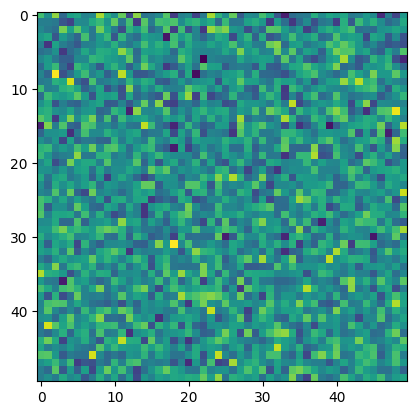

In [ ]:
salida = model6.predict(X_train)
plt.imshow(salida[1, :, :, 0])

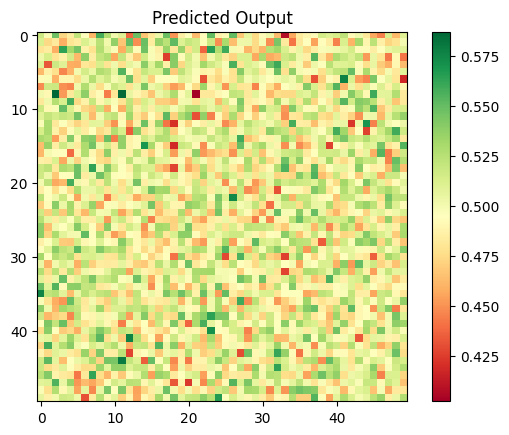

Predicted Image Range: 0.1852295696735382


In [ ]:
# Display the predicted output (1st sample) using matplotlib
plt.imshow(salida[2, :, :, 0], cmap='RdYlGn')  # Assuming it's a grayscale image
plt.colorbar()
plt.title('Predicted Output')
plt.show()

# Get the range of the predicted image
predicted_range = np.ptp(salida[2, :, :, 0])  # Peak-to-peak (max-min) value
print(f"Predicted Image Range: {predicted_range}")

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.ylim((0,1))
    plt.grid()
    plt.show()


plot_hist(historial6)

NameError: ignored

In [ ]:
def plot_hist_loss(hist):
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.ylim((0,1))
    plt.grid()
    plt.show()


plot_hist_loss(historial6)

In [ ]:
mejorModelo = keras.Model.from_config(mejor_config)
mejorModelo.set_weights(mejor_weights)

opt = keras.optimizers.Adam( learning_rate = mejores_parametros_val['lr'] )

mejorModelo.compile(optimizer=opt, loss='mse')

mejorModelo.evaluate( X_val, y_val, verbose = 0 )

In [ ]:
salida = model6.predict(X_train)
plt.imshow(salida[0, :, :, 0])

In [ ]:
# Display the predicted output (1st sample) using matplotlib
plt.imshow(salida[5, :, :, 0], cmap='RdYlGn')  # Assuming it's a grayscale image
plt.colorbar()
plt.title('Predicted Output')
plt.show()

# Get the range of the predicted image
predicted_range = np.ptp(salida[5, :, :, 0])  # Peak-to-peak (max-min) value
print(f"Predicted Image Range: {predicted_range}")

## Comparación un canal vs dos canales

In [ ]:
def plot_metrics(hist, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot accuracy
    ax1.plot(hist.history["accuracy"])
    ax1.plot(hist.history["val_accuracy"])
    ax1.set_title("Model Accuracy")
    ax1.set_ylabel("Accuracy")
    ax1.set_xlabel("Epoch")
    ax1.legend(["Train", "Validation"], loc="upper left")
    ax1.set_ylim((0, 1))
    ax1.grid()

    # Plot loss
    ax2.plot(hist.history["loss"])
    ax2.plot(hist.history["val_loss"])
    ax2.set_title("Model Loss")
    ax2.set_ylabel("Loss")
    ax2.set_xlabel("Epoch")
    ax2.legend(["Train", "Validation"], loc="upper left")
    ax2.set_ylim((0, 1))
    ax2.grid()

    plt.suptitle(title)
    plt.show()

# Example usage:
# Assuming you have historial and historial2
plot_metrics(historial5, "Model Metrics - Un canal")
plot_metrics(historial6, "Model Metrics - Dos canales")


In [ ]:
def plot_combined_metrics(hist1, hist2, title):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot accuracy
    axes[0].plot(hist1.history["accuracy"], label="Train - Un canal")
    axes[0].plot(hist1.history["val_accuracy"], label="Validation - Un canal")
    axes[0].plot(hist2.history["accuracy"], label="Train - Dos canales")
    axes[0].plot(hist2.history["val_accuracy"], label="Validation - Dos canales")
    axes[0].set_title("Model Accuracy")
    axes[0].set_ylabel("Accuracy")
    axes[0].set_xlabel("Epoch")
    axes[0].legend(loc="upper left")
    axes[0].set_ylim((0, 1))
    axes[0].grid()

    # Plot loss
    axes[1].plot(hist1.history["loss"], label="Train - Un canal")
    axes[1].plot(hist1.history["val_loss"], label="Validation - Un canal")
    axes[1].plot(hist2.history["loss"], label="Train - Dos canales")
    axes[1].plot(hist2.history["val_loss"], label="Validation - Dos canales")
    axes[1].set_title("Model Loss")
    axes[1].set_ylabel("Loss")
    axes[1].set_xlabel("Epoch")
    axes[1].legend(loc="lower left")
    axes[1].set_ylim((0, 1))
    axes[1].grid()

    plt.suptitle(title)
    plt.show()

# Example usage:
# Assuming you have historial and historial2
plot_combined_metrics(historial5, historia6, "Combined Model Metrics")

# ----------------------------------------

In [ ]:
mi_mejor_modelo.evaluate(X_test,y_test)

In [ ]:
y_pred = mi_mejor_modelo.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

In [ ]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print the metrics
print(f'Overall Accuracy (OA): {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

In [ ]:
input_layer = Input(shape=(200, 200, 2))
encoder = Conv2D(16, (3, 3), activation="relu", padding="same")(input_layer)
encoder = MaxPooling2D((2, 2))(encoder)
decoder = Conv2D(16, (3, 3), activation="relu", padding="same")(encoder)
decoder = MaxPooling2D((2, 2))(decoder)
decoder1 = Conv2D(16, (3, 3), activation="relu", padding="same")(encoder1)
decoder2 = MaxPooling2D((2, 2))(decoder)
output_layer = Conv2D(2, (3, 3), activation="sigmoid", padding="same")(decoder)

# Crea el modelo del autoencoder
autoencoder = Model(input_layer, output_layer)

# Compila el modelo
autoencoder.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])

autoencoder.summary()

In [ ]:
# Entrena el autoencoder
%time historial=autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_test, X_test))

In [ ]:
salida = autoencoder.predict(X_train)
plt.imshow(salida[2, :, :, 0])

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.ylim((0,1))
    plt.grid()
    plt.show()


plot_hist(historial)

In [ ]:
activations = get_activations(autoencoder, salida)
display_activations(activations, cmap="gray", save=False)

In [ ]:
def plot_hist_loss(hist):
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.ylim((0,1))
    plt.grid()
    plt.show()


plot_hist_loss(historial)